#  Event generation with self-contrastive estimation

The aim of this notebook is to use self-contrastive estimation to learn the distribution of one observable, conditioned on one parameter, but written in a way which generalises to more observables and parameters.

In [1]:
#  Required imports
import os, time

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from backends.utils import make_sure_dir_exists_for_filename
from backends       import stats as backend_stats
from backends.Param import Param
from backends       import models
from backends.ParameterisedSimulator import ParameterisedSimulator, Simulator_Model2, Simulator_Model3
from backends.SamplingSimulator      import SamplingSimulator

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#  Program constants

mu_range         = [-2, 3]
n_plot_points    = 6
xsec_scan_points = 7
pdf_scan_points  = 5

n_gen_points_per_c_per_ds   = 50000
n_noise_points_per_c_per_ds = 500000
n_train_points_true         = 50000
n_train_points_fake         = 100000

train_batch_size            = 150000
max_epochs                  = 10000
dropout                     = 0.1
network_layers              = (50, 50, 50)
stopping_patience           = 50
iterate_same_network        = False
initial_noise_fraction      = 0.05

num_SCE_iterations = 100

do_whiten_data = True

plot_tag = None

In [3]:
def get_cov (x) :
    return np.cov(x.transpose())

In [4]:
def whiten_data (x, means=None, stds=None, eigenvectors=None, params=None) :
    x_norm = np.copy(x)
    if type(params) != type(None) :
        means = params [0]
        stds = params [1]
        eigenvectors = params [2]
    recreate_means = False
    if type(means) == type(None) :
        recreate_means = True
        means = []
    recreate_stds = False
    if type(stds) == type(None) :
        recreate_stds = True
        stds = []
    for i in range(x.shape[1]) :
        if recreate_means :
            means.append(np.mean(x_norm [:,i]))
        if recreate_stds :
            stds.append(np.std(x_norm [:,i]))
        x_mean = means[i]
        x_std  = stds [i]
        x_norm [:,i] = (x_norm [:,i] - x_mean) / x_std
    if type(eigenvectors) == type(None) :
        data_cov = get_cov(x_norm)
        eigenvalues, eigenvectors = np.linalg.eig(data_cov)
    new_data = np.array([np.matmul(eigenvectors, xp) for xp in x_norm])
    return new_data, (means, stds, eigenvectors)

In [5]:
def unwhiten_data (x, params) :
    (means, stds, eigenvectors) = params
    inv_eigenvectors = np.linalg.inv(eigenvectors)
    new_data = np.array([np.matmul(inv_eigenvectors, xp) for xp in x])
    for i in range(new_data.shape[1]) :
        new_data [:,i] = (stds[i]*new_data [:,i] + means[i])
    return new_data
    

In [6]:
model = Simulator_Model3

plot_points    = np.linspace(mu_range[0], mu_range[1], n_plot_points)
plot_xsections = {}
plot_datasets  = {}

for plot_point in plot_points :
    model.set_param_value("c", plot_point)
    xsec, dataset = model.generate(n_gen_points_per_c_per_ds)
    plot_xsections [plot_point] = xsec
    plot_datasets  [plot_point] = dataset
    
model.set_param_value("c", 0)
xsec_SM, dataset_SM = plot_xsections[0], plot_datasets[0]

learn_datapoints = plot_datasets[-2.]
if do_whiten_data :
    learn_datapoints, whitening_params = whiten_data (learn_datapoints)
learn_weights    = np.full(shape=(len(learn_datapoints),), fill_value=1./n_gen_points_per_c_per_ds)

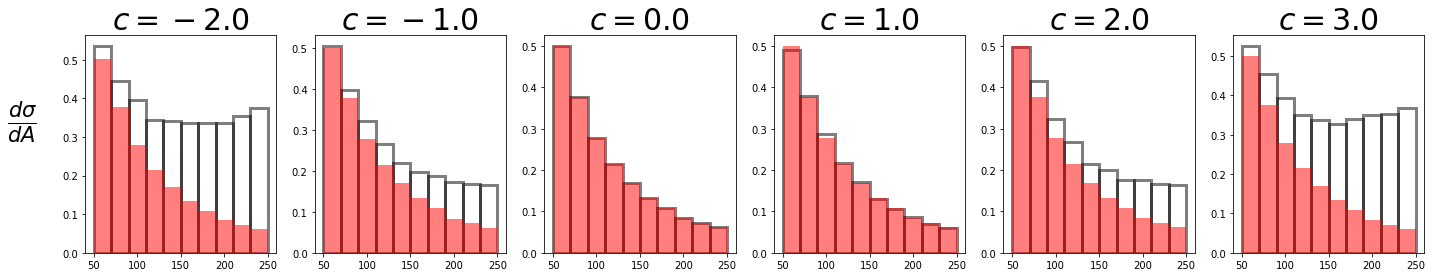

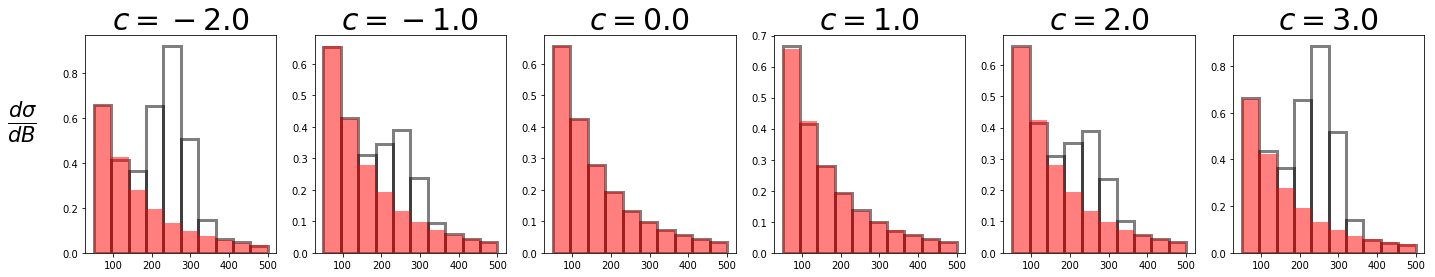

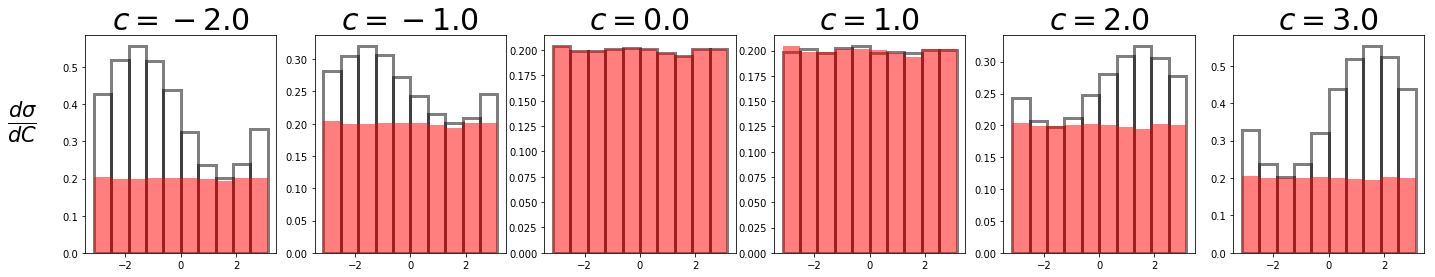

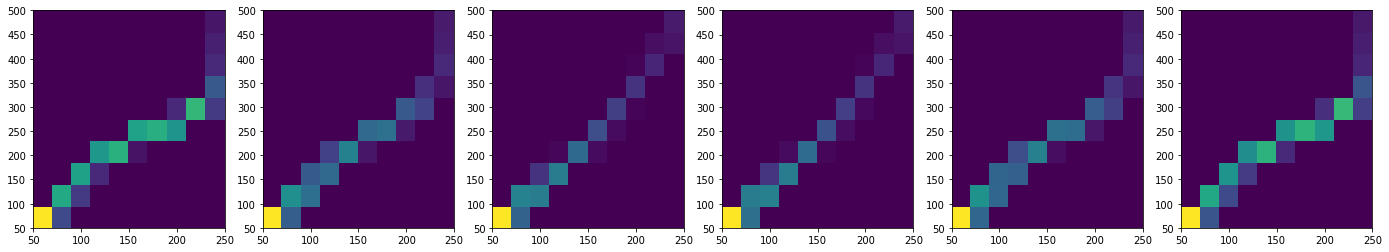

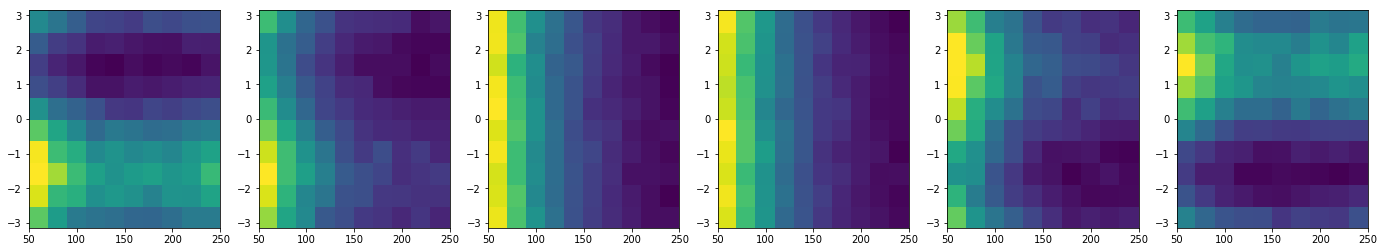

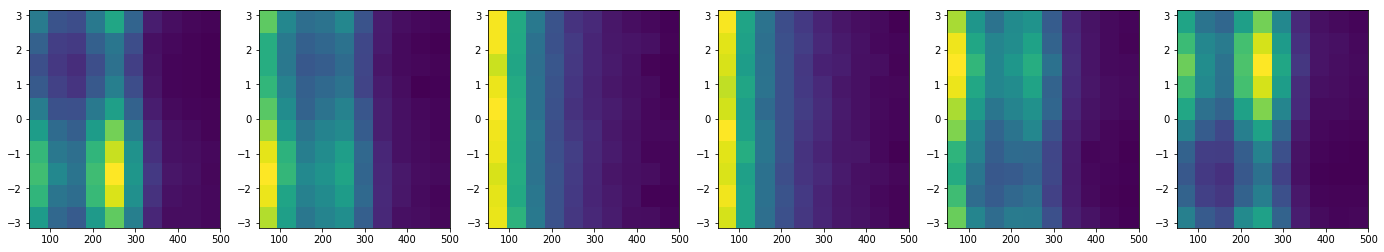

In [7]:
fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    xsec    = plot_xsections [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist(dataset   [:,0], alpha=0.5, weights=np.full(shape=dataset   [:,0].shape, fill_value=xsec   /n_gen_points_per_c_per_ds), fill=False, edgecolor="k", linestyle="-" , linewidth=3)
    ax1.hist(dataset_SM[:,0], alpha=0.5, weights=np.full(shape=dataset_SM[:,0].shape, fill_value=xsec_SM/n_gen_points_per_c_per_ds), fill=True , color    ="r", linestyle="-" , linewidth=3)
    ax1.set_title(f"$c = {plot_point}$", fontsize=30)
    if ax_idx > 0 : continue
    ax1.set_ylabel(r"$\frac{d\sigma}{dA}$", fontsize=30, rotation=0, labelpad=40)
if type(plot_tag) != type(None) :
    plt.savefig()
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    xsec    = plot_xsections [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist(dataset   [:,1], alpha=0.5, weights=np.full(shape=dataset   [:,1].shape, fill_value=xsec   /n_gen_points_per_c_per_ds), fill=False, edgecolor="k", linestyle="-" , linewidth=3)
    ax1.hist(dataset_SM[:,1], alpha=0.5, weights=np.full(shape=dataset_SM[:,1].shape, fill_value=xsec_SM/n_gen_points_per_c_per_ds), fill=True , color    ="r", linestyle="-" , linewidth=3)
    ax1.set_title(f"$c = {plot_point}$", fontsize=30)
    if ax_idx > 0 : continue
    ax1.set_ylabel(r"$\frac{d\sigma}{dB}$", fontsize=30, rotation=0, labelpad=40)
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    xsec    = plot_xsections [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist(dataset   [:,2], alpha=0.5, weights=np.full(shape=dataset   [:,2].shape, fill_value=xsec   /n_gen_points_per_c_per_ds), fill=False, edgecolor="k", linestyle="-" , linewidth=3)
    ax1.hist(dataset_SM[:,2], alpha=0.5, weights=np.full(shape=dataset_SM[:,2].shape, fill_value=xsec_SM/n_gen_points_per_c_per_ds), fill=True , color    ="r", linestyle="-" , linewidth=3)
    ax1.set_title(f"$c = {plot_point}$", fontsize=30)
    if ax_idx > 0 : continue
    ax1.set_ylabel(r"$\frac{d\sigma}{dC}$", fontsize=30, rotation=0, labelpad=40)
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist2d(dataset[:,0], dataset[:,1])
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist2d(dataset[:,0], dataset[:,2])
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist2d(dataset[:,1], dataset[:,2])
plt.show()


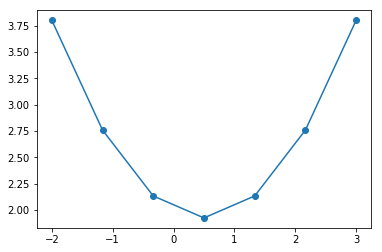

In [8]:
x = np.linspace(mu_range[0], mu_range[1], xsec_scan_points)
y = {}
for xp in x :
    model.set_param_value("c", xp)
    y[xp], _ = model.generate(0)
plt.plot(x, [y[xp] for xp in x], "o-")
plt.show()

In [9]:
def noise_model1 (self, x, *argv, **kwargs) :
    if hasattr(self, "return_value") == False :
        A_lims = [50, 250]
        B_lims = [50, 500]
        C_lims = [-1.*np.pi, np.pi]
        A_range = A_lims[1] - A_lims[0]
        B_range = B_lims[1] - B_lims[0]
        C_range = C_lims[1] - C_lims[0]
        self.return_value = 1. / (A_range*B_range*C_range)
    return self.return_value

def noise_model2 (self, x, *argv, **kwargs) :
    if hasattr(self, "return_value") == False :
        B_lims = [50, 500]
        C_lims = [-1.*np.pi, np.pi]
        B_range = B_lims[1] - B_lims[0]
        C_range = C_lims[1] - C_lims[0]
        self.return_value = 1. / (B_range*C_range)
    return self.return_value * stats.norm.pdf(x[0], 150, 50)

class NoiseModel :
    def clear (self) :
        self.name  = ""
        self.model = None
    def evaluate (self, x) :
        if type(self.model) == type(None) :
            raise RuntimeError(f"Cannot evaluate PDF - no function set")
        return self.model(self, x)
    @classmethod
    def from_noise_and_model (cls, noise, disc, new_name="") :
        def new_model (self, x, *argv, **kwargs) :
            f = noise.evaluate(x)
            D = disc.predict(np.array([x]))[0,0]
            return D * f / (1.-D)
        return cls(new_name, new_model)
    def __init__ (self, name="", model=None) :
        self.clear()
        self.name  = name
        self.model = model
        
NoiseModel1 = NoiseModel("NoiseModel1", noise_model1)
NoiseModel2 = NoiseModel("NoiseModel2", noise_model2)

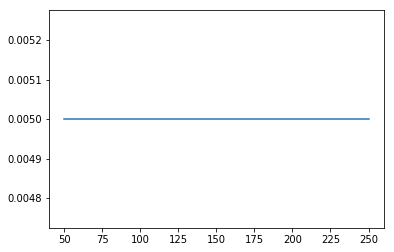

In [10]:
y = []
A_range = 200.
B_range = 450.
C_range = 2.*np.pi
n_points_A = 40
n_points_B = 40
n_points_C = 40
spacing_A  = A_range / (n_points_A)
spacing_B  = B_range / (n_points_B)
spacing_C  = C_range / (n_points_C)
samples_A = np.linspace(50, 250, n_points_A)
samples_B = np.linspace(50, 500, n_points_B)
samples_C = np.linspace(-1.*np.pi, np.pi, n_points_C)
for A in samples_A :
    yp = 0.
    for B in samples_B :
        for C in samples_C :
            yp = yp + NoiseModel1.evaluate([A,B,C]) * (spacing_B*spacing_C)
    y.append(yp)
plt.plot(samples_A, y)
plt.show()


In [11]:
def shuffle (*v) :
    pairs = [_ for _ in zip(*v)]
    np.random.shuffle(pairs)
    to_ret = []
    for idx in range(len(v)) :
        to_ret.append(np.array([p[idx] for p in pairs]))
    return tuple(to_ret)

In [12]:
#  Brief:  use NoiseModel or ContrastiveModel to generate weights for pre-existing datapoints
#
def generate_weights (x, model1, model2) :
    weights = []
    for xp in x :
        w = model2.evaluate(xp) / model1.evaluate(xp)
        if np.isnan(w) : w = 0.
        if np.isinf(w) : w = 1.
        weights.append(w)
    return weights, x


#  Brief:  alternative: store old weights in a vector, so we don't have to re-evaluate them every time
#
def update_weights (x, old_weights, new_model) :
    weights = []
    for xp, old_weight, new_f in zip(x, old_weights, new_model) :
        w = new_f / old_weight
        if np.isnan(w) : w = 0.
        if np.isinf(w) : w = 1.
        weights.append(w)
    return weights


#  Brief:  update model values
#
def update_model_values (x, old_values, disc) :
    D = disc.predict(x)[:,0]
    return D * old_values / (1.-D)

In [13]:
def iterate (noise_f_N, noise_datapoints, noise_weights_N, initial_noise_weights, disc=None, initial_noise_fraction=0) :
    random_indices     = np.random.randint(0, learn_datapoints.shape[0], n_train_points_true)
    train_DS_true      = learn_datapoints  [random_indices,:]
    train_weights_true = learn_weights     [random_indices]
    train_weights_true = train_weights_true / np.sum(train_weights_true)
    
    '''print("Trimming small weights")
    indices = np.array([i for i, weight in enumerate(noise_weights_N/np.mean(noise_weights_N)) if weight > 0.001])
    n_surviving = len(indices)
    random_indices     = np.random.randint(0, n_surviving, n_train_points_fake)
    random_indices     = indices [random_indices]
    
    print(f"  - minimum weight is {np.min(noise_weights_N)}")
    print(f"  - maxiumum weight is {np.max(noise_weights_N)}")
    print(f"  - mean weight is {np.mean(noise_weights_N)}")
    print(f"  - std dev is {np.std(noise_weights_N)}")
    print(f"  -  {n_surviving} survived")'''
    
    #random_indices     = np.random.randint(0, noise_datapoints.shape[0], n_train_points_fake)
    
    '''train_DS_fake      = noise_datapoints  [random_indices,:]
    train_weights_fake = noise_weights_N   [random_indices]
    train_weights_fake = train_weights_fake / np.sum(train_weights_true)'''
    
    noise_weights_N_updated = noise_weights_N
    if initial_noise_fraction > 0 :
        print(f"Adding {100.*initial_noise_fraction:.2f}% of initial noise back in")
        noise_weights_N_updated = noise_weights_N_updated + initial_noise_fraction*initial_noise_weights
        noise_weights_N_updated = noise_weights_N_updated / np.sum(noise_weights_N_updated)
    
    print(f"{len(noise_weights_N)} noise datapoints provided")
    print(f"{100.*len([1 for xp in noise_weights_N/np.mean(noise_weights_N) if xp > 0.01])/len(noise_weights_N):.2f}% are useful (weight is > 1% of the mean)")
    
    random_indices = np.random.choice(len(noise_weights_N_updated), n_train_points_fake, p=noise_weights_N_updated)
    train_DS_fake      = noise_datapoints  [random_indices,:]
    train_weights_fake = np.full(shape=(n_train_points_fake,), fill_value=1./n_train_points_fake)
    
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.hist(noise_weights_N)
    ax.set_title("Noise weights")
    ax = fig.add_subplot(1, 2, 2)
    ax.hist(noise_weights_N[random_indices])
    ax.set_title("Selected noise weights")
    plt.show()
    for i in range(noise_datapoints.shape[1]) :
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1, 2, 1)
        ax.hist(noise_datapoints  [:,i], alpha=0.5, weights=noise_weights_N)
        ax.hist(noise_datapoints  [:,i], alpha=0.5, weights=noise_weights_N_updated)
        ax.set_title(f"Noise x[{i}]")
        ax = fig.add_subplot(1, 2, 2)
        ax.hist(noise_datapoints  [random_indices,i])
        ax.set_title(f"Selected noise x[{i}]")
        plt.show()

    labels_true = np.array([1. for i in range(len(train_DS_true))])
    labels_fake = np.array([0. for i in range(len(train_DS_fake))])

    train_data    = np.concatenate([train_DS_true     , train_DS_fake     ])
    train_labels  = np.concatenate([labels_true       , labels_fake       ])
    train_weights = np.concatenate([train_weights_true, train_weights_fake])
    train_data, train_labels, train_weights = shuffle(train_data, train_labels, train_weights)
    
    if type(disc) == type(None) :
        disc = models.create_unconditional_discriminator (dropout         = dropout,
                                                          num_categories  = 1,
                                                          num_observables = 3,
                                                          batch_norm      = False,
                                                          mid_layers      = network_layers)

    history = disc.fit(train_data, 
                       train_labels,
                       sample_weight=train_weights,
                       validation_split = 0.5,
                       callbacks = [EarlyStopping(patience=stopping_patience, restore_best_weights=True)],
                       epochs=max_epochs,
                       shuffle=True,
                       batch_size=train_batch_size)
    
    noise_f_new       = update_model_values(noise_datapoints, noise_f_N, disc)
    noise_weights_new = noise_f_new / initial_noise_weights  #   update_weights(noise_datapoints, noise_weights_N, noise_f_new)
    noise_weights_new = noise_weights_new / np.sum(noise_weights_new)
    
    return noise_f_new, noise_weights_new, disc


In [14]:
noise_simulator = SamplingSimulator(name  = "noise_generator", 
                                    model = NoiseModel1, 
                                    axes  = [samples_A, samples_B, samples_C])

noise_datapoints = noise_simulator.generate(n_noise_points_per_c_per_ds)
if do_whiten_data :
    noise_datapoints, _ = whiten_data (noise_datapoints, params=whitening_params)
noise_weights    = np.array([NoiseModel1.evaluate(x) for x in noise_datapoints])
noise_weights    = noise_weights / np.sum(noise_weights)

Adding 5.00% of initial noise back in
500000 noise datapoints provided
100.00% are useful (weight is > 1% of the mean)


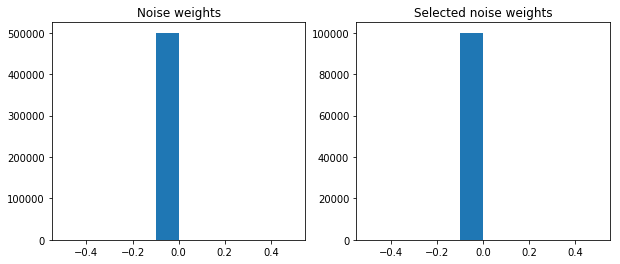

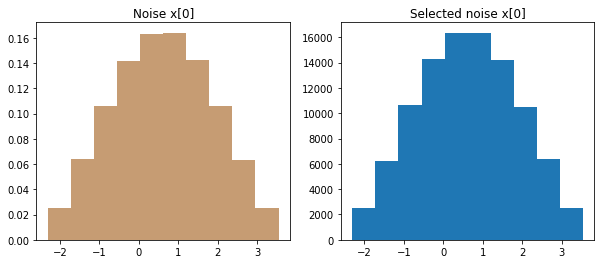

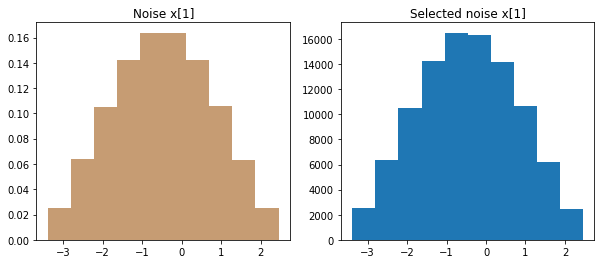

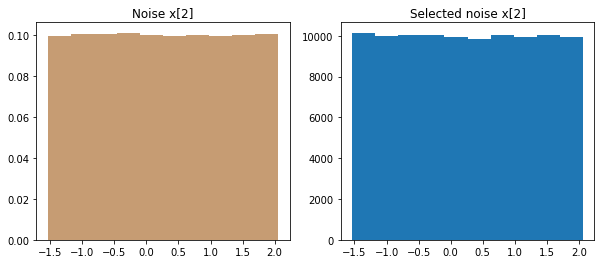

Creating discriminator with 3 observables and None conditions
Instructions for updating:
Colocations handled automatically by placer.
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)            

Epoch 51/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8246e-06 - val_loss: 8.7710e-06
Epoch 52/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8135e-06 - val_loss: 8.7637e-06
Epoch 53/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8067e-06 - val_loss: 8.7563e-06
Epoch 54/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8021e-06 - val_loss: 8.7490e-06
Epoch 55/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.7975e-06 - val_loss: 8.7416e-06
Epoch 56/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.7854e-06 - val_loss: 8.7342e-06
Epoch 57/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.7850e-06 - val_loss: 8.7268e-06
Epoch 58/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.7745e-06 - val_loss: 8.7194e-06
Epoch 59/10000
75000/75000 [==============================] - 0s 3us/ste

Epoch 122/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2755e-06 - val_loss: 8.1997e-06
Epoch 123/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2744e-06 - val_loss: 8.1907e-06
Epoch 124/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2565e-06 - val_loss: 8.1815e-06
Epoch 125/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2548e-06 - val_loss: 8.1723e-06
Epoch 126/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2436e-06 - val_loss: 8.1631e-06
Epoch 127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2334e-06 - val_loss: 8.1539e-06
Epoch 128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2292e-06 - val_loss: 8.1446e-06
Epoch 129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.2279e-06 - val_loss: 8.1353e-06
Epoch 130/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 7.6306e-06 - val_loss: 7.5044e-06
Epoch 193/10000
75000/75000 [==============================] - 0s 3us/step - loss: 7.6217e-06 - val_loss: 7.4940e-06
Epoch 194/10000
75000/75000 [==============================] - 0s 3us/step - loss: 7.6059e-06 - val_loss: 7.4835e-06
Epoch 195/10000
75000/75000 [==============================] - 0s 2us/step - loss: 7.6116e-06 - val_loss: 7.4730e-06
Epoch 196/10000
75000/75000 [==============================] - 0s 3us/step - loss: 7.5972e-06 - val_loss: 7.4625e-06
Epoch 197/10000
75000/75000 [==============================] - 0s 3us/step - loss: 7.5906e-06 - val_loss: 7.4520e-06
Epoch 198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 7.5760e-06 - val_loss: 7.4414e-06
Epoch 199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 7.5653e-06 - val_loss: 7.4309e-06
Epoch 200/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 263/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.9102e-06 - val_loss: 6.7314e-06
Epoch 264/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.8988e-06 - val_loss: 6.7197e-06
Epoch 265/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.8810e-06 - val_loss: 6.7081e-06
Epoch 266/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.8781e-06 - val_loss: 6.6963e-06
Epoch 267/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.8688e-06 - val_loss: 6.6846e-06
Epoch 268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.8570e-06 - val_loss: 6.6728e-06
Epoch 269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.8450e-06 - val_loss: 6.6611e-06
Epoch 270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.8255e-06 - val_loss: 6.6492e-06
Epoch 271/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 2us/step - loss: 6.0871e-06 - val_loss: 5.8504e-06
Epoch 334/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.0796e-06 - val_loss: 5.8370e-06
Epoch 335/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.0769e-06 - val_loss: 5.8236e-06
Epoch 336/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.0500e-06 - val_loss: 5.8102e-06
Epoch 337/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.0329e-06 - val_loss: 5.7967e-06
Epoch 338/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.0257e-06 - val_loss: 5.7833e-06
Epoch 339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 6.0120e-06 - val_loss: 5.7698e-06
Epoch 340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.9998e-06 - val_loss: 5.7563e-06
Epoch 341/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 404/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.2208e-06 - val_loss: 4.9320e-06
Epoch 405/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.2095e-06 - val_loss: 4.9205e-06
Epoch 406/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.1891e-06 - val_loss: 4.9091e-06
Epoch 407/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.1723e-06 - val_loss: 4.8978e-06
Epoch 408/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.1740e-06 - val_loss: 4.8865e-06
Epoch 409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.1707e-06 - val_loss: 4.8754e-06
Epoch 410/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.1542e-06 - val_loss: 4.8642e-06
Epoch 411/10000
75000/75000 [==============================] - 0s 3us/step - loss: 5.1438e-06 - val_loss: 4.8532e-06
Epoch 412/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 4.6031e-06 - val_loss: 4.2850e-06
Epoch 475/10000
75000/75000 [==============================] - 0s 2us/step - loss: 4.5840e-06 - val_loss: 4.2779e-06
Epoch 476/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.5655e-06 - val_loss: 4.2708e-06
Epoch 477/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.5779e-06 - val_loss: 4.2637e-06
Epoch 478/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.5622e-06 - val_loss: 4.2568e-06
Epoch 479/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.5395e-06 - val_loss: 4.2498e-06
Epoch 480/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.5631e-06 - val_loss: 4.2429e-06
Epoch 481/10000
75000/75000 [==============================] - 0s 2us/step - loss: 4.5413e-06 - val_loss: 4.2361e-06
Epoch 482/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 545/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.1968e-06 - val_loss: 3.8829e-06
Epoch 546/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.1966e-06 - val_loss: 3.8784e-06
Epoch 547/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.1615e-06 - val_loss: 3.8740e-06
Epoch 548/10000
75000/75000 [==============================] - 0s 2us/step - loss: 4.1825e-06 - val_loss: 3.8696e-06
Epoch 549/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.1769e-06 - val_loss: 3.8652e-06
Epoch 550/10000
75000/75000 [==============================] - 0s 2us/step - loss: 4.1682e-06 - val_loss: 3.8608e-06
Epoch 551/10000
75000/75000 [==============================] - 0s 3us/step - loss: 4.1671e-06 - val_loss: 3.8565e-06
Epoch 552/10000
75000/75000 [==============================] - 0s 2us/step - loss: 4.1545e-06 - val_loss: 3.8522e-06
Epoch 553/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 3.9257e-06 - val_loss: 3.6215e-06
Epoch 616/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.9185e-06 - val_loss: 3.6184e-06
Epoch 617/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.9317e-06 - val_loss: 3.6153e-06
Epoch 618/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.9097e-06 - val_loss: 3.6122e-06
Epoch 619/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.9318e-06 - val_loss: 3.6091e-06
Epoch 620/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.9041e-06 - val_loss: 3.6061e-06
Epoch 621/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.9065e-06 - val_loss: 3.6030e-06
Epoch 622/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.9123e-06 - val_loss: 3.5999e-06
Epoch 623/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 686/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.7357e-06 - val_loss: 3.4262e-06
Epoch 687/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.7268e-06 - val_loss: 3.4237e-06
Epoch 688/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.7254e-06 - val_loss: 3.4212e-06
Epoch 689/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.7180e-06 - val_loss: 3.4188e-06
Epoch 690/10000
75000/75000 [==============================] - 0s 2us/step - loss: 3.7439e-06 - val_loss: 3.4164e-06
Epoch 691/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.7179e-06 - val_loss: 3.4139e-06
Epoch 692/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.7060e-06 - val_loss: 3.4115e-06
Epoch 693/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.7132e-06 - val_loss: 3.4091e-06
Epoch 694/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 3.5612e-06 - val_loss: 3.2641e-06
Epoch 757/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.5668e-06 - val_loss: 3.2620e-06
Epoch 758/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.5673e-06 - val_loss: 3.2599e-06
Epoch 759/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.5860e-06 - val_loss: 3.2578e-06
Epoch 760/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.5520e-06 - val_loss: 3.2556e-06
Epoch 761/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.5768e-06 - val_loss: 3.2535e-06
Epoch 762/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.5657e-06 - val_loss: 3.2514e-06
Epoch 763/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.5605e-06 - val_loss: 3.2492e-06
Epoch 764/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 827/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.4278e-06 - val_loss: 3.1267e-06
Epoch 828/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.4331e-06 - val_loss: 3.1249e-06
Epoch 829/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.4340e-06 - val_loss: 3.1232e-06
Epoch 830/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.4292e-06 - val_loss: 3.1214e-06
Epoch 831/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.4214e-06 - val_loss: 3.1197e-06
Epoch 832/10000
75000/75000 [==============================] - 0s 2us/step - loss: 3.4229e-06 - val_loss: 3.1180e-06
Epoch 833/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.4260e-06 - val_loss: 3.1164e-06
Epoch 834/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.4258e-06 - val_loss: 3.1147e-06
Epoch 835/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 3.3216e-06 - val_loss: 3.0096e-06
Epoch 898/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.2979e-06 - val_loss: 3.0080e-06
Epoch 899/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.3237e-06 - val_loss: 3.0064e-06
Epoch 900/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.3011e-06 - val_loss: 3.0048e-06
Epoch 901/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.3036e-06 - val_loss: 3.0031e-06
Epoch 902/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.2898e-06 - val_loss: 3.0015e-06
Epoch 903/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.3196e-06 - val_loss: 2.9999e-06
Epoch 904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.2923e-06 - val_loss: 2.9983e-06
Epoch 905/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 968/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.1977e-06 - val_loss: 2.8964e-06
Epoch 969/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.2133e-06 - val_loss: 2.8949e-06
Epoch 970/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.2004e-06 - val_loss: 2.8934e-06
Epoch 971/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.1998e-06 - val_loss: 2.8919e-06
Epoch 972/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.1962e-06 - val_loss: 2.8904e-06
Epoch 973/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.2012e-06 - val_loss: 2.8888e-06
Epoch 974/10000
75000/75000 [==============================] - 0s 2us/step - loss: 3.1723e-06 - val_loss: 2.8873e-06
Epoch 975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.1820e-06 - val_loss: 2.8858e-06
Epoch 976/10000
75000/75000 [==============================] - 0

Epoch 1038/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.0838e-06 - val_loss: 2.7907e-06
Epoch 1039/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.0896e-06 - val_loss: 2.7893e-06
Epoch 1040/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.1070e-06 - val_loss: 2.7879e-06
Epoch 1041/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.1019e-06 - val_loss: 2.7864e-06
Epoch 1042/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.1031e-06 - val_loss: 2.7850e-06
Epoch 1043/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.0806e-06 - val_loss: 2.7835e-06
Epoch 1044/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.0684e-06 - val_loss: 2.7820e-06
Epoch 1045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.0896e-06 - val_loss: 2.7805e-06
Epoch 1046/10000
75000/75000 [==========================

Epoch 1108/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.0027e-06 - val_loss: 2.6907e-06
Epoch 1109/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9925e-06 - val_loss: 2.6893e-06
Epoch 1110/10000
75000/75000 [==============================] - 0s 3us/step - loss: 3.0013e-06 - val_loss: 2.6879e-06
Epoch 1111/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9789e-06 - val_loss: 2.6865e-06
Epoch 1112/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9890e-06 - val_loss: 2.6851e-06
Epoch 1113/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9868e-06 - val_loss: 2.6838e-06
Epoch 1114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9967e-06 - val_loss: 2.6824e-06
Epoch 1115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9920e-06 - val_loss: 2.6811e-06
Epoch 1116/10000
75000/75000 [==========================

Epoch 1178/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8991e-06 - val_loss: 2.5984e-06
Epoch 1179/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9246e-06 - val_loss: 2.5971e-06
Epoch 1180/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8994e-06 - val_loss: 2.5959e-06
Epoch 1181/10000
75000/75000 [==============================] - 0s 4us/step - loss: 2.9107e-06 - val_loss: 2.5946e-06
Epoch 1182/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9059e-06 - val_loss: 2.5933e-06
Epoch 1183/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8938e-06 - val_loss: 2.5920e-06
Epoch 1184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9031e-06 - val_loss: 2.5908e-06
Epoch 1185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.9028e-06 - val_loss: 2.5895e-06
Epoch 1186/10000
75000/75000 [==========================

Epoch 1248/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8402e-06 - val_loss: 2.5147e-06
Epoch 1249/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8072e-06 - val_loss: 2.5136e-06
Epoch 1250/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8089e-06 - val_loss: 2.5125e-06
Epoch 1251/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8093e-06 - val_loss: 2.5113e-06
Epoch 1252/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8206e-06 - val_loss: 2.5101e-06
Epoch 1253/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8237e-06 - val_loss: 2.5089e-06
Epoch 1254/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8229e-06 - val_loss: 2.5078e-06
Epoch 1255/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.8153e-06 - val_loss: 2.5066e-06
Epoch 1256/10000
75000/75000 [==========================

Epoch 1318/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.7584e-06 - val_loss: 2.4393e-06
Epoch 1319/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.7533e-06 - val_loss: 2.4383e-06
Epoch 1320/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.7489e-06 - val_loss: 2.4373e-06
Epoch 1321/10000
75000/75000 [==============================] - 0s 2us/step - loss: 2.7489e-06 - val_loss: 2.4364e-06
Epoch 1322/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.7472e-06 - val_loss: 2.4354e-06
Epoch 1323/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.7605e-06 - val_loss: 2.4344e-06
Epoch 1324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.7542e-06 - val_loss: 2.4334e-06
Epoch 1325/10000
75000/75000 [==============================] - 0s 2us/step - loss: 2.7522e-06 - val_loss: 2.4324e-06
Epoch 1326/10000
75000/75000 [==========================

Epoch 1388/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6987e-06 - val_loss: 2.3730e-06
Epoch 1389/10000
75000/75000 [==============================] - 0s 2us/step - loss: 2.6980e-06 - val_loss: 2.3721e-06
Epoch 1390/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6900e-06 - val_loss: 2.3713e-06
Epoch 1391/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6819e-06 - val_loss: 2.3704e-06
Epoch 1392/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6826e-06 - val_loss: 2.3695e-06
Epoch 1393/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6694e-06 - val_loss: 2.3685e-06
Epoch 1394/10000
75000/75000 [==============================] - 0s 2us/step - loss: 2.6786e-06 - val_loss: 2.3675e-06
Epoch 1395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6948e-06 - val_loss: 2.3666e-06
Epoch 1396/10000
75000/75000 [==========================

Epoch 1458/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6299e-06 - val_loss: 2.3132e-06
Epoch 1459/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6288e-06 - val_loss: 2.3124e-06
Epoch 1460/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6270e-06 - val_loss: 2.3116e-06
Epoch 1461/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6304e-06 - val_loss: 2.3107e-06
Epoch 1462/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6190e-06 - val_loss: 2.3098e-06
Epoch 1463/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6286e-06 - val_loss: 2.3089e-06
Epoch 1464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6352e-06 - val_loss: 2.3081e-06
Epoch 1465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.6282e-06 - val_loss: 2.3072e-06
Epoch 1466/10000
75000/75000 [==========================

Epoch 1528/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5779e-06 - val_loss: 2.2571e-06
Epoch 1529/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5716e-06 - val_loss: 2.2563e-06
Epoch 1530/10000
75000/75000 [==============================] - 0s 2us/step - loss: 2.5703e-06 - val_loss: 2.2555e-06
Epoch 1531/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5698e-06 - val_loss: 2.2546e-06
Epoch 1532/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5743e-06 - val_loss: 2.2538e-06
Epoch 1533/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5737e-06 - val_loss: 2.2530e-06
Epoch 1534/10000
75000/75000 [==============================] - 0s 2us/step - loss: 2.5558e-06 - val_loss: 2.2521e-06
Epoch 1535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5825e-06 - val_loss: 2.2513e-06
Epoch 1536/10000
75000/75000 [==========================

Epoch 1598/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5040e-06 - val_loss: 2.2039e-06
Epoch 1599/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5393e-06 - val_loss: 2.2030e-06
Epoch 1600/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5246e-06 - val_loss: 2.2021e-06
Epoch 1601/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5234e-06 - val_loss: 2.2012e-06
Epoch 1602/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5162e-06 - val_loss: 2.2003e-06
Epoch 1603/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5364e-06 - val_loss: 2.1995e-06
Epoch 1604/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5207e-06 - val_loss: 2.1987e-06
Epoch 1605/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.5274e-06 - val_loss: 2.1979e-06
Epoch 1606/10000
75000/75000 [==========================

Epoch 1668/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4963e-06 - val_loss: 2.1545e-06
Epoch 1669/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4842e-06 - val_loss: 2.1539e-06
Epoch 1670/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4590e-06 - val_loss: 2.1532e-06
Epoch 1671/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4876e-06 - val_loss: 2.1525e-06
Epoch 1672/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4811e-06 - val_loss: 2.1518e-06
Epoch 1673/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4574e-06 - val_loss: 2.1509e-06
Epoch 1674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4579e-06 - val_loss: 2.1501e-06
Epoch 1675/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4619e-06 - val_loss: 2.1493e-06
Epoch 1676/10000
75000/75000 [==========================

Epoch 1738/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4491e-06 - val_loss: 2.1082e-06
Epoch 1739/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4149e-06 - val_loss: 2.1078e-06
Epoch 1740/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4216e-06 - val_loss: 2.1073e-06
Epoch 1741/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4212e-06 - val_loss: 2.1067e-06
Epoch 1742/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4239e-06 - val_loss: 2.1060e-06
Epoch 1743/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4352e-06 - val_loss: 2.1054e-06
Epoch 1744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4234e-06 - val_loss: 2.1046e-06
Epoch 1745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4299e-06 - val_loss: 2.1039e-06
Epoch 1746/10000
75000/75000 [==========================

Epoch 1808/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4083e-06 - val_loss: 2.0618e-06
Epoch 1809/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3717e-06 - val_loss: 2.0612e-06
Epoch 1810/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4103e-06 - val_loss: 2.0606e-06
Epoch 1811/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3825e-06 - val_loss: 2.0601e-06
Epoch 1812/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.4025e-06 - val_loss: 2.0596e-06
Epoch 1813/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3781e-06 - val_loss: 2.0592e-06
Epoch 1814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3979e-06 - val_loss: 2.0587e-06
Epoch 1815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3863e-06 - val_loss: 2.0583e-06
Epoch 1816/10000
75000/75000 [==========================

Epoch 1878/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3574e-06 - val_loss: 2.0195e-06
Epoch 1879/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3404e-06 - val_loss: 2.0190e-06
Epoch 1880/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3615e-06 - val_loss: 2.0186e-06
Epoch 1881/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3491e-06 - val_loss: 2.0182e-06
Epoch 1882/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3521e-06 - val_loss: 2.0179e-06
Epoch 1883/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3440e-06 - val_loss: 2.0176e-06
Epoch 1884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3555e-06 - val_loss: 2.0172e-06
Epoch 1885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3564e-06 - val_loss: 2.0166e-06
Epoch 1886/10000
75000/75000 [==========================

Epoch 1948/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3275e-06 - val_loss: 1.9801e-06
Epoch 1949/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3100e-06 - val_loss: 1.9793e-06
Epoch 1950/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3009e-06 - val_loss: 1.9788e-06
Epoch 1951/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3117e-06 - val_loss: 1.9783e-06
Epoch 1952/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3176e-06 - val_loss: 1.9779e-06
Epoch 1953/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3047e-06 - val_loss: 1.9775e-06
Epoch 1954/10000
75000/75000 [==============================] - 0s 2us/step - loss: 2.3201e-06 - val_loss: 1.9770e-06
Epoch 1955/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.3057e-06 - val_loss: 1.9765e-06
Epoch 1956/10000
75000/75000 [==========================

Epoch 2018/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2715e-06 - val_loss: 1.9433e-06
Epoch 2019/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2799e-06 - val_loss: 1.9425e-06
Epoch 2020/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2907e-06 - val_loss: 1.9418e-06
Epoch 2021/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2905e-06 - val_loss: 1.9411e-06
Epoch 2022/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2888e-06 - val_loss: 1.9404e-06
Epoch 2023/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2682e-06 - val_loss: 1.9398e-06
Epoch 2024/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2810e-06 - val_loss: 1.9393e-06
Epoch 2025/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2791e-06 - val_loss: 1.9388e-06
Epoch 2026/10000
75000/75000 [==========================

Epoch 2088/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2469e-06 - val_loss: 1.9102e-06
Epoch 2089/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2399e-06 - val_loss: 1.9099e-06
Epoch 2090/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2613e-06 - val_loss: 1.9096e-06
Epoch 2091/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2391e-06 - val_loss: 1.9095e-06
Epoch 2092/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2489e-06 - val_loss: 1.9092e-06
Epoch 2093/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2318e-06 - val_loss: 1.9089e-06
Epoch 2094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2665e-06 - val_loss: 1.9086e-06
Epoch 2095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2439e-06 - val_loss: 1.9084e-06
Epoch 2096/10000
75000/75000 [==========================

Epoch 2158/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2091e-06 - val_loss: 1.8799e-06
Epoch 2159/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2254e-06 - val_loss: 1.8795e-06
Epoch 2160/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2164e-06 - val_loss: 1.8791e-06
Epoch 2161/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2090e-06 - val_loss: 1.8787e-06
Epoch 2162/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2098e-06 - val_loss: 1.8784e-06
Epoch 2163/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2013e-06 - val_loss: 1.8780e-06
Epoch 2164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2082e-06 - val_loss: 1.8776e-06
Epoch 2165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2190e-06 - val_loss: 1.8774e-06
Epoch 2166/10000
75000/75000 [==========================

Epoch 2228/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2061e-06 - val_loss: 1.8530e-06
Epoch 2229/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1888e-06 - val_loss: 1.8523e-06
Epoch 2230/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2060e-06 - val_loss: 1.8515e-06
Epoch 2231/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1783e-06 - val_loss: 1.8508e-06
Epoch 2232/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1986e-06 - val_loss: 1.8502e-06
Epoch 2233/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1937e-06 - val_loss: 1.8496e-06
Epoch 2234/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.2070e-06 - val_loss: 1.8491e-06
Epoch 2235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1932e-06 - val_loss: 1.8486e-06
Epoch 2236/10000
75000/75000 [==========================

Epoch 2298/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1657e-06 - val_loss: 1.8254e-06
Epoch 2299/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1656e-06 - val_loss: 1.8251e-06
Epoch 2300/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1687e-06 - val_loss: 1.8248e-06
Epoch 2301/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1608e-06 - val_loss: 1.8244e-06
Epoch 2302/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1602e-06 - val_loss: 1.8241e-06
Epoch 2303/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1887e-06 - val_loss: 1.8238e-06
Epoch 2304/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1875e-06 - val_loss: 1.8236e-06
Epoch 2305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1637e-06 - val_loss: 1.8234e-06
Epoch 2306/10000
75000/75000 [==========================

Epoch 2368/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1492e-06 - val_loss: 1.8001e-06
Epoch 2369/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1432e-06 - val_loss: 1.8001e-06
Epoch 2370/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1504e-06 - val_loss: 1.8001e-06
Epoch 2371/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1556e-06 - val_loss: 1.8001e-06
Epoch 2372/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1511e-06 - val_loss: 1.8000e-06
Epoch 2373/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1321e-06 - val_loss: 1.7998e-06
Epoch 2374/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1325e-06 - val_loss: 1.7994e-06
Epoch 2375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1604e-06 - val_loss: 1.7991e-06
Epoch 2376/10000
75000/75000 [==========================

Epoch 2438/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1391e-06 - val_loss: 1.7780e-06
Epoch 2439/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1125e-06 - val_loss: 1.7778e-06
Epoch 2440/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1048e-06 - val_loss: 1.7775e-06
Epoch 2441/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1328e-06 - val_loss: 1.7771e-06
Epoch 2442/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1145e-06 - val_loss: 1.7768e-06
Epoch 2443/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1219e-06 - val_loss: 1.7765e-06
Epoch 2444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1311e-06 - val_loss: 1.7763e-06
Epoch 2445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.1167e-06 - val_loss: 1.7759e-06
Epoch 2446/10000
75000/75000 [==========================

Epoch 2508/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0956e-06 - val_loss: 1.7562e-06
Epoch 2509/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0864e-06 - val_loss: 1.7557e-06
Epoch 2510/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0863e-06 - val_loss: 1.7551e-06
Epoch 2511/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0743e-06 - val_loss: 1.7546e-06
Epoch 2512/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0995e-06 - val_loss: 1.7542e-06
Epoch 2513/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0906e-06 - val_loss: 1.7539e-06
Epoch 2514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0928e-06 - val_loss: 1.7535e-06
Epoch 2515/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0715e-06 - val_loss: 1.7528e-06
Epoch 2516/10000
75000/75000 [==========================

Epoch 2578/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0655e-06 - val_loss: 1.7351e-06
Epoch 2579/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0829e-06 - val_loss: 1.7348e-06
Epoch 2580/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0828e-06 - val_loss: 1.7345e-06
Epoch 2581/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0686e-06 - val_loss: 1.7340e-06
Epoch 2582/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0859e-06 - val_loss: 1.7337e-06
Epoch 2583/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0935e-06 - val_loss: 1.7334e-06
Epoch 2584/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0862e-06 - val_loss: 1.7333e-06
Epoch 2585/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0811e-06 - val_loss: 1.7329e-06
Epoch 2586/10000
75000/75000 [==========================

Epoch 2648/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0656e-06 - val_loss: 1.7155e-06
Epoch 2649/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0371e-06 - val_loss: 1.7154e-06
Epoch 2650/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0628e-06 - val_loss: 1.7153e-06
Epoch 2651/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0488e-06 - val_loss: 1.7154e-06
Epoch 2652/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0623e-06 - val_loss: 1.7154e-06
Epoch 2653/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0536e-06 - val_loss: 1.7155e-06
Epoch 2654/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0620e-06 - val_loss: 1.7153e-06
Epoch 2655/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0660e-06 - val_loss: 1.7150e-06
Epoch 2656/10000
75000/75000 [==========================

Epoch 2718/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0443e-06 - val_loss: 1.6965e-06
Epoch 2719/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0529e-06 - val_loss: 1.6963e-06
Epoch 2720/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0485e-06 - val_loss: 1.6960e-06
Epoch 2721/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0345e-06 - val_loss: 1.6957e-06
Epoch 2722/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0537e-06 - val_loss: 1.6953e-06
Epoch 2723/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0431e-06 - val_loss: 1.6951e-06
Epoch 2724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0383e-06 - val_loss: 1.6949e-06
Epoch 2725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0551e-06 - val_loss: 1.6948e-06
Epoch 2726/10000
75000/75000 [==========================

Epoch 2788/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0167e-06 - val_loss: 1.6798e-06
Epoch 2789/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0058e-06 - val_loss: 1.6794e-06
Epoch 2790/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0145e-06 - val_loss: 1.6791e-06
Epoch 2791/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0147e-06 - val_loss: 1.6787e-06
Epoch 2792/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0383e-06 - val_loss: 1.6783e-06
Epoch 2793/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0132e-06 - val_loss: 1.6779e-06
Epoch 2794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0268e-06 - val_loss: 1.6774e-06
Epoch 2795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0124e-06 - val_loss: 1.6771e-06
Epoch 2796/10000
75000/75000 [==========================

Epoch 2858/10000
75000/75000 [==============================] - 0s 3us/step - loss: 2.0042e-06 - val_loss: 1.6626e-06
Epoch 2859/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9893e-06 - val_loss: 1.6623e-06
Epoch 2860/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9963e-06 - val_loss: 1.6618e-06
Epoch 2861/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9715e-06 - val_loss: 1.6613e-06
Epoch 2862/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9868e-06 - val_loss: 1.6607e-06
Epoch 2863/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9855e-06 - val_loss: 1.6599e-06
Epoch 2864/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9889e-06 - val_loss: 1.6591e-06
Epoch 2865/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9980e-06 - val_loss: 1.6584e-06
Epoch 2866/10000
75000/75000 [==========================

Epoch 2928/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9857e-06 - val_loss: 1.6472e-06
Epoch 2929/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9846e-06 - val_loss: 1.6466e-06
Epoch 2930/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9676e-06 - val_loss: 1.6458e-06
Epoch 2931/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9802e-06 - val_loss: 1.6451e-06
Epoch 2932/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9828e-06 - val_loss: 1.6444e-06
Epoch 2933/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9875e-06 - val_loss: 1.6439e-06
Epoch 2934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9621e-06 - val_loss: 1.6430e-06
Epoch 2935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9778e-06 - val_loss: 1.6423e-06
Epoch 2936/10000
75000/75000 [==========================

Epoch 2998/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9441e-06 - val_loss: 1.6333e-06
Epoch 2999/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9654e-06 - val_loss: 1.6330e-06
Epoch 3000/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9653e-06 - val_loss: 1.6327e-06
Epoch 3001/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9674e-06 - val_loss: 1.6325e-06
Epoch 3002/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9816e-06 - val_loss: 1.6322e-06
Epoch 3003/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9660e-06 - val_loss: 1.6317e-06
Epoch 3004/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9791e-06 - val_loss: 1.6312e-06
Epoch 3005/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9720e-06 - val_loss: 1.6310e-06
Epoch 3006/10000
75000/75000 [==========================

Epoch 3068/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9426e-06 - val_loss: 1.6184e-06
Epoch 3069/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9272e-06 - val_loss: 1.6178e-06
Epoch 3070/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9438e-06 - val_loss: 1.6173e-06
Epoch 3071/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9503e-06 - val_loss: 1.6170e-06
Epoch 3072/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9579e-06 - val_loss: 1.6166e-06
Epoch 3073/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9764e-06 - val_loss: 1.6163e-06
Epoch 3074/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9588e-06 - val_loss: 1.6162e-06
Epoch 3075/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9635e-06 - val_loss: 1.6160e-06
Epoch 3076/10000
75000/75000 [==========================

Epoch 3138/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9288e-06 - val_loss: 1.6049e-06
Epoch 3139/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9368e-06 - val_loss: 1.6049e-06
Epoch 3140/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9314e-06 - val_loss: 1.6048e-06
Epoch 3141/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9495e-06 - val_loss: 1.6047e-06
Epoch 3142/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9423e-06 - val_loss: 1.6045e-06
Epoch 3143/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9246e-06 - val_loss: 1.6043e-06
Epoch 3144/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9413e-06 - val_loss: 1.6040e-06
Epoch 3145/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9371e-06 - val_loss: 1.6037e-06
Epoch 3146/10000
75000/75000 [==========================

Epoch 3208/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9103e-06 - val_loss: 1.5885e-06
Epoch 3209/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9190e-06 - val_loss: 1.5884e-06
Epoch 3210/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9180e-06 - val_loss: 1.5885e-06
Epoch 3211/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9169e-06 - val_loss: 1.5887e-06
Epoch 3212/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9259e-06 - val_loss: 1.5890e-06
Epoch 3213/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9097e-06 - val_loss: 1.5895e-06
Epoch 3214/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9116e-06 - val_loss: 1.5899e-06
Epoch 3215/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9260e-06 - val_loss: 1.5903e-06
Epoch 3216/10000
75000/75000 [==========================

Epoch 3278/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9098e-06 - val_loss: 1.5797e-06
Epoch 3279/10000
75000/75000 [==============================] - 0s 4us/step - loss: 1.9071e-06 - val_loss: 1.5792e-06
Epoch 3280/10000
75000/75000 [==============================] - 0s 4us/step - loss: 1.9246e-06 - val_loss: 1.5788e-06
Epoch 3281/10000
75000/75000 [==============================] - 0s 4us/step - loss: 1.9012e-06 - val_loss: 1.5786e-06
Epoch 3282/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9120e-06 - val_loss: 1.5785e-06
Epoch 3283/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9186e-06 - val_loss: 1.5788e-06
Epoch 3284/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9061e-06 - val_loss: 1.5790e-06
Epoch 3285/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9037e-06 - val_loss: 1.5794e-06
Epoch 3286/10000
75000/75000 [==========================

Epoch 3348/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9006e-06 - val_loss: 1.5676e-06
Epoch 3349/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9007e-06 - val_loss: 1.5679e-06
Epoch 3350/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8949e-06 - val_loss: 1.5679e-06
Epoch 3351/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8821e-06 - val_loss: 1.5674e-06
Epoch 3352/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8962e-06 - val_loss: 1.5669e-06
Epoch 3353/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8900e-06 - val_loss: 1.5662e-06
Epoch 3354/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.9149e-06 - val_loss: 1.5656e-06
Epoch 3355/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8835e-06 - val_loss: 1.5654e-06
Epoch 3356/10000
75000/75000 [==========================

Epoch 3418/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8738e-06 - val_loss: 1.5584e-06
Epoch 3419/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8876e-06 - val_loss: 1.5583e-06
Epoch 3420/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8888e-06 - val_loss: 1.5583e-06
Epoch 3421/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8955e-06 - val_loss: 1.5580e-06
Epoch 3422/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8914e-06 - val_loss: 1.5577e-06
Epoch 3423/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8935e-06 - val_loss: 1.5575e-06
Epoch 3424/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8981e-06 - val_loss: 1.5572e-06
Epoch 3425/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8917e-06 - val_loss: 1.5570e-06
Epoch 3426/10000
75000/75000 [==========================

Epoch 3488/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8743e-06 - val_loss: 1.5468e-06
Epoch 3489/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8758e-06 - val_loss: 1.5467e-06
Epoch 3490/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8773e-06 - val_loss: 1.5468e-06
Epoch 3491/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8682e-06 - val_loss: 1.5467e-06
Epoch 3492/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8772e-06 - val_loss: 1.5466e-06
Epoch 3493/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8720e-06 - val_loss: 1.5465e-06
Epoch 3494/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8672e-06 - val_loss: 1.5462e-06
Epoch 3495/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8625e-06 - val_loss: 1.5459e-06
Epoch 3496/10000
75000/75000 [==========================

Epoch 3558/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8526e-06 - val_loss: 1.5357e-06
Epoch 3559/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8543e-06 - val_loss: 1.5357e-06
Epoch 3560/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8418e-06 - val_loss: 1.5354e-06
Epoch 3561/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8609e-06 - val_loss: 1.5350e-06
Epoch 3562/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8568e-06 - val_loss: 1.5347e-06
Epoch 3563/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8581e-06 - val_loss: 1.5346e-06
Epoch 3564/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8520e-06 - val_loss: 1.5345e-06
Epoch 3565/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8657e-06 - val_loss: 1.5344e-06
Epoch 3566/10000
75000/75000 [==========================

Epoch 3628/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8567e-06 - val_loss: 1.5280e-06
Epoch 3629/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8485e-06 - val_loss: 1.5279e-06
Epoch 3630/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8336e-06 - val_loss: 1.5278e-06
Epoch 3631/10000
75000/75000 [==============================] - 0s 4us/step - loss: 1.8455e-06 - val_loss: 1.5278e-06
Epoch 3632/10000
75000/75000 [==============================] - 0s 4us/step - loss: 1.8551e-06 - val_loss: 1.5278e-06
Epoch 3633/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8434e-06 - val_loss: 1.5277e-06
Epoch 3634/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8353e-06 - val_loss: 1.5273e-06
Epoch 3635/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8366e-06 - val_loss: 1.5266e-06
Epoch 3636/10000
75000/75000 [==========================

Epoch 3698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8453e-06 - val_loss: 1.5176e-06
Epoch 3699/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8412e-06 - val_loss: 1.5169e-06
Epoch 3700/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8551e-06 - val_loss: 1.5166e-06
Epoch 3701/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8354e-06 - val_loss: 1.5163e-06
Epoch 3702/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8469e-06 - val_loss: 1.5158e-06
Epoch 3703/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8523e-06 - val_loss: 1.5153e-06
Epoch 3704/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8409e-06 - val_loss: 1.5146e-06
Epoch 3705/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8370e-06 - val_loss: 1.5145e-06
Epoch 3706/10000
75000/75000 [==========================

Epoch 3768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8102e-06 - val_loss: 1.5084e-06
Epoch 3769/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8272e-06 - val_loss: 1.5082e-06
Epoch 3770/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8245e-06 - val_loss: 1.5081e-06
Epoch 3771/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8021e-06 - val_loss: 1.5079e-06
Epoch 3772/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8411e-06 - val_loss: 1.5077e-06
Epoch 3773/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8401e-06 - val_loss: 1.5073e-06
Epoch 3774/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8139e-06 - val_loss: 1.5066e-06
Epoch 3775/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8320e-06 - val_loss: 1.5063e-06
Epoch 3776/10000
75000/75000 [==========================

Epoch 3838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8093e-06 - val_loss: 1.4978e-06
Epoch 3839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8148e-06 - val_loss: 1.4978e-06
Epoch 3840/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8113e-06 - val_loss: 1.4978e-06
Epoch 3841/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8182e-06 - val_loss: 1.4975e-06
Epoch 3842/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8352e-06 - val_loss: 1.4976e-06
Epoch 3843/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8241e-06 - val_loss: 1.4978e-06
Epoch 3844/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8123e-06 - val_loss: 1.4979e-06
Epoch 3845/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8187e-06 - val_loss: 1.4981e-06
Epoch 3846/10000
75000/75000 [==========================

Epoch 3908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8147e-06 - val_loss: 1.4883e-06
Epoch 3909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8062e-06 - val_loss: 1.4880e-06
Epoch 3910/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7961e-06 - val_loss: 1.4876e-06
Epoch 3911/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8001e-06 - val_loss: 1.4872e-06
Epoch 3912/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8001e-06 - val_loss: 1.4867e-06
Epoch 3913/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8117e-06 - val_loss: 1.4862e-06
Epoch 3914/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7997e-06 - val_loss: 1.4859e-06
Epoch 3915/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8003e-06 - val_loss: 1.4856e-06
Epoch 3916/10000
75000/75000 [==========================

Epoch 3978/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.8086e-06 - val_loss: 1.4813e-06
Epoch 3979/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.7880e-06 - val_loss: 1.4809e-06
Epoch 3980/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8014e-06 - val_loss: 1.4806e-06
Epoch 3981/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.8065e-06 - val_loss: 1.4805e-06
Epoch 3982/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8178e-06 - val_loss: 1.4806e-06
Epoch 3983/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8017e-06 - val_loss: 1.4807e-06
Epoch 3984/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.8076e-06 - val_loss: 1.4810e-06
Epoch 3985/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7947e-06 - val_loss: 1.4810e-06
Epoch 3986/10000
75000/75000 [==========================

Epoch 4048/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7795e-06 - val_loss: 1.4742e-06
Epoch 4049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7677e-06 - val_loss: 1.4736e-06
Epoch 4050/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7803e-06 - val_loss: 1.4731e-06
Epoch 4051/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7776e-06 - val_loss: 1.4726e-06
Epoch 4052/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7836e-06 - val_loss: 1.4724e-06
Epoch 4053/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7699e-06 - val_loss: 1.4718e-06
Epoch 4054/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7807e-06 - val_loss: 1.4708e-06
Epoch 4055/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7796e-06 - val_loss: 1.4700e-06
Epoch 4056/10000
75000/75000 [==========================

Epoch 4118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7810e-06 - val_loss: 1.4625e-06
Epoch 4119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7755e-06 - val_loss: 1.4623e-06
Epoch 4120/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7920e-06 - val_loss: 1.4623e-06
Epoch 4121/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7851e-06 - val_loss: 1.4622e-06
Epoch 4122/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7914e-06 - val_loss: 1.4620e-06
Epoch 4123/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7791e-06 - val_loss: 1.4618e-06
Epoch 4124/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7772e-06 - val_loss: 1.4616e-06
Epoch 4125/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7626e-06 - val_loss: 1.4611e-06
Epoch 4126/10000
75000/75000 [==========================

Epoch 4188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7503e-06 - val_loss: 1.4537e-06
Epoch 4189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7522e-06 - val_loss: 1.4537e-06
Epoch 4190/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7608e-06 - val_loss: 1.4535e-06
Epoch 4191/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7831e-06 - val_loss: 1.4536e-06
Epoch 4192/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7712e-06 - val_loss: 1.4538e-06
Epoch 4193/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7725e-06 - val_loss: 1.4543e-06
Epoch 4194/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7886e-06 - val_loss: 1.4548e-06
Epoch 4195/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7670e-06 - val_loss: 1.4552e-06
Epoch 4196/10000
75000/75000 [==========================

Epoch 4258/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7748e-06 - val_loss: 1.4447e-06
Epoch 4259/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7671e-06 - val_loss: 1.4444e-06
Epoch 4260/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7784e-06 - val_loss: 1.4444e-06
Epoch 4261/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7853e-06 - val_loss: 1.4447e-06
Epoch 4262/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7528e-06 - val_loss: 1.4449e-06
Epoch 4263/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7538e-06 - val_loss: 1.4452e-06
Epoch 4264/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7561e-06 - val_loss: 1.4454e-06
Epoch 4265/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7556e-06 - val_loss: 1.4457e-06
Epoch 4266/10000
75000/75000 [==========================

Epoch 4328/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7502e-06 - val_loss: 1.4351e-06
Epoch 4329/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7309e-06 - val_loss: 1.4352e-06
Epoch 4330/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7611e-06 - val_loss: 1.4352e-06
Epoch 4331/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7451e-06 - val_loss: 1.4355e-06
Epoch 4332/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7497e-06 - val_loss: 1.4359e-06
Epoch 4333/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7263e-06 - val_loss: 1.4359e-06
Epoch 4334/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7474e-06 - val_loss: 1.4359e-06
Epoch 4335/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7469e-06 - val_loss: 1.4360e-06
Epoch 4336/10000
75000/75000 [==========================

Epoch 4398/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7348e-06 - val_loss: 1.4294e-06
Epoch 4399/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7145e-06 - val_loss: 1.4288e-06
Epoch 4400/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7220e-06 - val_loss: 1.4282e-06
Epoch 4401/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7267e-06 - val_loss: 1.4277e-06
Epoch 4402/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7281e-06 - val_loss: 1.4274e-06
Epoch 4403/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7233e-06 - val_loss: 1.4271e-06
Epoch 4404/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7390e-06 - val_loss: 1.4269e-06
Epoch 4405/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7403e-06 - val_loss: 1.4269e-06
Epoch 4406/10000
75000/75000 [==========================

Epoch 4468/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7219e-06 - val_loss: 1.4183e-06
Epoch 4469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7503e-06 - val_loss: 1.4178e-06
Epoch 4470/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7316e-06 - val_loss: 1.4179e-06
Epoch 4471/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7379e-06 - val_loss: 1.4183e-06
Epoch 4472/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7181e-06 - val_loss: 1.4187e-06
Epoch 4473/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7202e-06 - val_loss: 1.4188e-06
Epoch 4474/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7485e-06 - val_loss: 1.4190e-06
Epoch 4475/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.7185e-06 - val_loss: 1.4193e-06
Epoch 4476/10000
75000/75000 [==========================

Epoch 4538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7216e-06 - val_loss: 1.4169e-06
Epoch 4539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7233e-06 - val_loss: 1.4167e-06
Epoch 4540/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7270e-06 - val_loss: 1.4165e-06
Epoch 4541/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7114e-06 - val_loss: 1.4159e-06
Epoch 4542/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7132e-06 - val_loss: 1.4148e-06
Epoch 4543/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7180e-06 - val_loss: 1.4138e-06
Epoch 4544/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7375e-06 - val_loss: 1.4129e-06
Epoch 4545/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7192e-06 - val_loss: 1.4120e-06
Epoch 4546/10000
75000/75000 [==========================

Epoch 4608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7204e-06 - val_loss: 1.4073e-06
Epoch 4609/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7245e-06 - val_loss: 1.4069e-06
Epoch 4610/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7169e-06 - val_loss: 1.4066e-06
Epoch 4611/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6927e-06 - val_loss: 1.4060e-06
Epoch 4612/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7063e-06 - val_loss: 1.4054e-06
Epoch 4613/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6991e-06 - val_loss: 1.4045e-06
Epoch 4614/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7275e-06 - val_loss: 1.4038e-06
Epoch 4615/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7280e-06 - val_loss: 1.4035e-06
Epoch 4616/10000
75000/75000 [==========================

Epoch 4678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7100e-06 - val_loss: 1.3976e-06
Epoch 4679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7093e-06 - val_loss: 1.3972e-06
Epoch 4680/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7106e-06 - val_loss: 1.3969e-06
Epoch 4681/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7080e-06 - val_loss: 1.3967e-06
Epoch 4682/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7011e-06 - val_loss: 1.3965e-06
Epoch 4683/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7106e-06 - val_loss: 1.3964e-06
Epoch 4684/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7129e-06 - val_loss: 1.3965e-06
Epoch 4685/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6992e-06 - val_loss: 1.3965e-06
Epoch 4686/10000
75000/75000 [==========================

Epoch 4748/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6925e-06 - val_loss: 1.3913e-06
Epoch 4749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6934e-06 - val_loss: 1.3906e-06
Epoch 4750/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7149e-06 - val_loss: 1.3903e-06
Epoch 4751/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6800e-06 - val_loss: 1.3901e-06
Epoch 4752/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6923e-06 - val_loss: 1.3897e-06
Epoch 4753/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6918e-06 - val_loss: 1.3894e-06
Epoch 4754/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6937e-06 - val_loss: 1.3891e-06
Epoch 4755/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7067e-06 - val_loss: 1.3889e-06
Epoch 4756/10000
75000/75000 [==========================

Epoch 4818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6948e-06 - val_loss: 1.3836e-06
Epoch 4819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6810e-06 - val_loss: 1.3830e-06
Epoch 4820/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6886e-06 - val_loss: 1.3824e-06
Epoch 4821/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6902e-06 - val_loss: 1.3819e-06
Epoch 4822/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6898e-06 - val_loss: 1.3819e-06
Epoch 4823/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6721e-06 - val_loss: 1.3823e-06
Epoch 4824/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.7126e-06 - val_loss: 1.3826e-06
Epoch 4825/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6954e-06 - val_loss: 1.3829e-06
Epoch 4826/10000
75000/75000 [==========================

Epoch 4888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6796e-06 - val_loss: 1.3751e-06
Epoch 4889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6919e-06 - val_loss: 1.3752e-06
Epoch 4890/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6940e-06 - val_loss: 1.3756e-06
Epoch 4891/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6909e-06 - val_loss: 1.3761e-06
Epoch 4892/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6892e-06 - val_loss: 1.3766e-06
Epoch 4893/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6953e-06 - val_loss: 1.3770e-06
Epoch 4894/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6796e-06 - val_loss: 1.3775e-06
Epoch 4895/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6777e-06 - val_loss: 1.3776e-06
Epoch 4896/10000
75000/75000 [==========================

Epoch 4958/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6853e-06 - val_loss: 1.3698e-06
Epoch 4959/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6738e-06 - val_loss: 1.3705e-06
Epoch 4960/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6785e-06 - val_loss: 1.3713e-06
Epoch 4961/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6711e-06 - val_loss: 1.3719e-06
Epoch 4962/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6909e-06 - val_loss: 1.3721e-06
Epoch 4963/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6814e-06 - val_loss: 1.3720e-06
Epoch 4964/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6817e-06 - val_loss: 1.3718e-06
Epoch 4965/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6784e-06 - val_loss: 1.3714e-06
Epoch 4966/10000
75000/75000 [==========================

Epoch 5028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6444e-06 - val_loss: 1.3611e-06
Epoch 5029/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6619e-06 - val_loss: 1.3612e-06
Epoch 5030/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6576e-06 - val_loss: 1.3616e-06
Epoch 5031/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6746e-06 - val_loss: 1.3623e-06
Epoch 5032/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6751e-06 - val_loss: 1.3633e-06
Epoch 5033/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6590e-06 - val_loss: 1.3640e-06
Epoch 5034/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6692e-06 - val_loss: 1.3644e-06
Epoch 5035/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6555e-06 - val_loss: 1.3643e-06
Epoch 5036/10000
75000/75000 [==========================

Epoch 5098/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6598e-06 - val_loss: 1.3557e-06
Epoch 5099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6684e-06 - val_loss: 1.3554e-06
Epoch 5100/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6678e-06 - val_loss: 1.3554e-06
Epoch 5101/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6673e-06 - val_loss: 1.3555e-06
Epoch 5102/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6522e-06 - val_loss: 1.3552e-06
Epoch 5103/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.6641e-06 - val_loss: 1.3546e-06
Epoch 5104/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6686e-06 - val_loss: 1.3543e-06
Epoch 5105/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6388e-06 - val_loss: 1.3542e-06
Epoch 5106/10000
75000/75000 [==========================

Epoch 5168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6449e-06 - val_loss: 1.3473e-06
Epoch 5169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6581e-06 - val_loss: 1.3477e-06
Epoch 5170/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6428e-06 - val_loss: 1.3480e-06
Epoch 5171/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6459e-06 - val_loss: 1.3480e-06
Epoch 5172/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6546e-06 - val_loss: 1.3483e-06
Epoch 5173/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6461e-06 - val_loss: 1.3485e-06
Epoch 5174/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6478e-06 - val_loss: 1.3488e-06
Epoch 5175/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6470e-06 - val_loss: 1.3489e-06
Epoch 5176/10000
75000/75000 [==========================

Epoch 5238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6434e-06 - val_loss: 1.3444e-06
Epoch 5239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6433e-06 - val_loss: 1.3440e-06
Epoch 5240/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6460e-06 - val_loss: 1.3434e-06
Epoch 5241/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6478e-06 - val_loss: 1.3433e-06
Epoch 5242/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6427e-06 - val_loss: 1.3434e-06
Epoch 5243/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6340e-06 - val_loss: 1.3436e-06
Epoch 5244/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6678e-06 - val_loss: 1.3440e-06
Epoch 5245/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.6439e-06 - val_loss: 1.3442e-06
Epoch 5246/10000
75000/75000 [==========================

Epoch 5308/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.6444e-06 - val_loss: 1.3340e-06
Epoch 5309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6498e-06 - val_loss: 1.3343e-06
Epoch 5310/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6236e-06 - val_loss: 1.3346e-06
Epoch 5311/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6540e-06 - val_loss: 1.3350e-06
Epoch 5312/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6192e-06 - val_loss: 1.3355e-06
Epoch 5313/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6303e-06 - val_loss: 1.3358e-06
Epoch 5314/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6242e-06 - val_loss: 1.3357e-06
Epoch 5315/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6402e-06 - val_loss: 1.3356e-06
Epoch 5316/10000
75000/75000 [==========================

Epoch 5378/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6369e-06 - val_loss: 1.3290e-06
Epoch 5379/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6529e-06 - val_loss: 1.3289e-06
Epoch 5380/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6176e-06 - val_loss: 1.3285e-06
Epoch 5381/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6451e-06 - val_loss: 1.3284e-06
Epoch 5382/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6159e-06 - val_loss: 1.3285e-06
Epoch 5383/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6319e-06 - val_loss: 1.3288e-06
Epoch 5384/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6418e-06 - val_loss: 1.3291e-06
Epoch 5385/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6043e-06 - val_loss: 1.3290e-06
Epoch 5386/10000
75000/75000 [==========================

Epoch 5448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6313e-06 - val_loss: 1.3244e-06
Epoch 5449/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6206e-06 - val_loss: 1.3249e-06
Epoch 5450/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6286e-06 - val_loss: 1.3254e-06
Epoch 5451/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6231e-06 - val_loss: 1.3252e-06
Epoch 5452/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6227e-06 - val_loss: 1.3248e-06
Epoch 5453/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6189e-06 - val_loss: 1.3241e-06
Epoch 5454/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6120e-06 - val_loss: 1.3232e-06
Epoch 5455/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6248e-06 - val_loss: 1.3225e-06
Epoch 5456/10000
75000/75000 [==========================

Epoch 5518/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6208e-06 - val_loss: 1.3157e-06
Epoch 5519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6034e-06 - val_loss: 1.3155e-06
Epoch 5520/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6108e-06 - val_loss: 1.3158e-06
Epoch 5521/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6276e-06 - val_loss: 1.3160e-06
Epoch 5522/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6084e-06 - val_loss: 1.3164e-06
Epoch 5523/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6170e-06 - val_loss: 1.3167e-06
Epoch 5524/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6118e-06 - val_loss: 1.3173e-06
Epoch 5525/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6040e-06 - val_loss: 1.3175e-06
Epoch 5526/10000
75000/75000 [==========================

Epoch 5588/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6190e-06 - val_loss: 1.3109e-06
Epoch 5589/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5997e-06 - val_loss: 1.3112e-06
Epoch 5590/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6258e-06 - val_loss: 1.3114e-06
Epoch 5591/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5903e-06 - val_loss: 1.3113e-06
Epoch 5592/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6176e-06 - val_loss: 1.3112e-06
Epoch 5593/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6133e-06 - val_loss: 1.3108e-06
Epoch 5594/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6167e-06 - val_loss: 1.3103e-06
Epoch 5595/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6175e-06 - val_loss: 1.3101e-06
Epoch 5596/10000
75000/75000 [==========================

Epoch 5658/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6015e-06 - val_loss: 1.3037e-06
Epoch 5659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5997e-06 - val_loss: 1.3036e-06
Epoch 5660/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5934e-06 - val_loss: 1.3031e-06
Epoch 5661/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.6029e-06 - val_loss: 1.3027e-06
Epoch 5662/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6200e-06 - val_loss: 1.3022e-06
Epoch 5663/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5890e-06 - val_loss: 1.3016e-06
Epoch 5664/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6024e-06 - val_loss: 1.3012e-06
Epoch 5665/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5950e-06 - val_loss: 1.3008e-06
Epoch 5666/10000
75000/75000 [==========================

Epoch 5728/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.5919e-06 - val_loss: 1.2961e-06
Epoch 5729/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5992e-06 - val_loss: 1.2961e-06
Epoch 5730/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.6042e-06 - val_loss: 1.2961e-06
Epoch 5731/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6013e-06 - val_loss: 1.2960e-06
Epoch 5732/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5791e-06 - val_loss: 1.2958e-06
Epoch 5733/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5979e-06 - val_loss: 1.2953e-06
Epoch 5734/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5730e-06 - val_loss: 1.2945e-06
Epoch 5735/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.6044e-06 - val_loss: 1.2940e-06
Epoch 5736/10000
75000/75000 [==========================

Epoch 5798/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5785e-06 - val_loss: 1.2908e-06
Epoch 5799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5916e-06 - val_loss: 1.2907e-06
Epoch 5800/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5818e-06 - val_loss: 1.2906e-06
Epoch 5801/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5777e-06 - val_loss: 1.2903e-06
Epoch 5802/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5764e-06 - val_loss: 1.2901e-06
Epoch 5803/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5844e-06 - val_loss: 1.2901e-06
Epoch 5804/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5875e-06 - val_loss: 1.2904e-06
Epoch 5805/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5893e-06 - val_loss: 1.2906e-06
Epoch 5806/10000
75000/75000 [==========================

Epoch 5868/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5810e-06 - val_loss: 1.2850e-06
Epoch 5869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5857e-06 - val_loss: 1.2852e-06
Epoch 5870/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5841e-06 - val_loss: 1.2851e-06
Epoch 5871/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5842e-06 - val_loss: 1.2851e-06
Epoch 5872/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5808e-06 - val_loss: 1.2850e-06
Epoch 5873/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5838e-06 - val_loss: 1.2850e-06
Epoch 5874/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5816e-06 - val_loss: 1.2847e-06
Epoch 5875/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5904e-06 - val_loss: 1.2846e-06
Epoch 5876/10000
75000/75000 [==========================

Epoch 5938/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5826e-06 - val_loss: 1.2771e-06
Epoch 5939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5786e-06 - val_loss: 1.2771e-06
Epoch 5940/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5680e-06 - val_loss: 1.2773e-06
Epoch 5941/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5823e-06 - val_loss: 1.2778e-06
Epoch 5942/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5862e-06 - val_loss: 1.2783e-06
Epoch 5943/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5792e-06 - val_loss: 1.2788e-06
Epoch 5944/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5779e-06 - val_loss: 1.2793e-06
Epoch 5945/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5690e-06 - val_loss: 1.2802e-06
Epoch 5946/10000
75000/75000 [==========================

Epoch 6008/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5820e-06 - val_loss: 1.2752e-06
Epoch 6009/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5663e-06 - val_loss: 1.2742e-06
Epoch 6010/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5643e-06 - val_loss: 1.2734e-06
Epoch 6011/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5647e-06 - val_loss: 1.2730e-06
Epoch 6012/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5824e-06 - val_loss: 1.2727e-06
Epoch 6013/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5693e-06 - val_loss: 1.2723e-06
Epoch 6014/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5628e-06 - val_loss: 1.2718e-06
Epoch 6015/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5590e-06 - val_loss: 1.2713e-06
Epoch 6016/10000
75000/75000 [==========================

Epoch 6078/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5557e-06 - val_loss: 1.2677e-06
Epoch 6079/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5617e-06 - val_loss: 1.2679e-06
Epoch 6080/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5664e-06 - val_loss: 1.2682e-06
Epoch 6081/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5622e-06 - val_loss: 1.2685e-06
Epoch 6082/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5469e-06 - val_loss: 1.2687e-06
Epoch 6083/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5566e-06 - val_loss: 1.2692e-06
Epoch 6084/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5709e-06 - val_loss: 1.2692e-06
Epoch 6085/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5443e-06 - val_loss: 1.2689e-06
Epoch 6086/10000
75000/75000 [==========================

Epoch 6148/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5583e-06 - val_loss: 1.2634e-06
Epoch 6149/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5682e-06 - val_loss: 1.2630e-06
Epoch 6150/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5608e-06 - val_loss: 1.2626e-06
Epoch 6151/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5684e-06 - val_loss: 1.2624e-06
Epoch 6152/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5640e-06 - val_loss: 1.2623e-06
Epoch 6153/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5494e-06 - val_loss: 1.2619e-06
Epoch 6154/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5436e-06 - val_loss: 1.2616e-06
Epoch 6155/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5454e-06 - val_loss: 1.2613e-06
Epoch 6156/10000
75000/75000 [==========================

Epoch 6218/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5466e-06 - val_loss: 1.2575e-06
Epoch 6219/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5511e-06 - val_loss: 1.2567e-06
Epoch 6220/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5518e-06 - val_loss: 1.2559e-06
Epoch 6221/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5497e-06 - val_loss: 1.2552e-06
Epoch 6222/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5554e-06 - val_loss: 1.2544e-06
Epoch 6223/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5502e-06 - val_loss: 1.2538e-06
Epoch 6224/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5513e-06 - val_loss: 1.2534e-06
Epoch 6225/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5403e-06 - val_loss: 1.2533e-06
Epoch 6226/10000
75000/75000 [==========================

Epoch 6288/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5234e-06 - val_loss: 1.2494e-06
Epoch 6289/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5315e-06 - val_loss: 1.2490e-06
Epoch 6290/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5501e-06 - val_loss: 1.2484e-06
Epoch 6291/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5465e-06 - val_loss: 1.2481e-06
Epoch 6292/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5445e-06 - val_loss: 1.2483e-06
Epoch 6293/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5403e-06 - val_loss: 1.2489e-06
Epoch 6294/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5391e-06 - val_loss: 1.2501e-06
Epoch 6295/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5426e-06 - val_loss: 1.2512e-06
Epoch 6296/10000
75000/75000 [==========================

Epoch 6358/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5381e-06 - val_loss: 1.2443e-06
Epoch 6359/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5485e-06 - val_loss: 1.2452e-06
Epoch 6360/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5298e-06 - val_loss: 1.2463e-06
Epoch 6361/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5472e-06 - val_loss: 1.2471e-06
Epoch 6362/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5541e-06 - val_loss: 1.2474e-06
Epoch 6363/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5336e-06 - val_loss: 1.2477e-06
Epoch 6364/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5394e-06 - val_loss: 1.2479e-06
Epoch 6365/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5415e-06 - val_loss: 1.2480e-06
Epoch 6366/10000
75000/75000 [==========================

Epoch 6428/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5311e-06 - val_loss: 1.2394e-06
Epoch 6429/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5335e-06 - val_loss: 1.2392e-06
Epoch 6430/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5192e-06 - val_loss: 1.2390e-06
Epoch 6431/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5117e-06 - val_loss: 1.2389e-06
Epoch 6432/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5370e-06 - val_loss: 1.2387e-06
Epoch 6433/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.5140e-06 - val_loss: 1.2386e-06
Epoch 6434/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5311e-06 - val_loss: 1.2388e-06
Epoch 6435/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5148e-06 - val_loss: 1.2390e-06
Epoch 6436/10000
75000/75000 [==========================

Epoch 6498/10000
75000/75000 [==============================] - 0s 2us/step - loss: 1.5167e-06 - val_loss: 1.2362e-06
Epoch 6499/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5169e-06 - val_loss: 1.2360e-06
Epoch 6500/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5300e-06 - val_loss: 1.2357e-06
Epoch 6501/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5252e-06 - val_loss: 1.2350e-06
Epoch 6502/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5458e-06 - val_loss: 1.2349e-06
Epoch 6503/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5325e-06 - val_loss: 1.2346e-06
Epoch 6504/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5295e-06 - val_loss: 1.2342e-06
Epoch 6505/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5288e-06 - val_loss: 1.2342e-06
Epoch 6506/10000
75000/75000 [==========================

Epoch 6568/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5223e-06 - val_loss: 1.2311e-06
Epoch 6569/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5302e-06 - val_loss: 1.2314e-06
Epoch 6570/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5097e-06 - val_loss: 1.2315e-06
Epoch 6571/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5208e-06 - val_loss: 1.2314e-06
Epoch 6572/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5106e-06 - val_loss: 1.2314e-06
Epoch 6573/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5221e-06 - val_loss: 1.2312e-06
Epoch 6574/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5142e-06 - val_loss: 1.2302e-06
Epoch 6575/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5264e-06 - val_loss: 1.2295e-06
Epoch 6576/10000
75000/75000 [==========================

Epoch 6638/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4996e-06 - val_loss: 1.2260e-06
Epoch 6639/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5124e-06 - val_loss: 1.2260e-06
Epoch 6640/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5248e-06 - val_loss: 1.2259e-06
Epoch 6641/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5284e-06 - val_loss: 1.2261e-06
Epoch 6642/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5101e-06 - val_loss: 1.2259e-06
Epoch 6643/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5153e-06 - val_loss: 1.2258e-06
Epoch 6644/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5042e-06 - val_loss: 1.2252e-06
Epoch 6645/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5207e-06 - val_loss: 1.2244e-06
Epoch 6646/10000
75000/75000 [==========================

Epoch 6708/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4937e-06 - val_loss: 1.2182e-06
Epoch 6709/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5180e-06 - val_loss: 1.2182e-06
Epoch 6710/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5017e-06 - val_loss: 1.2187e-06
Epoch 6711/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5090e-06 - val_loss: 1.2191e-06
Epoch 6712/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5090e-06 - val_loss: 1.2197e-06
Epoch 6713/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5072e-06 - val_loss: 1.2203e-06
Epoch 6714/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4925e-06 - val_loss: 1.2207e-06
Epoch 6715/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4952e-06 - val_loss: 1.2208e-06
Epoch 6716/10000
75000/75000 [==========================

Epoch 6778/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5201e-06 - val_loss: 1.2177e-06
Epoch 6779/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4949e-06 - val_loss: 1.2171e-06
Epoch 6780/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4894e-06 - val_loss: 1.2158e-06
Epoch 6781/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4892e-06 - val_loss: 1.2145e-06
Epoch 6782/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5000e-06 - val_loss: 1.2133e-06
Epoch 6783/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5101e-06 - val_loss: 1.2126e-06
Epoch 6784/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4884e-06 - val_loss: 1.2123e-06
Epoch 6785/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5027e-06 - val_loss: 1.2120e-06
Epoch 6786/10000
75000/75000 [==========================

Epoch 6848/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4980e-06 - val_loss: 1.2066e-06
Epoch 6849/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4991e-06 - val_loss: 1.2066e-06
Epoch 6850/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5011e-06 - val_loss: 1.2069e-06
Epoch 6851/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4837e-06 - val_loss: 1.2073e-06
Epoch 6852/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5042e-06 - val_loss: 1.2082e-06
Epoch 6853/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4920e-06 - val_loss: 1.2091e-06
Epoch 6854/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4775e-06 - val_loss: 1.2097e-06
Epoch 6855/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4982e-06 - val_loss: 1.2100e-06
Epoch 6856/10000
75000/75000 [==========================

Epoch 6918/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5133e-06 - val_loss: 1.2030e-06
Epoch 6919/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4946e-06 - val_loss: 1.2038e-06
Epoch 6920/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5016e-06 - val_loss: 1.2049e-06
Epoch 6921/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4887e-06 - val_loss: 1.2059e-06
Epoch 6922/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4897e-06 - val_loss: 1.2067e-06
Epoch 6923/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4919e-06 - val_loss: 1.2073e-06
Epoch 6924/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4782e-06 - val_loss: 1.2072e-06
Epoch 6925/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5018e-06 - val_loss: 1.2071e-06
Epoch 6926/10000
75000/75000 [==========================

Epoch 6988/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4992e-06 - val_loss: 1.2024e-06
Epoch 6989/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4665e-06 - val_loss: 1.2016e-06
Epoch 6990/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4782e-06 - val_loss: 1.2004e-06
Epoch 6991/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4698e-06 - val_loss: 1.1992e-06
Epoch 6992/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4771e-06 - val_loss: 1.1977e-06
Epoch 6993/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4813e-06 - val_loss: 1.1967e-06
Epoch 6994/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.5129e-06 - val_loss: 1.1964e-06
Epoch 6995/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4939e-06 - val_loss: 1.1964e-06
Epoch 6996/10000
75000/75000 [==========================

Epoch 7058/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4849e-06 - val_loss: 1.1984e-06
Epoch 7059/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4791e-06 - val_loss: 1.1981e-06
Epoch 7060/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4852e-06 - val_loss: 1.1976e-06
Epoch 7061/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4870e-06 - val_loss: 1.1969e-06
Epoch 7062/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4738e-06 - val_loss: 1.1965e-06
Epoch 7063/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4813e-06 - val_loss: 1.1961e-06
Epoch 7064/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4722e-06 - val_loss: 1.1954e-06
Epoch 7065/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4874e-06 - val_loss: 1.1947e-06
Epoch 7066/10000
75000/75000 [==========================

Epoch 7128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4841e-06 - val_loss: 1.1930e-06
Epoch 7129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4843e-06 - val_loss: 1.1928e-06
Epoch 7130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4647e-06 - val_loss: 1.1926e-06
Epoch 7131/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4558e-06 - val_loss: 1.1917e-06
Epoch 7132/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4737e-06 - val_loss: 1.1907e-06
Epoch 7133/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4821e-06 - val_loss: 1.1899e-06
Epoch 7134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4742e-06 - val_loss: 1.1898e-06
Epoch 7135/10000
75000/75000 [==============================] - 0s 3us/step - loss: 1.4823e-06 - val_loss: 1.1897e-06
Epoch 7136/10000
75000/75000 [==========================

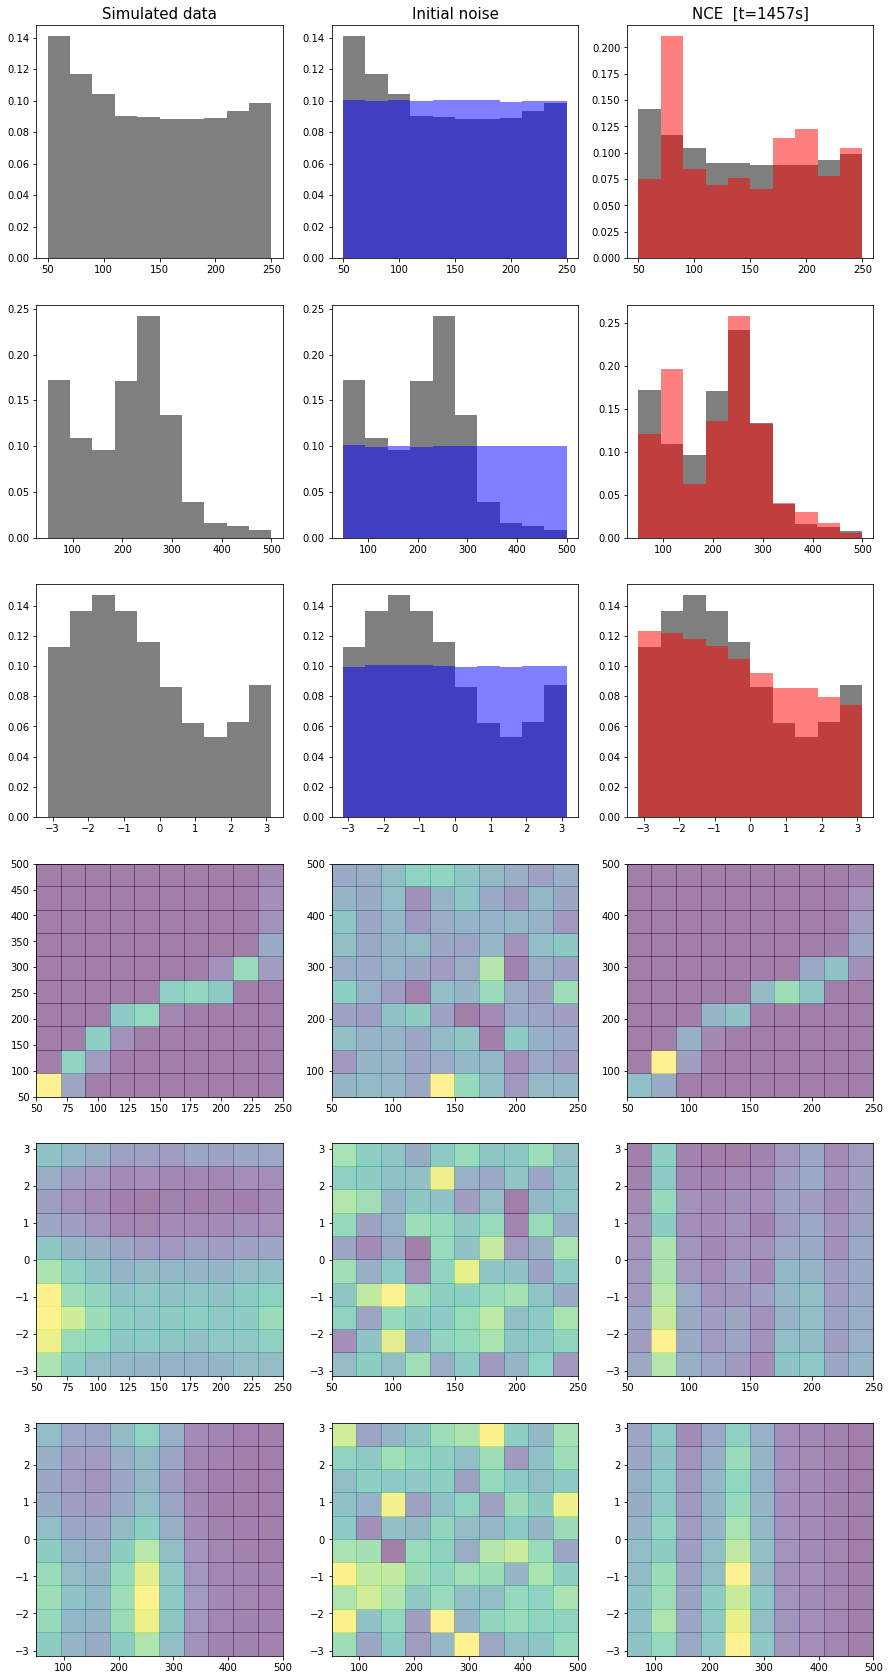

Adding 5.00% of initial noise back in
500000 noise datapoints provided
14.62% are useful (weight is > 1% of the mean)


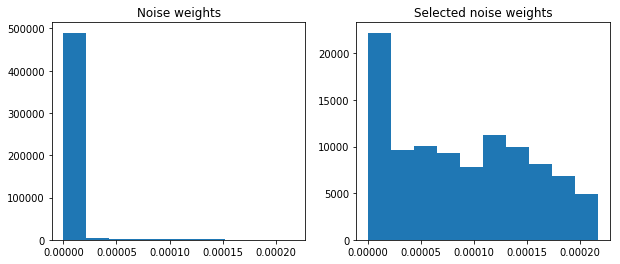

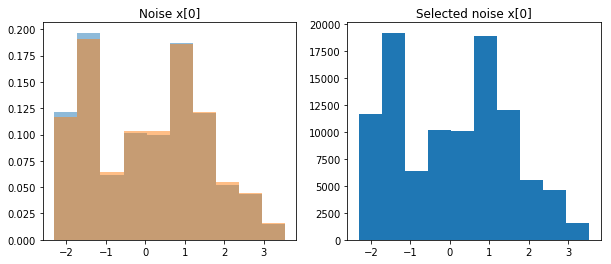

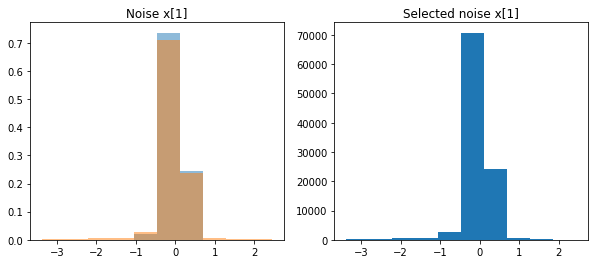

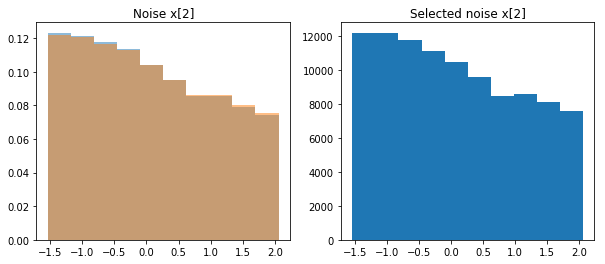

Creating discriminator with 3 observables and None conditions
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                200       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 50)                0         
_________________________________________________________

Epoch 56/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2521e-06 - val_loss: 9.2240e-06
Epoch 57/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2564e-06 - val_loss: 9.2239e-06
Epoch 58/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2478e-06 - val_loss: 9.2237e-06
Epoch 59/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2557e-06 - val_loss: 9.2236e-06
Epoch 60/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2523e-06 - val_loss: 9.2235e-06
Epoch 61/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2522e-06 - val_loss: 9.2234e-06
Epoch 62/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2543e-06 - val_loss: 9.2233e-06
Epoch 63/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2516e-06 - val_loss: 9.2232e-06
Epoch 64/10000
75000/75000 [==============================] - 0s 3us/ste

Epoch 127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2491e-06 - val_loss: 9.2167e-06
Epoch 128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2469e-06 - val_loss: 9.2166e-06
Epoch 129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2480e-06 - val_loss: 9.2165e-06
Epoch 130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2466e-06 - val_loss: 9.2164e-06
Epoch 131/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2448e-06 - val_loss: 9.2163e-06
Epoch 132/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2467e-06 - val_loss: 9.2162e-06
Epoch 133/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2500e-06 - val_loss: 9.2161e-06
Epoch 134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2446e-06 - val_loss: 9.2160e-06
Epoch 135/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2415e-06 - val_loss: 9.2099e-06
Epoch 198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2413e-06 - val_loss: 9.2098e-06
Epoch 199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2403e-06 - val_loss: 9.2097e-06
Epoch 200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2411e-06 - val_loss: 9.2096e-06
Epoch 201/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2391e-06 - val_loss: 9.2095e-06
Epoch 202/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2400e-06 - val_loss: 9.2094e-06
Epoch 203/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2390e-06 - val_loss: 9.2093e-06
Epoch 204/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2402e-06 - val_loss: 9.2092e-06
Epoch 205/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2358e-06 - val_loss: 9.2035e-06
Epoch 269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2326e-06 - val_loss: 9.2034e-06
Epoch 270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2340e-06 - val_loss: 9.2034e-06
Epoch 271/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2336e-06 - val_loss: 9.2033e-06
Epoch 272/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2378e-06 - val_loss: 9.2032e-06
Epoch 273/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2322e-06 - val_loss: 9.2031e-06
Epoch 274/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2367e-06 - val_loss: 9.2030e-06
Epoch 275/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2330e-06 - val_loss: 9.2029e-06
Epoch 276/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2290e-06 - val_loss: 9.1982e-06
Epoch 339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2315e-06 - val_loss: 9.1981e-06
Epoch 340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2303e-06 - val_loss: 9.1980e-06
Epoch 341/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2268e-06 - val_loss: 9.1980e-06
Epoch 342/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2297e-06 - val_loss: 9.1979e-06
Epoch 343/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2299e-06 - val_loss: 9.1978e-06
Epoch 344/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2287e-06 - val_loss: 9.1977e-06
Epoch 345/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2305e-06 - val_loss: 9.1977e-06
Epoch 346/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2245e-06 - val_loss: 9.1934e-06
Epoch 410/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2244e-06 - val_loss: 9.1933e-06
Epoch 411/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2249e-06 - val_loss: 9.1933e-06
Epoch 412/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2239e-06 - val_loss: 9.1932e-06
Epoch 413/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2253e-06 - val_loss: 9.1931e-06
Epoch 414/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2278e-06 - val_loss: 9.1931e-06
Epoch 415/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2232e-06 - val_loss: 9.1930e-06
Epoch 416/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2240e-06 - val_loss: 9.1929e-06
Epoch 417/10000
75000/75000 [==============================] - 0

Epoch 480/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2235e-06 - val_loss: 9.1890e-06
Epoch 481/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2212e-06 - val_loss: 9.1889e-06
Epoch 482/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2208e-06 - val_loss: 9.1888e-06
Epoch 483/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2182e-06 - val_loss: 9.1888e-06
Epoch 484/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2195e-06 - val_loss: 9.1887e-06
Epoch 485/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2204e-06 - val_loss: 9.1887e-06
Epoch 486/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2214e-06 - val_loss: 9.1886e-06
Epoch 487/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2190e-06 - val_loss: 9.1885e-06
Epoch 488/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2179e-06 - val_loss: 9.1849e-06
Epoch 551/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2167e-06 - val_loss: 9.1848e-06
Epoch 552/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2207e-06 - val_loss: 9.1847e-06
Epoch 553/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2186e-06 - val_loss: 9.1847e-06
Epoch 554/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2167e-06 - val_loss: 9.1846e-06
Epoch 555/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2179e-06 - val_loss: 9.1846e-06
Epoch 556/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2170e-06 - val_loss: 9.1845e-06
Epoch 557/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2181e-06 - val_loss: 9.1845e-06
Epoch 558/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 621/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2143e-06 - val_loss: 9.1808e-06
Epoch 622/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2121e-06 - val_loss: 9.1808e-06
Epoch 623/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2146e-06 - val_loss: 9.1807e-06
Epoch 624/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2147e-06 - val_loss: 9.1807e-06
Epoch 625/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2139e-06 - val_loss: 9.1806e-06
Epoch 626/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2124e-06 - val_loss: 9.1806e-06
Epoch 627/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2191e-06 - val_loss: 9.1805e-06
Epoch 628/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2122e-06 - val_loss: 9.1804e-06
Epoch 629/10000
75000/75000 [==============================] - 0

Epoch 692/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2112e-06 - val_loss: 9.1769e-06
Epoch 693/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2142e-06 - val_loss: 9.1768e-06
Epoch 694/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2132e-06 - val_loss: 9.1767e-06
Epoch 695/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2099e-06 - val_loss: 9.1767e-06
Epoch 696/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2078e-06 - val_loss: 9.1766e-06
Epoch 697/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2087e-06 - val_loss: 9.1766e-06
Epoch 698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2124e-06 - val_loss: 9.1765e-06
Epoch 699/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2107e-06 - val_loss: 9.1765e-06
Epoch 700/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2107e-06 - val_loss: 9.1731e-06
Epoch 763/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2044e-06 - val_loss: 9.1731e-06
Epoch 764/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2032e-06 - val_loss: 9.1730e-06
Epoch 765/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2070e-06 - val_loss: 9.1730e-06
Epoch 766/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2077e-06 - val_loss: 9.1729e-06
Epoch 767/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2080e-06 - val_loss: 9.1729e-06
Epoch 768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2053e-06 - val_loss: 9.1728e-06
Epoch 769/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2085e-06 - val_loss: 9.1728e-06
Epoch 770/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 833/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2051e-06 - val_loss: 9.1694e-06
Epoch 834/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2017e-06 - val_loss: 9.1694e-06
Epoch 835/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2039e-06 - val_loss: 9.1693e-06
Epoch 836/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2035e-06 - val_loss: 9.1693e-06
Epoch 837/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2036e-06 - val_loss: 9.1692e-06
Epoch 838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2040e-06 - val_loss: 9.1692e-06
Epoch 839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2048e-06 - val_loss: 9.1691e-06
Epoch 840/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2027e-06 - val_loss: 9.1691e-06
Epoch 841/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.1995e-06 - val_loss: 9.1658e-06
Epoch 904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1985e-06 - val_loss: 9.1657e-06
Epoch 905/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2022e-06 - val_loss: 9.1657e-06
Epoch 906/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2001e-06 - val_loss: 9.1656e-06
Epoch 907/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2004e-06 - val_loss: 9.1656e-06
Epoch 908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2014e-06 - val_loss: 9.1655e-06
Epoch 909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2002e-06 - val_loss: 9.1655e-06
Epoch 910/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2002e-06 - val_loss: 9.1654e-06
Epoch 911/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 974/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1954e-06 - val_loss: 9.1621e-06
Epoch 975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1966e-06 - val_loss: 9.1620e-06
Epoch 976/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1976e-06 - val_loss: 9.1619e-06
Epoch 977/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1979e-06 - val_loss: 9.1619e-06
Epoch 978/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1947e-06 - val_loss: 9.1618e-06
Epoch 979/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1951e-06 - val_loss: 9.1618e-06
Epoch 980/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1964e-06 - val_loss: 9.1617e-06
Epoch 981/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1956e-06 - val_loss: 9.1617e-06
Epoch 982/10000
75000/75000 [==============================] - 0

Epoch 1044/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1940e-06 - val_loss: 9.1583e-06
Epoch 1045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1960e-06 - val_loss: 9.1582e-06
Epoch 1046/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1923e-06 - val_loss: 9.1582e-06
Epoch 1047/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1933e-06 - val_loss: 9.1581e-06
Epoch 1048/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1891e-06 - val_loss: 9.1581e-06
Epoch 1049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1944e-06 - val_loss: 9.1580e-06
Epoch 1050/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1936e-06 - val_loss: 9.1579e-06
Epoch 1051/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1938e-06 - val_loss: 9.1579e-06
Epoch 1052/10000
75000/75000 [==========================

Epoch 1114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1898e-06 - val_loss: 9.1544e-06
Epoch 1115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1884e-06 - val_loss: 9.1543e-06
Epoch 1116/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1917e-06 - val_loss: 9.1543e-06
Epoch 1117/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1893e-06 - val_loss: 9.1542e-06
Epoch 1118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1877e-06 - val_loss: 9.1541e-06
Epoch 1119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1910e-06 - val_loss: 9.1541e-06
Epoch 1120/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1912e-06 - val_loss: 9.1540e-06
Epoch 1121/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1890e-06 - val_loss: 9.1540e-06
Epoch 1122/10000
75000/75000 [==========================

Epoch 1184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1882e-06 - val_loss: 9.1504e-06
Epoch 1185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1868e-06 - val_loss: 9.1503e-06
Epoch 1186/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1876e-06 - val_loss: 9.1503e-06
Epoch 1187/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1843e-06 - val_loss: 9.1502e-06
Epoch 1188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1849e-06 - val_loss: 9.1502e-06
Epoch 1189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1858e-06 - val_loss: 9.1501e-06
Epoch 1190/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1899e-06 - val_loss: 9.1501e-06
Epoch 1191/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1828e-06 - val_loss: 9.1500e-06
Epoch 1192/10000
75000/75000 [==========================

Epoch 1254/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1809e-06 - val_loss: 9.1463e-06
Epoch 1255/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1855e-06 - val_loss: 9.1463e-06
Epoch 1256/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1869e-06 - val_loss: 9.1462e-06
Epoch 1257/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1863e-06 - val_loss: 9.1462e-06
Epoch 1258/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1821e-06 - val_loss: 9.1461e-06
Epoch 1259/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1833e-06 - val_loss: 9.1460e-06
Epoch 1260/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1832e-06 - val_loss: 9.1460e-06
Epoch 1261/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1864e-06 - val_loss: 9.1459e-06
Epoch 1262/10000
75000/75000 [==========================

Epoch 1324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1809e-06 - val_loss: 9.1421e-06
Epoch 1325/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1770e-06 - val_loss: 9.1420e-06
Epoch 1326/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1797e-06 - val_loss: 9.1419e-06
Epoch 1327/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1780e-06 - val_loss: 9.1419e-06
Epoch 1328/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1784e-06 - val_loss: 9.1418e-06
Epoch 1329/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1771e-06 - val_loss: 9.1417e-06
Epoch 1330/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1791e-06 - val_loss: 9.1417e-06
Epoch 1331/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1795e-06 - val_loss: 9.1416e-06
Epoch 1332/10000
75000/75000 [==========================

Epoch 1394/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1765e-06 - val_loss: 9.1377e-06
Epoch 1395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1750e-06 - val_loss: 9.1377e-06
Epoch 1396/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1745e-06 - val_loss: 9.1376e-06
Epoch 1397/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1787e-06 - val_loss: 9.1376e-06
Epoch 1398/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1711e-06 - val_loss: 9.1375e-06
Epoch 1399/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1753e-06 - val_loss: 9.1374e-06
Epoch 1400/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1821e-06 - val_loss: 9.1374e-06
Epoch 1401/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1770e-06 - val_loss: 9.1373e-06
Epoch 1402/10000
75000/75000 [==========================

Epoch 1464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1708e-06 - val_loss: 9.1332e-06
Epoch 1465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1765e-06 - val_loss: 9.1331e-06
Epoch 1466/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1701e-06 - val_loss: 9.1331e-06
Epoch 1467/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1749e-06 - val_loss: 9.1330e-06
Epoch 1468/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1742e-06 - val_loss: 9.1329e-06
Epoch 1469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1726e-06 - val_loss: 9.1329e-06
Epoch 1470/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1711e-06 - val_loss: 9.1328e-06
Epoch 1471/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1751e-06 - val_loss: 9.1328e-06
Epoch 1472/10000
75000/75000 [==========================

Epoch 1534/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1680e-06 - val_loss: 9.1286e-06
Epoch 1535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1713e-06 - val_loss: 9.1286e-06
Epoch 1536/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1706e-06 - val_loss: 9.1285e-06
Epoch 1537/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1699e-06 - val_loss: 9.1285e-06
Epoch 1538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1727e-06 - val_loss: 9.1284e-06
Epoch 1539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1664e-06 - val_loss: 9.1283e-06
Epoch 1540/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1697e-06 - val_loss: 9.1283e-06
Epoch 1541/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1690e-06 - val_loss: 9.1282e-06
Epoch 1542/10000
75000/75000 [==========================

Epoch 1604/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1687e-06 - val_loss: 9.1239e-06
Epoch 1605/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1695e-06 - val_loss: 9.1239e-06
Epoch 1606/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1667e-06 - val_loss: 9.1238e-06
Epoch 1607/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1625e-06 - val_loss: 9.1237e-06
Epoch 1608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1658e-06 - val_loss: 9.1236e-06
Epoch 1609/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1661e-06 - val_loss: 9.1236e-06
Epoch 1610/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1677e-06 - val_loss: 9.1235e-06
Epoch 1611/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1632e-06 - val_loss: 9.1234e-06
Epoch 1612/10000
75000/75000 [==========================

Epoch 1674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1634e-06 - val_loss: 9.1188e-06
Epoch 1675/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1606e-06 - val_loss: 9.1187e-06
Epoch 1676/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1575e-06 - val_loss: 9.1186e-06
Epoch 1677/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1626e-06 - val_loss: 9.1186e-06
Epoch 1678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1609e-06 - val_loss: 9.1185e-06
Epoch 1679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1635e-06 - val_loss: 9.1184e-06
Epoch 1680/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1595e-06 - val_loss: 9.1183e-06
Epoch 1681/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1625e-06 - val_loss: 9.1182e-06
Epoch 1682/10000
75000/75000 [==========================

Epoch 1744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1535e-06 - val_loss: 9.1133e-06
Epoch 1745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1606e-06 - val_loss: 9.1132e-06
Epoch 1746/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1591e-06 - val_loss: 9.1131e-06
Epoch 1747/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1562e-06 - val_loss: 9.1130e-06
Epoch 1748/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1548e-06 - val_loss: 9.1129e-06
Epoch 1749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1609e-06 - val_loss: 9.1128e-06
Epoch 1750/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1607e-06 - val_loss: 9.1128e-06
Epoch 1751/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1566e-06 - val_loss: 9.1127e-06
Epoch 1752/10000
75000/75000 [==========================

Epoch 1814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1527e-06 - val_loss: 9.1074e-06
Epoch 1815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1513e-06 - val_loss: 9.1073e-06
Epoch 1816/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1513e-06 - val_loss: 9.1072e-06
Epoch 1817/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1534e-06 - val_loss: 9.1072e-06
Epoch 1818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1528e-06 - val_loss: 9.1071e-06
Epoch 1819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1520e-06 - val_loss: 9.1070e-06
Epoch 1820/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1527e-06 - val_loss: 9.1069e-06
Epoch 1821/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1511e-06 - val_loss: 9.1069e-06
Epoch 1822/10000
75000/75000 [==========================

Epoch 1884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1535e-06 - val_loss: 9.1021e-06
Epoch 1885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1564e-06 - val_loss: 9.1020e-06
Epoch 1886/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1516e-06 - val_loss: 9.1019e-06
Epoch 1887/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.1018e-06
Epoch 1888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1510e-06 - val_loss: 9.1017e-06
Epoch 1889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1528e-06 - val_loss: 9.1017e-06
Epoch 1890/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1466e-06 - val_loss: 9.1016e-06
Epoch 1891/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1511e-06 - val_loss: 9.1015e-06
Epoch 1892/10000
75000/75000 [==========================

Epoch 1954/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1461e-06 - val_loss: 9.0966e-06
Epoch 1955/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1442e-06 - val_loss: 9.0965e-06
Epoch 1956/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1457e-06 - val_loss: 9.0964e-06
Epoch 1957/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1472e-06 - val_loss: 9.0963e-06
Epoch 1958/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1430e-06 - val_loss: 9.0963e-06
Epoch 1959/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1436e-06 - val_loss: 9.0962e-06
Epoch 1960/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1460e-06 - val_loss: 9.0961e-06
Epoch 1961/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.0960e-06
Epoch 1962/10000
75000/75000 [==========================

Epoch 2024/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1441e-06 - val_loss: 9.0911e-06
Epoch 2025/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1417e-06 - val_loss: 9.0910e-06
Epoch 2026/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1401e-06 - val_loss: 9.0909e-06
Epoch 2027/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1430e-06 - val_loss: 9.0908e-06
Epoch 2028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1423e-06 - val_loss: 9.0908e-06
Epoch 2029/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1419e-06 - val_loss: 9.0907e-06
Epoch 2030/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1429e-06 - val_loss: 9.0906e-06
Epoch 2031/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1389e-06 - val_loss: 9.0905e-06
Epoch 2032/10000
75000/75000 [==========================

Epoch 2094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1389e-06 - val_loss: 9.0853e-06
Epoch 2095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1395e-06 - val_loss: 9.0852e-06
Epoch 2096/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1359e-06 - val_loss: 9.0852e-06
Epoch 2097/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1349e-06 - val_loss: 9.0851e-06
Epoch 2098/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1391e-06 - val_loss: 9.0850e-06
Epoch 2099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1388e-06 - val_loss: 9.0849e-06
Epoch 2100/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1351e-06 - val_loss: 9.0848e-06
Epoch 2101/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1366e-06 - val_loss: 9.0847e-06
Epoch 2102/10000
75000/75000 [==========================

Epoch 2164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1335e-06 - val_loss: 9.0793e-06
Epoch 2165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1373e-06 - val_loss: 9.0792e-06
Epoch 2166/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1304e-06 - val_loss: 9.0791e-06
Epoch 2167/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1264e-06 - val_loss: 9.0791e-06
Epoch 2168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1268e-06 - val_loss: 9.0790e-06
Epoch 2169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1339e-06 - val_loss: 9.0789e-06
Epoch 2170/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1313e-06 - val_loss: 9.0788e-06
Epoch 2171/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1305e-06 - val_loss: 9.0787e-06
Epoch 2172/10000
75000/75000 [==========================

Epoch 2234/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1242e-06 - val_loss: 9.0732e-06
Epoch 2235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1282e-06 - val_loss: 9.0731e-06
Epoch 2236/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1270e-06 - val_loss: 9.0730e-06
Epoch 2237/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1242e-06 - val_loss: 9.0729e-06
Epoch 2238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1312e-06 - val_loss: 9.0728e-06
Epoch 2239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1291e-06 - val_loss: 9.0727e-06
Epoch 2240/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1262e-06 - val_loss: 9.0727e-06
Epoch 2241/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1314e-06 - val_loss: 9.0726e-06
Epoch 2242/10000
75000/75000 [==========================

Epoch 2304/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1259e-06 - val_loss: 9.0670e-06
Epoch 2305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1193e-06 - val_loss: 9.0669e-06
Epoch 2306/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1216e-06 - val_loss: 9.0668e-06
Epoch 2307/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1229e-06 - val_loss: 9.0668e-06
Epoch 2308/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1261e-06 - val_loss: 9.0667e-06
Epoch 2309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1238e-06 - val_loss: 9.0666e-06
Epoch 2310/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1206e-06 - val_loss: 9.0665e-06
Epoch 2311/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1172e-06 - val_loss: 9.0664e-06
Epoch 2312/10000
75000/75000 [==========================

Epoch 2374/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1229e-06 - val_loss: 9.0608e-06
Epoch 2375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1173e-06 - val_loss: 9.0607e-06
Epoch 2376/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1181e-06 - val_loss: 9.0606e-06
Epoch 2377/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1176e-06 - val_loss: 9.0605e-06
Epoch 2378/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1191e-06 - val_loss: 9.0605e-06
Epoch 2379/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1153e-06 - val_loss: 9.0604e-06
Epoch 2380/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1152e-06 - val_loss: 9.0603e-06
Epoch 2381/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1185e-06 - val_loss: 9.0602e-06
Epoch 2382/10000
75000/75000 [==========================

Epoch 2444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1167e-06 - val_loss: 9.0547e-06
Epoch 2445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1138e-06 - val_loss: 9.0546e-06
Epoch 2446/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1125e-06 - val_loss: 9.0545e-06
Epoch 2447/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1189e-06 - val_loss: 9.0545e-06
Epoch 2448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1134e-06 - val_loss: 9.0544e-06
Epoch 2449/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1141e-06 - val_loss: 9.0543e-06
Epoch 2450/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1131e-06 - val_loss: 9.0542e-06
Epoch 2451/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1116e-06 - val_loss: 9.0541e-06
Epoch 2452/10000
75000/75000 [==========================

Epoch 2514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1074e-06 - val_loss: 9.0487e-06
Epoch 2515/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1080e-06 - val_loss: 9.0486e-06
Epoch 2516/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1021e-06 - val_loss: 9.0485e-06
Epoch 2517/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1073e-06 - val_loss: 9.0484e-06
Epoch 2518/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1067e-06 - val_loss: 9.0483e-06
Epoch 2519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1088e-06 - val_loss: 9.0482e-06
Epoch 2520/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1101e-06 - val_loss: 9.0481e-06
Epoch 2521/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1090e-06 - val_loss: 9.0480e-06
Epoch 2522/10000
75000/75000 [==========================

Epoch 2584/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1051e-06 - val_loss: 9.0423e-06
Epoch 2585/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1071e-06 - val_loss: 9.0422e-06
Epoch 2586/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1088e-06 - val_loss: 9.0421e-06
Epoch 2587/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1086e-06 - val_loss: 9.0420e-06
Epoch 2588/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1085e-06 - val_loss: 9.0420e-06
Epoch 2589/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1043e-06 - val_loss: 9.0419e-06
Epoch 2590/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1002e-06 - val_loss: 9.0418e-06
Epoch 2591/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1036e-06 - val_loss: 9.0417e-06
Epoch 2592/10000
75000/75000 [==========================

Epoch 2654/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0985e-06 - val_loss: 9.0363e-06
Epoch 2655/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1002e-06 - val_loss: 9.0362e-06
Epoch 2656/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1020e-06 - val_loss: 9.0361e-06
Epoch 2657/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0992e-06 - val_loss: 9.0360e-06
Epoch 2658/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1014e-06 - val_loss: 9.0359e-06
Epoch 2659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1034e-06 - val_loss: 9.0358e-06
Epoch 2660/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0989e-06 - val_loss: 9.0357e-06
Epoch 2661/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1008e-06 - val_loss: 9.0357e-06
Epoch 2662/10000
75000/75000 [==========================

Epoch 2724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0957e-06 - val_loss: 9.0303e-06
Epoch 2725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0956e-06 - val_loss: 9.0303e-06
Epoch 2726/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0910e-06 - val_loss: 9.0302e-06
Epoch 2727/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0994e-06 - val_loss: 9.0301e-06
Epoch 2728/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0966e-06 - val_loss: 9.0300e-06
Epoch 2729/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0949e-06 - val_loss: 9.0299e-06
Epoch 2730/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0939e-06 - val_loss: 9.0298e-06
Epoch 2731/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0968e-06 - val_loss: 9.0298e-06
Epoch 2732/10000
75000/75000 [==========================

Epoch 2794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0904e-06 - val_loss: 9.0244e-06
Epoch 2795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0893e-06 - val_loss: 9.0243e-06
Epoch 2796/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0863e-06 - val_loss: 9.0242e-06
Epoch 2797/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0901e-06 - val_loss: 9.0241e-06
Epoch 2798/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0850e-06 - val_loss: 9.0241e-06
Epoch 2799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0913e-06 - val_loss: 9.0240e-06
Epoch 2800/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0880e-06 - val_loss: 9.0239e-06
Epoch 2801/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0868e-06 - val_loss: 9.0238e-06
Epoch 2802/10000
75000/75000 [==========================

Epoch 2864/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0792e-06 - val_loss: 9.0185e-06
Epoch 2865/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0841e-06 - val_loss: 9.0185e-06
Epoch 2866/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0796e-06 - val_loss: 9.0184e-06
Epoch 2867/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0837e-06 - val_loss: 9.0183e-06
Epoch 2868/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0869e-06 - val_loss: 9.0182e-06
Epoch 2869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0852e-06 - val_loss: 9.0181e-06
Epoch 2870/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0866e-06 - val_loss: 9.0180e-06
Epoch 2871/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0887e-06 - val_loss: 9.0180e-06
Epoch 2872/10000
75000/75000 [==========================

Epoch 2934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0774e-06 - val_loss: 9.0127e-06
Epoch 2935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0815e-06 - val_loss: 9.0126e-06
Epoch 2936/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0780e-06 - val_loss: 9.0126e-06
Epoch 2937/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0862e-06 - val_loss: 9.0125e-06
Epoch 2938/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0751e-06 - val_loss: 9.0124e-06
Epoch 2939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0808e-06 - val_loss: 9.0123e-06
Epoch 2940/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0832e-06 - val_loss: 9.0122e-06
Epoch 2941/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0766e-06 - val_loss: 9.0122e-06
Epoch 2942/10000
75000/75000 [==========================

Epoch 3004/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0715e-06 - val_loss: 9.0069e-06
Epoch 3005/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0790e-06 - val_loss: 9.0068e-06
Epoch 3006/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0728e-06 - val_loss: 9.0067e-06
Epoch 3007/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0759e-06 - val_loss: 9.0066e-06
Epoch 3008/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0727e-06 - val_loss: 9.0066e-06
Epoch 3009/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0755e-06 - val_loss: 9.0065e-06
Epoch 3010/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0716e-06 - val_loss: 9.0064e-06
Epoch 3011/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0761e-06 - val_loss: 9.0063e-06
Epoch 3012/10000
75000/75000 [==========================

Epoch 3074/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0721e-06 - val_loss: 9.0010e-06
Epoch 3075/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0756e-06 - val_loss: 9.0009e-06
Epoch 3076/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0690e-06 - val_loss: 9.0008e-06
Epoch 3077/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0697e-06 - val_loss: 9.0007e-06
Epoch 3078/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0742e-06 - val_loss: 9.0006e-06
Epoch 3079/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0746e-06 - val_loss: 9.0005e-06
Epoch 3080/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0752e-06 - val_loss: 9.0004e-06
Epoch 3081/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0677e-06 - val_loss: 9.0003e-06
Epoch 3082/10000
75000/75000 [==========================

Epoch 3144/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0654e-06 - val_loss: 8.9951e-06
Epoch 3145/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0666e-06 - val_loss: 8.9950e-06
Epoch 3146/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0634e-06 - val_loss: 8.9949e-06
Epoch 3147/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0631e-06 - val_loss: 8.9948e-06
Epoch 3148/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0652e-06 - val_loss: 8.9947e-06
Epoch 3149/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0620e-06 - val_loss: 8.9946e-06
Epoch 3150/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0705e-06 - val_loss: 8.9945e-06
Epoch 3151/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0673e-06 - val_loss: 8.9944e-06
Epoch 3152/10000
75000/75000 [==========================

Epoch 3214/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0605e-06 - val_loss: 8.9890e-06
Epoch 3215/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0650e-06 - val_loss: 8.9889e-06
Epoch 3216/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0627e-06 - val_loss: 8.9888e-06
Epoch 3217/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0661e-06 - val_loss: 8.9887e-06
Epoch 3218/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0639e-06 - val_loss: 8.9886e-06
Epoch 3219/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0619e-06 - val_loss: 8.9885e-06
Epoch 3220/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0644e-06 - val_loss: 8.9885e-06
Epoch 3221/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0606e-06 - val_loss: 8.9884e-06
Epoch 3222/10000
75000/75000 [==========================

Epoch 3284/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0587e-06 - val_loss: 8.9830e-06
Epoch 3285/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0614e-06 - val_loss: 8.9830e-06
Epoch 3286/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0628e-06 - val_loss: 8.9829e-06
Epoch 3287/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0552e-06 - val_loss: 8.9828e-06
Epoch 3288/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0594e-06 - val_loss: 8.9827e-06
Epoch 3289/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0589e-06 - val_loss: 8.9827e-06
Epoch 3290/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0583e-06 - val_loss: 8.9826e-06
Epoch 3291/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0662e-06 - val_loss: 8.9825e-06
Epoch 3292/10000
75000/75000 [==========================

Epoch 3354/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0533e-06 - val_loss: 8.9777e-06
Epoch 3355/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0547e-06 - val_loss: 8.9776e-06
Epoch 3356/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0584e-06 - val_loss: 8.9775e-06
Epoch 3357/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0479e-06 - val_loss: 8.9774e-06
Epoch 3358/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0520e-06 - val_loss: 8.9774e-06
Epoch 3359/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0545e-06 - val_loss: 8.9773e-06
Epoch 3360/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0560e-06 - val_loss: 8.9772e-06
Epoch 3361/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0525e-06 - val_loss: 8.9771e-06
Epoch 3362/10000
75000/75000 [==========================

Epoch 3424/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0456e-06 - val_loss: 8.9720e-06
Epoch 3425/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0521e-06 - val_loss: 8.9720e-06
Epoch 3426/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0539e-06 - val_loss: 8.9719e-06
Epoch 3427/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0479e-06 - val_loss: 8.9718e-06
Epoch 3428/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0486e-06 - val_loss: 8.9717e-06
Epoch 3429/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0457e-06 - val_loss: 8.9716e-06
Epoch 3430/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0487e-06 - val_loss: 8.9716e-06
Epoch 3431/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0520e-06 - val_loss: 8.9715e-06
Epoch 3432/10000
75000/75000 [==========================

Epoch 3494/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0414e-06 - val_loss: 8.9666e-06
Epoch 3495/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0417e-06 - val_loss: 8.9666e-06
Epoch 3496/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0423e-06 - val_loss: 8.9665e-06
Epoch 3497/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0459e-06 - val_loss: 8.9664e-06
Epoch 3498/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0419e-06 - val_loss: 8.9663e-06
Epoch 3499/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0411e-06 - val_loss: 8.9663e-06
Epoch 3500/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0448e-06 - val_loss: 8.9662e-06
Epoch 3501/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0415e-06 - val_loss: 8.9661e-06
Epoch 3502/10000
75000/75000 [==========================

Epoch 3564/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0453e-06 - val_loss: 8.9613e-06
Epoch 3565/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0458e-06 - val_loss: 8.9613e-06
Epoch 3566/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0361e-06 - val_loss: 8.9612e-06
Epoch 3567/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0440e-06 - val_loss: 8.9611e-06
Epoch 3568/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0411e-06 - val_loss: 8.9610e-06
Epoch 3569/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0442e-06 - val_loss: 8.9610e-06
Epoch 3570/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0374e-06 - val_loss: 8.9609e-06
Epoch 3571/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0420e-06 - val_loss: 8.9608e-06
Epoch 3572/10000
75000/75000 [==========================

Epoch 3634/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0352e-06 - val_loss: 8.9562e-06
Epoch 3635/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0407e-06 - val_loss: 8.9562e-06
Epoch 3636/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0438e-06 - val_loss: 8.9561e-06
Epoch 3637/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0393e-06 - val_loss: 8.9560e-06
Epoch 3638/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0348e-06 - val_loss: 8.9560e-06
Epoch 3639/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0369e-06 - val_loss: 8.9559e-06
Epoch 3640/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0300e-06 - val_loss: 8.9558e-06
Epoch 3641/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0325e-06 - val_loss: 8.9557e-06
Epoch 3642/10000
75000/75000 [==========================

Epoch 3704/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0351e-06 - val_loss: 8.9512e-06
Epoch 3705/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0338e-06 - val_loss: 8.9511e-06
Epoch 3706/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0255e-06 - val_loss: 8.9510e-06
Epoch 3707/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0321e-06 - val_loss: 8.9510e-06
Epoch 3708/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0261e-06 - val_loss: 8.9509e-06
Epoch 3709/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0339e-06 - val_loss: 8.9508e-06
Epoch 3710/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0300e-06 - val_loss: 8.9507e-06
Epoch 3711/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0376e-06 - val_loss: 8.9506e-06
Epoch 3712/10000
75000/75000 [==========================

Epoch 3774/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0331e-06 - val_loss: 8.9463e-06
Epoch 3775/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0201e-06 - val_loss: 8.9462e-06
Epoch 3776/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0310e-06 - val_loss: 8.9462e-06
Epoch 3777/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0199e-06 - val_loss: 8.9461e-06
Epoch 3778/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0274e-06 - val_loss: 8.9460e-06
Epoch 3779/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0308e-06 - val_loss: 8.9459e-06
Epoch 3780/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0278e-06 - val_loss: 8.9459e-06
Epoch 3781/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0303e-06 - val_loss: 8.9458e-06
Epoch 3782/10000
75000/75000 [==========================

Epoch 3844/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0239e-06 - val_loss: 8.9411e-06
Epoch 3845/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0238e-06 - val_loss: 8.9410e-06
Epoch 3846/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0265e-06 - val_loss: 8.9410e-06
Epoch 3847/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0319e-06 - val_loss: 8.9409e-06
Epoch 3848/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0244e-06 - val_loss: 8.9408e-06
Epoch 3849/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0248e-06 - val_loss: 8.9407e-06
Epoch 3850/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0274e-06 - val_loss: 8.9407e-06
Epoch 3851/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0220e-06 - val_loss: 8.9406e-06
Epoch 3852/10000
75000/75000 [==========================

Epoch 3914/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0155e-06 - val_loss: 8.9363e-06
Epoch 3915/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0170e-06 - val_loss: 8.9362e-06
Epoch 3916/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0250e-06 - val_loss: 8.9361e-06
Epoch 3917/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0169e-06 - val_loss: 8.9361e-06
Epoch 3918/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0183e-06 - val_loss: 8.9360e-06
Epoch 3919/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0175e-06 - val_loss: 8.9359e-06
Epoch 3920/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0168e-06 - val_loss: 8.9359e-06
Epoch 3921/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0194e-06 - val_loss: 8.9358e-06
Epoch 3922/10000
75000/75000 [==========================

Epoch 3984/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0218e-06 - val_loss: 8.9314e-06
Epoch 3985/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0165e-06 - val_loss: 8.9314e-06
Epoch 3986/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0235e-06 - val_loss: 8.9313e-06
Epoch 3987/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0091e-06 - val_loss: 8.9313e-06
Epoch 3988/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0171e-06 - val_loss: 8.9312e-06
Epoch 3989/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0232e-06 - val_loss: 8.9311e-06
Epoch 3990/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0196e-06 - val_loss: 8.9311e-06
Epoch 3991/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0216e-06 - val_loss: 8.9310e-06
Epoch 3992/10000
75000/75000 [==========================

Epoch 4054/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0080e-06 - val_loss: 8.9270e-06
Epoch 4055/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0172e-06 - val_loss: 8.9269e-06
Epoch 4056/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0137e-06 - val_loss: 8.9268e-06
Epoch 4057/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0093e-06 - val_loss: 8.9267e-06
Epoch 4058/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0179e-06 - val_loss: 8.9267e-06
Epoch 4059/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0118e-06 - val_loss: 8.9266e-06
Epoch 4060/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0108e-06 - val_loss: 8.9265e-06
Epoch 4061/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0084e-06 - val_loss: 8.9264e-06
Epoch 4062/10000
75000/75000 [==========================

Epoch 4124/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0102e-06 - val_loss: 8.9224e-06
Epoch 4125/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0076e-06 - val_loss: 8.9223e-06
Epoch 4126/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0055e-06 - val_loss: 8.9222e-06
Epoch 4127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0136e-06 - val_loss: 8.9222e-06
Epoch 4128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0132e-06 - val_loss: 8.9221e-06
Epoch 4129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0122e-06 - val_loss: 8.9220e-06
Epoch 4130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0113e-06 - val_loss: 8.9219e-06
Epoch 4131/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0075e-06 - val_loss: 8.9218e-06
Epoch 4132/10000
75000/75000 [==========================

Epoch 4194/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0045e-06 - val_loss: 8.9176e-06
Epoch 4195/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0066e-06 - val_loss: 8.9175e-06
Epoch 4196/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0085e-06 - val_loss: 8.9174e-06
Epoch 4197/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0094e-06 - val_loss: 8.9174e-06
Epoch 4198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0163e-06 - val_loss: 8.9173e-06
Epoch 4199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0049e-06 - val_loss: 8.9172e-06
Epoch 4200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0090e-06 - val_loss: 8.9172e-06
Epoch 4201/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0078e-06 - val_loss: 8.9171e-06
Epoch 4202/10000
75000/75000 [==========================

Epoch 4264/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0021e-06 - val_loss: 8.9131e-06
Epoch 4265/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0046e-06 - val_loss: 8.9131e-06
Epoch 4266/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0085e-06 - val_loss: 8.9130e-06
Epoch 4267/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0057e-06 - val_loss: 8.9129e-06
Epoch 4268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9981e-06 - val_loss: 8.9129e-06
Epoch 4269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0065e-06 - val_loss: 8.9128e-06
Epoch 4270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0044e-06 - val_loss: 8.9128e-06
Epoch 4271/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0030e-06 - val_loss: 8.9127e-06
Epoch 4272/10000
75000/75000 [==========================

Epoch 4334/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9980e-06 - val_loss: 8.9088e-06
Epoch 4335/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0026e-06 - val_loss: 8.9088e-06
Epoch 4336/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9989e-06 - val_loss: 8.9087e-06
Epoch 4337/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9995e-06 - val_loss: 8.9087e-06
Epoch 4338/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9969e-06 - val_loss: 8.9086e-06
Epoch 4339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0012e-06 - val_loss: 8.9085e-06
Epoch 4340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9984e-06 - val_loss: 8.9085e-06
Epoch 4341/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0020e-06 - val_loss: 8.9084e-06
Epoch 4342/10000
75000/75000 [==========================

Epoch 4404/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9968e-06 - val_loss: 8.9046e-06
Epoch 4405/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0008e-06 - val_loss: 8.9045e-06
Epoch 4406/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9969e-06 - val_loss: 8.9044e-06
Epoch 4407/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9958e-06 - val_loss: 8.9044e-06
Epoch 4408/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9992e-06 - val_loss: 8.9043e-06
Epoch 4409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0080e-06 - val_loss: 8.9042e-06
Epoch 4410/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9939e-06 - val_loss: 8.9042e-06
Epoch 4411/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9910e-06 - val_loss: 8.9041e-06
Epoch 4412/10000
75000/75000 [==========================

Epoch 4474/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9982e-06 - val_loss: 8.9007e-06
Epoch 4475/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9913e-06 - val_loss: 8.9007e-06
Epoch 4476/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9906e-06 - val_loss: 8.9006e-06
Epoch 4477/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9950e-06 - val_loss: 8.9006e-06
Epoch 4478/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9918e-06 - val_loss: 8.9005e-06
Epoch 4479/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9957e-06 - val_loss: 8.9004e-06
Epoch 4480/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9871e-06 - val_loss: 8.9004e-06
Epoch 4481/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9993e-06 - val_loss: 8.9003e-06
Epoch 4482/10000
75000/75000 [==========================

Epoch 4544/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9903e-06 - val_loss: 8.8971e-06
Epoch 4545/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9913e-06 - val_loss: 8.8971e-06
Epoch 4546/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9857e-06 - val_loss: 8.8970e-06
Epoch 4547/10000
75000/75000 [==============================] - 0s 4us/step - loss: 8.9898e-06 - val_loss: 8.8970e-06
Epoch 4548/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9822e-06 - val_loss: 8.8969e-06
Epoch 4549/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9883e-06 - val_loss: 8.8969e-06
Epoch 4550/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9978e-06 - val_loss: 8.8968e-06
Epoch 4551/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9912e-06 - val_loss: 8.8968e-06
Epoch 4552/10000
75000/75000 [==========================

Epoch 4614/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9847e-06 - val_loss: 8.8937e-06
Epoch 4615/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9937e-06 - val_loss: 8.8936e-06
Epoch 4616/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9883e-06 - val_loss: 8.8936e-06
Epoch 4617/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9903e-06 - val_loss: 8.8935e-06
Epoch 4618/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9945e-06 - val_loss: 8.8935e-06
Epoch 4619/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9914e-06 - val_loss: 8.8934e-06
Epoch 4620/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9889e-06 - val_loss: 8.8934e-06
Epoch 4621/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9879e-06 - val_loss: 8.8933e-06
Epoch 4622/10000
75000/75000 [==========================

Epoch 4684/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9862e-06 - val_loss: 8.8904e-06
Epoch 4685/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9875e-06 - val_loss: 8.8903e-06
Epoch 4686/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9897e-06 - val_loss: 8.8903e-06
Epoch 4687/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9880e-06 - val_loss: 8.8902e-06
Epoch 4688/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9811e-06 - val_loss: 8.8901e-06
Epoch 4689/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9903e-06 - val_loss: 8.8901e-06
Epoch 4690/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9915e-06 - val_loss: 8.8901e-06
Epoch 4691/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9852e-06 - val_loss: 8.8900e-06
Epoch 4692/10000
75000/75000 [==========================

Epoch 4754/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9901e-06 - val_loss: 8.8872e-06
Epoch 4755/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9890e-06 - val_loss: 8.8872e-06
Epoch 4756/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9851e-06 - val_loss: 8.8871e-06
Epoch 4757/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9862e-06 - val_loss: 8.8871e-06
Epoch 4758/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9882e-06 - val_loss: 8.8870e-06
Epoch 4759/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9799e-06 - val_loss: 8.8870e-06
Epoch 4760/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9866e-06 - val_loss: 8.8869e-06
Epoch 4761/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9742e-06 - val_loss: 8.8869e-06
Epoch 4762/10000
75000/75000 [==========================

Epoch 4824/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9839e-06 - val_loss: 8.8841e-06
Epoch 4825/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9826e-06 - val_loss: 8.8841e-06
Epoch 4826/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9795e-06 - val_loss: 8.8840e-06
Epoch 4827/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9802e-06 - val_loss: 8.8840e-06
Epoch 4828/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9858e-06 - val_loss: 8.8839e-06
Epoch 4829/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9810e-06 - val_loss: 8.8839e-06
Epoch 4830/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9812e-06 - val_loss: 8.8839e-06
Epoch 4831/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9840e-06 - val_loss: 8.8838e-06
Epoch 4832/10000
75000/75000 [==========================

Epoch 4894/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9766e-06 - val_loss: 8.8813e-06
Epoch 4895/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9838e-06 - val_loss: 8.8813e-06
Epoch 4896/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9809e-06 - val_loss: 8.8813e-06
Epoch 4897/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9834e-06 - val_loss: 8.8813e-06
Epoch 4898/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9804e-06 - val_loss: 8.8813e-06
Epoch 4899/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9735e-06 - val_loss: 8.8812e-06
Epoch 4900/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9802e-06 - val_loss: 8.8812e-06
Epoch 4901/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9796e-06 - val_loss: 8.8811e-06
Epoch 4902/10000
75000/75000 [==========================

Epoch 4964/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9838e-06 - val_loss: 8.8788e-06
Epoch 4965/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9743e-06 - val_loss: 8.8787e-06
Epoch 4966/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9794e-06 - val_loss: 8.8787e-06
Epoch 4967/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9755e-06 - val_loss: 8.8787e-06
Epoch 4968/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9729e-06 - val_loss: 8.8786e-06
Epoch 4969/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9786e-06 - val_loss: 8.8785e-06
Epoch 4970/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9703e-06 - val_loss: 8.8785e-06
Epoch 4971/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9748e-06 - val_loss: 8.8784e-06
Epoch 4972/10000
75000/75000 [==========================

Epoch 5034/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9761e-06 - val_loss: 8.8760e-06
Epoch 5035/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9759e-06 - val_loss: 8.8759e-06
Epoch 5036/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9773e-06 - val_loss: 8.8759e-06
Epoch 5037/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9787e-06 - val_loss: 8.8759e-06
Epoch 5038/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9716e-06 - val_loss: 8.8759e-06
Epoch 5039/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9757e-06 - val_loss: 8.8759e-06
Epoch 5040/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9749e-06 - val_loss: 8.8759e-06
Epoch 5041/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9806e-06 - val_loss: 8.8759e-06
Epoch 5042/10000
75000/75000 [==========================

Epoch 5104/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9711e-06 - val_loss: 8.8736e-06
Epoch 5105/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9676e-06 - val_loss: 8.8736e-06
Epoch 5106/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9700e-06 - val_loss: 8.8735e-06
Epoch 5107/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9703e-06 - val_loss: 8.8735e-06
Epoch 5108/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9704e-06 - val_loss: 8.8735e-06
Epoch 5109/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9733e-06 - val_loss: 8.8734e-06
Epoch 5110/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9657e-06 - val_loss: 8.8734e-06
Epoch 5111/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9746e-06 - val_loss: 8.8733e-06
Epoch 5112/10000
75000/75000 [==========================

Epoch 5174/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9609e-06 - val_loss: 8.8712e-06
Epoch 5175/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9729e-06 - val_loss: 8.8711e-06
Epoch 5176/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9676e-06 - val_loss: 8.8711e-06
Epoch 5177/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9729e-06 - val_loss: 8.8710e-06
Epoch 5178/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9659e-06 - val_loss: 8.8710e-06
Epoch 5179/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9849e-06 - val_loss: 8.8709e-06
Epoch 5180/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9690e-06 - val_loss: 8.8709e-06
Epoch 5181/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9646e-06 - val_loss: 8.8708e-06
Epoch 5182/10000
75000/75000 [==========================

Epoch 5244/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9712e-06 - val_loss: 8.8685e-06
Epoch 5245/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9674e-06 - val_loss: 8.8685e-06
Epoch 5246/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9685e-06 - val_loss: 8.8684e-06
Epoch 5247/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9656e-06 - val_loss: 8.8684e-06
Epoch 5248/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9668e-06 - val_loss: 8.8683e-06
Epoch 5249/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9610e-06 - val_loss: 8.8683e-06
Epoch 5250/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9675e-06 - val_loss: 8.8682e-06
Epoch 5251/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9664e-06 - val_loss: 8.8681e-06
Epoch 5252/10000
75000/75000 [==========================

Epoch 5314/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9565e-06 - val_loss: 8.8657e-06
Epoch 5315/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9665e-06 - val_loss: 8.8656e-06
Epoch 5316/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9750e-06 - val_loss: 8.8656e-06
Epoch 5317/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9677e-06 - val_loss: 8.8656e-06
Epoch 5318/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9656e-06 - val_loss: 8.8656e-06
Epoch 5319/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9645e-06 - val_loss: 8.8655e-06
Epoch 5320/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9638e-06 - val_loss: 8.8655e-06
Epoch 5321/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9641e-06 - val_loss: 8.8655e-06
Epoch 5322/10000
75000/75000 [==========================

Epoch 5384/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9562e-06 - val_loss: 8.8635e-06
Epoch 5385/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9678e-06 - val_loss: 8.8635e-06
Epoch 5386/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9629e-06 - val_loss: 8.8635e-06
Epoch 5387/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9690e-06 - val_loss: 8.8634e-06
Epoch 5388/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9596e-06 - val_loss: 8.8634e-06
Epoch 5389/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9638e-06 - val_loss: 8.8634e-06
Epoch 5390/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9610e-06 - val_loss: 8.8633e-06
Epoch 5391/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9630e-06 - val_loss: 8.8633e-06
Epoch 5392/10000
75000/75000 [==========================

Epoch 5454/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9619e-06 - val_loss: 8.8614e-06
Epoch 5455/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9656e-06 - val_loss: 8.8613e-06
Epoch 5456/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9648e-06 - val_loss: 8.8613e-06
Epoch 5457/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9602e-06 - val_loss: 8.8613e-06
Epoch 5458/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9581e-06 - val_loss: 8.8613e-06
Epoch 5459/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9715e-06 - val_loss: 8.8612e-06
Epoch 5460/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9655e-06 - val_loss: 8.8612e-06
Epoch 5461/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9577e-06 - val_loss: 8.8612e-06
Epoch 5462/10000
75000/75000 [==========================

Epoch 5524/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9650e-06 - val_loss: 8.8592e-06
Epoch 5525/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9575e-06 - val_loss: 8.8592e-06
Epoch 5526/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9586e-06 - val_loss: 8.8591e-06
Epoch 5527/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9591e-06 - val_loss: 8.8591e-06
Epoch 5528/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9680e-06 - val_loss: 8.8590e-06
Epoch 5529/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9622e-06 - val_loss: 8.8590e-06
Epoch 5530/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9572e-06 - val_loss: 8.8590e-06
Epoch 5531/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9588e-06 - val_loss: 8.8590e-06
Epoch 5532/10000
75000/75000 [==========================

Epoch 5594/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9593e-06 - val_loss: 8.8571e-06
Epoch 5595/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9535e-06 - val_loss: 8.8571e-06
Epoch 5596/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9512e-06 - val_loss: 8.8570e-06
Epoch 5597/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9535e-06 - val_loss: 8.8569e-06
Epoch 5598/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9603e-06 - val_loss: 8.8569e-06
Epoch 5599/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9615e-06 - val_loss: 8.8568e-06
Epoch 5600/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9537e-06 - val_loss: 8.8568e-06
Epoch 5601/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9542e-06 - val_loss: 8.8567e-06
Epoch 5602/10000
75000/75000 [==========================

Epoch 5664/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9473e-06 - val_loss: 8.8547e-06
Epoch 5665/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9549e-06 - val_loss: 8.8547e-06
Epoch 5666/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9587e-06 - val_loss: 8.8547e-06
Epoch 5667/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9552e-06 - val_loss: 8.8547e-06
Epoch 5668/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9590e-06 - val_loss: 8.8546e-06
Epoch 5669/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9599e-06 - val_loss: 8.8546e-06
Epoch 5670/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9563e-06 - val_loss: 8.8546e-06
Epoch 5671/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9547e-06 - val_loss: 8.8546e-06
Epoch 5672/10000
75000/75000 [==========================

Epoch 5734/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9561e-06 - val_loss: 8.8525e-06
Epoch 5735/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9533e-06 - val_loss: 8.8525e-06
Epoch 5736/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9493e-06 - val_loss: 8.8525e-06
Epoch 5737/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9578e-06 - val_loss: 8.8524e-06
Epoch 5738/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9549e-06 - val_loss: 8.8524e-06
Epoch 5739/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9454e-06 - val_loss: 8.8524e-06
Epoch 5740/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9528e-06 - val_loss: 8.8524e-06
Epoch 5741/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9496e-06 - val_loss: 8.8524e-06
Epoch 5742/10000
75000/75000 [==========================

Epoch 5804/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9530e-06 - val_loss: 8.8504e-06
Epoch 5805/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9520e-06 - val_loss: 8.8504e-06
Epoch 5806/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9561e-06 - val_loss: 8.8503e-06
Epoch 5807/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9512e-06 - val_loss: 8.8503e-06
Epoch 5808/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9509e-06 - val_loss: 8.8502e-06
Epoch 5809/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9507e-06 - val_loss: 8.8502e-06
Epoch 5810/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9579e-06 - val_loss: 8.8501e-06
Epoch 5811/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9536e-06 - val_loss: 8.8501e-06
Epoch 5812/10000
75000/75000 [==========================

Epoch 5874/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9418e-06 - val_loss: 8.8482e-06
Epoch 5875/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9515e-06 - val_loss: 8.8482e-06
Epoch 5876/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9557e-06 - val_loss: 8.8482e-06
Epoch 5877/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9548e-06 - val_loss: 8.8481e-06
Epoch 5878/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9472e-06 - val_loss: 8.8481e-06
Epoch 5879/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9465e-06 - val_loss: 8.8481e-06
Epoch 5880/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9470e-06 - val_loss: 8.8480e-06
Epoch 5881/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9554e-06 - val_loss: 8.8480e-06
Epoch 5882/10000
75000/75000 [==========================

Epoch 5944/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9499e-06 - val_loss: 8.8464e-06
Epoch 5945/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9496e-06 - val_loss: 8.8464e-06
Epoch 5946/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9521e-06 - val_loss: 8.8464e-06
Epoch 5947/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9393e-06 - val_loss: 8.8464e-06
Epoch 5948/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9490e-06 - val_loss: 8.8463e-06
Epoch 5949/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9428e-06 - val_loss: 8.8463e-06
Epoch 5950/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9555e-06 - val_loss: 8.8462e-06
Epoch 5951/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9550e-06 - val_loss: 8.8462e-06
Epoch 5952/10000
75000/75000 [==========================

Epoch 6014/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9448e-06 - val_loss: 8.8442e-06
Epoch 6015/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9584e-06 - val_loss: 8.8441e-06
Epoch 6016/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9477e-06 - val_loss: 8.8441e-06
Epoch 6017/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9444e-06 - val_loss: 8.8441e-06
Epoch 6018/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9421e-06 - val_loss: 8.8440e-06
Epoch 6019/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9514e-06 - val_loss: 8.8440e-06
Epoch 6020/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9505e-06 - val_loss: 8.8439e-06
Epoch 6021/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9509e-06 - val_loss: 8.8439e-06
Epoch 6022/10000
75000/75000 [==========================

Epoch 6084/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9430e-06 - val_loss: 8.8425e-06
Epoch 6085/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9467e-06 - val_loss: 8.8425e-06
Epoch 6086/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9480e-06 - val_loss: 8.8424e-06
Epoch 6087/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9506e-06 - val_loss: 8.8424e-06
Epoch 6088/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9445e-06 - val_loss: 8.8424e-06
Epoch 6089/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9473e-06 - val_loss: 8.8424e-06
Epoch 6090/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9524e-06 - val_loss: 8.8423e-06
Epoch 6091/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9424e-06 - val_loss: 8.8423e-06
Epoch 6092/10000
75000/75000 [==========================

Epoch 6154/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9408e-06 - val_loss: 8.8405e-06
Epoch 6155/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9410e-06 - val_loss: 8.8405e-06
Epoch 6156/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9515e-06 - val_loss: 8.8405e-06
Epoch 6157/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9491e-06 - val_loss: 8.8405e-06
Epoch 6158/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9482e-06 - val_loss: 8.8405e-06
Epoch 6159/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9480e-06 - val_loss: 8.8404e-06
Epoch 6160/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9388e-06 - val_loss: 8.8404e-06
Epoch 6161/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9471e-06 - val_loss: 8.8404e-06
Epoch 6162/10000
75000/75000 [==========================

Epoch 6224/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9455e-06 - val_loss: 8.8384e-06
Epoch 6225/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9472e-06 - val_loss: 8.8384e-06
Epoch 6226/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9409e-06 - val_loss: 8.8384e-06
Epoch 6227/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9519e-06 - val_loss: 8.8383e-06
Epoch 6228/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9444e-06 - val_loss: 8.8383e-06
Epoch 6229/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9475e-06 - val_loss: 8.8383e-06
Epoch 6230/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9457e-06 - val_loss: 8.8383e-06
Epoch 6231/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9426e-06 - val_loss: 8.8383e-06
Epoch 6232/10000
75000/75000 [==========================

Epoch 6294/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9408e-06 - val_loss: 8.8364e-06
Epoch 6295/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9466e-06 - val_loss: 8.8364e-06
Epoch 6296/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9424e-06 - val_loss: 8.8364e-06
Epoch 6297/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9431e-06 - val_loss: 8.8363e-06
Epoch 6298/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9461e-06 - val_loss: 8.8363e-06
Epoch 6299/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9395e-06 - val_loss: 8.8362e-06
Epoch 6300/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9390e-06 - val_loss: 8.8362e-06
Epoch 6301/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9348e-06 - val_loss: 8.8362e-06
Epoch 6302/10000
75000/75000 [==========================

Epoch 6364/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9365e-06 - val_loss: 8.8344e-06
Epoch 6365/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9373e-06 - val_loss: 8.8344e-06
Epoch 6366/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9359e-06 - val_loss: 8.8343e-06
Epoch 6367/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9444e-06 - val_loss: 8.8343e-06
Epoch 6368/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9429e-06 - val_loss: 8.8342e-06
Epoch 6369/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9441e-06 - val_loss: 8.8342e-06
Epoch 6370/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9438e-06 - val_loss: 8.8342e-06
Epoch 6371/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9405e-06 - val_loss: 8.8342e-06
Epoch 6372/10000
75000/75000 [==========================

Epoch 6434/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9352e-06 - val_loss: 8.8320e-06
Epoch 6435/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9428e-06 - val_loss: 8.8320e-06
Epoch 6436/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9450e-06 - val_loss: 8.8320e-06
Epoch 6437/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9439e-06 - val_loss: 8.8319e-06
Epoch 6438/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9329e-06 - val_loss: 8.8319e-06
Epoch 6439/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9432e-06 - val_loss: 8.8319e-06
Epoch 6440/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9361e-06 - val_loss: 8.8319e-06
Epoch 6441/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9345e-06 - val_loss: 8.8319e-06
Epoch 6442/10000
75000/75000 [==========================

Epoch 6504/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9395e-06 - val_loss: 8.8298e-06
Epoch 6505/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9363e-06 - val_loss: 8.8298e-06
Epoch 6506/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9303e-06 - val_loss: 8.8298e-06
Epoch 6507/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9352e-06 - val_loss: 8.8298e-06
Epoch 6508/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9394e-06 - val_loss: 8.8297e-06
Epoch 6509/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9436e-06 - val_loss: 8.8297e-06
Epoch 6510/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9363e-06 - val_loss: 8.8297e-06
Epoch 6511/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9416e-06 - val_loss: 8.8297e-06
Epoch 6512/10000
75000/75000 [==========================

Epoch 6574/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9362e-06 - val_loss: 8.8277e-06
Epoch 6575/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9345e-06 - val_loss: 8.8276e-06
Epoch 6576/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9288e-06 - val_loss: 8.8276e-06
Epoch 6577/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9393e-06 - val_loss: 8.8275e-06
Epoch 6578/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9287e-06 - val_loss: 8.8275e-06
Epoch 6579/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9283e-06 - val_loss: 8.8274e-06
Epoch 6580/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9280e-06 - val_loss: 8.8274e-06
Epoch 6581/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9358e-06 - val_loss: 8.8273e-06
Epoch 6582/10000
75000/75000 [==========================

Epoch 6644/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9405e-06 - val_loss: 8.8253e-06
Epoch 6645/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9327e-06 - val_loss: 8.8253e-06
Epoch 6646/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9372e-06 - val_loss: 8.8252e-06
Epoch 6647/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9298e-06 - val_loss: 8.8252e-06
Epoch 6648/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9332e-06 - val_loss: 8.8252e-06
Epoch 6649/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9428e-06 - val_loss: 8.8252e-06
Epoch 6650/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9313e-06 - val_loss: 8.8251e-06
Epoch 6651/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9297e-06 - val_loss: 8.8251e-06
Epoch 6652/10000
75000/75000 [==========================

Epoch 6714/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9339e-06 - val_loss: 8.8231e-06
Epoch 6715/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9362e-06 - val_loss: 8.8231e-06
Epoch 6716/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9295e-06 - val_loss: 8.8231e-06
Epoch 6717/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9255e-06 - val_loss: 8.8230e-06
Epoch 6718/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9309e-06 - val_loss: 8.8230e-06
Epoch 6719/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9315e-06 - val_loss: 8.8230e-06
Epoch 6720/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9367e-06 - val_loss: 8.8230e-06
Epoch 6721/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9353e-06 - val_loss: 8.8230e-06
Epoch 6722/10000
75000/75000 [==========================

Epoch 6784/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9356e-06 - val_loss: 8.8211e-06
Epoch 6785/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9311e-06 - val_loss: 8.8210e-06
Epoch 6786/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9389e-06 - val_loss: 8.8210e-06
Epoch 6787/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9266e-06 - val_loss: 8.8210e-06
Epoch 6788/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9290e-06 - val_loss: 8.8210e-06
Epoch 6789/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9265e-06 - val_loss: 8.8209e-06
Epoch 6790/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9322e-06 - val_loss: 8.8209e-06
Epoch 6791/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9271e-06 - val_loss: 8.8209e-06
Epoch 6792/10000
75000/75000 [==========================

Epoch 6854/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9201e-06 - val_loss: 8.8190e-06
Epoch 6855/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9275e-06 - val_loss: 8.8190e-06
Epoch 6856/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9371e-06 - val_loss: 8.8190e-06
Epoch 6857/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9209e-06 - val_loss: 8.8190e-06
Epoch 6858/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9259e-06 - val_loss: 8.8189e-06
Epoch 6859/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9265e-06 - val_loss: 8.8189e-06
Epoch 6860/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9224e-06 - val_loss: 8.8189e-06
Epoch 6861/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9258e-06 - val_loss: 8.8188e-06
Epoch 6862/10000
75000/75000 [==========================

Epoch 6924/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9293e-06 - val_loss: 8.8173e-06
Epoch 6925/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9277e-06 - val_loss: 8.8173e-06
Epoch 6926/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9322e-06 - val_loss: 8.8173e-06
Epoch 6927/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9260e-06 - val_loss: 8.8173e-06
Epoch 6928/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9192e-06 - val_loss: 8.8173e-06
Epoch 6929/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9257e-06 - val_loss: 8.8173e-06
Epoch 6930/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9352e-06 - val_loss: 8.8173e-06
Epoch 6931/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9322e-06 - val_loss: 8.8172e-06
Epoch 6932/10000
75000/75000 [==========================

Epoch 6994/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9182e-06 - val_loss: 8.8153e-06
Epoch 6995/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9286e-06 - val_loss: 8.8152e-06
Epoch 6996/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9199e-06 - val_loss: 8.8152e-06
Epoch 6997/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9224e-06 - val_loss: 8.8151e-06
Epoch 6998/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9291e-06 - val_loss: 8.8151e-06
Epoch 6999/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9221e-06 - val_loss: 8.8151e-06
Epoch 7000/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9243e-06 - val_loss: 8.8151e-06
Epoch 7001/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9162e-06 - val_loss: 8.8150e-06
Epoch 7002/10000
75000/75000 [==========================

Epoch 7064/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9276e-06 - val_loss: 8.8133e-06
Epoch 7065/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9175e-06 - val_loss: 8.8133e-06
Epoch 7066/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9255e-06 - val_loss: 8.8133e-06
Epoch 7067/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9279e-06 - val_loss: 8.8133e-06
Epoch 7068/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9336e-06 - val_loss: 8.8133e-06
Epoch 7069/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9260e-06 - val_loss: 8.8133e-06
Epoch 7070/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9380e-06 - val_loss: 8.8133e-06
Epoch 7071/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9251e-06 - val_loss: 8.8133e-06
Epoch 7072/10000
75000/75000 [==========================

Epoch 7134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9172e-06 - val_loss: 8.8114e-06
Epoch 7135/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9240e-06 - val_loss: 8.8114e-06
Epoch 7136/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9253e-06 - val_loss: 8.8114e-06
Epoch 7137/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9225e-06 - val_loss: 8.8113e-06
Epoch 7138/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9230e-06 - val_loss: 8.8113e-06
Epoch 7139/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9184e-06 - val_loss: 8.8112e-06
Epoch 7140/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9228e-06 - val_loss: 8.8112e-06
Epoch 7141/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9192e-06 - val_loss: 8.8112e-06
Epoch 7142/10000
75000/75000 [==========================

Epoch 7204/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9190e-06 - val_loss: 8.8098e-06
Epoch 7205/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9174e-06 - val_loss: 8.8098e-06
Epoch 7206/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9200e-06 - val_loss: 8.8098e-06
Epoch 7207/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9185e-06 - val_loss: 8.8097e-06
Epoch 7208/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9146e-06 - val_loss: 8.8097e-06
Epoch 7209/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9224e-06 - val_loss: 8.8097e-06
Epoch 7210/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9207e-06 - val_loss: 8.8096e-06
Epoch 7211/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9281e-06 - val_loss: 8.8096e-06
Epoch 7212/10000
75000/75000 [==========================

Epoch 7274/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9292e-06 - val_loss: 8.8080e-06
Epoch 7275/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9200e-06 - val_loss: 8.8080e-06
Epoch 7276/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9118e-06 - val_loss: 8.8080e-06
Epoch 7277/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9165e-06 - val_loss: 8.8079e-06
Epoch 7278/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9212e-06 - val_loss: 8.8078e-06
Epoch 7279/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9241e-06 - val_loss: 8.8078e-06
Epoch 7280/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9322e-06 - val_loss: 8.8077e-06
Epoch 7281/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9119e-06 - val_loss: 8.8077e-06
Epoch 7282/10000
75000/75000 [==========================

Epoch 7344/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9253e-06 - val_loss: 8.8060e-06
Epoch 7345/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9162e-06 - val_loss: 8.8060e-06
Epoch 7346/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9249e-06 - val_loss: 8.8060e-06
Epoch 7347/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9204e-06 - val_loss: 8.8059e-06
Epoch 7348/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9267e-06 - val_loss: 8.8059e-06
Epoch 7349/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9189e-06 - val_loss: 8.8059e-06
Epoch 7350/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9172e-06 - val_loss: 8.8059e-06
Epoch 7351/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9218e-06 - val_loss: 8.8059e-06
Epoch 7352/10000
75000/75000 [==========================

Epoch 7414/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9167e-06 - val_loss: 8.8041e-06
Epoch 7415/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9208e-06 - val_loss: 8.8041e-06
Epoch 7416/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9174e-06 - val_loss: 8.8040e-06
Epoch 7417/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9157e-06 - val_loss: 8.8040e-06
Epoch 7418/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9183e-06 - val_loss: 8.8040e-06
Epoch 7419/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9225e-06 - val_loss: 8.8040e-06
Epoch 7420/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9173e-06 - val_loss: 8.8040e-06
Epoch 7421/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9155e-06 - val_loss: 8.8040e-06
Epoch 7422/10000
75000/75000 [==========================

Epoch 7484/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9151e-06 - val_loss: 8.8025e-06
Epoch 7485/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9157e-06 - val_loss: 8.8025e-06
Epoch 7486/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9138e-06 - val_loss: 8.8024e-06
Epoch 7487/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9137e-06 - val_loss: 8.8024e-06
Epoch 7488/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9126e-06 - val_loss: 8.8023e-06
Epoch 7489/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9022e-06 - val_loss: 8.8022e-06
Epoch 7490/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9169e-06 - val_loss: 8.8022e-06
Epoch 7491/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9228e-06 - val_loss: 8.8021e-06
Epoch 7492/10000
75000/75000 [==========================

Epoch 7554/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9066e-06 - val_loss: 8.8005e-06
Epoch 7555/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9060e-06 - val_loss: 8.8005e-06
Epoch 7556/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9114e-06 - val_loss: 8.8005e-06
Epoch 7557/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9185e-06 - val_loss: 8.8005e-06
Epoch 7558/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9116e-06 - val_loss: 8.8005e-06
Epoch 7559/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9118e-06 - val_loss: 8.8005e-06
Epoch 7560/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9154e-06 - val_loss: 8.8005e-06
Epoch 7561/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9179e-06 - val_loss: 8.8005e-06
Epoch 7562/10000
75000/75000 [==========================

Epoch 7624/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9156e-06 - val_loss: 8.7988e-06
Epoch 7625/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9062e-06 - val_loss: 8.7988e-06
Epoch 7626/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9097e-06 - val_loss: 8.7988e-06
Epoch 7627/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9143e-06 - val_loss: 8.7988e-06
Epoch 7628/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9136e-06 - val_loss: 8.7988e-06
Epoch 7629/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9045e-06 - val_loss: 8.7987e-06
Epoch 7630/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9096e-06 - val_loss: 8.7987e-06
Epoch 7631/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9127e-06 - val_loss: 8.7987e-06
Epoch 7632/10000
75000/75000 [==========================

Epoch 7694/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9084e-06 - val_loss: 8.7963e-06
Epoch 7695/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9233e-06 - val_loss: 8.7963e-06
Epoch 7696/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9148e-06 - val_loss: 8.7963e-06
Epoch 7697/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9157e-06 - val_loss: 8.7963e-06
Epoch 7698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9139e-06 - val_loss: 8.7963e-06
Epoch 7699/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9071e-06 - val_loss: 8.7963e-06
Epoch 7700/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9096e-06 - val_loss: 8.7962e-06
Epoch 7701/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9117e-06 - val_loss: 8.7962e-06
Epoch 7702/10000
75000/75000 [==========================

Epoch 7764/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9044e-06 - val_loss: 8.7942e-06
Epoch 7765/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9136e-06 - val_loss: 8.7941e-06
Epoch 7766/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9139e-06 - val_loss: 8.7941e-06
Epoch 7767/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9018e-06 - val_loss: 8.7941e-06
Epoch 7768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9121e-06 - val_loss: 8.7941e-06
Epoch 7769/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9072e-06 - val_loss: 8.7941e-06
Epoch 7770/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9138e-06 - val_loss: 8.7940e-06
Epoch 7771/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9081e-06 - val_loss: 8.7940e-06
Epoch 7772/10000
75000/75000 [==========================

Epoch 7834/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9106e-06 - val_loss: 8.7922e-06
Epoch 7835/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9026e-06 - val_loss: 8.7922e-06
Epoch 7836/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9094e-06 - val_loss: 8.7921e-06
Epoch 7837/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9151e-06 - val_loss: 8.7920e-06
Epoch 7838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9085e-06 - val_loss: 8.7920e-06
Epoch 7839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9024e-06 - val_loss: 8.7919e-06
Epoch 7840/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9158e-06 - val_loss: 8.7918e-06
Epoch 7841/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9124e-06 - val_loss: 8.7918e-06
Epoch 7842/10000
75000/75000 [==========================

Epoch 7904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9036e-06 - val_loss: 8.7904e-06
Epoch 7905/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9056e-06 - val_loss: 8.7903e-06
Epoch 7906/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9128e-06 - val_loss: 8.7902e-06
Epoch 7907/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8982e-06 - val_loss: 8.7902e-06
Epoch 7908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9085e-06 - val_loss: 8.7901e-06
Epoch 7909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9095e-06 - val_loss: 8.7900e-06
Epoch 7910/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9178e-06 - val_loss: 8.7900e-06
Epoch 7911/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9053e-06 - val_loss: 8.7900e-06
Epoch 7912/10000
75000/75000 [==========================

Epoch 7974/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8996e-06 - val_loss: 8.7878e-06
Epoch 7975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8956e-06 - val_loss: 8.7878e-06
Epoch 7976/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9029e-06 - val_loss: 8.7878e-06
Epoch 7977/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9067e-06 - val_loss: 8.7878e-06
Epoch 7978/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9057e-06 - val_loss: 8.7877e-06
Epoch 7979/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9083e-06 - val_loss: 8.7877e-06
Epoch 7980/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9012e-06 - val_loss: 8.7877e-06
Epoch 7981/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9102e-06 - val_loss: 8.7877e-06
Epoch 7982/10000
75000/75000 [==========================

Epoch 8044/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9055e-06 - val_loss: 8.7856e-06
Epoch 8045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9042e-06 - val_loss: 8.7856e-06
Epoch 8046/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9173e-06 - val_loss: 8.7856e-06
Epoch 8047/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9058e-06 - val_loss: 8.7856e-06
Epoch 8048/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8996e-06 - val_loss: 8.7856e-06
Epoch 8049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9027e-06 - val_loss: 8.7856e-06
Epoch 8050/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9059e-06 - val_loss: 8.7856e-06
Epoch 8051/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9165e-06 - val_loss: 8.7856e-06
Epoch 8052/10000
75000/75000 [==========================

Epoch 8114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8970e-06 - val_loss: 8.7836e-06
Epoch 8115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9114e-06 - val_loss: 8.7836e-06
Epoch 8116/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8978e-06 - val_loss: 8.7835e-06
Epoch 8117/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8977e-06 - val_loss: 8.7835e-06
Epoch 8118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9020e-06 - val_loss: 8.7835e-06
Epoch 8119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8975e-06 - val_loss: 8.7835e-06
Epoch 8120/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9045e-06 - val_loss: 8.7835e-06
Epoch 8121/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8945e-06 - val_loss: 8.7834e-06
Epoch 8122/10000
75000/75000 [==========================

Epoch 8184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9085e-06 - val_loss: 8.7813e-06
Epoch 8185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8864e-06 - val_loss: 8.7813e-06
Epoch 8186/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8888e-06 - val_loss: 8.7812e-06
Epoch 8187/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8954e-06 - val_loss: 8.7811e-06
Epoch 8188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8990e-06 - val_loss: 8.7811e-06
Epoch 8189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9025e-06 - val_loss: 8.7810e-06
Epoch 8190/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9020e-06 - val_loss: 8.7809e-06
Epoch 8191/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9012e-06 - val_loss: 8.7809e-06
Epoch 8192/10000
75000/75000 [==========================

Epoch 8254/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8994e-06 - val_loss: 8.7783e-06
Epoch 8255/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8920e-06 - val_loss: 8.7783e-06
Epoch 8256/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9059e-06 - val_loss: 8.7783e-06
Epoch 8257/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8981e-06 - val_loss: 8.7783e-06
Epoch 8258/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8990e-06 - val_loss: 8.7783e-06
Epoch 8259/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8988e-06 - val_loss: 8.7783e-06
Epoch 8260/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8994e-06 - val_loss: 8.7783e-06
Epoch 8261/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8936e-06 - val_loss: 8.7782e-06
Epoch 8262/10000
75000/75000 [==========================

Epoch 8324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8948e-06 - val_loss: 8.7760e-06
Epoch 8325/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8949e-06 - val_loss: 8.7760e-06
Epoch 8326/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8849e-06 - val_loss: 8.7759e-06
Epoch 8327/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8911e-06 - val_loss: 8.7759e-06
Epoch 8328/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8945e-06 - val_loss: 8.7758e-06
Epoch 8329/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8941e-06 - val_loss: 8.7758e-06
Epoch 8330/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8991e-06 - val_loss: 8.7757e-06
Epoch 8331/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8865e-06 - val_loss: 8.7757e-06
Epoch 8332/10000
75000/75000 [==========================

Epoch 8394/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8916e-06 - val_loss: 8.7736e-06
Epoch 8395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8960e-06 - val_loss: 8.7736e-06
Epoch 8396/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9011e-06 - val_loss: 8.7736e-06
Epoch 8397/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8941e-06 - val_loss: 8.7736e-06
Epoch 8398/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8923e-06 - val_loss: 8.7736e-06
Epoch 8399/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8933e-06 - val_loss: 8.7736e-06
Epoch 8400/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8978e-06 - val_loss: 8.7736e-06
Epoch 8401/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8976e-06 - val_loss: 8.7736e-06
Epoch 8402/10000
75000/75000 [==========================

Epoch 8464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8901e-06 - val_loss: 8.7713e-06
Epoch 8465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8889e-06 - val_loss: 8.7712e-06
Epoch 8466/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8956e-06 - val_loss: 8.7712e-06
Epoch 8467/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8931e-06 - val_loss: 8.7712e-06
Epoch 8468/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8957e-06 - val_loss: 8.7711e-06
Epoch 8469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8982e-06 - val_loss: 8.7711e-06
Epoch 8470/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8925e-06 - val_loss: 8.7711e-06
Epoch 8471/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8958e-06 - val_loss: 8.7711e-06
Epoch 8472/10000
75000/75000 [==========================

Epoch 8534/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8860e-06 - val_loss: 8.7689e-06
Epoch 8535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8976e-06 - val_loss: 8.7688e-06
Epoch 8536/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8877e-06 - val_loss: 8.7688e-06
Epoch 8537/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8926e-06 - val_loss: 8.7687e-06
Epoch 8538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8898e-06 - val_loss: 8.7686e-06
Epoch 8539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8851e-06 - val_loss: 8.7686e-06
Epoch 8540/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8909e-06 - val_loss: 8.7685e-06
Epoch 8541/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8917e-06 - val_loss: 8.7684e-06
Epoch 8542/10000
75000/75000 [==========================

Epoch 8604/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8880e-06 - val_loss: 8.7656e-06
Epoch 8605/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8888e-06 - val_loss: 8.7656e-06
Epoch 8606/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8940e-06 - val_loss: 8.7656e-06
Epoch 8607/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8857e-06 - val_loss: 8.7656e-06
Epoch 8608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8880e-06 - val_loss: 8.7656e-06
Epoch 8609/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8988e-06 - val_loss: 8.7656e-06
Epoch 8610/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8847e-06 - val_loss: 8.7656e-06
Epoch 8611/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8854e-06 - val_loss: 8.7656e-06
Epoch 8612/10000
75000/75000 [==========================

Epoch 8674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8841e-06 - val_loss: 8.7632e-06
Epoch 8675/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8887e-06 - val_loss: 8.7632e-06
Epoch 8676/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8832e-06 - val_loss: 8.7632e-06
Epoch 8677/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8892e-06 - val_loss: 8.7632e-06
Epoch 8678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8870e-06 - val_loss: 8.7631e-06
Epoch 8679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8865e-06 - val_loss: 8.7631e-06
Epoch 8680/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8905e-06 - val_loss: 8.7631e-06
Epoch 8681/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8843e-06 - val_loss: 8.7631e-06
Epoch 8682/10000
75000/75000 [==========================

Epoch 8744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8838e-06 - val_loss: 8.7604e-06
Epoch 8745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8784e-06 - val_loss: 8.7604e-06
Epoch 8746/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8825e-06 - val_loss: 8.7603e-06
Epoch 8747/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8900e-06 - val_loss: 8.7604e-06
Epoch 8748/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8836e-06 - val_loss: 8.7604e-06
Epoch 8749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8783e-06 - val_loss: 8.7603e-06
Epoch 8750/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8858e-06 - val_loss: 8.7603e-06
Epoch 8751/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8837e-06 - val_loss: 8.7603e-06
Epoch 8752/10000
75000/75000 [==========================

Epoch 8814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8834e-06 - val_loss: 8.7581e-06
Epoch 8815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8829e-06 - val_loss: 8.7581e-06
Epoch 8816/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8891e-06 - val_loss: 8.7581e-06
Epoch 8817/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8838e-06 - val_loss: 8.7581e-06
Epoch 8818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8881e-06 - val_loss: 8.7581e-06
Epoch 8819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8871e-06 - val_loss: 8.7582e-06
Epoch 8820/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8799e-06 - val_loss: 8.7581e-06
Epoch 8821/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8844e-06 - val_loss: 8.7580e-06
Epoch 8822/10000
75000/75000 [==========================

Epoch 8884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8870e-06 - val_loss: 8.7556e-06
Epoch 8885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8844e-06 - val_loss: 8.7557e-06
Epoch 8886/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8818e-06 - val_loss: 8.7557e-06
Epoch 8887/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8790e-06 - val_loss: 8.7558e-06
Epoch 8888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8862e-06 - val_loss: 8.7558e-06
Epoch 8889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8761e-06 - val_loss: 8.7558e-06
Epoch 8890/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8765e-06 - val_loss: 8.7557e-06
Epoch 8891/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8788e-06 - val_loss: 8.7557e-06
Epoch 8892/10000
75000/75000 [==========================

Epoch 8954/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8769e-06 - val_loss: 8.7533e-06
Epoch 8955/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8825e-06 - val_loss: 8.7533e-06
Epoch 8956/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8814e-06 - val_loss: 8.7533e-06
Epoch 8957/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8814e-06 - val_loss: 8.7533e-06
Epoch 8958/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8804e-06 - val_loss: 8.7533e-06
Epoch 8959/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8865e-06 - val_loss: 8.7533e-06
Epoch 8960/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8795e-06 - val_loss: 8.7533e-06
Epoch 8961/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8837e-06 - val_loss: 8.7532e-06
Epoch 8962/10000
75000/75000 [==========================

Epoch 9024/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8860e-06 - val_loss: 8.7506e-06
Epoch 9025/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8788e-06 - val_loss: 8.7507e-06
Epoch 9026/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8814e-06 - val_loss: 8.7507e-06
Epoch 9027/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8840e-06 - val_loss: 8.7507e-06
Epoch 9028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8758e-06 - val_loss: 8.7507e-06
Epoch 9029/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8883e-06 - val_loss: 8.7508e-06
Epoch 9030/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8857e-06 - val_loss: 8.7508e-06
Epoch 9031/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8797e-06 - val_loss: 8.7508e-06
Epoch 9032/10000
75000/75000 [==========================

Epoch 9094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8773e-06 - val_loss: 8.7485e-06
Epoch 9095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8817e-06 - val_loss: 8.7484e-06
Epoch 9096/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8768e-06 - val_loss: 8.7484e-06
Epoch 9097/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8759e-06 - val_loss: 8.7483e-06
Epoch 9098/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8763e-06 - val_loss: 8.7483e-06
Epoch 9099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8867e-06 - val_loss: 8.7483e-06
Epoch 9100/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8820e-06 - val_loss: 8.7483e-06
Epoch 9101/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8713e-06 - val_loss: 8.7483e-06
Epoch 9102/10000
75000/75000 [==========================

Epoch 9164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8806e-06 - val_loss: 8.7468e-06
Epoch 9165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8782e-06 - val_loss: 8.7467e-06
Epoch 9166/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8732e-06 - val_loss: 8.7467e-06
Epoch 9167/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8753e-06 - val_loss: 8.7466e-06
Epoch 9168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8765e-06 - val_loss: 8.7464e-06
Epoch 9169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8810e-06 - val_loss: 8.7463e-06
Epoch 9170/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8809e-06 - val_loss: 8.7462e-06
Epoch 9171/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8812e-06 - val_loss: 8.7462e-06
Epoch 9172/10000
75000/75000 [==========================

Epoch 9234/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8617e-06 - val_loss: 8.7429e-06
Epoch 9235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8702e-06 - val_loss: 8.7428e-06
Epoch 9236/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8674e-06 - val_loss: 8.7427e-06
Epoch 9237/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8737e-06 - val_loss: 8.7425e-06
Epoch 9238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8702e-06 - val_loss: 8.7424e-06
Epoch 9239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8710e-06 - val_loss: 8.7424e-06
Epoch 9240/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8659e-06 - val_loss: 8.7423e-06
Epoch 9241/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8818e-06 - val_loss: 8.7422e-06
Epoch 9242/10000
75000/75000 [==========================

Epoch 9304/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8625e-06 - val_loss: 8.7396e-06
Epoch 9305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8779e-06 - val_loss: 8.7395e-06
Epoch 9306/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8654e-06 - val_loss: 8.7393e-06
Epoch 9307/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8726e-06 - val_loss: 8.7393e-06
Epoch 9308/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8696e-06 - val_loss: 8.7393e-06
Epoch 9309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8741e-06 - val_loss: 8.7394e-06
Epoch 9310/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8724e-06 - val_loss: 8.7394e-06
Epoch 9311/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8734e-06 - val_loss: 8.7394e-06
Epoch 9312/10000
75000/75000 [==========================

Epoch 9374/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8808e-06 - val_loss: 8.7381e-06
Epoch 9375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8732e-06 - val_loss: 8.7381e-06
Epoch 9376/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8661e-06 - val_loss: 8.7380e-06
Epoch 9377/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8672e-06 - val_loss: 8.7379e-06
Epoch 9378/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8743e-06 - val_loss: 8.7377e-06
Epoch 9379/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8724e-06 - val_loss: 8.7376e-06
Epoch 9380/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8717e-06 - val_loss: 8.7374e-06
Epoch 9381/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8705e-06 - val_loss: 8.7373e-06
Epoch 9382/10000
75000/75000 [==========================

Epoch 9444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8635e-06 - val_loss: 8.7347e-06
Epoch 9445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8699e-06 - val_loss: 8.7346e-06
Epoch 9446/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8687e-06 - val_loss: 8.7346e-06
Epoch 9447/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8646e-06 - val_loss: 8.7345e-06
Epoch 9448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8669e-06 - val_loss: 8.7342e-06
Epoch 9449/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8653e-06 - val_loss: 8.7341e-06
Epoch 9450/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8687e-06 - val_loss: 8.7340e-06
Epoch 9451/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8553e-06 - val_loss: 8.7339e-06
Epoch 9452/10000
75000/75000 [==========================

Epoch 9514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8745e-06 - val_loss: 8.7318e-06
Epoch 9515/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8744e-06 - val_loss: 8.7320e-06
Epoch 9516/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8657e-06 - val_loss: 8.7320e-06
Epoch 9517/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8654e-06 - val_loss: 8.7320e-06
Epoch 9518/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8832e-06 - val_loss: 8.7321e-06
Epoch 9519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8655e-06 - val_loss: 8.7320e-06
Epoch 9520/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8792e-06 - val_loss: 8.7320e-06
Epoch 9521/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8760e-06 - val_loss: 8.7320e-06
Epoch 9522/10000
75000/75000 [==========================

Epoch 9584/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8718e-06 - val_loss: 8.7295e-06
Epoch 9585/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8739e-06 - val_loss: 8.7295e-06
Epoch 9586/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8546e-06 - val_loss: 8.7294e-06
Epoch 9587/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8671e-06 - val_loss: 8.7293e-06
Epoch 9588/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8630e-06 - val_loss: 8.7292e-06
Epoch 9589/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8706e-06 - val_loss: 8.7292e-06
Epoch 9590/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8647e-06 - val_loss: 8.7291e-06
Epoch 9591/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8689e-06 - val_loss: 8.7291e-06
Epoch 9592/10000
75000/75000 [==========================

Epoch 9654/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8652e-06 - val_loss: 8.7266e-06
Epoch 9655/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8587e-06 - val_loss: 8.7267e-06
Epoch 9656/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8593e-06 - val_loss: 8.7267e-06
Epoch 9657/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8732e-06 - val_loss: 8.7269e-06
Epoch 9658/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8650e-06 - val_loss: 8.7270e-06
Epoch 9659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8679e-06 - val_loss: 8.7271e-06
Epoch 9660/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8633e-06 - val_loss: 8.7270e-06
Epoch 9661/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8648e-06 - val_loss: 8.7269e-06
Epoch 9662/10000
75000/75000 [==========================

Epoch 9724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8726e-06 - val_loss: 8.7237e-06
Epoch 9725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8485e-06 - val_loss: 8.7238e-06
Epoch 9726/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8514e-06 - val_loss: 8.7238e-06
Epoch 9727/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8634e-06 - val_loss: 8.7238e-06
Epoch 9728/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8594e-06 - val_loss: 8.7238e-06
Epoch 9729/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8556e-06 - val_loss: 8.7236e-06
Epoch 9730/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8664e-06 - val_loss: 8.7234e-06
Epoch 9731/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8594e-06 - val_loss: 8.7232e-06
Epoch 9732/10000
75000/75000 [==========================

Epoch 9794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8523e-06 - val_loss: 8.7210e-06
Epoch 9795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8571e-06 - val_loss: 8.7208e-06
Epoch 9796/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8552e-06 - val_loss: 8.7206e-06
Epoch 9797/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8632e-06 - val_loss: 8.7205e-06
Epoch 9798/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8563e-06 - val_loss: 8.7203e-06
Epoch 9799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8641e-06 - val_loss: 8.7203e-06
Epoch 9800/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8548e-06 - val_loss: 8.7202e-06
Epoch 9801/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8637e-06 - val_loss: 8.7202e-06
Epoch 9802/10000
75000/75000 [==========================

Epoch 9864/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8609e-06 - val_loss: 8.7174e-06
Epoch 9865/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8526e-06 - val_loss: 8.7171e-06
Epoch 9866/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8531e-06 - val_loss: 8.7170e-06
Epoch 9867/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8482e-06 - val_loss: 8.7170e-06
Epoch 9868/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8546e-06 - val_loss: 8.7170e-06
Epoch 9869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8465e-06 - val_loss: 8.7169e-06
Epoch 9870/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8617e-06 - val_loss: 8.7169e-06
Epoch 9871/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8605e-06 - val_loss: 8.7169e-06
Epoch 9872/10000
75000/75000 [==========================

Epoch 9934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8589e-06 - val_loss: 8.7149e-06
Epoch 9935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8630e-06 - val_loss: 8.7150e-06
Epoch 9936/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8578e-06 - val_loss: 8.7151e-06
Epoch 9937/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8592e-06 - val_loss: 8.7153e-06
Epoch 9938/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.8525e-06 - val_loss: 8.7153e-06
Epoch 9939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8580e-06 - val_loss: 8.7154e-06
Epoch 9940/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8521e-06 - val_loss: 8.7154e-06
Epoch 9941/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.8487e-06 - val_loss: 8.7154e-06
Epoch 9942/10000
75000/75000 [==========================

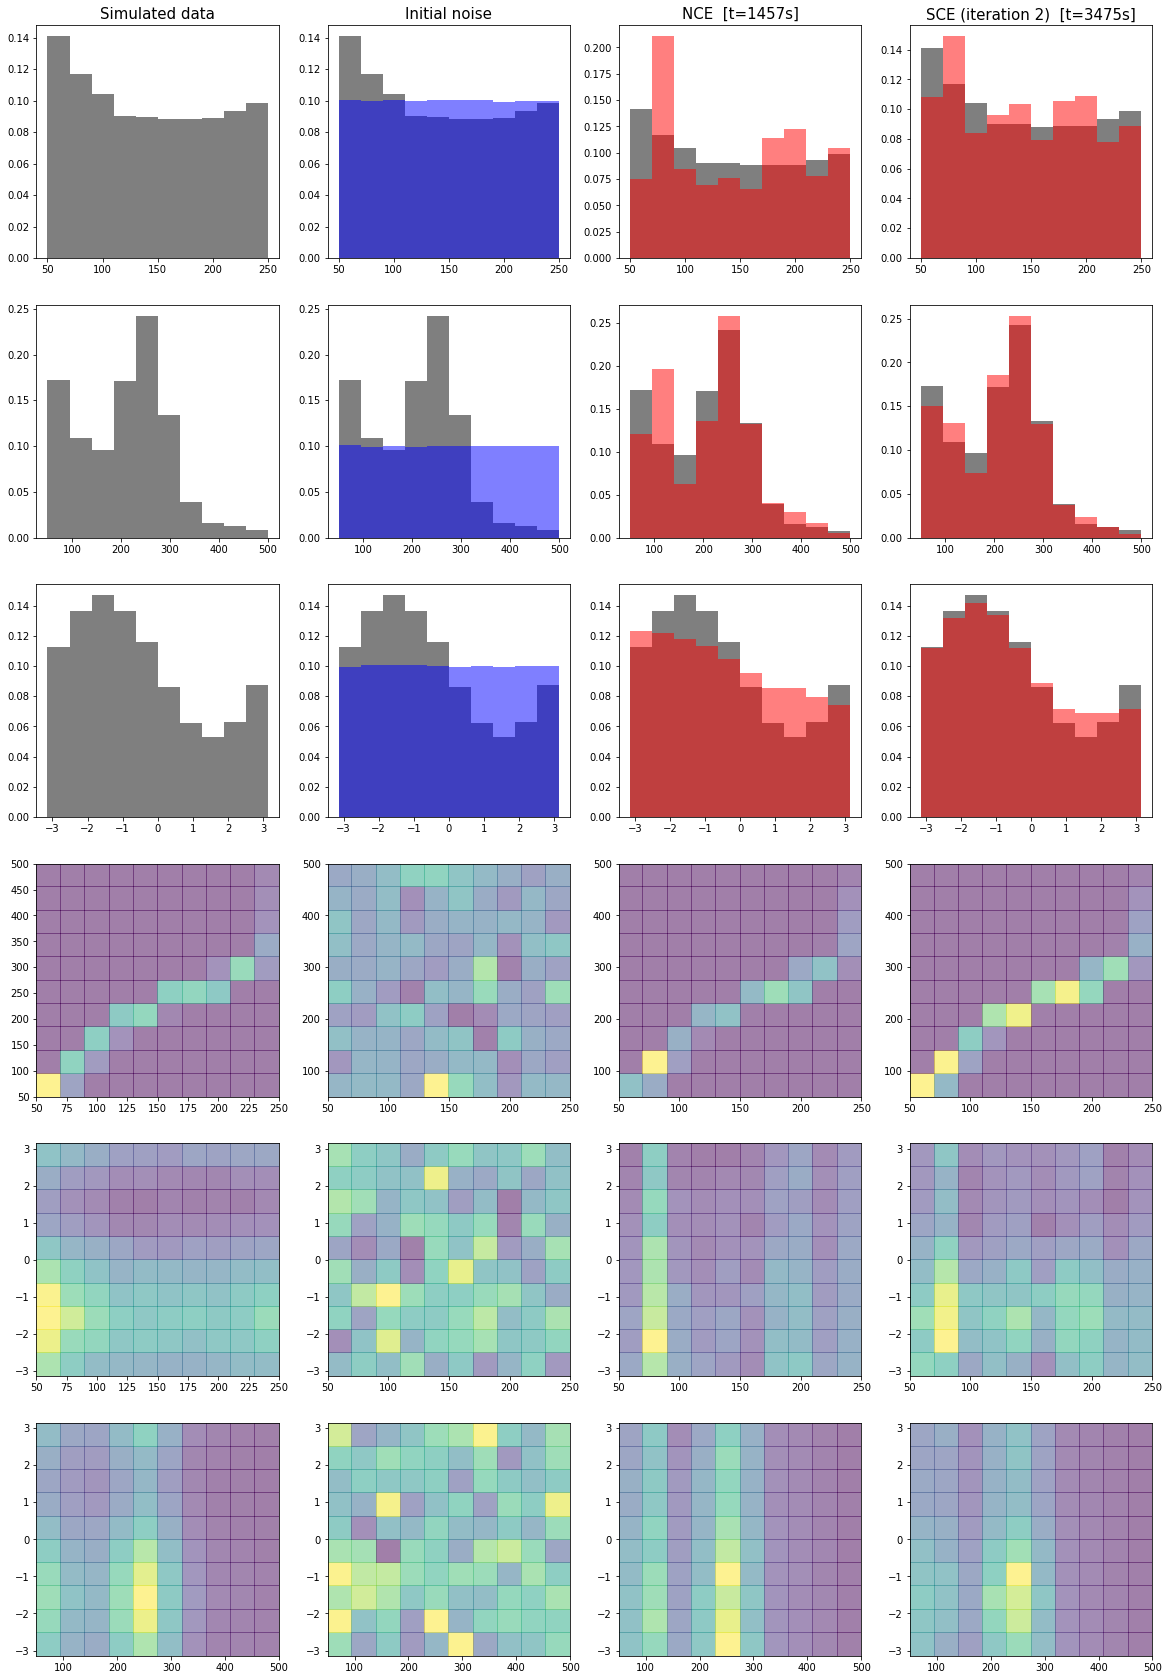

Adding 5.00% of initial noise back in
500000 noise datapoints provided
13.64% are useful (weight is > 1% of the mean)


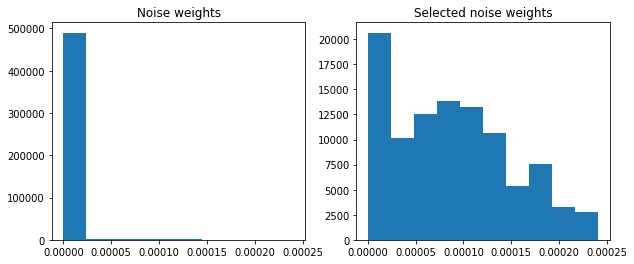

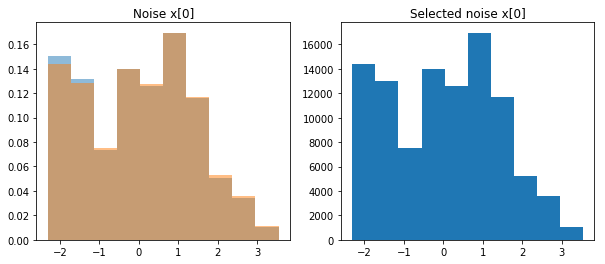

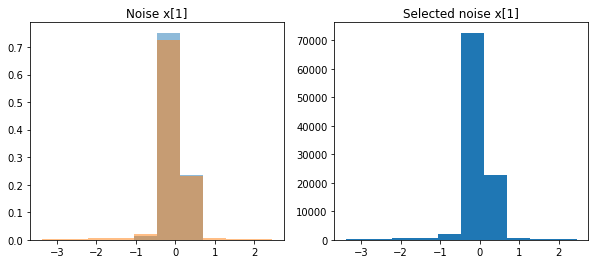

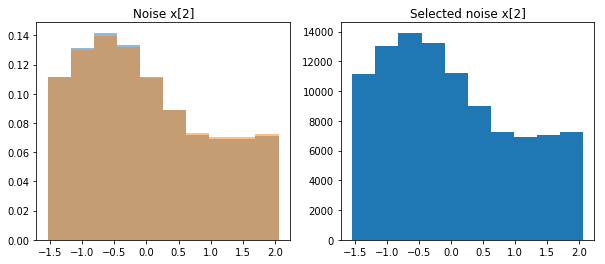

Creating discriminator with 3 observables and None conditions
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                200       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 50)                0         
_________________________________________________________

Epoch 56/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2854e-06 - val_loss: 9.2405e-06
Epoch 57/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2907e-06 - val_loss: 9.2401e-06
Epoch 58/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2849e-06 - val_loss: 9.2397e-06
Epoch 59/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2837e-06 - val_loss: 9.2393e-06
Epoch 60/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2878e-06 - val_loss: 9.2389e-06
Epoch 61/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2817e-06 - val_loss: 9.2386e-06
Epoch 62/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2844e-06 - val_loss: 9.2382e-06
Epoch 63/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2823e-06 - val_loss: 9.2379e-06
Epoch 64/10000
75000/75000 [==============================] - 0s 3us/ste

Epoch 127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2710e-06 - val_loss: 9.2290e-06
Epoch 128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2720e-06 - val_loss: 9.2289e-06
Epoch 129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2731e-06 - val_loss: 9.2289e-06
Epoch 130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2718e-06 - val_loss: 9.2288e-06
Epoch 131/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2682e-06 - val_loss: 9.2287e-06
Epoch 132/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2690e-06 - val_loss: 9.2287e-06
Epoch 133/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2730e-06 - val_loss: 9.2286e-06
Epoch 134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2705e-06 - val_loss: 9.2285e-06
Epoch 135/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2667e-06 - val_loss: 9.2250e-06
Epoch 198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2704e-06 - val_loss: 9.2250e-06
Epoch 199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2628e-06 - val_loss: 9.2250e-06
Epoch 200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2640e-06 - val_loss: 9.2249e-06
Epoch 201/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2636e-06 - val_loss: 9.2249e-06
Epoch 202/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2616e-06 - val_loss: 9.2248e-06
Epoch 203/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2652e-06 - val_loss: 9.2248e-06
Epoch 204/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2643e-06 - val_loss: 9.2247e-06
Epoch 205/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2629e-06 - val_loss: 9.2216e-06
Epoch 269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2592e-06 - val_loss: 9.2216e-06
Epoch 270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2650e-06 - val_loss: 9.2215e-06
Epoch 271/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2611e-06 - val_loss: 9.2215e-06
Epoch 272/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2653e-06 - val_loss: 9.2214e-06
Epoch 273/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2625e-06 - val_loss: 9.2214e-06
Epoch 274/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2614e-06 - val_loss: 9.2213e-06
Epoch 275/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2625e-06 - val_loss: 9.2213e-06
Epoch 276/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2575e-06 - val_loss: 9.2184e-06
Epoch 339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2595e-06 - val_loss: 9.2183e-06
Epoch 340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2581e-06 - val_loss: 9.2183e-06
Epoch 341/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2607e-06 - val_loss: 9.2183e-06
Epoch 342/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2549e-06 - val_loss: 9.2182e-06
Epoch 343/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2552e-06 - val_loss: 9.2182e-06
Epoch 344/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2585e-06 - val_loss: 9.2181e-06
Epoch 345/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2578e-06 - val_loss: 9.2181e-06
Epoch 346/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2521e-06 - val_loss: 9.2153e-06
Epoch 410/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2547e-06 - val_loss: 9.2153e-06
Epoch 411/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2542e-06 - val_loss: 9.2153e-06
Epoch 412/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2571e-06 - val_loss: 9.2152e-06
Epoch 413/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2567e-06 - val_loss: 9.2152e-06
Epoch 414/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2527e-06 - val_loss: 9.2151e-06
Epoch 415/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2558e-06 - val_loss: 9.2151e-06
Epoch 416/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2540e-06 - val_loss: 9.2151e-06
Epoch 417/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2539e-06 - val_loss: 9.2125e-06
Epoch 480/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.2527e-06 - val_loss: 9.2125e-06
Epoch 481/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2538e-06 - val_loss: 9.2124e-06
Epoch 482/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2517e-06 - val_loss: 9.2124e-06
Epoch 483/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2510e-06 - val_loss: 9.2123e-06
Epoch 484/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2530e-06 - val_loss: 9.2123e-06
Epoch 485/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2509e-06 - val_loss: 9.2123e-06
Epoch 486/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2541e-06 - val_loss: 9.2122e-06
Epoch 487/10000
75000/75000 [==============================] - 0s 4us/step - los

Epoch 550/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2462e-06 - val_loss: 9.2098e-06
Epoch 551/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2475e-06 - val_loss: 9.2098e-06
Epoch 552/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2487e-06 - val_loss: 9.2098e-06
Epoch 553/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2473e-06 - val_loss: 9.2097e-06
Epoch 554/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2485e-06 - val_loss: 9.2097e-06
Epoch 555/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2484e-06 - val_loss: 9.2096e-06
Epoch 556/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2491e-06 - val_loss: 9.2096e-06
Epoch 557/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2514e-06 - val_loss: 9.2096e-06
Epoch 558/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2481e-06 - val_loss: 9.2073e-06
Epoch 621/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2461e-06 - val_loss: 9.2072e-06
Epoch 622/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2443e-06 - val_loss: 9.2072e-06
Epoch 623/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2476e-06 - val_loss: 9.2072e-06
Epoch 624/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2462e-06 - val_loss: 9.2071e-06
Epoch 625/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2442e-06 - val_loss: 9.2071e-06
Epoch 626/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2447e-06 - val_loss: 9.2071e-06
Epoch 627/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2453e-06 - val_loss: 9.2070e-06
Epoch 628/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 691/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2424e-06 - val_loss: 9.2047e-06
Epoch 692/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2431e-06 - val_loss: 9.2047e-06
Epoch 693/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2452e-06 - val_loss: 9.2047e-06
Epoch 694/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2430e-06 - val_loss: 9.2046e-06
Epoch 695/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2460e-06 - val_loss: 9.2046e-06
Epoch 696/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2432e-06 - val_loss: 9.2046e-06
Epoch 697/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2421e-06 - val_loss: 9.2045e-06
Epoch 698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2451e-06 - val_loss: 9.2045e-06
Epoch 699/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2389e-06 - val_loss: 9.2021e-06
Epoch 762/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2389e-06 - val_loss: 9.2020e-06
Epoch 763/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2397e-06 - val_loss: 9.2020e-06
Epoch 764/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2399e-06 - val_loss: 9.2020e-06
Epoch 765/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2442e-06 - val_loss: 9.2019e-06
Epoch 766/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2391e-06 - val_loss: 9.2019e-06
Epoch 767/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2396e-06 - val_loss: 9.2018e-06
Epoch 768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2445e-06 - val_loss: 9.2018e-06
Epoch 769/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 832/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2400e-06 - val_loss: 9.1993e-06
Epoch 833/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2376e-06 - val_loss: 9.1993e-06
Epoch 834/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2385e-06 - val_loss: 9.1992e-06
Epoch 835/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2426e-06 - val_loss: 9.1992e-06
Epoch 836/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2399e-06 - val_loss: 9.1991e-06
Epoch 837/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2334e-06 - val_loss: 9.1991e-06
Epoch 838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2389e-06 - val_loss: 9.1991e-06
Epoch 839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2402e-06 - val_loss: 9.1990e-06
Epoch 840/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2343e-06 - val_loss: 9.1965e-06
Epoch 903/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2356e-06 - val_loss: 9.1965e-06
Epoch 904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2397e-06 - val_loss: 9.1964e-06
Epoch 905/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2343e-06 - val_loss: 9.1964e-06
Epoch 906/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2334e-06 - val_loss: 9.1964e-06
Epoch 907/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2362e-06 - val_loss: 9.1963e-06
Epoch 908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2349e-06 - val_loss: 9.1963e-06
Epoch 909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2327e-06 - val_loss: 9.1962e-06
Epoch 910/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 973/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2335e-06 - val_loss: 9.1937e-06
Epoch 974/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2300e-06 - val_loss: 9.1937e-06
Epoch 975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2321e-06 - val_loss: 9.1936e-06
Epoch 976/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2328e-06 - val_loss: 9.1936e-06
Epoch 977/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2341e-06 - val_loss: 9.1936e-06
Epoch 978/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2333e-06 - val_loss: 9.1935e-06
Epoch 979/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2347e-06 - val_loss: 9.1935e-06
Epoch 980/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2353e-06 - val_loss: 9.1934e-06
Epoch 981/10000
75000/75000 [==============================] - 0

Epoch 1043/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2305e-06 - val_loss: 9.1909e-06
Epoch 1044/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2262e-06 - val_loss: 9.1909e-06
Epoch 1045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2309e-06 - val_loss: 9.1908e-06
Epoch 1046/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2309e-06 - val_loss: 9.1908e-06
Epoch 1047/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2301e-06 - val_loss: 9.1907e-06
Epoch 1048/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2286e-06 - val_loss: 9.1907e-06
Epoch 1049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2289e-06 - val_loss: 9.1907e-06
Epoch 1050/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2288e-06 - val_loss: 9.1906e-06
Epoch 1051/10000
75000/75000 [==========================

Epoch 1113/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2277e-06 - val_loss: 9.1881e-06
Epoch 1114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2314e-06 - val_loss: 9.1880e-06
Epoch 1115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2274e-06 - val_loss: 9.1880e-06
Epoch 1116/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2271e-06 - val_loss: 9.1880e-06
Epoch 1117/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2276e-06 - val_loss: 9.1879e-06
Epoch 1118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2290e-06 - val_loss: 9.1879e-06
Epoch 1119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2281e-06 - val_loss: 9.1878e-06
Epoch 1120/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2273e-06 - val_loss: 9.1878e-06
Epoch 1121/10000
75000/75000 [==========================

Epoch 1183/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2266e-06 - val_loss: 9.1852e-06
Epoch 1184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2225e-06 - val_loss: 9.1852e-06
Epoch 1185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2231e-06 - val_loss: 9.1851e-06
Epoch 1186/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2236e-06 - val_loss: 9.1851e-06
Epoch 1187/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2233e-06 - val_loss: 9.1850e-06
Epoch 1188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2256e-06 - val_loss: 9.1850e-06
Epoch 1189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2242e-06 - val_loss: 9.1850e-06
Epoch 1190/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2227e-06 - val_loss: 9.1849e-06
Epoch 1191/10000
75000/75000 [==========================

Epoch 1253/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2215e-06 - val_loss: 9.1823e-06
Epoch 1254/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2202e-06 - val_loss: 9.1823e-06
Epoch 1255/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2220e-06 - val_loss: 9.1822e-06
Epoch 1256/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2230e-06 - val_loss: 9.1822e-06
Epoch 1257/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2222e-06 - val_loss: 9.1821e-06
Epoch 1258/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2218e-06 - val_loss: 9.1821e-06
Epoch 1259/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2238e-06 - val_loss: 9.1821e-06
Epoch 1260/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2225e-06 - val_loss: 9.1820e-06
Epoch 1261/10000
75000/75000 [==========================

Epoch 1323/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2194e-06 - val_loss: 9.1793e-06
Epoch 1324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2199e-06 - val_loss: 9.1792e-06
Epoch 1325/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2221e-06 - val_loss: 9.1792e-06
Epoch 1326/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2202e-06 - val_loss: 9.1792e-06
Epoch 1327/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2221e-06 - val_loss: 9.1791e-06
Epoch 1328/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2193e-06 - val_loss: 9.1791e-06
Epoch 1329/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2211e-06 - val_loss: 9.1790e-06
Epoch 1330/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2165e-06 - val_loss: 9.1790e-06
Epoch 1331/10000
75000/75000 [==========================

Epoch 1393/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2170e-06 - val_loss: 9.1762e-06
Epoch 1394/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2169e-06 - val_loss: 9.1762e-06
Epoch 1395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2163e-06 - val_loss: 9.1762e-06
Epoch 1396/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2150e-06 - val_loss: 9.1761e-06
Epoch 1397/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2186e-06 - val_loss: 9.1761e-06
Epoch 1398/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2157e-06 - val_loss: 9.1760e-06
Epoch 1399/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2195e-06 - val_loss: 9.1760e-06
Epoch 1400/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2164e-06 - val_loss: 9.1759e-06
Epoch 1401/10000
75000/75000 [==========================

Epoch 1463/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2147e-06 - val_loss: 9.1733e-06
Epoch 1464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2146e-06 - val_loss: 9.1733e-06
Epoch 1465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2147e-06 - val_loss: 9.1732e-06
Epoch 1466/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2173e-06 - val_loss: 9.1732e-06
Epoch 1467/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2147e-06 - val_loss: 9.1731e-06
Epoch 1468/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2141e-06 - val_loss: 9.1731e-06
Epoch 1469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2108e-06 - val_loss: 9.1730e-06
Epoch 1470/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2172e-06 - val_loss: 9.1730e-06
Epoch 1471/10000
75000/75000 [==========================

Epoch 1533/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2127e-06 - val_loss: 9.1704e-06
Epoch 1534/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2081e-06 - val_loss: 9.1703e-06
Epoch 1535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2130e-06 - val_loss: 9.1703e-06
Epoch 1536/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2059e-06 - val_loss: 9.1703e-06
Epoch 1537/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2081e-06 - val_loss: 9.1702e-06
Epoch 1538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2123e-06 - val_loss: 9.1702e-06
Epoch 1539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2107e-06 - val_loss: 9.1701e-06
Epoch 1540/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2130e-06 - val_loss: 9.1701e-06
Epoch 1541/10000
75000/75000 [==========================

Epoch 1603/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2094e-06 - val_loss: 9.1675e-06
Epoch 1604/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2079e-06 - val_loss: 9.1674e-06
Epoch 1605/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2099e-06 - val_loss: 9.1674e-06
Epoch 1606/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2069e-06 - val_loss: 9.1673e-06
Epoch 1607/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2080e-06 - val_loss: 9.1673e-06
Epoch 1608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2074e-06 - val_loss: 9.1673e-06
Epoch 1609/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2066e-06 - val_loss: 9.1672e-06
Epoch 1610/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2066e-06 - val_loss: 9.1672e-06
Epoch 1611/10000
75000/75000 [==========================

Epoch 1673/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2055e-06 - val_loss: 9.1645e-06
Epoch 1674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2080e-06 - val_loss: 9.1645e-06
Epoch 1675/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2037e-06 - val_loss: 9.1644e-06
Epoch 1676/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2078e-06 - val_loss: 9.1644e-06
Epoch 1677/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2049e-06 - val_loss: 9.1643e-06
Epoch 1678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2052e-06 - val_loss: 9.1643e-06
Epoch 1679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2051e-06 - val_loss: 9.1642e-06
Epoch 1680/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2106e-06 - val_loss: 9.1642e-06
Epoch 1681/10000
75000/75000 [==========================

Epoch 1743/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2010e-06 - val_loss: 9.1616e-06
Epoch 1744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2053e-06 - val_loss: 9.1616e-06
Epoch 1745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2053e-06 - val_loss: 9.1615e-06
Epoch 1746/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2041e-06 - val_loss: 9.1615e-06
Epoch 1747/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2060e-06 - val_loss: 9.1614e-06
Epoch 1748/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2042e-06 - val_loss: 9.1614e-06
Epoch 1749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2007e-06 - val_loss: 9.1614e-06
Epoch 1750/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2038e-06 - val_loss: 9.1613e-06
Epoch 1751/10000
75000/75000 [==========================

Epoch 1813/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2022e-06 - val_loss: 9.1588e-06
Epoch 1814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2020e-06 - val_loss: 9.1587e-06
Epoch 1815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2013e-06 - val_loss: 9.1587e-06
Epoch 1816/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2008e-06 - val_loss: 9.1586e-06
Epoch 1817/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2026e-06 - val_loss: 9.1586e-06
Epoch 1818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2008e-06 - val_loss: 9.1586e-06
Epoch 1819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1985e-06 - val_loss: 9.1585e-06
Epoch 1820/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1970e-06 - val_loss: 9.1585e-06
Epoch 1821/10000
75000/75000 [==========================

Epoch 1883/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1976e-06 - val_loss: 9.1559e-06
Epoch 1884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1994e-06 - val_loss: 9.1558e-06
Epoch 1885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2005e-06 - val_loss: 9.1558e-06
Epoch 1886/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1990e-06 - val_loss: 9.1558e-06
Epoch 1887/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1984e-06 - val_loss: 9.1557e-06
Epoch 1888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1983e-06 - val_loss: 9.1557e-06
Epoch 1889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1956e-06 - val_loss: 9.1557e-06
Epoch 1890/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1958e-06 - val_loss: 9.1556e-06
Epoch 1891/10000
75000/75000 [==========================

Epoch 1953/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1950e-06 - val_loss: 9.1531e-06
Epoch 1954/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1941e-06 - val_loss: 9.1530e-06
Epoch 1955/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1922e-06 - val_loss: 9.1530e-06
Epoch 1956/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1952e-06 - val_loss: 9.1530e-06
Epoch 1957/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1954e-06 - val_loss: 9.1529e-06
Epoch 1958/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1969e-06 - val_loss: 9.1529e-06
Epoch 1959/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1951e-06 - val_loss: 9.1528e-06
Epoch 1960/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1955e-06 - val_loss: 9.1528e-06
Epoch 1961/10000
75000/75000 [==========================

Epoch 2023/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1975e-06 - val_loss: 9.1504e-06
Epoch 2024/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1937e-06 - val_loss: 9.1503e-06
Epoch 2025/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1959e-06 - val_loss: 9.1503e-06
Epoch 2026/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1923e-06 - val_loss: 9.1503e-06
Epoch 2027/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1954e-06 - val_loss: 9.1502e-06
Epoch 2028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1913e-06 - val_loss: 9.1502e-06
Epoch 2029/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1913e-06 - val_loss: 9.1501e-06
Epoch 2030/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1938e-06 - val_loss: 9.1501e-06
Epoch 2031/10000
75000/75000 [==========================

Epoch 2093/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1890e-06 - val_loss: 9.1476e-06
Epoch 2094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1910e-06 - val_loss: 9.1476e-06
Epoch 2095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1891e-06 - val_loss: 9.1475e-06
Epoch 2096/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1926e-06 - val_loss: 9.1475e-06
Epoch 2097/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1887e-06 - val_loss: 9.1474e-06
Epoch 2098/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1859e-06 - val_loss: 9.1474e-06
Epoch 2099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1936e-06 - val_loss: 9.1473e-06
Epoch 2100/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1900e-06 - val_loss: 9.1473e-06
Epoch 2101/10000
75000/75000 [==========================

Epoch 2163/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1867e-06 - val_loss: 9.1449e-06
Epoch 2164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1880e-06 - val_loss: 9.1449e-06
Epoch 2165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1891e-06 - val_loss: 9.1448e-06
Epoch 2166/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1896e-06 - val_loss: 9.1448e-06
Epoch 2167/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1925e-06 - val_loss: 9.1447e-06
Epoch 2168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1890e-06 - val_loss: 9.1447e-06
Epoch 2169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1861e-06 - val_loss: 9.1447e-06
Epoch 2170/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1912e-06 - val_loss: 9.1446e-06
Epoch 2171/10000
75000/75000 [==========================

Epoch 2233/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1854e-06 - val_loss: 9.1422e-06
Epoch 2234/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1834e-06 - val_loss: 9.1421e-06
Epoch 2235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1860e-06 - val_loss: 9.1421e-06
Epoch 2236/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1921e-06 - val_loss: 9.1421e-06
Epoch 2237/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1870e-06 - val_loss: 9.1420e-06
Epoch 2238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1899e-06 - val_loss: 9.1420e-06
Epoch 2239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1849e-06 - val_loss: 9.1420e-06
Epoch 2240/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1843e-06 - val_loss: 9.1419e-06
Epoch 2241/10000
75000/75000 [==========================

Epoch 2303/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1858e-06 - val_loss: 9.1395e-06
Epoch 2304/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1852e-06 - val_loss: 9.1394e-06
Epoch 2305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1830e-06 - val_loss: 9.1394e-06
Epoch 2306/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1808e-06 - val_loss: 9.1394e-06
Epoch 2307/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1838e-06 - val_loss: 9.1393e-06
Epoch 2308/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1849e-06 - val_loss: 9.1393e-06
Epoch 2309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1851e-06 - val_loss: 9.1392e-06
Epoch 2310/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1841e-06 - val_loss: 9.1392e-06
Epoch 2311/10000
75000/75000 [==========================

Epoch 2373/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1778e-06 - val_loss: 9.1368e-06
Epoch 2374/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1789e-06 - val_loss: 9.1368e-06
Epoch 2375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1763e-06 - val_loss: 9.1368e-06
Epoch 2376/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1825e-06 - val_loss: 9.1367e-06
Epoch 2377/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1797e-06 - val_loss: 9.1367e-06
Epoch 2378/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1794e-06 - val_loss: 9.1367e-06
Epoch 2379/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1792e-06 - val_loss: 9.1366e-06
Epoch 2380/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1815e-06 - val_loss: 9.1366e-06
Epoch 2381/10000
75000/75000 [==========================

Epoch 2443/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1768e-06 - val_loss: 9.1344e-06
Epoch 2444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1806e-06 - val_loss: 9.1344e-06
Epoch 2445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1796e-06 - val_loss: 9.1343e-06
Epoch 2446/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1808e-06 - val_loss: 9.1343e-06
Epoch 2447/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1808e-06 - val_loss: 9.1343e-06
Epoch 2448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1787e-06 - val_loss: 9.1342e-06
Epoch 2449/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1787e-06 - val_loss: 9.1342e-06
Epoch 2450/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1753e-06 - val_loss: 9.1342e-06
Epoch 2451/10000
75000/75000 [==========================

Epoch 2513/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1750e-06 - val_loss: 9.1319e-06
Epoch 2514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1764e-06 - val_loss: 9.1319e-06
Epoch 2515/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1789e-06 - val_loss: 9.1318e-06
Epoch 2516/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1756e-06 - val_loss: 9.1318e-06
Epoch 2517/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1747e-06 - val_loss: 9.1318e-06
Epoch 2518/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1770e-06 - val_loss: 9.1317e-06
Epoch 2519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1745e-06 - val_loss: 9.1317e-06
Epoch 2520/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1728e-06 - val_loss: 9.1317e-06
Epoch 2521/10000
75000/75000 [==========================

Epoch 2583/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1756e-06 - val_loss: 9.1295e-06
Epoch 2584/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1747e-06 - val_loss: 9.1295e-06
Epoch 2585/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1712e-06 - val_loss: 9.1294e-06
Epoch 2586/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1725e-06 - val_loss: 9.1294e-06
Epoch 2587/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1760e-06 - val_loss: 9.1294e-06
Epoch 2588/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1761e-06 - val_loss: 9.1294e-06
Epoch 2589/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1750e-06 - val_loss: 9.1293e-06
Epoch 2590/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1728e-06 - val_loss: 9.1293e-06
Epoch 2591/10000
75000/75000 [==========================

Epoch 2653/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1745e-06 - val_loss: 9.1272e-06
Epoch 2654/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1705e-06 - val_loss: 9.1272e-06
Epoch 2655/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1720e-06 - val_loss: 9.1271e-06
Epoch 2656/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1721e-06 - val_loss: 9.1271e-06
Epoch 2657/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1756e-06 - val_loss: 9.1270e-06
Epoch 2658/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1756e-06 - val_loss: 9.1270e-06
Epoch 2659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1708e-06 - val_loss: 9.1270e-06
Epoch 2660/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1704e-06 - val_loss: 9.1269e-06
Epoch 2661/10000
75000/75000 [==========================

Epoch 2723/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1730e-06 - val_loss: 9.1247e-06
Epoch 2724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1695e-06 - val_loss: 9.1247e-06
Epoch 2725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1672e-06 - val_loss: 9.1247e-06
Epoch 2726/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1715e-06 - val_loss: 9.1246e-06
Epoch 2727/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1693e-06 - val_loss: 9.1246e-06
Epoch 2728/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1730e-06 - val_loss: 9.1246e-06
Epoch 2729/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1707e-06 - val_loss: 9.1245e-06
Epoch 2730/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1702e-06 - val_loss: 9.1245e-06
Epoch 2731/10000
75000/75000 [==========================

Epoch 2793/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1685e-06 - val_loss: 9.1224e-06
Epoch 2794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1698e-06 - val_loss: 9.1224e-06
Epoch 2795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1684e-06 - val_loss: 9.1223e-06
Epoch 2796/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1694e-06 - val_loss: 9.1223e-06
Epoch 2797/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1714e-06 - val_loss: 9.1223e-06
Epoch 2798/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1648e-06 - val_loss: 9.1222e-06
Epoch 2799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1697e-06 - val_loss: 9.1222e-06
Epoch 2800/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1708e-06 - val_loss: 9.1222e-06
Epoch 2801/10000
75000/75000 [==========================

Epoch 2863/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1703e-06 - val_loss: 9.1201e-06
Epoch 2864/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1677e-06 - val_loss: 9.1201e-06
Epoch 2865/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1648e-06 - val_loss: 9.1200e-06
Epoch 2866/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1659e-06 - val_loss: 9.1200e-06
Epoch 2867/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1655e-06 - val_loss: 9.1200e-06
Epoch 2868/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1657e-06 - val_loss: 9.1199e-06
Epoch 2869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1693e-06 - val_loss: 9.1199e-06
Epoch 2870/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1670e-06 - val_loss: 9.1198e-06
Epoch 2871/10000
75000/75000 [==========================

Epoch 2933/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1685e-06 - val_loss: 9.1178e-06
Epoch 2934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1628e-06 - val_loss: 9.1178e-06
Epoch 2935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1649e-06 - val_loss: 9.1177e-06
Epoch 2936/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1706e-06 - val_loss: 9.1177e-06
Epoch 2937/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1633e-06 - val_loss: 9.1177e-06
Epoch 2938/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1602e-06 - val_loss: 9.1176e-06
Epoch 2939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1637e-06 - val_loss: 9.1176e-06
Epoch 2940/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1636e-06 - val_loss: 9.1176e-06
Epoch 2941/10000
75000/75000 [==========================

Epoch 3003/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1674e-06 - val_loss: 9.1155e-06
Epoch 3004/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1579e-06 - val_loss: 9.1155e-06
Epoch 3005/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1600e-06 - val_loss: 9.1155e-06
Epoch 3006/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1653e-06 - val_loss: 9.1154e-06
Epoch 3007/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1578e-06 - val_loss: 9.1154e-06
Epoch 3008/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1620e-06 - val_loss: 9.1154e-06
Epoch 3009/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1583e-06 - val_loss: 9.1153e-06
Epoch 3010/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1576e-06 - val_loss: 9.1153e-06
Epoch 3011/10000
75000/75000 [==========================

Epoch 3073/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1598e-06 - val_loss: 9.1133e-06
Epoch 3074/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1588e-06 - val_loss: 9.1132e-06
Epoch 3075/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1595e-06 - val_loss: 9.1132e-06
Epoch 3076/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1606e-06 - val_loss: 9.1132e-06
Epoch 3077/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1622e-06 - val_loss: 9.1131e-06
Epoch 3078/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1604e-06 - val_loss: 9.1131e-06
Epoch 3079/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1611e-06 - val_loss: 9.1131e-06
Epoch 3080/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1604e-06 - val_loss: 9.1130e-06
Epoch 3081/10000
75000/75000 [==========================

Epoch 3143/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1596e-06 - val_loss: 9.1111e-06
Epoch 3144/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1600e-06 - val_loss: 9.1111e-06
Epoch 3145/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1618e-06 - val_loss: 9.1111e-06
Epoch 3146/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1581e-06 - val_loss: 9.1110e-06
Epoch 3147/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1610e-06 - val_loss: 9.1110e-06
Epoch 3148/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1586e-06 - val_loss: 9.1110e-06
Epoch 3149/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1615e-06 - val_loss: 9.1110e-06
Epoch 3150/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1579e-06 - val_loss: 9.1109e-06
Epoch 3151/10000
75000/75000 [==========================

Epoch 3213/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1612e-06 - val_loss: 9.1091e-06
Epoch 3214/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1576e-06 - val_loss: 9.1090e-06
Epoch 3215/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1589e-06 - val_loss: 9.1090e-06
Epoch 3216/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1548e-06 - val_loss: 9.1090e-06
Epoch 3217/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1573e-06 - val_loss: 9.1090e-06
Epoch 3218/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1545e-06 - val_loss: 9.1089e-06
Epoch 3219/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1574e-06 - val_loss: 9.1089e-06
Epoch 3220/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1576e-06 - val_loss: 9.1089e-06
Epoch 3221/10000
75000/75000 [==========================

Epoch 3283/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1535e-06 - val_loss: 9.1070e-06
Epoch 3284/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1553e-06 - val_loss: 9.1070e-06
Epoch 3285/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1527e-06 - val_loss: 9.1069e-06
Epoch 3286/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1563e-06 - val_loss: 9.1069e-06
Epoch 3287/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1551e-06 - val_loss: 9.1069e-06
Epoch 3288/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1532e-06 - val_loss: 9.1068e-06
Epoch 3289/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1531e-06 - val_loss: 9.1068e-06
Epoch 3290/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1526e-06 - val_loss: 9.1068e-06
Epoch 3291/10000
75000/75000 [==========================

Epoch 3353/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1536e-06 - val_loss: 9.1049e-06
Epoch 3354/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1505e-06 - val_loss: 9.1049e-06
Epoch 3355/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1505e-06 - val_loss: 9.1048e-06
Epoch 3356/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1523e-06 - val_loss: 9.1048e-06
Epoch 3357/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1537e-06 - val_loss: 9.1048e-06
Epoch 3358/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1563e-06 - val_loss: 9.1047e-06
Epoch 3359/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1514e-06 - val_loss: 9.1047e-06
Epoch 3360/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1540e-06 - val_loss: 9.1047e-06
Epoch 3361/10000
75000/75000 [==========================

Epoch 3423/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1532e-06 - val_loss: 9.1028e-06
Epoch 3424/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1489e-06 - val_loss: 9.1027e-06
Epoch 3425/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1524e-06 - val_loss: 9.1027e-06
Epoch 3426/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1527e-06 - val_loss: 9.1027e-06
Epoch 3427/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1469e-06 - val_loss: 9.1026e-06
Epoch 3428/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1499e-06 - val_loss: 9.1026e-06
Epoch 3429/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1489e-06 - val_loss: 9.1026e-06
Epoch 3430/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1478e-06 - val_loss: 9.1025e-06
Epoch 3431/10000
75000/75000 [==========================

Epoch 3493/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1488e-06 - val_loss: 9.1006e-06
Epoch 3494/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1509e-06 - val_loss: 9.1006e-06
Epoch 3495/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1500e-06 - val_loss: 9.1006e-06
Epoch 3496/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1492e-06 - val_loss: 9.1005e-06
Epoch 3497/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1466e-06 - val_loss: 9.1005e-06
Epoch 3498/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1490e-06 - val_loss: 9.1005e-06
Epoch 3499/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1475e-06 - val_loss: 9.1004e-06
Epoch 3500/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1461e-06 - val_loss: 9.1004e-06
Epoch 3501/10000
75000/75000 [==========================

Epoch 3563/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1482e-06 - val_loss: 9.0987e-06
Epoch 3564/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1514e-06 - val_loss: 9.0987e-06
Epoch 3565/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1478e-06 - val_loss: 9.0986e-06
Epoch 3566/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1493e-06 - val_loss: 9.0986e-06
Epoch 3567/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1479e-06 - val_loss: 9.0986e-06
Epoch 3568/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1475e-06 - val_loss: 9.0986e-06
Epoch 3569/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.0985e-06
Epoch 3570/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1473e-06 - val_loss: 9.0985e-06
Epoch 3571/10000
75000/75000 [==========================

Epoch 3633/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1492e-06 - val_loss: 9.0969e-06
Epoch 3634/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1496e-06 - val_loss: 9.0969e-06
Epoch 3635/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1435e-06 - val_loss: 9.0968e-06
Epoch 3636/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1428e-06 - val_loss: 9.0968e-06
Epoch 3637/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1441e-06 - val_loss: 9.0968e-06
Epoch 3638/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1454e-06 - val_loss: 9.0968e-06
Epoch 3639/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1468e-06 - val_loss: 9.0967e-06
Epoch 3640/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1470e-06 - val_loss: 9.0967e-06
Epoch 3641/10000
75000/75000 [==========================

Epoch 3703/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1473e-06 - val_loss: 9.0951e-06
Epoch 3704/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1474e-06 - val_loss: 9.0951e-06
Epoch 3705/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1434e-06 - val_loss: 9.0951e-06
Epoch 3706/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1439e-06 - val_loss: 9.0950e-06
Epoch 3707/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1417e-06 - val_loss: 9.0950e-06
Epoch 3708/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1425e-06 - val_loss: 9.0950e-06
Epoch 3709/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1431e-06 - val_loss: 9.0950e-06
Epoch 3710/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1417e-06 - val_loss: 9.0949e-06
Epoch 3711/10000
75000/75000 [==========================

Epoch 3773/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1444e-06 - val_loss: 9.0933e-06
Epoch 3774/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1423e-06 - val_loss: 9.0933e-06
Epoch 3775/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1444e-06 - val_loss: 9.0933e-06
Epoch 3776/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1455e-06 - val_loss: 9.0932e-06
Epoch 3777/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1439e-06 - val_loss: 9.0932e-06
Epoch 3778/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1471e-06 - val_loss: 9.0932e-06
Epoch 3779/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1410e-06 - val_loss: 9.0932e-06
Epoch 3780/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1428e-06 - val_loss: 9.0931e-06
Epoch 3781/10000
75000/75000 [==========================

Epoch 3843/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1397e-06 - val_loss: 9.0913e-06
Epoch 3844/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1368e-06 - val_loss: 9.0913e-06
Epoch 3845/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1399e-06 - val_loss: 9.0913e-06
Epoch 3846/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1424e-06 - val_loss: 9.0912e-06
Epoch 3847/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1422e-06 - val_loss: 9.0912e-06
Epoch 3848/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1449e-06 - val_loss: 9.0912e-06
Epoch 3849/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1425e-06 - val_loss: 9.0912e-06
Epoch 3850/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1413e-06 - val_loss: 9.0911e-06
Epoch 3851/10000
75000/75000 [==========================

Epoch 3913/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1401e-06 - val_loss: 9.0895e-06
Epoch 3914/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1373e-06 - val_loss: 9.0895e-06
Epoch 3915/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1401e-06 - val_loss: 9.0895e-06
Epoch 3916/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1396e-06 - val_loss: 9.0895e-06
Epoch 3917/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1425e-06 - val_loss: 9.0894e-06
Epoch 3918/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1371e-06 - val_loss: 9.0894e-06
Epoch 3919/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1404e-06 - val_loss: 9.0894e-06
Epoch 3920/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1396e-06 - val_loss: 9.0894e-06
Epoch 3921/10000
75000/75000 [==========================

Epoch 3983/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1393e-06 - val_loss: 9.0876e-06
Epoch 3984/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1347e-06 - val_loss: 9.0876e-06
Epoch 3985/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1313e-06 - val_loss: 9.0876e-06
Epoch 3986/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1386e-06 - val_loss: 9.0875e-06
Epoch 3987/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1358e-06 - val_loss: 9.0875e-06
Epoch 3988/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1341e-06 - val_loss: 9.0875e-06
Epoch 3989/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1378e-06 - val_loss: 9.0875e-06
Epoch 3990/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1374e-06 - val_loss: 9.0874e-06
Epoch 3991/10000
75000/75000 [==========================

Epoch 4053/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1352e-06 - val_loss: 9.0856e-06
Epoch 4054/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1326e-06 - val_loss: 9.0855e-06
Epoch 4055/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1342e-06 - val_loss: 9.0855e-06
Epoch 4056/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1390e-06 - val_loss: 9.0855e-06
Epoch 4057/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1340e-06 - val_loss: 9.0854e-06
Epoch 4058/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1360e-06 - val_loss: 9.0854e-06
Epoch 4059/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1386e-06 - val_loss: 9.0854e-06
Epoch 4060/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1389e-06 - val_loss: 9.0854e-06
Epoch 4061/10000
75000/75000 [==========================

Epoch 4123/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1347e-06 - val_loss: 9.0838e-06
Epoch 4124/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1363e-06 - val_loss: 9.0838e-06
Epoch 4125/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1381e-06 - val_loss: 9.0837e-06
Epoch 4126/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1356e-06 - val_loss: 9.0837e-06
Epoch 4127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1327e-06 - val_loss: 9.0837e-06
Epoch 4128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1354e-06 - val_loss: 9.0837e-06
Epoch 4129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1355e-06 - val_loss: 9.0837e-06
Epoch 4130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1344e-06 - val_loss: 9.0837e-06
Epoch 4131/10000
75000/75000 [==========================

Epoch 4193/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1297e-06 - val_loss: 9.0822e-06
Epoch 4194/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1316e-06 - val_loss: 9.0822e-06
Epoch 4195/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1333e-06 - val_loss: 9.0822e-06
Epoch 4196/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1345e-06 - val_loss: 9.0822e-06
Epoch 4197/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1338e-06 - val_loss: 9.0821e-06
Epoch 4198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1302e-06 - val_loss: 9.0821e-06
Epoch 4199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1354e-06 - val_loss: 9.0821e-06
Epoch 4200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1344e-06 - val_loss: 9.0821e-06
Epoch 4201/10000
75000/75000 [==========================

Epoch 4263/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1326e-06 - val_loss: 9.0805e-06
Epoch 4264/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1333e-06 - val_loss: 9.0805e-06
Epoch 4265/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1293e-06 - val_loss: 9.0804e-06
Epoch 4266/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1291e-06 - val_loss: 9.0804e-06
Epoch 4267/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1334e-06 - val_loss: 9.0804e-06
Epoch 4268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1347e-06 - val_loss: 9.0804e-06
Epoch 4269/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1309e-06 - val_loss: 9.0803e-06
Epoch 4270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1328e-06 - val_loss: 9.0803e-06
Epoch 4271/10000
75000/75000 [==========================

Epoch 4333/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1342e-06 - val_loss: 9.0790e-06
Epoch 4334/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1281e-06 - val_loss: 9.0790e-06
Epoch 4335/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1266e-06 - val_loss: 9.0789e-06
Epoch 4336/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1263e-06 - val_loss: 9.0789e-06
Epoch 4337/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1274e-06 - val_loss: 9.0789e-06
Epoch 4338/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1305e-06 - val_loss: 9.0789e-06
Epoch 4339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1277e-06 - val_loss: 9.0788e-06
Epoch 4340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1300e-06 - val_loss: 9.0788e-06
Epoch 4341/10000
75000/75000 [==========================

Epoch 4403/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1289e-06 - val_loss: 9.0774e-06
Epoch 4404/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1298e-06 - val_loss: 9.0774e-06
Epoch 4405/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1251e-06 - val_loss: 9.0774e-06
Epoch 4406/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1324e-06 - val_loss: 9.0774e-06
Epoch 4407/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1278e-06 - val_loss: 9.0774e-06
Epoch 4408/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1306e-06 - val_loss: 9.0773e-06
Epoch 4409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1254e-06 - val_loss: 9.0773e-06
Epoch 4410/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1293e-06 - val_loss: 9.0773e-06
Epoch 4411/10000
75000/75000 [==========================

Epoch 4473/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1241e-06 - val_loss: 9.0760e-06
Epoch 4474/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1271e-06 - val_loss: 9.0760e-06
Epoch 4475/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1280e-06 - val_loss: 9.0759e-06
Epoch 4476/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1296e-06 - val_loss: 9.0759e-06
Epoch 4477/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1252e-06 - val_loss: 9.0759e-06
Epoch 4478/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1295e-06 - val_loss: 9.0759e-06
Epoch 4479/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1242e-06 - val_loss: 9.0759e-06
Epoch 4480/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1266e-06 - val_loss: 9.0759e-06
Epoch 4481/10000
75000/75000 [==========================

Epoch 4543/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1285e-06 - val_loss: 9.0747e-06
Epoch 4544/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1245e-06 - val_loss: 9.0747e-06
Epoch 4545/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1298e-06 - val_loss: 9.0747e-06
Epoch 4546/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1245e-06 - val_loss: 9.0747e-06
Epoch 4547/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1239e-06 - val_loss: 9.0747e-06
Epoch 4548/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1213e-06 - val_loss: 9.0747e-06
Epoch 4549/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1234e-06 - val_loss: 9.0746e-06
Epoch 4550/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1225e-06 - val_loss: 9.0746e-06
Epoch 4551/10000
75000/75000 [==========================

Epoch 4613/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1240e-06 - val_loss: 9.0734e-06
Epoch 4614/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1272e-06 - val_loss: 9.0733e-06
Epoch 4615/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1229e-06 - val_loss: 9.0733e-06
Epoch 4616/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1227e-06 - val_loss: 9.0733e-06
Epoch 4617/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1260e-06 - val_loss: 9.0733e-06
Epoch 4618/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1267e-06 - val_loss: 9.0733e-06
Epoch 4619/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1263e-06 - val_loss: 9.0733e-06
Epoch 4620/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1255e-06 - val_loss: 9.0733e-06
Epoch 4621/10000
75000/75000 [==========================

Epoch 4683/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1235e-06 - val_loss: 9.0719e-06
Epoch 4684/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1210e-06 - val_loss: 9.0719e-06
Epoch 4685/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1212e-06 - val_loss: 9.0719e-06
Epoch 4686/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1282e-06 - val_loss: 9.0719e-06
Epoch 4687/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1242e-06 - val_loss: 9.0719e-06
Epoch 4688/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1245e-06 - val_loss: 9.0718e-06
Epoch 4689/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1265e-06 - val_loss: 9.0718e-06
Epoch 4690/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1249e-06 - val_loss: 9.0718e-06
Epoch 4691/10000
75000/75000 [==========================

Epoch 4753/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1191e-06 - val_loss: 9.0703e-06
Epoch 4754/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1224e-06 - val_loss: 9.0703e-06
Epoch 4755/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1233e-06 - val_loss: 9.0703e-06
Epoch 4756/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1237e-06 - val_loss: 9.0703e-06
Epoch 4757/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1160e-06 - val_loss: 9.0703e-06
Epoch 4758/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1201e-06 - val_loss: 9.0702e-06
Epoch 4759/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1215e-06 - val_loss: 9.0702e-06
Epoch 4760/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1268e-06 - val_loss: 9.0702e-06
Epoch 4761/10000
75000/75000 [==========================

Epoch 4823/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1230e-06 - val_loss: 9.0685e-06
Epoch 4824/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1198e-06 - val_loss: 9.0685e-06
Epoch 4825/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1182e-06 - val_loss: 9.0685e-06
Epoch 4826/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1223e-06 - val_loss: 9.0684e-06
Epoch 4827/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1189e-06 - val_loss: 9.0684e-06
Epoch 4828/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1186e-06 - val_loss: 9.0684e-06
Epoch 4829/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1190e-06 - val_loss: 9.0683e-06
Epoch 4830/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1201e-06 - val_loss: 9.0683e-06
Epoch 4831/10000
75000/75000 [==========================

Epoch 4893/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1201e-06 - val_loss: 9.0669e-06
Epoch 4894/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1196e-06 - val_loss: 9.0669e-06
Epoch 4895/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1162e-06 - val_loss: 9.0669e-06
Epoch 4896/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1223e-06 - val_loss: 9.0669e-06
Epoch 4897/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1187e-06 - val_loss: 9.0668e-06
Epoch 4898/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1175e-06 - val_loss: 9.0668e-06
Epoch 4899/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1176e-06 - val_loss: 9.0668e-06
Epoch 4900/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1193e-06 - val_loss: 9.0668e-06
Epoch 4901/10000
75000/75000 [==========================

Epoch 4963/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1183e-06 - val_loss: 9.0654e-06
Epoch 4964/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1160e-06 - val_loss: 9.0654e-06
Epoch 4965/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1214e-06 - val_loss: 9.0653e-06
Epoch 4966/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1194e-06 - val_loss: 9.0653e-06
Epoch 4967/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1197e-06 - val_loss: 9.0653e-06
Epoch 4968/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1146e-06 - val_loss: 9.0653e-06
Epoch 4969/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1152e-06 - val_loss: 9.0653e-06
Epoch 4970/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1164e-06 - val_loss: 9.0653e-06
Epoch 4971/10000
75000/75000 [==========================

Epoch 5033/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1171e-06 - val_loss: 9.0638e-06
Epoch 5034/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1189e-06 - val_loss: 9.0638e-06
Epoch 5035/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1104e-06 - val_loss: 9.0637e-06
Epoch 5036/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1151e-06 - val_loss: 9.0637e-06
Epoch 5037/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1182e-06 - val_loss: 9.0637e-06
Epoch 5038/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1169e-06 - val_loss: 9.0637e-06
Epoch 5039/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1140e-06 - val_loss: 9.0637e-06
Epoch 5040/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1148e-06 - val_loss: 9.0637e-06
Epoch 5041/10000
75000/75000 [==========================

Epoch 5103/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1163e-06 - val_loss: 9.0619e-06
Epoch 5104/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1121e-06 - val_loss: 9.0619e-06
Epoch 5105/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1199e-06 - val_loss: 9.0619e-06
Epoch 5106/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1170e-06 - val_loss: 9.0618e-06
Epoch 5107/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1117e-06 - val_loss: 9.0618e-06
Epoch 5108/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1152e-06 - val_loss: 9.0618e-06
Epoch 5109/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1121e-06 - val_loss: 9.0618e-06
Epoch 5110/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1143e-06 - val_loss: 9.0618e-06
Epoch 5111/10000
75000/75000 [==========================

Epoch 5173/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1137e-06 - val_loss: 9.0604e-06
Epoch 5174/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1113e-06 - val_loss: 9.0604e-06
Epoch 5175/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1109e-06 - val_loss: 9.0603e-06
Epoch 5176/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1155e-06 - val_loss: 9.0603e-06
Epoch 5177/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1090e-06 - val_loss: 9.0603e-06
Epoch 5178/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1132e-06 - val_loss: 9.0602e-06
Epoch 5179/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1070e-06 - val_loss: 9.0602e-06
Epoch 5180/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1148e-06 - val_loss: 9.0602e-06
Epoch 5181/10000
75000/75000 [==========================

Epoch 5243/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1103e-06 - val_loss: 9.0590e-06
Epoch 5244/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1127e-06 - val_loss: 9.0590e-06
Epoch 5245/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1109e-06 - val_loss: 9.0589e-06
Epoch 5246/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1156e-06 - val_loss: 9.0589e-06
Epoch 5247/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1101e-06 - val_loss: 9.0589e-06
Epoch 5248/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1109e-06 - val_loss: 9.0589e-06
Epoch 5249/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1156e-06 - val_loss: 9.0589e-06
Epoch 5250/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1115e-06 - val_loss: 9.0588e-06
Epoch 5251/10000
75000/75000 [==========================

Epoch 5313/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1067e-06 - val_loss: 9.0576e-06
Epoch 5314/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1126e-06 - val_loss: 9.0576e-06
Epoch 5315/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1076e-06 - val_loss: 9.0576e-06
Epoch 5316/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1107e-06 - val_loss: 9.0576e-06
Epoch 5317/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1130e-06 - val_loss: 9.0576e-06
Epoch 5318/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1109e-06 - val_loss: 9.0576e-06
Epoch 5319/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1065e-06 - val_loss: 9.0575e-06
Epoch 5320/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1130e-06 - val_loss: 9.0575e-06
Epoch 5321/10000
75000/75000 [==========================

Epoch 5383/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1097e-06 - val_loss: 9.0563e-06
Epoch 5384/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1118e-06 - val_loss: 9.0563e-06
Epoch 5385/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1128e-06 - val_loss: 9.0563e-06
Epoch 5386/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1055e-06 - val_loss: 9.0563e-06
Epoch 5387/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1081e-06 - val_loss: 9.0563e-06
Epoch 5388/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1068e-06 - val_loss: 9.0562e-06
Epoch 5389/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1075e-06 - val_loss: 9.0562e-06
Epoch 5390/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1102e-06 - val_loss: 9.0562e-06
Epoch 5391/10000
75000/75000 [==========================

Epoch 5453/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1068e-06 - val_loss: 9.0551e-06
Epoch 5454/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1075e-06 - val_loss: 9.0550e-06
Epoch 5455/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1074e-06 - val_loss: 9.0550e-06
Epoch 5456/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1049e-06 - val_loss: 9.0550e-06
Epoch 5457/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1079e-06 - val_loss: 9.0550e-06
Epoch 5458/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1083e-06 - val_loss: 9.0550e-06
Epoch 5459/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1087e-06 - val_loss: 9.0549e-06
Epoch 5460/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1079e-06 - val_loss: 9.0549e-06
Epoch 5461/10000
75000/75000 [==========================

Epoch 5523/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1092e-06 - val_loss: 9.0537e-06
Epoch 5524/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1046e-06 - val_loss: 9.0537e-06
Epoch 5525/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1084e-06 - val_loss: 9.0537e-06
Epoch 5526/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1086e-06 - val_loss: 9.0537e-06
Epoch 5527/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1105e-06 - val_loss: 9.0537e-06
Epoch 5528/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1107e-06 - val_loss: 9.0537e-06
Epoch 5529/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1057e-06 - val_loss: 9.0536e-06
Epoch 5530/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1116e-06 - val_loss: 9.0536e-06
Epoch 5531/10000
75000/75000 [==========================

Epoch 5593/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1077e-06 - val_loss: 9.0524e-06
Epoch 5594/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1037e-06 - val_loss: 9.0524e-06
Epoch 5595/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1051e-06 - val_loss: 9.0524e-06
Epoch 5596/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1081e-06 - val_loss: 9.0524e-06
Epoch 5597/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1078e-06 - val_loss: 9.0524e-06
Epoch 5598/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1085e-06 - val_loss: 9.0524e-06
Epoch 5599/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1095e-06 - val_loss: 9.0524e-06
Epoch 5600/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1084e-06 - val_loss: 9.0523e-06
Epoch 5601/10000
75000/75000 [==========================

Epoch 5663/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1014e-06 - val_loss: 9.0511e-06
Epoch 5664/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1088e-06 - val_loss: 9.0511e-06
Epoch 5665/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1010e-06 - val_loss: 9.0511e-06
Epoch 5666/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1021e-06 - val_loss: 9.0510e-06
Epoch 5667/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1041e-06 - val_loss: 9.0510e-06
Epoch 5668/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1057e-06 - val_loss: 9.0510e-06
Epoch 5669/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1069e-06 - val_loss: 9.0510e-06
Epoch 5670/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1062e-06 - val_loss: 9.0510e-06
Epoch 5671/10000
75000/75000 [==========================

Epoch 5733/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1037e-06 - val_loss: 9.0496e-06
Epoch 5734/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0992e-06 - val_loss: 9.0496e-06
Epoch 5735/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1052e-06 - val_loss: 9.0496e-06
Epoch 5736/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1056e-06 - val_loss: 9.0496e-06
Epoch 5737/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1034e-06 - val_loss: 9.0495e-06
Epoch 5738/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1010e-06 - val_loss: 9.0495e-06
Epoch 5739/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1041e-06 - val_loss: 9.0495e-06
Epoch 5740/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1056e-06 - val_loss: 9.0495e-06
Epoch 5741/10000
75000/75000 [==========================

Epoch 5803/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1000e-06 - val_loss: 9.0483e-06
Epoch 5804/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0982e-06 - val_loss: 9.0483e-06
Epoch 5805/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0992e-06 - val_loss: 9.0482e-06
Epoch 5806/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0977e-06 - val_loss: 9.0482e-06
Epoch 5807/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1023e-06 - val_loss: 9.0482e-06
Epoch 5808/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0978e-06 - val_loss: 9.0482e-06
Epoch 5809/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1048e-06 - val_loss: 9.0482e-06
Epoch 5810/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0994e-06 - val_loss: 9.0481e-06
Epoch 5811/10000
75000/75000 [==========================

Epoch 5873/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1044e-06 - val_loss: 9.0468e-06
Epoch 5874/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1017e-06 - val_loss: 9.0468e-06
Epoch 5875/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0997e-06 - val_loss: 9.0468e-06
Epoch 5876/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0942e-06 - val_loss: 9.0467e-06
Epoch 5877/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1003e-06 - val_loss: 9.0467e-06
Epoch 5878/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1008e-06 - val_loss: 9.0467e-06
Epoch 5879/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0999e-06 - val_loss: 9.0466e-06
Epoch 5880/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1016e-06 - val_loss: 9.0466e-06
Epoch 5881/10000
75000/75000 [==========================

Epoch 5943/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0999e-06 - val_loss: 9.0454e-06
Epoch 5944/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0986e-06 - val_loss: 9.0454e-06
Epoch 5945/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0964e-06 - val_loss: 9.0454e-06
Epoch 5946/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1012e-06 - val_loss: 9.0453e-06
Epoch 5947/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0959e-06 - val_loss: 9.0453e-06
Epoch 5948/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0992e-06 - val_loss: 9.0453e-06
Epoch 5949/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0993e-06 - val_loss: 9.0453e-06
Epoch 5950/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0969e-06 - val_loss: 9.0453e-06
Epoch 5951/10000
75000/75000 [==========================

Epoch 6013/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0969e-06 - val_loss: 9.0440e-06
Epoch 6014/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0994e-06 - val_loss: 9.0440e-06
Epoch 6015/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1010e-06 - val_loss: 9.0440e-06
Epoch 6016/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0964e-06 - val_loss: 9.0440e-06
Epoch 6017/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1020e-06 - val_loss: 9.0440e-06
Epoch 6018/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0968e-06 - val_loss: 9.0440e-06
Epoch 6019/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0977e-06 - val_loss: 9.0439e-06
Epoch 6020/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0948e-06 - val_loss: 9.0439e-06
Epoch 6021/10000
75000/75000 [==========================

Epoch 6083/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0968e-06 - val_loss: 9.0425e-06
Epoch 6084/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0948e-06 - val_loss: 9.0425e-06
Epoch 6085/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1014e-06 - val_loss: 9.0424e-06
Epoch 6086/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0955e-06 - val_loss: 9.0424e-06
Epoch 6087/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0959e-06 - val_loss: 9.0424e-06
Epoch 6088/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0985e-06 - val_loss: 9.0424e-06
Epoch 6089/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0984e-06 - val_loss: 9.0423e-06
Epoch 6090/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0940e-06 - val_loss: 9.0423e-06
Epoch 6091/10000
75000/75000 [==========================

Epoch 6153/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0946e-06 - val_loss: 9.0409e-06
Epoch 6154/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0953e-06 - val_loss: 9.0409e-06
Epoch 6155/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0932e-06 - val_loss: 9.0409e-06
Epoch 6156/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0930e-06 - val_loss: 9.0408e-06
Epoch 6157/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1003e-06 - val_loss: 9.0408e-06
Epoch 6158/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0988e-06 - val_loss: 9.0408e-06
Epoch 6159/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0906e-06 - val_loss: 9.0408e-06
Epoch 6160/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0979e-06 - val_loss: 9.0408e-06
Epoch 6161/10000
75000/75000 [==========================

Epoch 6223/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0930e-06 - val_loss: 9.0393e-06
Epoch 6224/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0957e-06 - val_loss: 9.0393e-06
Epoch 6225/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0976e-06 - val_loss: 9.0393e-06
Epoch 6226/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0936e-06 - val_loss: 9.0393e-06
Epoch 6227/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0928e-06 - val_loss: 9.0392e-06
Epoch 6228/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1007e-06 - val_loss: 9.0392e-06
Epoch 6229/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0919e-06 - val_loss: 9.0392e-06
Epoch 6230/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0942e-06 - val_loss: 9.0392e-06
Epoch 6231/10000
75000/75000 [==========================

Epoch 6293/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0893e-06 - val_loss: 9.0378e-06
Epoch 6294/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0892e-06 - val_loss: 9.0377e-06
Epoch 6295/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0886e-06 - val_loss: 9.0377e-06
Epoch 6296/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0943e-06 - val_loss: 9.0377e-06
Epoch 6297/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0916e-06 - val_loss: 9.0376e-06
Epoch 6298/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0941e-06 - val_loss: 9.0376e-06
Epoch 6299/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0958e-06 - val_loss: 9.0376e-06
Epoch 6300/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0925e-06 - val_loss: 9.0376e-06
Epoch 6301/10000
75000/75000 [==========================

Epoch 6363/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0915e-06 - val_loss: 9.0360e-06
Epoch 6364/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0948e-06 - val_loss: 9.0360e-06
Epoch 6365/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0924e-06 - val_loss: 9.0360e-06
Epoch 6366/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0896e-06 - val_loss: 9.0360e-06
Epoch 6367/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0927e-06 - val_loss: 9.0359e-06
Epoch 6368/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0922e-06 - val_loss: 9.0359e-06
Epoch 6369/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0887e-06 - val_loss: 9.0359e-06
Epoch 6370/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0878e-06 - val_loss: 9.0358e-06
Epoch 6371/10000
75000/75000 [==========================

Epoch 6433/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0915e-06 - val_loss: 9.0345e-06
Epoch 6434/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0924e-06 - val_loss: 9.0345e-06
Epoch 6435/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0908e-06 - val_loss: 9.0345e-06
Epoch 6436/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0894e-06 - val_loss: 9.0345e-06
Epoch 6437/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0898e-06 - val_loss: 9.0344e-06
Epoch 6438/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0936e-06 - val_loss: 9.0344e-06
Epoch 6439/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0877e-06 - val_loss: 9.0344e-06
Epoch 6440/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0869e-06 - val_loss: 9.0344e-06
Epoch 6441/10000
75000/75000 [==========================

Epoch 6503/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0914e-06 - val_loss: 9.0329e-06
Epoch 6504/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0932e-06 - val_loss: 9.0329e-06
Epoch 6505/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0909e-06 - val_loss: 9.0329e-06
Epoch 6506/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0882e-06 - val_loss: 9.0329e-06
Epoch 6507/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0885e-06 - val_loss: 9.0329e-06
Epoch 6508/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0901e-06 - val_loss: 9.0329e-06
Epoch 6509/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0853e-06 - val_loss: 9.0329e-06
Epoch 6510/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0943e-06 - val_loss: 9.0329e-06
Epoch 6511/10000
75000/75000 [==========================

Epoch 6573/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0894e-06 - val_loss: 9.0314e-06
Epoch 6574/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0902e-06 - val_loss: 9.0314e-06
Epoch 6575/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0896e-06 - val_loss: 9.0314e-06
Epoch 6576/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0838e-06 - val_loss: 9.0313e-06
Epoch 6577/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0884e-06 - val_loss: 9.0313e-06
Epoch 6578/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0880e-06 - val_loss: 9.0313e-06
Epoch 6579/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0894e-06 - val_loss: 9.0313e-06
Epoch 6580/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0886e-06 - val_loss: 9.0313e-06
Epoch 6581/10000
75000/75000 [==========================

Epoch 6643/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0814e-06 - val_loss: 9.0300e-06
Epoch 6644/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0875e-06 - val_loss: 9.0300e-06
Epoch 6645/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0864e-06 - val_loss: 9.0299e-06
Epoch 6646/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0909e-06 - val_loss: 9.0299e-06
Epoch 6647/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0856e-06 - val_loss: 9.0298e-06
Epoch 6648/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0817e-06 - val_loss: 9.0298e-06
Epoch 6649/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0877e-06 - val_loss: 9.0298e-06
Epoch 6650/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0862e-06 - val_loss: 9.0297e-06
Epoch 6651/10000
75000/75000 [==========================

Epoch 6713/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0831e-06 - val_loss: 9.0286e-06
Epoch 6714/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0836e-06 - val_loss: 9.0286e-06
Epoch 6715/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0885e-06 - val_loss: 9.0285e-06
Epoch 6716/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0860e-06 - val_loss: 9.0285e-06
Epoch 6717/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0887e-06 - val_loss: 9.0285e-06
Epoch 6718/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0842e-06 - val_loss: 9.0284e-06
Epoch 6719/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0908e-06 - val_loss: 9.0284e-06
Epoch 6720/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0810e-06 - val_loss: 9.0284e-06
Epoch 6721/10000
75000/75000 [==========================

Epoch 6783/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0820e-06 - val_loss: 9.0266e-06
Epoch 6784/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0865e-06 - val_loss: 9.0265e-06
Epoch 6785/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0838e-06 - val_loss: 9.0265e-06
Epoch 6786/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0841e-06 - val_loss: 9.0265e-06
Epoch 6787/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0864e-06 - val_loss: 9.0265e-06
Epoch 6788/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0886e-06 - val_loss: 9.0265e-06
Epoch 6789/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0827e-06 - val_loss: 9.0265e-06
Epoch 6790/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0853e-06 - val_loss: 9.0264e-06
Epoch 6791/10000
75000/75000 [==========================

Epoch 6853/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0835e-06 - val_loss: 9.0247e-06
Epoch 6854/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0814e-06 - val_loss: 9.0247e-06
Epoch 6855/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0817e-06 - val_loss: 9.0246e-06
Epoch 6856/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0797e-06 - val_loss: 9.0246e-06
Epoch 6857/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0850e-06 - val_loss: 9.0245e-06
Epoch 6858/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0825e-06 - val_loss: 9.0245e-06
Epoch 6859/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0837e-06 - val_loss: 9.0245e-06
Epoch 6860/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0822e-06 - val_loss: 9.0245e-06
Epoch 6861/10000
75000/75000 [==========================

Epoch 6923/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0779e-06 - val_loss: 9.0230e-06
Epoch 6924/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0790e-06 - val_loss: 9.0230e-06
Epoch 6925/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0770e-06 - val_loss: 9.0229e-06
Epoch 6926/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0785e-06 - val_loss: 9.0229e-06
Epoch 6927/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0832e-06 - val_loss: 9.0228e-06
Epoch 6928/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0816e-06 - val_loss: 9.0228e-06
Epoch 6929/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0808e-06 - val_loss: 9.0228e-06
Epoch 6930/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0768e-06 - val_loss: 9.0227e-06
Epoch 6931/10000
75000/75000 [==========================

Epoch 6993/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0813e-06 - val_loss: 9.0210e-06
Epoch 6994/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0792e-06 - val_loss: 9.0210e-06
Epoch 6995/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0754e-06 - val_loss: 9.0210e-06
Epoch 6996/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0795e-06 - val_loss: 9.0210e-06
Epoch 6997/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0821e-06 - val_loss: 9.0210e-06
Epoch 6998/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0773e-06 - val_loss: 9.0210e-06
Epoch 6999/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0816e-06 - val_loss: 9.0209e-06
Epoch 7000/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0848e-06 - val_loss: 9.0209e-06
Epoch 7001/10000
75000/75000 [==========================

Epoch 7063/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0796e-06 - val_loss: 9.0191e-06
Epoch 7064/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0781e-06 - val_loss: 9.0190e-06
Epoch 7065/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0779e-06 - val_loss: 9.0190e-06
Epoch 7066/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0808e-06 - val_loss: 9.0190e-06
Epoch 7067/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0768e-06 - val_loss: 9.0190e-06
Epoch 7068/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0816e-06 - val_loss: 9.0190e-06
Epoch 7069/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0802e-06 - val_loss: 9.0190e-06
Epoch 7070/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0801e-06 - val_loss: 9.0189e-06
Epoch 7071/10000
75000/75000 [==========================

Epoch 7133/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0780e-06 - val_loss: 9.0173e-06
Epoch 7134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0753e-06 - val_loss: 9.0173e-06
Epoch 7135/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0802e-06 - val_loss: 9.0172e-06
Epoch 7136/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0792e-06 - val_loss: 9.0172e-06
Epoch 7137/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0756e-06 - val_loss: 9.0171e-06
Epoch 7138/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0778e-06 - val_loss: 9.0171e-06
Epoch 7139/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0755e-06 - val_loss: 9.0170e-06
Epoch 7140/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0758e-06 - val_loss: 9.0170e-06
Epoch 7141/10000
75000/75000 [==========================

Epoch 7203/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0706e-06 - val_loss: 9.0150e-06
Epoch 7204/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0758e-06 - val_loss: 9.0150e-06
Epoch 7205/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0798e-06 - val_loss: 9.0149e-06
Epoch 7206/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0746e-06 - val_loss: 9.0149e-06
Epoch 7207/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0697e-06 - val_loss: 9.0148e-06
Epoch 7208/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0803e-06 - val_loss: 9.0148e-06
Epoch 7209/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0706e-06 - val_loss: 9.0148e-06
Epoch 7210/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0740e-06 - val_loss: 9.0148e-06
Epoch 7211/10000
75000/75000 [==========================

Epoch 7273/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0741e-06 - val_loss: 9.0128e-06
Epoch 7274/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0748e-06 - val_loss: 9.0127e-06
Epoch 7275/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0744e-06 - val_loss: 9.0127e-06
Epoch 7276/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0730e-06 - val_loss: 9.0126e-06
Epoch 7277/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0741e-06 - val_loss: 9.0126e-06
Epoch 7278/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0694e-06 - val_loss: 9.0126e-06
Epoch 7279/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0712e-06 - val_loss: 9.0125e-06
Epoch 7280/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0724e-06 - val_loss: 9.0125e-06
Epoch 7281/10000
75000/75000 [==========================

Epoch 7343/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0717e-06 - val_loss: 9.0107e-06
Epoch 7344/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0715e-06 - val_loss: 9.0107e-06
Epoch 7345/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0689e-06 - val_loss: 9.0106e-06
Epoch 7346/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0698e-06 - val_loss: 9.0106e-06
Epoch 7347/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0707e-06 - val_loss: 9.0106e-06
Epoch 7348/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0709e-06 - val_loss: 9.0105e-06
Epoch 7349/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0709e-06 - val_loss: 9.0105e-06
Epoch 7350/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0718e-06 - val_loss: 9.0105e-06
Epoch 7351/10000
75000/75000 [==========================

Epoch 7413/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0719e-06 - val_loss: 9.0086e-06
Epoch 7414/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0710e-06 - val_loss: 9.0086e-06
Epoch 7415/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0756e-06 - val_loss: 9.0086e-06
Epoch 7416/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0684e-06 - val_loss: 9.0086e-06
Epoch 7417/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0706e-06 - val_loss: 9.0086e-06
Epoch 7418/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0658e-06 - val_loss: 9.0085e-06
Epoch 7419/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0711e-06 - val_loss: 9.0085e-06
Epoch 7420/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0686e-06 - val_loss: 9.0085e-06
Epoch 7421/10000
75000/75000 [==========================

Epoch 7483/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0684e-06 - val_loss: 9.0066e-06
Epoch 7484/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0689e-06 - val_loss: 9.0065e-06
Epoch 7485/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0686e-06 - val_loss: 9.0065e-06
Epoch 7486/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0725e-06 - val_loss: 9.0065e-06
Epoch 7487/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0673e-06 - val_loss: 9.0065e-06
Epoch 7488/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0746e-06 - val_loss: 9.0065e-06
Epoch 7489/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0700e-06 - val_loss: 9.0065e-06
Epoch 7490/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0725e-06 - val_loss: 9.0065e-06
Epoch 7491/10000
75000/75000 [==========================

Epoch 7553/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0674e-06 - val_loss: 9.0047e-06
Epoch 7554/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0657e-06 - val_loss: 9.0047e-06
Epoch 7555/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0669e-06 - val_loss: 9.0047e-06
Epoch 7556/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0693e-06 - val_loss: 9.0047e-06
Epoch 7557/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0697e-06 - val_loss: 9.0046e-06
Epoch 7558/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0677e-06 - val_loss: 9.0046e-06
Epoch 7559/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0676e-06 - val_loss: 9.0046e-06
Epoch 7560/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0691e-06 - val_loss: 9.0046e-06
Epoch 7561/10000
75000/75000 [==========================

Epoch 7623/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0676e-06 - val_loss: 9.0029e-06
Epoch 7624/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0695e-06 - val_loss: 9.0029e-06
Epoch 7625/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0680e-06 - val_loss: 9.0029e-06
Epoch 7626/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0669e-06 - val_loss: 9.0028e-06
Epoch 7627/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0708e-06 - val_loss: 9.0028e-06
Epoch 7628/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0693e-06 - val_loss: 9.0028e-06
Epoch 7629/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0645e-06 - val_loss: 9.0028e-06
Epoch 7630/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0618e-06 - val_loss: 9.0027e-06
Epoch 7631/10000
75000/75000 [==========================

Epoch 7693/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0616e-06 - val_loss: 9.0007e-06
Epoch 7694/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0676e-06 - val_loss: 9.0007e-06
Epoch 7695/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0640e-06 - val_loss: 9.0006e-06
Epoch 7696/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0632e-06 - val_loss: 9.0006e-06
Epoch 7697/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0687e-06 - val_loss: 9.0005e-06
Epoch 7698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0624e-06 - val_loss: 9.0005e-06
Epoch 7699/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0631e-06 - val_loss: 9.0004e-06
Epoch 7700/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0654e-06 - val_loss: 9.0004e-06
Epoch 7701/10000
75000/75000 [==========================

Epoch 7763/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0637e-06 - val_loss: 8.9985e-06
Epoch 7764/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0609e-06 - val_loss: 8.9984e-06
Epoch 7765/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0624e-06 - val_loss: 8.9984e-06
Epoch 7766/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0605e-06 - val_loss: 8.9984e-06
Epoch 7767/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0617e-06 - val_loss: 8.9983e-06
Epoch 7768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0595e-06 - val_loss: 8.9983e-06
Epoch 7769/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0673e-06 - val_loss: 8.9983e-06
Epoch 7770/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0629e-06 - val_loss: 8.9982e-06
Epoch 7771/10000
75000/75000 [==========================

Epoch 7833/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0619e-06 - val_loss: 8.9967e-06
Epoch 7834/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0663e-06 - val_loss: 8.9967e-06
Epoch 7835/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0644e-06 - val_loss: 8.9966e-06
Epoch 7836/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0646e-06 - val_loss: 8.9966e-06
Epoch 7837/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0631e-06 - val_loss: 8.9965e-06
Epoch 7838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0638e-06 - val_loss: 8.9965e-06
Epoch 7839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0610e-06 - val_loss: 8.9964e-06
Epoch 7840/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0611e-06 - val_loss: 8.9963e-06
Epoch 7841/10000
75000/75000 [==========================

Epoch 7903/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0565e-06 - val_loss: 8.9944e-06
Epoch 7904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0611e-06 - val_loss: 8.9944e-06
Epoch 7905/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0587e-06 - val_loss: 8.9943e-06
Epoch 7906/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0595e-06 - val_loss: 8.9943e-06
Epoch 7907/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0584e-06 - val_loss: 8.9942e-06
Epoch 7908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0575e-06 - val_loss: 8.9942e-06
Epoch 7909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0638e-06 - val_loss: 8.9942e-06
Epoch 7910/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0582e-06 - val_loss: 8.9941e-06
Epoch 7911/10000
75000/75000 [==========================

Epoch 7973/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0617e-06 - val_loss: 8.9924e-06
Epoch 7974/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0582e-06 - val_loss: 8.9923e-06
Epoch 7975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0606e-06 - val_loss: 8.9923e-06
Epoch 7976/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0594e-06 - val_loss: 8.9923e-06
Epoch 7977/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0600e-06 - val_loss: 8.9923e-06
Epoch 7978/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0575e-06 - val_loss: 8.9922e-06
Epoch 7979/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0574e-06 - val_loss: 8.9922e-06
Epoch 7980/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0612e-06 - val_loss: 8.9922e-06
Epoch 7981/10000
75000/75000 [==========================

Epoch 8043/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0551e-06 - val_loss: 8.9900e-06
Epoch 8044/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0587e-06 - val_loss: 8.9899e-06
Epoch 8045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0578e-06 - val_loss: 8.9899e-06
Epoch 8046/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0578e-06 - val_loss: 8.9899e-06
Epoch 8047/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0580e-06 - val_loss: 8.9899e-06
Epoch 8048/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0587e-06 - val_loss: 8.9899e-06
Epoch 8049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0598e-06 - val_loss: 8.9898e-06
Epoch 8050/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0519e-06 - val_loss: 8.9898e-06
Epoch 8051/10000
75000/75000 [==========================

Epoch 8113/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0607e-06 - val_loss: 8.9877e-06
Epoch 8114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0573e-06 - val_loss: 8.9877e-06
Epoch 8115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0619e-06 - val_loss: 8.9876e-06
Epoch 8116/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0511e-06 - val_loss: 8.9876e-06
Epoch 8117/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0547e-06 - val_loss: 8.9876e-06
Epoch 8118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0579e-06 - val_loss: 8.9875e-06
Epoch 8119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0522e-06 - val_loss: 8.9875e-06
Epoch 8120/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0567e-06 - val_loss: 8.9875e-06
Epoch 8121/10000
75000/75000 [==========================

Epoch 8183/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0540e-06 - val_loss: 8.9854e-06
Epoch 8184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0537e-06 - val_loss: 8.9854e-06
Epoch 8185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0534e-06 - val_loss: 8.9854e-06
Epoch 8186/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0587e-06 - val_loss: 8.9853e-06
Epoch 8187/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0577e-06 - val_loss: 8.9853e-06
Epoch 8188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0572e-06 - val_loss: 8.9853e-06
Epoch 8189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0514e-06 - val_loss: 8.9852e-06
Epoch 8190/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0554e-06 - val_loss: 8.9852e-06
Epoch 8191/10000
75000/75000 [==========================

Epoch 8253/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0531e-06 - val_loss: 8.9827e-06
Epoch 8254/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0517e-06 - val_loss: 8.9827e-06
Epoch 8255/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0576e-06 - val_loss: 8.9827e-06
Epoch 8256/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0488e-06 - val_loss: 8.9827e-06
Epoch 8257/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0559e-06 - val_loss: 8.9826e-06
Epoch 8258/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0554e-06 - val_loss: 8.9826e-06
Epoch 8259/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0479e-06 - val_loss: 8.9826e-06
Epoch 8260/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0535e-06 - val_loss: 8.9825e-06
Epoch 8261/10000
75000/75000 [==========================

Epoch 8323/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0505e-06 - val_loss: 8.9803e-06
Epoch 8324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0517e-06 - val_loss: 8.9803e-06
Epoch 8325/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0521e-06 - val_loss: 8.9802e-06
Epoch 8326/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0534e-06 - val_loss: 8.9802e-06
Epoch 8327/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0558e-06 - val_loss: 8.9801e-06
Epoch 8328/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0488e-06 - val_loss: 8.9800e-06
Epoch 8329/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0477e-06 - val_loss: 8.9800e-06
Epoch 8330/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0446e-06 - val_loss: 8.9799e-06
Epoch 8331/10000
75000/75000 [==========================

Epoch 8393/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0504e-06 - val_loss: 8.9768e-06
Epoch 8394/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0486e-06 - val_loss: 8.9767e-06
Epoch 8395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0541e-06 - val_loss: 8.9766e-06
Epoch 8396/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0469e-06 - val_loss: 8.9765e-06
Epoch 8397/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0471e-06 - val_loss: 8.9765e-06
Epoch 8398/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0502e-06 - val_loss: 8.9765e-06
Epoch 8399/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0528e-06 - val_loss: 8.9764e-06
Epoch 8400/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0495e-06 - val_loss: 8.9764e-06
Epoch 8401/10000
75000/75000 [==========================

Epoch 8463/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0472e-06 - val_loss: 8.9740e-06
Epoch 8464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0479e-06 - val_loss: 8.9740e-06
Epoch 8465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0462e-06 - val_loss: 8.9740e-06
Epoch 8466/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0494e-06 - val_loss: 8.9740e-06
Epoch 8467/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0493e-06 - val_loss: 8.9739e-06
Epoch 8468/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0461e-06 - val_loss: 8.9738e-06
Epoch 8469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0507e-06 - val_loss: 8.9738e-06
Epoch 8470/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0482e-06 - val_loss: 8.9738e-06
Epoch 8471/10000
75000/75000 [==========================

Epoch 8533/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0468e-06 - val_loss: 8.9710e-06
Epoch 8534/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0432e-06 - val_loss: 8.9710e-06
Epoch 8535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0397e-06 - val_loss: 8.9710e-06
Epoch 8536/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0406e-06 - val_loss: 8.9709e-06
Epoch 8537/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0458e-06 - val_loss: 8.9709e-06
Epoch 8538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0454e-06 - val_loss: 8.9709e-06
Epoch 8539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0442e-06 - val_loss: 8.9708e-06
Epoch 8540/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0482e-06 - val_loss: 8.9708e-06
Epoch 8541/10000
75000/75000 [==========================

Epoch 8603/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0408e-06 - val_loss: 8.9677e-06
Epoch 8604/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0459e-06 - val_loss: 8.9676e-06
Epoch 8605/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0411e-06 - val_loss: 8.9676e-06
Epoch 8606/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0452e-06 - val_loss: 8.9675e-06
Epoch 8607/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0417e-06 - val_loss: 8.9674e-06
Epoch 8608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0477e-06 - val_loss: 8.9674e-06
Epoch 8609/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0382e-06 - val_loss: 8.9673e-06
Epoch 8610/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0375e-06 - val_loss: 8.9672e-06
Epoch 8611/10000
75000/75000 [==========================

Epoch 8673/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0407e-06 - val_loss: 8.9640e-06
Epoch 8674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0398e-06 - val_loss: 8.9640e-06
Epoch 8675/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0468e-06 - val_loss: 8.9639e-06
Epoch 8676/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0397e-06 - val_loss: 8.9638e-06
Epoch 8677/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0392e-06 - val_loss: 8.9638e-06
Epoch 8678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0414e-06 - val_loss: 8.9637e-06
Epoch 8679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0368e-06 - val_loss: 8.9636e-06
Epoch 8680/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0354e-06 - val_loss: 8.9636e-06
Epoch 8681/10000
75000/75000 [==========================

Epoch 8743/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0358e-06 - val_loss: 8.9610e-06
Epoch 8744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0332e-06 - val_loss: 8.9609e-06
Epoch 8745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0367e-06 - val_loss: 8.9609e-06
Epoch 8746/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0364e-06 - val_loss: 8.9608e-06
Epoch 8747/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0432e-06 - val_loss: 8.9608e-06
Epoch 8748/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0452e-06 - val_loss: 8.9607e-06
Epoch 8749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0405e-06 - val_loss: 8.9607e-06
Epoch 8750/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0395e-06 - val_loss: 8.9606e-06
Epoch 8751/10000
75000/75000 [==========================

Epoch 8813/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0355e-06 - val_loss: 8.9574e-06
Epoch 8814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0396e-06 - val_loss: 8.9573e-06
Epoch 8815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0387e-06 - val_loss: 8.9573e-06
Epoch 8816/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0378e-06 - val_loss: 8.9572e-06
Epoch 8817/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0399e-06 - val_loss: 8.9572e-06
Epoch 8818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0330e-06 - val_loss: 8.9572e-06
Epoch 8819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0319e-06 - val_loss: 8.9571e-06
Epoch 8820/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0378e-06 - val_loss: 8.9571e-06
Epoch 8821/10000
75000/75000 [==========================

Epoch 8883/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0350e-06 - val_loss: 8.9537e-06
Epoch 8884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0293e-06 - val_loss: 8.9536e-06
Epoch 8885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0348e-06 - val_loss: 8.9535e-06
Epoch 8886/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0382e-06 - val_loss: 8.9534e-06
Epoch 8887/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0296e-06 - val_loss: 8.9534e-06
Epoch 8888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0336e-06 - val_loss: 8.9533e-06
Epoch 8889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0297e-06 - val_loss: 8.9532e-06
Epoch 8890/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0326e-06 - val_loss: 8.9532e-06
Epoch 8891/10000
75000/75000 [==========================

Epoch 8953/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0309e-06 - val_loss: 8.9500e-06
Epoch 8954/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0298e-06 - val_loss: 8.9499e-06
Epoch 8955/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0349e-06 - val_loss: 8.9498e-06
Epoch 8956/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0293e-06 - val_loss: 8.9497e-06
Epoch 8957/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0277e-06 - val_loss: 8.9496e-06
Epoch 8958/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0345e-06 - val_loss: 8.9496e-06
Epoch 8959/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0268e-06 - val_loss: 8.9495e-06
Epoch 8960/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0327e-06 - val_loss: 8.9495e-06
Epoch 8961/10000
75000/75000 [==========================

Epoch 9023/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0246e-06 - val_loss: 8.9459e-06
Epoch 9024/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0318e-06 - val_loss: 8.9459e-06
Epoch 9025/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0317e-06 - val_loss: 8.9458e-06
Epoch 9026/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0198e-06 - val_loss: 8.9458e-06
Epoch 9027/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0310e-06 - val_loss: 8.9457e-06
Epoch 9028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0305e-06 - val_loss: 8.9457e-06
Epoch 9029/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0323e-06 - val_loss: 8.9456e-06
Epoch 9030/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0272e-06 - val_loss: 8.9456e-06
Epoch 9031/10000
75000/75000 [==========================

Epoch 9093/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0238e-06 - val_loss: 8.9414e-06
Epoch 9094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0236e-06 - val_loss: 8.9414e-06
Epoch 9095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0265e-06 - val_loss: 8.9413e-06
Epoch 9096/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0247e-06 - val_loss: 8.9412e-06
Epoch 9097/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0289e-06 - val_loss: 8.9412e-06
Epoch 9098/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0275e-06 - val_loss: 8.9412e-06
Epoch 9099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0317e-06 - val_loss: 8.9412e-06
Epoch 9100/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0266e-06 - val_loss: 8.9412e-06
Epoch 9101/10000
75000/75000 [==========================

Epoch 9163/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0247e-06 - val_loss: 8.9375e-06
Epoch 9164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0259e-06 - val_loss: 8.9375e-06
Epoch 9165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0305e-06 - val_loss: 8.9374e-06
Epoch 9166/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0220e-06 - val_loss: 8.9373e-06
Epoch 9167/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0264e-06 - val_loss: 8.9373e-06
Epoch 9168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0297e-06 - val_loss: 8.9372e-06
Epoch 9169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0182e-06 - val_loss: 8.9371e-06
Epoch 9170/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0183e-06 - val_loss: 8.9369e-06
Epoch 9171/10000
75000/75000 [==========================

Epoch 9233/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0165e-06 - val_loss: 8.9336e-06
Epoch 9234/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0192e-06 - val_loss: 8.9335e-06
Epoch 9235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0218e-06 - val_loss: 8.9334e-06
Epoch 9236/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0204e-06 - val_loss: 8.9334e-06
Epoch 9237/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0163e-06 - val_loss: 8.9332e-06
Epoch 9238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0195e-06 - val_loss: 8.9331e-06
Epoch 9239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0247e-06 - val_loss: 8.9330e-06
Epoch 9240/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0188e-06 - val_loss: 8.9330e-06
Epoch 9241/10000
75000/75000 [==========================

Epoch 9303/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0166e-06 - val_loss: 8.9287e-06
Epoch 9304/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0168e-06 - val_loss: 8.9286e-06
Epoch 9305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0254e-06 - val_loss: 8.9286e-06
Epoch 9306/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0203e-06 - val_loss: 8.9285e-06
Epoch 9307/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0160e-06 - val_loss: 8.9285e-06
Epoch 9308/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0190e-06 - val_loss: 8.9285e-06
Epoch 9309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0145e-06 - val_loss: 8.9284e-06
Epoch 9310/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0181e-06 - val_loss: 8.9284e-06
Epoch 9311/10000
75000/75000 [==========================

Epoch 9373/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0192e-06 - val_loss: 8.9244e-06
Epoch 9374/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0122e-06 - val_loss: 8.9244e-06
Epoch 9375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0205e-06 - val_loss: 8.9244e-06
Epoch 9376/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0153e-06 - val_loss: 8.9244e-06
Epoch 9377/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0180e-06 - val_loss: 8.9244e-06
Epoch 9378/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0196e-06 - val_loss: 8.9244e-06
Epoch 9379/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0129e-06 - val_loss: 8.9243e-06
Epoch 9380/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0123e-06 - val_loss: 8.9242e-06
Epoch 9381/10000
75000/75000 [==========================

Epoch 9443/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0124e-06 - val_loss: 8.9201e-06
Epoch 9444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0137e-06 - val_loss: 8.9200e-06
Epoch 9445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0156e-06 - val_loss: 8.9199e-06
Epoch 9446/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0112e-06 - val_loss: 8.9198e-06
Epoch 9447/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0088e-06 - val_loss: 8.9197e-06
Epoch 9448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0141e-06 - val_loss: 8.9196e-06
Epoch 9449/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0088e-06 - val_loss: 8.9195e-06
Epoch 9450/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0186e-06 - val_loss: 8.9193e-06
Epoch 9451/10000
75000/75000 [==========================

Epoch 9513/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0092e-06 - val_loss: 8.9143e-06
Epoch 9514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0132e-06 - val_loss: 8.9142e-06
Epoch 9515/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0106e-06 - val_loss: 8.9141e-06
Epoch 9516/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0173e-06 - val_loss: 8.9141e-06
Epoch 9517/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0056e-06 - val_loss: 8.9140e-06
Epoch 9518/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0100e-06 - val_loss: 8.9140e-06
Epoch 9519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0124e-06 - val_loss: 8.9140e-06
Epoch 9520/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0068e-06 - val_loss: 8.9139e-06
Epoch 9521/10000
75000/75000 [==========================

Epoch 9583/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0049e-06 - val_loss: 8.9095e-06
Epoch 9584/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0116e-06 - val_loss: 8.9094e-06
Epoch 9585/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0042e-06 - val_loss: 8.9093e-06
Epoch 9586/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0078e-06 - val_loss: 8.9092e-06
Epoch 9587/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9997e-06 - val_loss: 8.9092e-06
Epoch 9588/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0093e-06 - val_loss: 8.9091e-06
Epoch 9589/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0118e-06 - val_loss: 8.9089e-06
Epoch 9590/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0060e-06 - val_loss: 8.9089e-06
Epoch 9591/10000
75000/75000 [==========================

Epoch 9653/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0008e-06 - val_loss: 8.9043e-06
Epoch 9654/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0041e-06 - val_loss: 8.9042e-06
Epoch 9655/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0021e-06 - val_loss: 8.9041e-06
Epoch 9656/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9989e-06 - val_loss: 8.9040e-06
Epoch 9657/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0034e-06 - val_loss: 8.9039e-06
Epoch 9658/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.0042e-06 - val_loss: 8.9038e-06
Epoch 9659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9980e-06 - val_loss: 8.9036e-06
Epoch 9660/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9991e-06 - val_loss: 8.9035e-06
Epoch 9661/10000
75000/75000 [==========================

Epoch 9723/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9939e-06 - val_loss: 8.8987e-06
Epoch 9724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9985e-06 - val_loss: 8.8987e-06
Epoch 9725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9949e-06 - val_loss: 8.8986e-06
Epoch 9726/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9902e-06 - val_loss: 8.8985e-06
Epoch 9727/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0022e-06 - val_loss: 8.8984e-06
Epoch 9728/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9994e-06 - val_loss: 8.8983e-06
Epoch 9729/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0020e-06 - val_loss: 8.8982e-06
Epoch 9730/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0021e-06 - val_loss: 8.8981e-06
Epoch 9731/10000
75000/75000 [==========================

Epoch 9793/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9989e-06 - val_loss: 8.8928e-06
Epoch 9794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9945e-06 - val_loss: 8.8927e-06
Epoch 9795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9939e-06 - val_loss: 8.8926e-06
Epoch 9796/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9968e-06 - val_loss: 8.8926e-06
Epoch 9797/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9931e-06 - val_loss: 8.8925e-06
Epoch 9798/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0003e-06 - val_loss: 8.8925e-06
Epoch 9799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9938e-06 - val_loss: 8.8925e-06
Epoch 9800/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9945e-06 - val_loss: 8.8925e-06
Epoch 9801/10000
75000/75000 [==========================

Epoch 9863/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9905e-06 - val_loss: 8.8867e-06
Epoch 9864/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9858e-06 - val_loss: 8.8867e-06
Epoch 9865/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9875e-06 - val_loss: 8.8866e-06
Epoch 9866/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9925e-06 - val_loss: 8.8866e-06
Epoch 9867/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9943e-06 - val_loss: 8.8866e-06
Epoch 9868/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9984e-06 - val_loss: 8.8865e-06
Epoch 9869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9907e-06 - val_loss: 8.8865e-06
Epoch 9870/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9842e-06 - val_loss: 8.8864e-06
Epoch 9871/10000
75000/75000 [==========================

Epoch 9933/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9907e-06 - val_loss: 8.8812e-06
Epoch 9934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9863e-06 - val_loss: 8.8811e-06
Epoch 9935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9880e-06 - val_loss: 8.8810e-06
Epoch 9936/10000
75000/75000 [==============================] - 0s 2us/step - loss: 8.9873e-06 - val_loss: 8.8809e-06
Epoch 9937/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9892e-06 - val_loss: 8.8807e-06
Epoch 9938/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9872e-06 - val_loss: 8.8806e-06
Epoch 9939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9838e-06 - val_loss: 8.8804e-06
Epoch 9940/10000
75000/75000 [==============================] - 0s 3us/step - loss: 8.9880e-06 - val_loss: 8.8803e-06
Epoch 9941/10000
75000/75000 [==========================

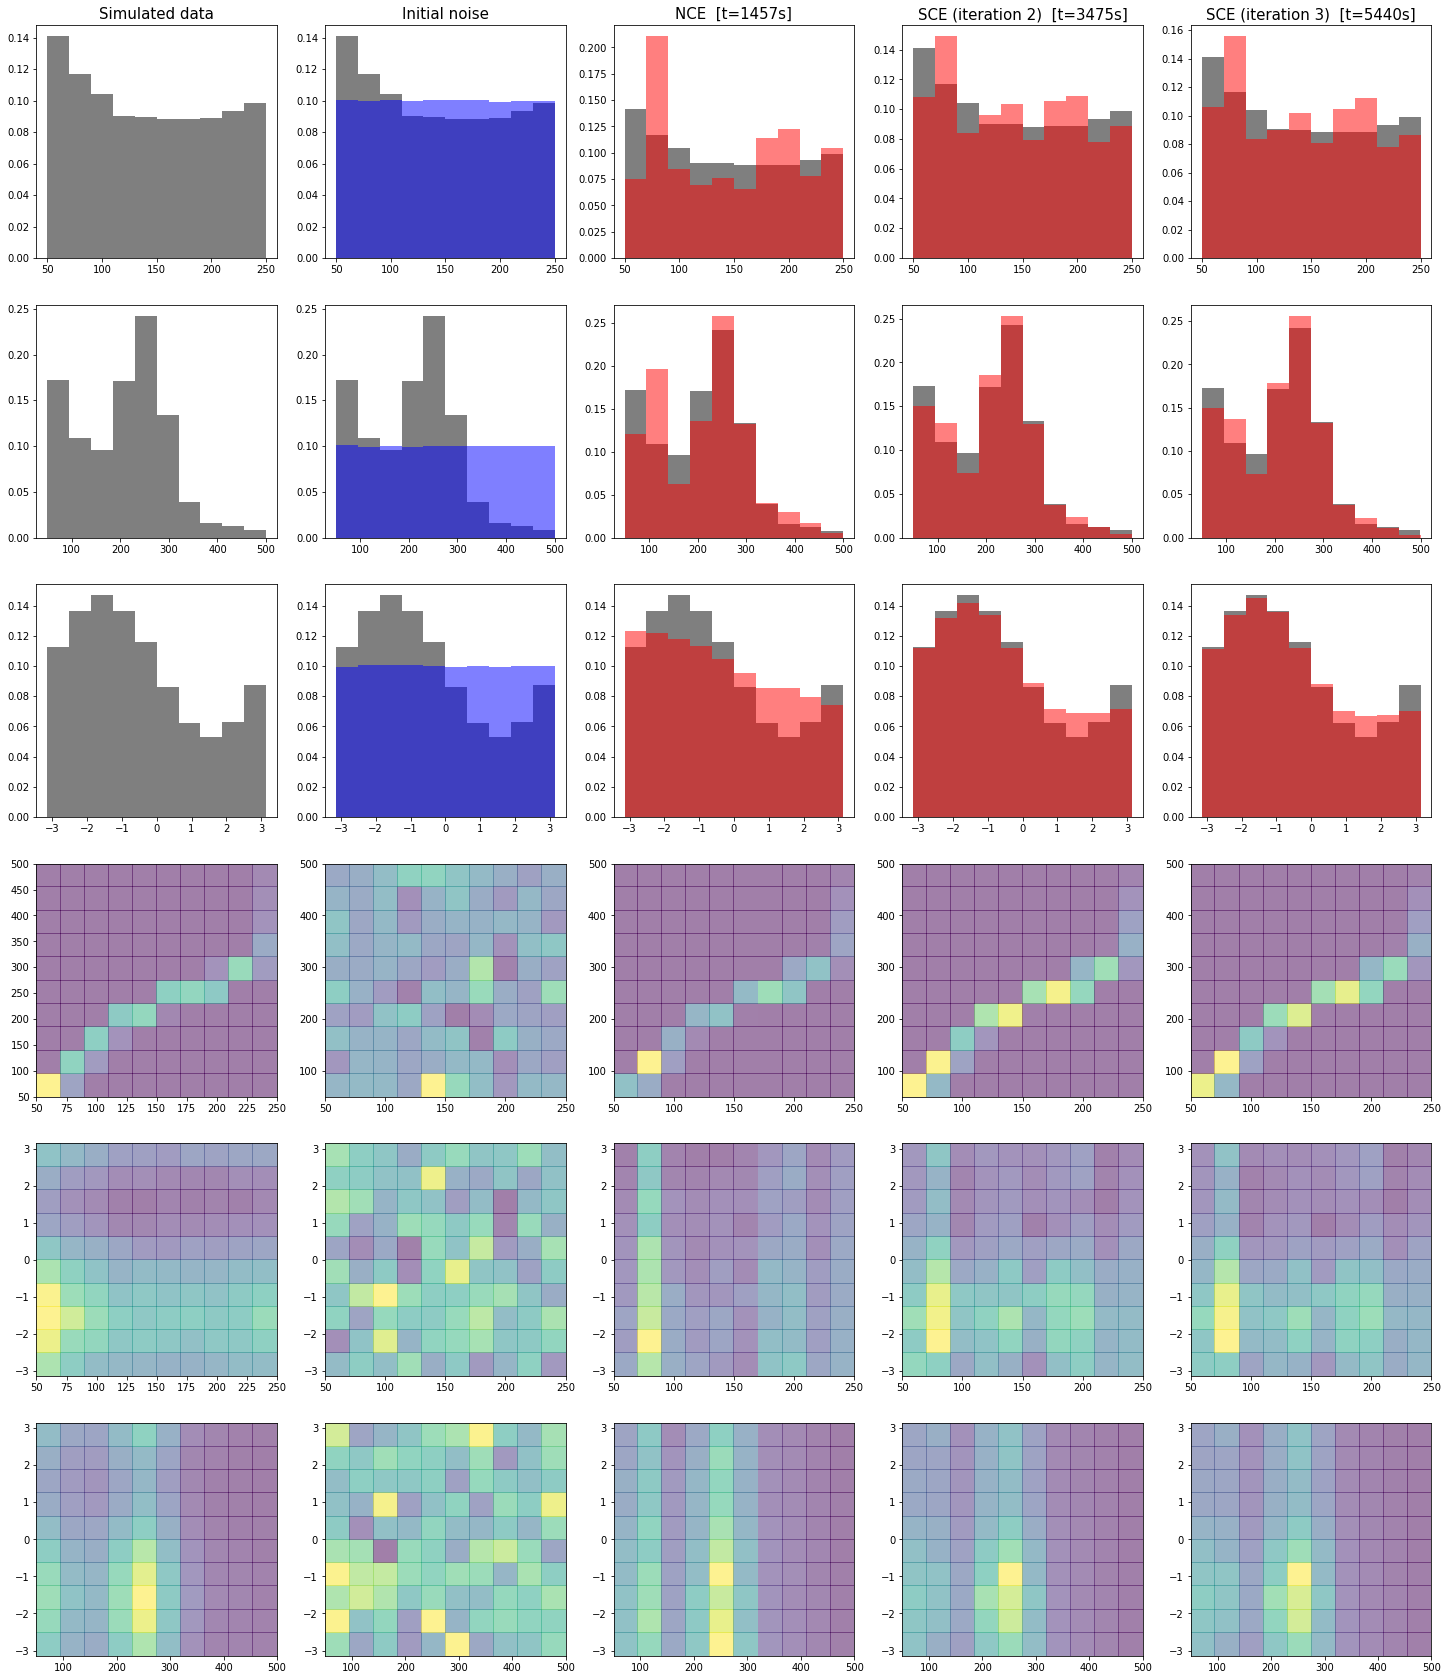

Adding 5.00% of initial noise back in
500000 noise datapoints provided
13.12% are useful (weight is > 1% of the mean)


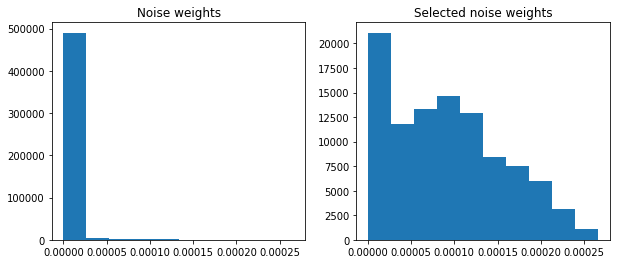

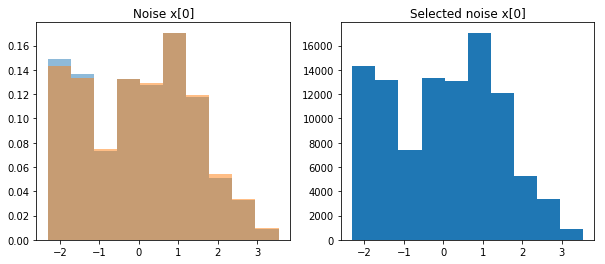

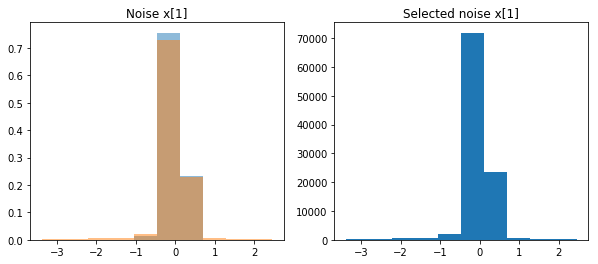

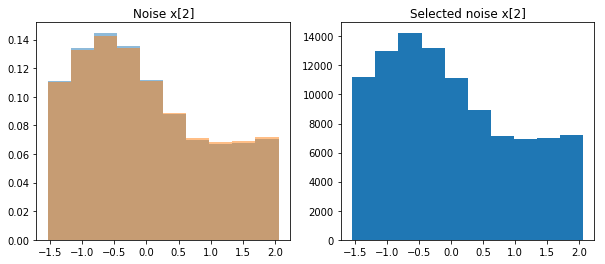

Creating discriminator with 3 observables and None conditions
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                200       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 50)                0         
_________________________________________________________

Epoch 56/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2578e-06 - val_loss: 9.2516e-06
Epoch 57/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2559e-06 - val_loss: 9.2514e-06
Epoch 58/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2581e-06 - val_loss: 9.2513e-06
Epoch 59/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2556e-06 - val_loss: 9.2511e-06
Epoch 60/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2550e-06 - val_loss: 9.2510e-06
Epoch 61/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2556e-06 - val_loss: 9.2509e-06
Epoch 62/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2564e-06 - val_loss: 9.2507e-06
Epoch 63/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2542e-06 - val_loss: 9.2506e-06
Epoch 64/10000
75000/75000 [==============================] - 0s 3us/ste

Epoch 127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2539e-06 - val_loss: 9.2474e-06
Epoch 128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2509e-06 - val_loss: 9.2474e-06
Epoch 129/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2513e-06 - val_loss: 9.2474e-06
Epoch 130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2505e-06 - val_loss: 9.2474e-06
Epoch 131/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2484e-06 - val_loss: 9.2473e-06
Epoch 132/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2510e-06 - val_loss: 9.2473e-06
Epoch 133/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2505e-06 - val_loss: 9.2473e-06
Epoch 134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2482e-06 - val_loss: 9.2472e-06
Epoch 135/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2506e-06 - val_loss: 9.2450e-06
Epoch 198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2516e-06 - val_loss: 9.2450e-06
Epoch 199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2474e-06 - val_loss: 9.2450e-06
Epoch 200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2477e-06 - val_loss: 9.2449e-06
Epoch 201/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2456e-06 - val_loss: 9.2449e-06
Epoch 202/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2496e-06 - val_loss: 9.2449e-06
Epoch 203/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2493e-06 - val_loss: 9.2448e-06
Epoch 204/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2491e-06 - val_loss: 9.2448e-06
Epoch 205/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2431e-06 - val_loss: 9.2425e-06
Epoch 269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2467e-06 - val_loss: 9.2425e-06
Epoch 270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2440e-06 - val_loss: 9.2425e-06
Epoch 271/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2476e-06 - val_loss: 9.2424e-06
Epoch 272/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2446e-06 - val_loss: 9.2424e-06
Epoch 273/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2485e-06 - val_loss: 9.2423e-06
Epoch 274/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2440e-06 - val_loss: 9.2423e-06
Epoch 275/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2466e-06 - val_loss: 9.2423e-06
Epoch 276/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2440e-06 - val_loss: 9.2401e-06
Epoch 339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2413e-06 - val_loss: 9.2401e-06
Epoch 340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2404e-06 - val_loss: 9.2401e-06
Epoch 341/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2430e-06 - val_loss: 9.2400e-06
Epoch 342/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2450e-06 - val_loss: 9.2400e-06
Epoch 343/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2462e-06 - val_loss: 9.2400e-06
Epoch 344/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2440e-06 - val_loss: 9.2399e-06
Epoch 345/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2434e-06 - val_loss: 9.2399e-06
Epoch 346/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 409/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2416e-06 - val_loss: 9.2378e-06
Epoch 410/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2434e-06 - val_loss: 9.2377e-06
Epoch 411/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2404e-06 - val_loss: 9.2377e-06
Epoch 412/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2426e-06 - val_loss: 9.2377e-06
Epoch 413/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2433e-06 - val_loss: 9.2376e-06
Epoch 414/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2381e-06 - val_loss: 9.2376e-06
Epoch 415/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2403e-06 - val_loss: 9.2376e-06
Epoch 416/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2418e-06 - val_loss: 9.2375e-06
Epoch 417/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2402e-06 - val_loss: 9.2355e-06
Epoch 480/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2384e-06 - val_loss: 9.2355e-06
Epoch 481/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2396e-06 - val_loss: 9.2355e-06
Epoch 482/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2374e-06 - val_loss: 9.2354e-06
Epoch 483/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2374e-06 - val_loss: 9.2354e-06
Epoch 484/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2406e-06 - val_loss: 9.2354e-06
Epoch 485/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2368e-06 - val_loss: 9.2353e-06
Epoch 486/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2387e-06 - val_loss: 9.2353e-06
Epoch 487/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 550/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2386e-06 - val_loss: 9.2333e-06
Epoch 551/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2367e-06 - val_loss: 9.2333e-06
Epoch 552/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2399e-06 - val_loss: 9.2332e-06
Epoch 553/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2353e-06 - val_loss: 9.2332e-06
Epoch 554/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2365e-06 - val_loss: 9.2332e-06
Epoch 555/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2365e-06 - val_loss: 9.2331e-06
Epoch 556/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2352e-06 - val_loss: 9.2331e-06
Epoch 557/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2385e-06 - val_loss: 9.2331e-06
Epoch 558/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2354e-06 - val_loss: 9.2312e-06
Epoch 621/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2351e-06 - val_loss: 9.2311e-06
Epoch 622/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2338e-06 - val_loss: 9.2311e-06
Epoch 623/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2323e-06 - val_loss: 9.2311e-06
Epoch 624/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2344e-06 - val_loss: 9.2311e-06
Epoch 625/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2333e-06 - val_loss: 9.2310e-06
Epoch 626/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2335e-06 - val_loss: 9.2310e-06
Epoch 627/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2331e-06 - val_loss: 9.2310e-06
Epoch 628/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 691/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2324e-06 - val_loss: 9.2290e-06
Epoch 692/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2314e-06 - val_loss: 9.2290e-06
Epoch 693/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2364e-06 - val_loss: 9.2289e-06
Epoch 694/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2328e-06 - val_loss: 9.2289e-06
Epoch 695/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2323e-06 - val_loss: 9.2289e-06
Epoch 696/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2327e-06 - val_loss: 9.2289e-06
Epoch 697/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2329e-06 - val_loss: 9.2288e-06
Epoch 698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2332e-06 - val_loss: 9.2288e-06
Epoch 699/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2315e-06 - val_loss: 9.2268e-06
Epoch 762/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2298e-06 - val_loss: 9.2268e-06
Epoch 763/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2288e-06 - val_loss: 9.2267e-06
Epoch 764/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2325e-06 - val_loss: 9.2267e-06
Epoch 765/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2313e-06 - val_loss: 9.2267e-06
Epoch 766/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2331e-06 - val_loss: 9.2267e-06
Epoch 767/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2298e-06 - val_loss: 9.2266e-06
Epoch 768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2308e-06 - val_loss: 9.2266e-06
Epoch 769/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 832/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2285e-06 - val_loss: 9.2247e-06
Epoch 833/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2311e-06 - val_loss: 9.2247e-06
Epoch 834/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2297e-06 - val_loss: 9.2246e-06
Epoch 835/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2273e-06 - val_loss: 9.2246e-06
Epoch 836/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2297e-06 - val_loss: 9.2246e-06
Epoch 837/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2293e-06 - val_loss: 9.2246e-06
Epoch 838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2310e-06 - val_loss: 9.2245e-06
Epoch 839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2264e-06 - val_loss: 9.2245e-06
Epoch 840/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2250e-06 - val_loss: 9.2226e-06
Epoch 903/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2238e-06 - val_loss: 9.2225e-06
Epoch 904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2269e-06 - val_loss: 9.2225e-06
Epoch 905/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2282e-06 - val_loss: 9.2225e-06
Epoch 906/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2256e-06 - val_loss: 9.2224e-06
Epoch 907/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2277e-06 - val_loss: 9.2224e-06
Epoch 908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2290e-06 - val_loss: 9.2224e-06
Epoch 909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2280e-06 - val_loss: 9.2223e-06
Epoch 910/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 973/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2254e-06 - val_loss: 9.2203e-06
Epoch 974/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2246e-06 - val_loss: 9.2203e-06
Epoch 975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2262e-06 - val_loss: 9.2203e-06
Epoch 976/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2224e-06 - val_loss: 9.2203e-06
Epoch 977/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2256e-06 - val_loss: 9.2202e-06
Epoch 978/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2258e-06 - val_loss: 9.2202e-06
Epoch 979/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2232e-06 - val_loss: 9.2202e-06
Epoch 980/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2259e-06 - val_loss: 9.2201e-06
Epoch 981/10000
75000/75000 [==============================] - 0

Epoch 1043/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2220e-06 - val_loss: 9.2180e-06
Epoch 1044/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2195e-06 - val_loss: 9.2180e-06
Epoch 1045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2204e-06 - val_loss: 9.2180e-06
Epoch 1046/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2222e-06 - val_loss: 9.2179e-06
Epoch 1047/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2234e-06 - val_loss: 9.2179e-06
Epoch 1048/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2202e-06 - val_loss: 9.2179e-06
Epoch 1049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2226e-06 - val_loss: 9.2178e-06
Epoch 1050/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2212e-06 - val_loss: 9.2178e-06
Epoch 1051/10000
75000/75000 [==========================

Epoch 1113/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2203e-06 - val_loss: 9.2156e-06
Epoch 1114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2204e-06 - val_loss: 9.2156e-06
Epoch 1115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2189e-06 - val_loss: 9.2155e-06
Epoch 1116/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2200e-06 - val_loss: 9.2155e-06
Epoch 1117/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2188e-06 - val_loss: 9.2155e-06
Epoch 1118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2192e-06 - val_loss: 9.2154e-06
Epoch 1119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2170e-06 - val_loss: 9.2154e-06
Epoch 1120/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2179e-06 - val_loss: 9.2154e-06
Epoch 1121/10000
75000/75000 [==========================

Epoch 1183/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2157e-06 - val_loss: 9.2131e-06
Epoch 1184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2173e-06 - val_loss: 9.2131e-06
Epoch 1185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2188e-06 - val_loss: 9.2130e-06
Epoch 1186/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2172e-06 - val_loss: 9.2130e-06
Epoch 1187/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2169e-06 - val_loss: 9.2130e-06
Epoch 1188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2168e-06 - val_loss: 9.2129e-06
Epoch 1189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2202e-06 - val_loss: 9.2129e-06
Epoch 1190/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2170e-06 - val_loss: 9.2129e-06
Epoch 1191/10000
75000/75000 [==========================

Epoch 1253/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2174e-06 - val_loss: 9.2105e-06
Epoch 1254/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2167e-06 - val_loss: 9.2105e-06
Epoch 1255/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2149e-06 - val_loss: 9.2104e-06
Epoch 1256/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2165e-06 - val_loss: 9.2104e-06
Epoch 1257/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2141e-06 - val_loss: 9.2104e-06
Epoch 1258/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2146e-06 - val_loss: 9.2103e-06
Epoch 1259/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2144e-06 - val_loss: 9.2103e-06
Epoch 1260/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2162e-06 - val_loss: 9.2102e-06
Epoch 1261/10000
75000/75000 [==========================

Epoch 1323/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2139e-06 - val_loss: 9.2078e-06
Epoch 1324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2130e-06 - val_loss: 9.2077e-06
Epoch 1325/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2110e-06 - val_loss: 9.2077e-06
Epoch 1326/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2130e-06 - val_loss: 9.2077e-06
Epoch 1327/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2154e-06 - val_loss: 9.2076e-06
Epoch 1328/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2130e-06 - val_loss: 9.2076e-06
Epoch 1329/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2118e-06 - val_loss: 9.2075e-06
Epoch 1330/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2141e-06 - val_loss: 9.2075e-06
Epoch 1331/10000
75000/75000 [==========================

Epoch 1393/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2137e-06 - val_loss: 9.2050e-06
Epoch 1394/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2099e-06 - val_loss: 9.2049e-06
Epoch 1395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2084e-06 - val_loss: 9.2049e-06
Epoch 1396/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2110e-06 - val_loss: 9.2049e-06
Epoch 1397/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2110e-06 - val_loss: 9.2048e-06
Epoch 1398/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.2096e-06 - val_loss: 9.2048e-06
Epoch 1399/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2113e-06 - val_loss: 9.2048e-06
Epoch 1400/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2086e-06 - val_loss: 9.2047e-06
Epoch 1401/10000
75000/75000 [==========================

Epoch 1463/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2081e-06 - val_loss: 9.2021e-06
Epoch 1464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2069e-06 - val_loss: 9.2021e-06
Epoch 1465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2069e-06 - val_loss: 9.2020e-06
Epoch 1466/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2074e-06 - val_loss: 9.2020e-06
Epoch 1467/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2084e-06 - val_loss: 9.2019e-06
Epoch 1468/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2092e-06 - val_loss: 9.2019e-06
Epoch 1469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2076e-06 - val_loss: 9.2018e-06
Epoch 1470/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2054e-06 - val_loss: 9.2018e-06
Epoch 1471/10000
75000/75000 [==========================

Epoch 1533/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2066e-06 - val_loss: 9.1991e-06
Epoch 1534/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2039e-06 - val_loss: 9.1991e-06
Epoch 1535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2037e-06 - val_loss: 9.1990e-06
Epoch 1536/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2065e-06 - val_loss: 9.1990e-06
Epoch 1537/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2031e-06 - val_loss: 9.1990e-06
Epoch 1538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2077e-06 - val_loss: 9.1989e-06
Epoch 1539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2041e-06 - val_loss: 9.1989e-06
Epoch 1540/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2037e-06 - val_loss: 9.1988e-06
Epoch 1541/10000
75000/75000 [==========================

Epoch 1603/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1982e-06 - val_loss: 9.1960e-06
Epoch 1604/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1999e-06 - val_loss: 9.1960e-06
Epoch 1605/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2040e-06 - val_loss: 9.1959e-06
Epoch 1606/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1987e-06 - val_loss: 9.1959e-06
Epoch 1607/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2030e-06 - val_loss: 9.1958e-06
Epoch 1608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2020e-06 - val_loss: 9.1958e-06
Epoch 1609/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1999e-06 - val_loss: 9.1958e-06
Epoch 1610/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2023e-06 - val_loss: 9.1957e-06
Epoch 1611/10000
75000/75000 [==========================

Epoch 1673/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1987e-06 - val_loss: 9.1929e-06
Epoch 1674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1988e-06 - val_loss: 9.1929e-06
Epoch 1675/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2013e-06 - val_loss: 9.1928e-06
Epoch 1676/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2006e-06 - val_loss: 9.1928e-06
Epoch 1677/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1985e-06 - val_loss: 9.1927e-06
Epoch 1678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1971e-06 - val_loss: 9.1927e-06
Epoch 1679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1991e-06 - val_loss: 9.1926e-06
Epoch 1680/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1986e-06 - val_loss: 9.1926e-06
Epoch 1681/10000
75000/75000 [==========================

Epoch 1743/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1947e-06 - val_loss: 9.1898e-06
Epoch 1744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1938e-06 - val_loss: 9.1897e-06
Epoch 1745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1951e-06 - val_loss: 9.1897e-06
Epoch 1746/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1945e-06 - val_loss: 9.1896e-06
Epoch 1747/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1978e-06 - val_loss: 9.1896e-06
Epoch 1748/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1958e-06 - val_loss: 9.1895e-06
Epoch 1749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1978e-06 - val_loss: 9.1895e-06
Epoch 1750/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1962e-06 - val_loss: 9.1894e-06
Epoch 1751/10000
75000/75000 [==========================

Epoch 1813/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1911e-06 - val_loss: 9.1865e-06
Epoch 1814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1899e-06 - val_loss: 9.1864e-06
Epoch 1815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1931e-06 - val_loss: 9.1864e-06
Epoch 1816/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1953e-06 - val_loss: 9.1863e-06
Epoch 1817/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1951e-06 - val_loss: 9.1863e-06
Epoch 1818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1941e-06 - val_loss: 9.1862e-06
Epoch 1819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1938e-06 - val_loss: 9.1862e-06
Epoch 1820/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1917e-06 - val_loss: 9.1861e-06
Epoch 1821/10000
75000/75000 [==========================

Epoch 1883/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1902e-06 - val_loss: 9.1831e-06
Epoch 1884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1912e-06 - val_loss: 9.1831e-06
Epoch 1885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1893e-06 - val_loss: 9.1830e-06
Epoch 1886/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1890e-06 - val_loss: 9.1830e-06
Epoch 1887/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1902e-06 - val_loss: 9.1829e-06
Epoch 1888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1868e-06 - val_loss: 9.1829e-06
Epoch 1889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1920e-06 - val_loss: 9.1828e-06
Epoch 1890/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1894e-06 - val_loss: 9.1828e-06
Epoch 1891/10000
75000/75000 [==========================

Epoch 1953/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1872e-06 - val_loss: 9.1797e-06
Epoch 1954/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1851e-06 - val_loss: 9.1796e-06
Epoch 1955/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1850e-06 - val_loss: 9.1796e-06
Epoch 1956/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1876e-06 - val_loss: 9.1795e-06
Epoch 1957/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1883e-06 - val_loss: 9.1795e-06
Epoch 1958/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1868e-06 - val_loss: 9.1795e-06
Epoch 1959/10000
75000/75000 [==============================] - 0s 6us/step - loss: 9.1876e-06 - val_loss: 9.1794e-06
Epoch 1960/10000
75000/75000 [==============================] - 1s 9us/step - loss: 9.1847e-06 - val_loss: 9.1794e-06
Epoch 1961/10000
75000/75000 [==========================

Epoch 2023/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1839e-06 - val_loss: 9.1763e-06
Epoch 2024/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1847e-06 - val_loss: 9.1762e-06
Epoch 2025/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1826e-06 - val_loss: 9.1762e-06
Epoch 2026/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1802e-06 - val_loss: 9.1761e-06
Epoch 2027/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1821e-06 - val_loss: 9.1761e-06
Epoch 2028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1821e-06 - val_loss: 9.1760e-06
Epoch 2029/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1833e-06 - val_loss: 9.1760e-06
Epoch 2030/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1815e-06 - val_loss: 9.1759e-06
Epoch 2031/10000
75000/75000 [==========================

Epoch 2093/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1825e-06 - val_loss: 9.1728e-06
Epoch 2094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1807e-06 - val_loss: 9.1727e-06
Epoch 2095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1806e-06 - val_loss: 9.1727e-06
Epoch 2096/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1777e-06 - val_loss: 9.1726e-06
Epoch 2097/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1788e-06 - val_loss: 9.1726e-06
Epoch 2098/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1791e-06 - val_loss: 9.1725e-06
Epoch 2099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1765e-06 - val_loss: 9.1725e-06
Epoch 2100/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1815e-06 - val_loss: 9.1724e-06
Epoch 2101/10000
75000/75000 [==========================

Epoch 2163/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1789e-06 - val_loss: 9.1694e-06
Epoch 2164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1788e-06 - val_loss: 9.1693e-06
Epoch 2165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1774e-06 - val_loss: 9.1693e-06
Epoch 2166/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1779e-06 - val_loss: 9.1693e-06
Epoch 2167/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1725e-06 - val_loss: 9.1692e-06
Epoch 2168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1748e-06 - val_loss: 9.1692e-06
Epoch 2169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1792e-06 - val_loss: 9.1691e-06
Epoch 2170/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1787e-06 - val_loss: 9.1691e-06
Epoch 2171/10000
75000/75000 [==========================

Epoch 2233/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1730e-06 - val_loss: 9.1659e-06
Epoch 2234/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1743e-06 - val_loss: 9.1659e-06
Epoch 2235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1755e-06 - val_loss: 9.1658e-06
Epoch 2236/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1721e-06 - val_loss: 9.1658e-06
Epoch 2237/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1747e-06 - val_loss: 9.1657e-06
Epoch 2238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1730e-06 - val_loss: 9.1657e-06
Epoch 2239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1739e-06 - val_loss: 9.1656e-06
Epoch 2240/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1705e-06 - val_loss: 9.1656e-06
Epoch 2241/10000
75000/75000 [==========================

Epoch 2303/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1678e-06 - val_loss: 9.1625e-06
Epoch 2304/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1698e-06 - val_loss: 9.1625e-06
Epoch 2305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1709e-06 - val_loss: 9.1624e-06
Epoch 2306/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1700e-06 - val_loss: 9.1624e-06
Epoch 2307/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1699e-06 - val_loss: 9.1623e-06
Epoch 2308/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1702e-06 - val_loss: 9.1623e-06
Epoch 2309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1685e-06 - val_loss: 9.1622e-06
Epoch 2310/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1734e-06 - val_loss: 9.1622e-06
Epoch 2311/10000
75000/75000 [==========================

Epoch 2373/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1666e-06 - val_loss: 9.1592e-06
Epoch 2374/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1677e-06 - val_loss: 9.1591e-06
Epoch 2375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1636e-06 - val_loss: 9.1591e-06
Epoch 2376/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1683e-06 - val_loss: 9.1590e-06
Epoch 2377/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1675e-06 - val_loss: 9.1590e-06
Epoch 2378/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1700e-06 - val_loss: 9.1589e-06
Epoch 2379/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1689e-06 - val_loss: 9.1589e-06
Epoch 2380/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1688e-06 - val_loss: 9.1588e-06
Epoch 2381/10000
75000/75000 [==========================

Epoch 2443/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1629e-06 - val_loss: 9.1558e-06
Epoch 2444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1624e-06 - val_loss: 9.1558e-06
Epoch 2445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1662e-06 - val_loss: 9.1557e-06
Epoch 2446/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1664e-06 - val_loss: 9.1557e-06
Epoch 2447/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1655e-06 - val_loss: 9.1556e-06
Epoch 2448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1648e-06 - val_loss: 9.1556e-06
Epoch 2449/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1650e-06 - val_loss: 9.1555e-06
Epoch 2450/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1660e-06 - val_loss: 9.1555e-06
Epoch 2451/10000
75000/75000 [==========================

Epoch 2513/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1618e-06 - val_loss: 9.1525e-06
Epoch 2514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1638e-06 - val_loss: 9.1525e-06
Epoch 2515/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1608e-06 - val_loss: 9.1524e-06
Epoch 2516/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1635e-06 - val_loss: 9.1524e-06
Epoch 2517/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1606e-06 - val_loss: 9.1523e-06
Epoch 2518/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1589e-06 - val_loss: 9.1523e-06
Epoch 2519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1618e-06 - val_loss: 9.1522e-06
Epoch 2520/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1631e-06 - val_loss: 9.1522e-06
Epoch 2521/10000
75000/75000 [==========================

Epoch 2583/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1599e-06 - val_loss: 9.1494e-06
Epoch 2584/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1609e-06 - val_loss: 9.1493e-06
Epoch 2585/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1578e-06 - val_loss: 9.1493e-06
Epoch 2586/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1589e-06 - val_loss: 9.1492e-06
Epoch 2587/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1579e-06 - val_loss: 9.1492e-06
Epoch 2588/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1581e-06 - val_loss: 9.1491e-06
Epoch 2589/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1570e-06 - val_loss: 9.1491e-06
Epoch 2590/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1584e-06 - val_loss: 9.1490e-06
Epoch 2591/10000
75000/75000 [==========================

Epoch 2653/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1546e-06 - val_loss: 9.1462e-06
Epoch 2654/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1578e-06 - val_loss: 9.1462e-06
Epoch 2655/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1576e-06 - val_loss: 9.1461e-06
Epoch 2656/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1562e-06 - val_loss: 9.1461e-06
Epoch 2657/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1524e-06 - val_loss: 9.1460e-06
Epoch 2658/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1557e-06 - val_loss: 9.1460e-06
Epoch 2659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1570e-06 - val_loss: 9.1459e-06
Epoch 2660/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1568e-06 - val_loss: 9.1459e-06
Epoch 2661/10000
75000/75000 [==========================

Epoch 2723/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1510e-06 - val_loss: 9.1433e-06
Epoch 2724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1525e-06 - val_loss: 9.1433e-06
Epoch 2725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1537e-06 - val_loss: 9.1432e-06
Epoch 2726/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1537e-06 - val_loss: 9.1432e-06
Epoch 2727/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1540e-06 - val_loss: 9.1431e-06
Epoch 2728/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1525e-06 - val_loss: 9.1431e-06
Epoch 2729/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1522e-06 - val_loss: 9.1430e-06
Epoch 2730/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1535e-06 - val_loss: 9.1430e-06
Epoch 2731/10000
75000/75000 [==========================

Epoch 2793/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1521e-06 - val_loss: 9.1404e-06
Epoch 2794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1511e-06 - val_loss: 9.1404e-06
Epoch 2795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1478e-06 - val_loss: 9.1404e-06
Epoch 2796/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1524e-06 - val_loss: 9.1403e-06
Epoch 2797/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1519e-06 - val_loss: 9.1403e-06
Epoch 2798/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1518e-06 - val_loss: 9.1402e-06
Epoch 2799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1537e-06 - val_loss: 9.1402e-06
Epoch 2800/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1510e-06 - val_loss: 9.1402e-06
Epoch 2801/10000
75000/75000 [==========================

Epoch 2863/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1474e-06 - val_loss: 9.1377e-06
Epoch 2864/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1483e-06 - val_loss: 9.1377e-06
Epoch 2865/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1467e-06 - val_loss: 9.1376e-06
Epoch 2866/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.1376e-06
Epoch 2867/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.1376e-06
Epoch 2868/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1466e-06 - val_loss: 9.1375e-06
Epoch 2869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1454e-06 - val_loss: 9.1375e-06
Epoch 2870/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1491e-06 - val_loss: 9.1374e-06
Epoch 2871/10000
75000/75000 [==========================

Epoch 2933/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1425e-06 - val_loss: 9.1351e-06
Epoch 2934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1467e-06 - val_loss: 9.1351e-06
Epoch 2935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1478e-06 - val_loss: 9.1351e-06
Epoch 2936/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.1350e-06
Epoch 2937/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1470e-06 - val_loss: 9.1350e-06
Epoch 2938/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1429e-06 - val_loss: 9.1350e-06
Epoch 2939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1461e-06 - val_loss: 9.1349e-06
Epoch 2940/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.1349e-06
Epoch 2941/10000
75000/75000 [==========================

Epoch 3003/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1473e-06 - val_loss: 9.1328e-06
Epoch 3004/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1429e-06 - val_loss: 9.1327e-06
Epoch 3005/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1428e-06 - val_loss: 9.1327e-06
Epoch 3006/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1418e-06 - val_loss: 9.1327e-06
Epoch 3007/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1440e-06 - val_loss: 9.1326e-06
Epoch 3008/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1469e-06 - val_loss: 9.1326e-06
Epoch 3009/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1420e-06 - val_loss: 9.1326e-06
Epoch 3010/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1464e-06 - val_loss: 9.1325e-06
Epoch 3011/10000
75000/75000 [==========================

Epoch 3073/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1406e-06 - val_loss: 9.1305e-06
Epoch 3074/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1448e-06 - val_loss: 9.1304e-06
Epoch 3075/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1400e-06 - val_loss: 9.1304e-06
Epoch 3076/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1410e-06 - val_loss: 9.1304e-06
Epoch 3077/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1410e-06 - val_loss: 9.1303e-06
Epoch 3078/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1417e-06 - val_loss: 9.1303e-06
Epoch 3079/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1420e-06 - val_loss: 9.1303e-06
Epoch 3080/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1435e-06 - val_loss: 9.1302e-06
Epoch 3081/10000
75000/75000 [==========================

Epoch 3143/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1394e-06 - val_loss: 9.1282e-06
Epoch 3144/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1416e-06 - val_loss: 9.1282e-06
Epoch 3145/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1412e-06 - val_loss: 9.1282e-06
Epoch 3146/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1345e-06 - val_loss: 9.1281e-06
Epoch 3147/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1390e-06 - val_loss: 9.1281e-06
Epoch 3148/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1357e-06 - val_loss: 9.1281e-06
Epoch 3149/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1390e-06 - val_loss: 9.1280e-06
Epoch 3150/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1423e-06 - val_loss: 9.1280e-06
Epoch 3151/10000
75000/75000 [==========================

Epoch 3213/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1399e-06 - val_loss: 9.1260e-06
Epoch 3214/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1352e-06 - val_loss: 9.1260e-06
Epoch 3215/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1372e-06 - val_loss: 9.1259e-06
Epoch 3216/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1375e-06 - val_loss: 9.1259e-06
Epoch 3217/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1352e-06 - val_loss: 9.1259e-06
Epoch 3218/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1380e-06 - val_loss: 9.1258e-06
Epoch 3219/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1340e-06 - val_loss: 9.1258e-06
Epoch 3220/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1354e-06 - val_loss: 9.1258e-06
Epoch 3221/10000
75000/75000 [==========================

Epoch 3283/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1338e-06 - val_loss: 9.1240e-06
Epoch 3284/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1341e-06 - val_loss: 9.1240e-06
Epoch 3285/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1371e-06 - val_loss: 9.1239e-06
Epoch 3286/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1344e-06 - val_loss: 9.1239e-06
Epoch 3287/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1340e-06 - val_loss: 9.1239e-06
Epoch 3288/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1352e-06 - val_loss: 9.1238e-06
Epoch 3289/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1352e-06 - val_loss: 9.1238e-06
Epoch 3290/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1369e-06 - val_loss: 9.1238e-06
Epoch 3291/10000
75000/75000 [==========================

Epoch 3353/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1328e-06 - val_loss: 9.1221e-06
Epoch 3354/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1324e-06 - val_loss: 9.1220e-06
Epoch 3355/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1341e-06 - val_loss: 9.1220e-06
Epoch 3356/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1326e-06 - val_loss: 9.1220e-06
Epoch 3357/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1351e-06 - val_loss: 9.1220e-06
Epoch 3358/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1333e-06 - val_loss: 9.1219e-06
Epoch 3359/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1337e-06 - val_loss: 9.1219e-06
Epoch 3360/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1366e-06 - val_loss: 9.1219e-06
Epoch 3361/10000
75000/75000 [==========================

Epoch 3423/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1285e-06 - val_loss: 9.1200e-06
Epoch 3424/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1303e-06 - val_loss: 9.1200e-06
Epoch 3425/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1313e-06 - val_loss: 9.1200e-06
Epoch 3426/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1309e-06 - val_loss: 9.1200e-06
Epoch 3427/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1327e-06 - val_loss: 9.1199e-06
Epoch 3428/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1324e-06 - val_loss: 9.1199e-06
Epoch 3429/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1269e-06 - val_loss: 9.1199e-06
Epoch 3430/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1287e-06 - val_loss: 9.1198e-06
Epoch 3431/10000
75000/75000 [==========================

Epoch 3493/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1287e-06 - val_loss: 9.1181e-06
Epoch 3494/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1265e-06 - val_loss: 9.1181e-06
Epoch 3495/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1275e-06 - val_loss: 9.1181e-06
Epoch 3496/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1329e-06 - val_loss: 9.1181e-06
Epoch 3497/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1280e-06 - val_loss: 9.1180e-06
Epoch 3498/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1288e-06 - val_loss: 9.1180e-06
Epoch 3499/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1285e-06 - val_loss: 9.1180e-06
Epoch 3500/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1309e-06 - val_loss: 9.1180e-06
Epoch 3501/10000
75000/75000 [==========================

Epoch 3563/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1266e-06 - val_loss: 9.1163e-06
Epoch 3564/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1269e-06 - val_loss: 9.1162e-06
Epoch 3565/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1305e-06 - val_loss: 9.1162e-06
Epoch 3566/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1302e-06 - val_loss: 9.1162e-06
Epoch 3567/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1275e-06 - val_loss: 9.1162e-06
Epoch 3568/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1308e-06 - val_loss: 9.1161e-06
Epoch 3569/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1292e-06 - val_loss: 9.1161e-06
Epoch 3570/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1264e-06 - val_loss: 9.1161e-06
Epoch 3571/10000
75000/75000 [==========================

Epoch 3633/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1275e-06 - val_loss: 9.1143e-06
Epoch 3634/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1266e-06 - val_loss: 9.1143e-06
Epoch 3635/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1275e-06 - val_loss: 9.1143e-06
Epoch 3636/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1262e-06 - val_loss: 9.1143e-06
Epoch 3637/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1182e-06 - val_loss: 9.1142e-06
Epoch 3638/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1260e-06 - val_loss: 9.1142e-06
Epoch 3639/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1264e-06 - val_loss: 9.1142e-06
Epoch 3640/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1255e-06 - val_loss: 9.1142e-06
Epoch 3641/10000
75000/75000 [==========================

Epoch 3703/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1261e-06 - val_loss: 9.1125e-06
Epoch 3704/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1227e-06 - val_loss: 9.1125e-06
Epoch 3705/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1245e-06 - val_loss: 9.1125e-06
Epoch 3706/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1228e-06 - val_loss: 9.1124e-06
Epoch 3707/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1257e-06 - val_loss: 9.1124e-06
Epoch 3708/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1239e-06 - val_loss: 9.1124e-06
Epoch 3709/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1277e-06 - val_loss: 9.1124e-06
Epoch 3710/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1226e-06 - val_loss: 9.1123e-06
Epoch 3711/10000
75000/75000 [==========================

Epoch 3773/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1240e-06 - val_loss: 9.1108e-06
Epoch 3774/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1261e-06 - val_loss: 9.1107e-06
Epoch 3775/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1234e-06 - val_loss: 9.1107e-06
Epoch 3776/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1216e-06 - val_loss: 9.1107e-06
Epoch 3777/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1200e-06 - val_loss: 9.1107e-06
Epoch 3778/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1221e-06 - val_loss: 9.1107e-06
Epoch 3779/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1213e-06 - val_loss: 9.1106e-06
Epoch 3780/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1229e-06 - val_loss: 9.1106e-06
Epoch 3781/10000
75000/75000 [==========================

Epoch 3843/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1246e-06 - val_loss: 9.1091e-06
Epoch 3844/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1220e-06 - val_loss: 9.1091e-06
Epoch 3845/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1203e-06 - val_loss: 9.1091e-06
Epoch 3846/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1236e-06 - val_loss: 9.1090e-06
Epoch 3847/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1192e-06 - val_loss: 9.1090e-06
Epoch 3848/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1225e-06 - val_loss: 9.1090e-06
Epoch 3849/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1193e-06 - val_loss: 9.1090e-06
Epoch 3850/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1216e-06 - val_loss: 9.1090e-06
Epoch 3851/10000
75000/75000 [==========================

Epoch 3913/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1199e-06 - val_loss: 9.1077e-06
Epoch 3914/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1212e-06 - val_loss: 9.1076e-06
Epoch 3915/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1244e-06 - val_loss: 9.1076e-06
Epoch 3916/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1215e-06 - val_loss: 9.1076e-06
Epoch 3917/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1209e-06 - val_loss: 9.1076e-06
Epoch 3918/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1206e-06 - val_loss: 9.1075e-06
Epoch 3919/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1202e-06 - val_loss: 9.1075e-06
Epoch 3920/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1194e-06 - val_loss: 9.1075e-06
Epoch 3921/10000
75000/75000 [==========================

Epoch 3983/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1155e-06 - val_loss: 9.1062e-06
Epoch 3984/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1197e-06 - val_loss: 9.1061e-06
Epoch 3985/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1210e-06 - val_loss: 9.1061e-06
Epoch 3986/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1192e-06 - val_loss: 9.1061e-06
Epoch 3987/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1190e-06 - val_loss: 9.1061e-06
Epoch 3988/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1164e-06 - val_loss: 9.1061e-06
Epoch 3989/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1176e-06 - val_loss: 9.1060e-06
Epoch 3990/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1194e-06 - val_loss: 9.1060e-06
Epoch 3991/10000
75000/75000 [==========================

Epoch 4053/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1192e-06 - val_loss: 9.1047e-06
Epoch 4054/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1145e-06 - val_loss: 9.1047e-06
Epoch 4055/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1165e-06 - val_loss: 9.1047e-06
Epoch 4056/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1181e-06 - val_loss: 9.1047e-06
Epoch 4057/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1160e-06 - val_loss: 9.1046e-06
Epoch 4058/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1188e-06 - val_loss: 9.1046e-06
Epoch 4059/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1136e-06 - val_loss: 9.1046e-06
Epoch 4060/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1148e-06 - val_loss: 9.1046e-06
Epoch 4061/10000
75000/75000 [==========================

Epoch 4123/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1084e-06 - val_loss: 9.1033e-06
Epoch 4124/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1148e-06 - val_loss: 9.1033e-06
Epoch 4125/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1157e-06 - val_loss: 9.1032e-06
Epoch 4126/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1165e-06 - val_loss: 9.1032e-06
Epoch 4127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1132e-06 - val_loss: 9.1032e-06
Epoch 4128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1179e-06 - val_loss: 9.1032e-06
Epoch 4129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1151e-06 - val_loss: 9.1032e-06
Epoch 4130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1157e-06 - val_loss: 9.1032e-06
Epoch 4131/10000
75000/75000 [==========================

Epoch 4193/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1213e-06 - val_loss: 9.1020e-06
Epoch 4194/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1133e-06 - val_loss: 9.1020e-06
Epoch 4195/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1147e-06 - val_loss: 9.1020e-06
Epoch 4196/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1154e-06 - val_loss: 9.1019e-06
Epoch 4197/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1138e-06 - val_loss: 9.1019e-06
Epoch 4198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1159e-06 - val_loss: 9.1019e-06
Epoch 4199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1156e-06 - val_loss: 9.1019e-06
Epoch 4200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1114e-06 - val_loss: 9.1019e-06
Epoch 4201/10000
75000/75000 [==========================

Epoch 4263/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1141e-06 - val_loss: 9.1008e-06
Epoch 4264/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1147e-06 - val_loss: 9.1008e-06
Epoch 4265/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1156e-06 - val_loss: 9.1008e-06
Epoch 4266/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1164e-06 - val_loss: 9.1008e-06
Epoch 4267/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1111e-06 - val_loss: 9.1008e-06
Epoch 4268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1124e-06 - val_loss: 9.1008e-06
Epoch 4269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1161e-06 - val_loss: 9.1008e-06
Epoch 4270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1152e-06 - val_loss: 9.1008e-06
Epoch 4271/10000
75000/75000 [==========================

Epoch 4333/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1139e-06 - val_loss: 9.0998e-06
Epoch 4334/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1139e-06 - val_loss: 9.0998e-06
Epoch 4335/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1103e-06 - val_loss: 9.0998e-06
Epoch 4336/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1116e-06 - val_loss: 9.0997e-06
Epoch 4337/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1098e-06 - val_loss: 9.0997e-06
Epoch 4338/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1107e-06 - val_loss: 9.0997e-06
Epoch 4339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1140e-06 - val_loss: 9.0997e-06
Epoch 4340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1139e-06 - val_loss: 9.0997e-06
Epoch 4341/10000
75000/75000 [==========================

75000/75000 [==============================] - 0s 3us/step - loss: 9.1098e-06 - val_loss: 9.0987e-06
Epoch 4403/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1138e-06 - val_loss: 9.0987e-06
Epoch 4404/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1109e-06 - val_loss: 9.0987e-06
Epoch 4405/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1099e-06 - val_loss: 9.0986e-06
Epoch 4406/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1098e-06 - val_loss: 9.0986e-06
Epoch 4407/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1105e-06 - val_loss: 9.0986e-06
Epoch 4408/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1059e-06 - val_loss: 9.0986e-06
Epoch 4409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1131e-06 - val_loss: 9.0986e-06
Epoch 4410/10000
75000/75000 [==============================] - 0s 3us/st

Epoch 4472/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1053e-06 - val_loss: 9.0975e-06
Epoch 4473/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1104e-06 - val_loss: 9.0975e-06
Epoch 4474/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1140e-06 - val_loss: 9.0975e-06
Epoch 4475/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1090e-06 - val_loss: 9.0974e-06
Epoch 4476/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1093e-06 - val_loss: 9.0974e-06
Epoch 4477/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1107e-06 - val_loss: 9.0974e-06
Epoch 4478/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1099e-06 - val_loss: 9.0974e-06
Epoch 4479/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1093e-06 - val_loss: 9.0974e-06
Epoch 4480/10000
75000/75000 [==========================

Epoch 4542/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1080e-06 - val_loss: 9.0965e-06
Epoch 4543/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1077e-06 - val_loss: 9.0964e-06
Epoch 4544/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1077e-06 - val_loss: 9.0964e-06
Epoch 4545/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1057e-06 - val_loss: 9.0964e-06
Epoch 4546/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1090e-06 - val_loss: 9.0964e-06
Epoch 4547/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1095e-06 - val_loss: 9.0964e-06
Epoch 4548/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1087e-06 - val_loss: 9.0963e-06
Epoch 4549/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1109e-06 - val_loss: 9.0963e-06
Epoch 4550/10000
75000/75000 [==========================

Epoch 4612/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1035e-06 - val_loss: 9.0954e-06
Epoch 4613/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1087e-06 - val_loss: 9.0953e-06
Epoch 4614/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1075e-06 - val_loss: 9.0953e-06
Epoch 4615/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1084e-06 - val_loss: 9.0953e-06
Epoch 4616/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1108e-06 - val_loss: 9.0953e-06
Epoch 4617/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1078e-06 - val_loss: 9.0953e-06
Epoch 4618/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1081e-06 - val_loss: 9.0953e-06
Epoch 4619/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1060e-06 - val_loss: 9.0952e-06
Epoch 4620/10000
75000/75000 [==========================

Epoch 4682/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1088e-06 - val_loss: 9.0943e-06
Epoch 4683/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1067e-06 - val_loss: 9.0943e-06
Epoch 4684/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1042e-06 - val_loss: 9.0943e-06
Epoch 4685/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1043e-06 - val_loss: 9.0942e-06
Epoch 4686/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1119e-06 - val_loss: 9.0942e-06
Epoch 4687/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1048e-06 - val_loss: 9.0942e-06
Epoch 4688/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1097e-06 - val_loss: 9.0942e-06
Epoch 4689/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1107e-06 - val_loss: 9.0942e-06
Epoch 4690/10000
75000/75000 [==========================

Epoch 4752/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1052e-06 - val_loss: 9.0933e-06
Epoch 4753/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1065e-06 - val_loss: 9.0933e-06
Epoch 4754/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1067e-06 - val_loss: 9.0933e-06
Epoch 4755/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1066e-06 - val_loss: 9.0933e-06
Epoch 4756/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1049e-06 - val_loss: 9.0933e-06
Epoch 4757/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1025e-06 - val_loss: 9.0932e-06
Epoch 4758/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1056e-06 - val_loss: 9.0932e-06
Epoch 4759/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1066e-06 - val_loss: 9.0932e-06
Epoch 4760/10000
75000/75000 [==========================

Epoch 4822/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1041e-06 - val_loss: 9.0923e-06
Epoch 4823/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1024e-06 - val_loss: 9.0923e-06
Epoch 4824/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1039e-06 - val_loss: 9.0923e-06
Epoch 4825/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1078e-06 - val_loss: 9.0923e-06
Epoch 4826/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1059e-06 - val_loss: 9.0922e-06
Epoch 4827/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1023e-06 - val_loss: 9.0922e-06
Epoch 4828/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1047e-06 - val_loss: 9.0922e-06
Epoch 4829/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1065e-06 - val_loss: 9.0922e-06
Epoch 4830/10000
75000/75000 [==========================

Epoch 4892/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1051e-06 - val_loss: 9.0913e-06
Epoch 4893/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1040e-06 - val_loss: 9.0913e-06
Epoch 4894/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1033e-06 - val_loss: 9.0913e-06
Epoch 4895/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1010e-06 - val_loss: 9.0913e-06
Epoch 4896/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1053e-06 - val_loss: 9.0913e-06
Epoch 4897/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0987e-06 - val_loss: 9.0913e-06
Epoch 4898/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1040e-06 - val_loss: 9.0912e-06
Epoch 4899/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1049e-06 - val_loss: 9.0912e-06
Epoch 4900/10000
75000/75000 [==========================

Epoch 4962/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1056e-06 - val_loss: 9.0903e-06
Epoch 4963/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1035e-06 - val_loss: 9.0903e-06
Epoch 4964/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1027e-06 - val_loss: 9.0903e-06
Epoch 4965/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1027e-06 - val_loss: 9.0903e-06
Epoch 4966/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1028e-06 - val_loss: 9.0903e-06
Epoch 4967/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1017e-06 - val_loss: 9.0903e-06
Epoch 4968/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1023e-06 - val_loss: 9.0902e-06
Epoch 4969/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0988e-06 - val_loss: 9.0902e-06
Epoch 4970/10000
75000/75000 [==========================

Epoch 5032/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1047e-06 - val_loss: 9.0893e-06
Epoch 5033/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1004e-06 - val_loss: 9.0893e-06
Epoch 5034/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1032e-06 - val_loss: 9.0893e-06
Epoch 5035/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1010e-06 - val_loss: 9.0893e-06
Epoch 5036/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1035e-06 - val_loss: 9.0893e-06
Epoch 5037/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1027e-06 - val_loss: 9.0893e-06
Epoch 5038/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1036e-06 - val_loss: 9.0892e-06
Epoch 5039/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1006e-06 - val_loss: 9.0892e-06
Epoch 5040/10000
75000/75000 [==========================

Epoch 5102/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1010e-06 - val_loss: 9.0884e-06
Epoch 5103/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0999e-06 - val_loss: 9.0884e-06
Epoch 5104/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0999e-06 - val_loss: 9.0884e-06
Epoch 5105/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1015e-06 - val_loss: 9.0884e-06
Epoch 5106/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1001e-06 - val_loss: 9.0884e-06
Epoch 5107/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1023e-06 - val_loss: 9.0884e-06
Epoch 5108/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1024e-06 - val_loss: 9.0883e-06
Epoch 5109/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0990e-06 - val_loss: 9.0883e-06
Epoch 5110/10000
75000/75000 [==========================

Epoch 5172/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0978e-06 - val_loss: 9.0874e-06
Epoch 5173/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1007e-06 - val_loss: 9.0874e-06
Epoch 5174/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1016e-06 - val_loss: 9.0874e-06
Epoch 5175/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1036e-06 - val_loss: 9.0873e-06
Epoch 5176/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1019e-06 - val_loss: 9.0873e-06
Epoch 5177/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1006e-06 - val_loss: 9.0873e-06
Epoch 5178/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0989e-06 - val_loss: 9.0873e-06
Epoch 5179/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1013e-06 - val_loss: 9.0873e-06
Epoch 5180/10000
75000/75000 [==========================

Epoch 5242/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0985e-06 - val_loss: 9.0866e-06
Epoch 5243/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1042e-06 - val_loss: 9.0866e-06
Epoch 5244/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0992e-06 - val_loss: 9.0866e-06
Epoch 5245/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0994e-06 - val_loss: 9.0866e-06
Epoch 5246/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0955e-06 - val_loss: 9.0866e-06
Epoch 5247/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0999e-06 - val_loss: 9.0866e-06
Epoch 5248/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1028e-06 - val_loss: 9.0866e-06
Epoch 5249/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0974e-06 - val_loss: 9.0865e-06
Epoch 5250/10000
75000/75000 [==========================

Epoch 5312/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0988e-06 - val_loss: 9.0856e-06
Epoch 5313/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1005e-06 - val_loss: 9.0856e-06
Epoch 5314/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0945e-06 - val_loss: 9.0856e-06
Epoch 5315/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0983e-06 - val_loss: 9.0856e-06
Epoch 5316/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0989e-06 - val_loss: 9.0856e-06
Epoch 5317/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0981e-06 - val_loss: 9.0856e-06
Epoch 5318/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1017e-06 - val_loss: 9.0856e-06
Epoch 5319/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1015e-06 - val_loss: 9.0856e-06
Epoch 5320/10000
75000/75000 [==========================

Epoch 5382/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0993e-06 - val_loss: 9.0849e-06
Epoch 5383/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0958e-06 - val_loss: 9.0848e-06
Epoch 5384/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0979e-06 - val_loss: 9.0848e-06
Epoch 5385/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0963e-06 - val_loss: 9.0848e-06
Epoch 5386/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0958e-06 - val_loss: 9.0848e-06
Epoch 5387/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1028e-06 - val_loss: 9.0848e-06
Epoch 5388/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0981e-06 - val_loss: 9.0848e-06
Epoch 5389/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0944e-06 - val_loss: 9.0848e-06
Epoch 5390/10000
75000/75000 [==========================

Epoch 5452/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0963e-06 - val_loss: 9.0842e-06
Epoch 5453/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0981e-06 - val_loss: 9.0841e-06
Epoch 5454/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0921e-06 - val_loss: 9.0841e-06
Epoch 5455/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0964e-06 - val_loss: 9.0841e-06
Epoch 5456/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0948e-06 - val_loss: 9.0841e-06
Epoch 5457/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1038e-06 - val_loss: 9.0840e-06
Epoch 5458/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0949e-06 - val_loss: 9.0840e-06
Epoch 5459/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1014e-06 - val_loss: 9.0840e-06
Epoch 5460/10000
75000/75000 [==========================

Epoch 5522/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0925e-06 - val_loss: 9.0832e-06
Epoch 5523/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0969e-06 - val_loss: 9.0832e-06
Epoch 5524/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0965e-06 - val_loss: 9.0832e-06
Epoch 5525/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0958e-06 - val_loss: 9.0832e-06
Epoch 5526/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0942e-06 - val_loss: 9.0832e-06
Epoch 5527/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0977e-06 - val_loss: 9.0831e-06
Epoch 5528/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0973e-06 - val_loss: 9.0831e-06
Epoch 5529/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1001e-06 - val_loss: 9.0831e-06
Epoch 5530/10000
75000/75000 [==========================

Epoch 5592/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0937e-06 - val_loss: 9.0824e-06
Epoch 5593/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0953e-06 - val_loss: 9.0824e-06
Epoch 5594/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0926e-06 - val_loss: 9.0824e-06
Epoch 5595/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0927e-06 - val_loss: 9.0824e-06
Epoch 5596/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0948e-06 - val_loss: 9.0823e-06
Epoch 5597/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0982e-06 - val_loss: 9.0823e-06
Epoch 5598/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0952e-06 - val_loss: 9.0823e-06
Epoch 5599/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0991e-06 - val_loss: 9.0823e-06
Epoch 5600/10000
75000/75000 [==========================

Epoch 5662/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0964e-06 - val_loss: 9.0814e-06
Epoch 5663/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0933e-06 - val_loss: 9.0814e-06
Epoch 5664/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0969e-06 - val_loss: 9.0814e-06
Epoch 5665/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0948e-06 - val_loss: 9.0814e-06
Epoch 5666/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0942e-06 - val_loss: 9.0814e-06
Epoch 5667/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0959e-06 - val_loss: 9.0814e-06
Epoch 5668/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0926e-06 - val_loss: 9.0814e-06
Epoch 5669/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0961e-06 - val_loss: 9.0814e-06
Epoch 5670/10000
75000/75000 [==========================

Epoch 5732/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0922e-06 - val_loss: 9.0807e-06
Epoch 5733/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0944e-06 - val_loss: 9.0807e-06
Epoch 5734/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0904e-06 - val_loss: 9.0807e-06
Epoch 5735/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0953e-06 - val_loss: 9.0807e-06
Epoch 5736/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0901e-06 - val_loss: 9.0807e-06
Epoch 5737/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0931e-06 - val_loss: 9.0807e-06
Epoch 5738/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0935e-06 - val_loss: 9.0806e-06
Epoch 5739/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0940e-06 - val_loss: 9.0806e-06
Epoch 5740/10000
75000/75000 [==========================

Epoch 5802/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0915e-06 - val_loss: 9.0799e-06
Epoch 5803/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0935e-06 - val_loss: 9.0799e-06
Epoch 5804/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0915e-06 - val_loss: 9.0799e-06
Epoch 5805/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0951e-06 - val_loss: 9.0799e-06
Epoch 5806/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0957e-06 - val_loss: 9.0799e-06
Epoch 5807/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0897e-06 - val_loss: 9.0799e-06
Epoch 5808/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0912e-06 - val_loss: 9.0799e-06
Epoch 5809/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0941e-06 - val_loss: 9.0799e-06
Epoch 5810/10000
75000/75000 [==========================

Epoch 5872/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0926e-06 - val_loss: 9.0791e-06
Epoch 5873/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0939e-06 - val_loss: 9.0790e-06
Epoch 5874/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0918e-06 - val_loss: 9.0790e-06
Epoch 5875/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0948e-06 - val_loss: 9.0790e-06
Epoch 5876/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0920e-06 - val_loss: 9.0790e-06
Epoch 5877/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0928e-06 - val_loss: 9.0790e-06
Epoch 5878/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0913e-06 - val_loss: 9.0790e-06
Epoch 5879/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0927e-06 - val_loss: 9.0790e-06
Epoch 5880/10000
75000/75000 [==========================

Epoch 5942/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0926e-06 - val_loss: 9.0784e-06
Epoch 5943/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0918e-06 - val_loss: 9.0783e-06
Epoch 5944/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0928e-06 - val_loss: 9.0783e-06
Epoch 5945/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0893e-06 - val_loss: 9.0783e-06
Epoch 5946/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0915e-06 - val_loss: 9.0783e-06
Epoch 5947/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0934e-06 - val_loss: 9.0783e-06
Epoch 5948/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0929e-06 - val_loss: 9.0783e-06
Epoch 5949/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0944e-06 - val_loss: 9.0783e-06
Epoch 5950/10000
75000/75000 [==========================

Epoch 6012/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0927e-06 - val_loss: 9.0775e-06
Epoch 6013/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0921e-06 - val_loss: 9.0775e-06
Epoch 6014/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0920e-06 - val_loss: 9.0775e-06
Epoch 6015/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0940e-06 - val_loss: 9.0775e-06
Epoch 6016/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0907e-06 - val_loss: 9.0775e-06
Epoch 6017/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0896e-06 - val_loss: 9.0775e-06
Epoch 6018/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0897e-06 - val_loss: 9.0775e-06
Epoch 6019/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0878e-06 - val_loss: 9.0775e-06
Epoch 6020/10000
75000/75000 [==========================

Epoch 6082/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0918e-06 - val_loss: 9.0767e-06
Epoch 6083/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0893e-06 - val_loss: 9.0767e-06
Epoch 6084/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0904e-06 - val_loss: 9.0767e-06
Epoch 6085/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0911e-06 - val_loss: 9.0767e-06
Epoch 6086/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0883e-06 - val_loss: 9.0767e-06
Epoch 6087/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0869e-06 - val_loss: 9.0767e-06
Epoch 6088/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0935e-06 - val_loss: 9.0767e-06
Epoch 6089/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0916e-06 - val_loss: 9.0766e-06
Epoch 6090/10000
75000/75000 [==========================

Epoch 6152/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0879e-06 - val_loss: 9.0758e-06
Epoch 6153/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0894e-06 - val_loss: 9.0758e-06
Epoch 6154/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0853e-06 - val_loss: 9.0758e-06
Epoch 6155/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0913e-06 - val_loss: 9.0758e-06
Epoch 6156/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0927e-06 - val_loss: 9.0758e-06
Epoch 6157/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0883e-06 - val_loss: 9.0758e-06
Epoch 6158/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0924e-06 - val_loss: 9.0758e-06
Epoch 6159/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0881e-06 - val_loss: 9.0757e-06
Epoch 6160/10000
75000/75000 [==========================

Epoch 6222/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0854e-06 - val_loss: 9.0750e-06
Epoch 6223/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0858e-06 - val_loss: 9.0750e-06
Epoch 6224/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0917e-06 - val_loss: 9.0750e-06
Epoch 6225/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0868e-06 - val_loss: 9.0750e-06
Epoch 6226/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0871e-06 - val_loss: 9.0750e-06
Epoch 6227/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0862e-06 - val_loss: 9.0750e-06
Epoch 6228/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0854e-06 - val_loss: 9.0750e-06
Epoch 6229/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0912e-06 - val_loss: 9.0749e-06
Epoch 6230/10000
75000/75000 [==========================

Epoch 6292/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0892e-06 - val_loss: 9.0743e-06
Epoch 6293/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0882e-06 - val_loss: 9.0743e-06
Epoch 6294/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0883e-06 - val_loss: 9.0742e-06
Epoch 6295/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0859e-06 - val_loss: 9.0742e-06
Epoch 6296/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0889e-06 - val_loss: 9.0742e-06
Epoch 6297/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0871e-06 - val_loss: 9.0742e-06
Epoch 6298/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0866e-06 - val_loss: 9.0742e-06
Epoch 6299/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0873e-06 - val_loss: 9.0741e-06
Epoch 6300/10000
75000/75000 [==========================

Epoch 6362/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0863e-06 - val_loss: 9.0735e-06
Epoch 6363/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0854e-06 - val_loss: 9.0735e-06
Epoch 6364/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0841e-06 - val_loss: 9.0735e-06
Epoch 6365/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0902e-06 - val_loss: 9.0735e-06
Epoch 6366/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0877e-06 - val_loss: 9.0735e-06
Epoch 6367/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0869e-06 - val_loss: 9.0735e-06
Epoch 6368/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0836e-06 - val_loss: 9.0734e-06
Epoch 6369/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0876e-06 - val_loss: 9.0734e-06
Epoch 6370/10000
75000/75000 [==========================

Epoch 6432/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0869e-06 - val_loss: 9.0728e-06
Epoch 6433/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0860e-06 - val_loss: 9.0728e-06
Epoch 6434/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0881e-06 - val_loss: 9.0728e-06
Epoch 6435/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0883e-06 - val_loss: 9.0728e-06
Epoch 6436/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0846e-06 - val_loss: 9.0728e-06
Epoch 6437/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0848e-06 - val_loss: 9.0728e-06
Epoch 6438/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0854e-06 - val_loss: 9.0728e-06
Epoch 6439/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0880e-06 - val_loss: 9.0727e-06
Epoch 6440/10000
75000/75000 [==========================

Epoch 6502/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0864e-06 - val_loss: 9.0721e-06
Epoch 6503/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0871e-06 - val_loss: 9.0721e-06
Epoch 6504/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0870e-06 - val_loss: 9.0720e-06
Epoch 6505/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0877e-06 - val_loss: 9.0720e-06
Epoch 6506/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0856e-06 - val_loss: 9.0720e-06
Epoch 6507/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0832e-06 - val_loss: 9.0720e-06
Epoch 6508/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0802e-06 - val_loss: 9.0720e-06
Epoch 6509/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0857e-06 - val_loss: 9.0720e-06
Epoch 6510/10000
75000/75000 [==========================

Epoch 6572/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0883e-06 - val_loss: 9.0714e-06
Epoch 6573/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0831e-06 - val_loss: 9.0714e-06
Epoch 6574/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0865e-06 - val_loss: 9.0714e-06
Epoch 6575/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0832e-06 - val_loss: 9.0714e-06
Epoch 6576/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0865e-06 - val_loss: 9.0714e-06
Epoch 6577/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0871e-06 - val_loss: 9.0713e-06
Epoch 6578/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0866e-06 - val_loss: 9.0713e-06
Epoch 6579/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0840e-06 - val_loss: 9.0713e-06
Epoch 6580/10000
75000/75000 [==========================

Epoch 6642/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0836e-06 - val_loss: 9.0708e-06
Epoch 6643/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0848e-06 - val_loss: 9.0708e-06
Epoch 6644/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0846e-06 - val_loss: 9.0708e-06
Epoch 6645/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0838e-06 - val_loss: 9.0708e-06
Epoch 6646/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0857e-06 - val_loss: 9.0708e-06
Epoch 6647/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0811e-06 - val_loss: 9.0708e-06
Epoch 6648/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0839e-06 - val_loss: 9.0708e-06
Epoch 6649/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0822e-06 - val_loss: 9.0707e-06
Epoch 6650/10000
75000/75000 [==========================

Epoch 6712/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0829e-06 - val_loss: 9.0700e-06
Epoch 6713/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0857e-06 - val_loss: 9.0700e-06
Epoch 6714/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0820e-06 - val_loss: 9.0700e-06
Epoch 6715/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0859e-06 - val_loss: 9.0700e-06
Epoch 6716/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0845e-06 - val_loss: 9.0700e-06
Epoch 6717/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0829e-06 - val_loss: 9.0699e-06
Epoch 6718/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0859e-06 - val_loss: 9.0699e-06
Epoch 6719/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0827e-06 - val_loss: 9.0699e-06
Epoch 6720/10000
75000/75000 [==========================

Epoch 6782/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0840e-06 - val_loss: 9.0693e-06
Epoch 6783/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0814e-06 - val_loss: 9.0693e-06
Epoch 6784/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0831e-06 - val_loss: 9.0692e-06
Epoch 6785/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0814e-06 - val_loss: 9.0692e-06
Epoch 6786/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0837e-06 - val_loss: 9.0692e-06
Epoch 6787/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0832e-06 - val_loss: 9.0692e-06
Epoch 6788/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0819e-06 - val_loss: 9.0692e-06
Epoch 6789/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0807e-06 - val_loss: 9.0692e-06
Epoch 6790/10000
75000/75000 [==========================

Epoch 6852/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0811e-06 - val_loss: 9.0683e-06
Epoch 6853/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0826e-06 - val_loss: 9.0683e-06
Epoch 6854/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0813e-06 - val_loss: 9.0683e-06
Epoch 6855/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0847e-06 - val_loss: 9.0682e-06
Epoch 6856/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0846e-06 - val_loss: 9.0682e-06
Epoch 6857/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0833e-06 - val_loss: 9.0682e-06
Epoch 6858/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0820e-06 - val_loss: 9.0682e-06
Epoch 6859/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0826e-06 - val_loss: 9.0682e-06
Epoch 6860/10000
75000/75000 [==========================

Epoch 6922/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0791e-06 - val_loss: 9.0671e-06
Epoch 6923/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0818e-06 - val_loss: 9.0670e-06
Epoch 6924/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0765e-06 - val_loss: 9.0670e-06
Epoch 6925/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0767e-06 - val_loss: 9.0670e-06
Epoch 6926/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0856e-06 - val_loss: 9.0670e-06
Epoch 6927/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0776e-06 - val_loss: 9.0670e-06
Epoch 6928/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0800e-06 - val_loss: 9.0669e-06
Epoch 6929/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0809e-06 - val_loss: 9.0669e-06
Epoch 6930/10000
75000/75000 [==========================

Epoch 6992/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0783e-06 - val_loss: 9.0660e-06
Epoch 6993/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0802e-06 - val_loss: 9.0659e-06
Epoch 6994/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0813e-06 - val_loss: 9.0659e-06
Epoch 6995/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0797e-06 - val_loss: 9.0659e-06
Epoch 6996/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0811e-06 - val_loss: 9.0659e-06
Epoch 6997/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0792e-06 - val_loss: 9.0659e-06
Epoch 6998/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0797e-06 - val_loss: 9.0659e-06
Epoch 6999/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0803e-06 - val_loss: 9.0659e-06
Epoch 7000/10000
75000/75000 [==========================

Epoch 7062/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0800e-06 - val_loss: 9.0650e-06
Epoch 7063/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0813e-06 - val_loss: 9.0650e-06
Epoch 7064/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0831e-06 - val_loss: 9.0650e-06
Epoch 7065/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0776e-06 - val_loss: 9.0650e-06
Epoch 7066/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0807e-06 - val_loss: 9.0649e-06
Epoch 7067/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0788e-06 - val_loss: 9.0649e-06
Epoch 7068/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0794e-06 - val_loss: 9.0649e-06
Epoch 7069/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0786e-06 - val_loss: 9.0649e-06
Epoch 7070/10000
75000/75000 [==========================

Epoch 7132/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0755e-06 - val_loss: 9.0641e-06
Epoch 7133/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0808e-06 - val_loss: 9.0641e-06
Epoch 7134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0786e-06 - val_loss: 9.0640e-06
Epoch 7135/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0787e-06 - val_loss: 9.0640e-06
Epoch 7136/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0848e-06 - val_loss: 9.0640e-06
Epoch 7137/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0768e-06 - val_loss: 9.0640e-06
Epoch 7138/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0769e-06 - val_loss: 9.0640e-06
Epoch 7139/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0805e-06 - val_loss: 9.0640e-06
Epoch 7140/10000
75000/75000 [==========================

Epoch 7202/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0748e-06 - val_loss: 9.0630e-06
Epoch 7203/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0769e-06 - val_loss: 9.0630e-06
Epoch 7204/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0780e-06 - val_loss: 9.0630e-06
Epoch 7205/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0804e-06 - val_loss: 9.0629e-06
Epoch 7206/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0774e-06 - val_loss: 9.0629e-06
Epoch 7207/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0774e-06 - val_loss: 9.0629e-06
Epoch 7208/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0767e-06 - val_loss: 9.0629e-06
Epoch 7209/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0761e-06 - val_loss: 9.0629e-06
Epoch 7210/10000
75000/75000 [==========================

Epoch 7272/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0798e-06 - val_loss: 9.0620e-06
Epoch 7273/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0802e-06 - val_loss: 9.0620e-06
Epoch 7274/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0792e-06 - val_loss: 9.0620e-06
Epoch 7275/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0751e-06 - val_loss: 9.0619e-06
Epoch 7276/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0801e-06 - val_loss: 9.0619e-06
Epoch 7277/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0784e-06 - val_loss: 9.0619e-06
Epoch 7278/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0766e-06 - val_loss: 9.0619e-06
Epoch 7279/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0763e-06 - val_loss: 9.0619e-06
Epoch 7280/10000
75000/75000 [==========================

Epoch 7342/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0768e-06 - val_loss: 9.0610e-06
Epoch 7343/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0789e-06 - val_loss: 9.0610e-06
Epoch 7344/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0753e-06 - val_loss: 9.0610e-06
Epoch 7345/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0766e-06 - val_loss: 9.0610e-06
Epoch 7346/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0748e-06 - val_loss: 9.0610e-06
Epoch 7347/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0762e-06 - val_loss: 9.0610e-06
Epoch 7348/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0781e-06 - val_loss: 9.0609e-06
Epoch 7349/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0804e-06 - val_loss: 9.0609e-06
Epoch 7350/10000
75000/75000 [==========================

Epoch 7412/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0796e-06 - val_loss: 9.0598e-06
Epoch 7413/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0733e-06 - val_loss: 9.0598e-06
Epoch 7414/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0718e-06 - val_loss: 9.0598e-06
Epoch 7415/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0755e-06 - val_loss: 9.0598e-06
Epoch 7416/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0758e-06 - val_loss: 9.0597e-06
Epoch 7417/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0782e-06 - val_loss: 9.0597e-06
Epoch 7418/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0752e-06 - val_loss: 9.0597e-06
Epoch 7419/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0735e-06 - val_loss: 9.0597e-06
Epoch 7420/10000
75000/75000 [==========================

Epoch 7482/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0784e-06 - val_loss: 9.0588e-06
Epoch 7483/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0757e-06 - val_loss: 9.0588e-06
Epoch 7484/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0765e-06 - val_loss: 9.0588e-06
Epoch 7485/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0766e-06 - val_loss: 9.0588e-06
Epoch 7486/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0724e-06 - val_loss: 9.0587e-06
Epoch 7487/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0791e-06 - val_loss: 9.0587e-06
Epoch 7488/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0721e-06 - val_loss: 9.0587e-06
Epoch 7489/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0736e-06 - val_loss: 9.0587e-06
Epoch 7490/10000
75000/75000 [==========================

Epoch 7552/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0725e-06 - val_loss: 9.0578e-06
Epoch 7553/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0718e-06 - val_loss: 9.0578e-06
Epoch 7554/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0700e-06 - val_loss: 9.0578e-06
Epoch 7555/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0746e-06 - val_loss: 9.0577e-06
Epoch 7556/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0753e-06 - val_loss: 9.0577e-06
Epoch 7557/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0787e-06 - val_loss: 9.0577e-06
Epoch 7558/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0711e-06 - val_loss: 9.0577e-06
Epoch 7559/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0727e-06 - val_loss: 9.0577e-06
Epoch 7560/10000
75000/75000 [==========================

Epoch 7622/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0726e-06 - val_loss: 9.0568e-06
Epoch 7623/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0755e-06 - val_loss: 9.0568e-06
Epoch 7624/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0752e-06 - val_loss: 9.0568e-06
Epoch 7625/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0729e-06 - val_loss: 9.0568e-06
Epoch 7626/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0745e-06 - val_loss: 9.0568e-06
Epoch 7627/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0759e-06 - val_loss: 9.0568e-06
Epoch 7628/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0777e-06 - val_loss: 9.0568e-06
Epoch 7629/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0741e-06 - val_loss: 9.0568e-06
Epoch 7630/10000
75000/75000 [==========================

Epoch 7692/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0724e-06 - val_loss: 9.0557e-06
Epoch 7693/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0718e-06 - val_loss: 9.0557e-06
Epoch 7694/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0740e-06 - val_loss: 9.0556e-06
Epoch 7695/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0732e-06 - val_loss: 9.0556e-06
Epoch 7696/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0722e-06 - val_loss: 9.0556e-06
Epoch 7697/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0720e-06 - val_loss: 9.0556e-06
Epoch 7698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0751e-06 - val_loss: 9.0555e-06
Epoch 7699/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0739e-06 - val_loss: 9.0555e-06
Epoch 7700/10000
75000/75000 [==========================

Epoch 7762/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0673e-06 - val_loss: 9.0544e-06
Epoch 7763/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0691e-06 - val_loss: 9.0543e-06
Epoch 7764/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0705e-06 - val_loss: 9.0543e-06
Epoch 7765/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0751e-06 - val_loss: 9.0543e-06
Epoch 7766/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0697e-06 - val_loss: 9.0543e-06
Epoch 7767/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0777e-06 - val_loss: 9.0543e-06
Epoch 7768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0707e-06 - val_loss: 9.0542e-06
Epoch 7769/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0750e-06 - val_loss: 9.0542e-06
Epoch 7770/10000
75000/75000 [==========================

Epoch 7832/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0716e-06 - val_loss: 9.0534e-06
Epoch 7833/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0742e-06 - val_loss: 9.0534e-06
Epoch 7834/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0668e-06 - val_loss: 9.0533e-06
Epoch 7835/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0703e-06 - val_loss: 9.0533e-06
Epoch 7836/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0726e-06 - val_loss: 9.0533e-06
Epoch 7837/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0721e-06 - val_loss: 9.0533e-06
Epoch 7838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0718e-06 - val_loss: 9.0533e-06
Epoch 7839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0764e-06 - val_loss: 9.0533e-06
Epoch 7840/10000
75000/75000 [==========================

Epoch 7902/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0717e-06 - val_loss: 9.0521e-06
Epoch 7903/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0676e-06 - val_loss: 9.0521e-06
Epoch 7904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0721e-06 - val_loss: 9.0521e-06
Epoch 7905/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0697e-06 - val_loss: 9.0521e-06
Epoch 7906/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0684e-06 - val_loss: 9.0521e-06
Epoch 7907/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0694e-06 - val_loss: 9.0521e-06
Epoch 7908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0706e-06 - val_loss: 9.0521e-06
Epoch 7909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0686e-06 - val_loss: 9.0521e-06
Epoch 7910/10000
75000/75000 [==========================

Epoch 7972/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0696e-06 - val_loss: 9.0508e-06
Epoch 7973/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0687e-06 - val_loss: 9.0508e-06
Epoch 7974/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0672e-06 - val_loss: 9.0507e-06
Epoch 7975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0691e-06 - val_loss: 9.0507e-06
Epoch 7976/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0720e-06 - val_loss: 9.0507e-06
Epoch 7977/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0721e-06 - val_loss: 9.0507e-06
Epoch 7978/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0671e-06 - val_loss: 9.0507e-06
Epoch 7979/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0638e-06 - val_loss: 9.0506e-06
Epoch 7980/10000
75000/75000 [==========================

Epoch 8042/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0682e-06 - val_loss: 9.0494e-06
Epoch 8043/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0691e-06 - val_loss: 9.0493e-06
Epoch 8044/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0680e-06 - val_loss: 9.0493e-06
Epoch 8045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0689e-06 - val_loss: 9.0493e-06
Epoch 8046/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0686e-06 - val_loss: 9.0493e-06
Epoch 8047/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0703e-06 - val_loss: 9.0493e-06
Epoch 8048/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0651e-06 - val_loss: 9.0492e-06
Epoch 8049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0686e-06 - val_loss: 9.0492e-06
Epoch 8050/10000
75000/75000 [==========================

Epoch 8112/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0641e-06 - val_loss: 9.0476e-06
Epoch 8113/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0639e-06 - val_loss: 9.0475e-06
Epoch 8114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0668e-06 - val_loss: 9.0475e-06
Epoch 8115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0691e-06 - val_loss: 9.0475e-06
Epoch 8116/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0635e-06 - val_loss: 9.0475e-06
Epoch 8117/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0635e-06 - val_loss: 9.0474e-06
Epoch 8118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0629e-06 - val_loss: 9.0474e-06
Epoch 8119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0685e-06 - val_loss: 9.0474e-06
Epoch 8120/10000
75000/75000 [==========================

Epoch 8182/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0654e-06 - val_loss: 9.0463e-06
Epoch 8183/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0639e-06 - val_loss: 9.0463e-06
Epoch 8184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0640e-06 - val_loss: 9.0462e-06
Epoch 8185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0653e-06 - val_loss: 9.0462e-06
Epoch 8186/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0639e-06 - val_loss: 9.0462e-06
Epoch 8187/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0684e-06 - val_loss: 9.0462e-06
Epoch 8188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0672e-06 - val_loss: 9.0462e-06
Epoch 8189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0693e-06 - val_loss: 9.0461e-06
Epoch 8190/10000
75000/75000 [==========================

Epoch 8252/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0673e-06 - val_loss: 9.0449e-06
Epoch 8253/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0636e-06 - val_loss: 9.0449e-06
Epoch 8254/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0690e-06 - val_loss: 9.0449e-06
Epoch 8255/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0650e-06 - val_loss: 9.0449e-06
Epoch 8256/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0632e-06 - val_loss: 9.0449e-06
Epoch 8257/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0656e-06 - val_loss: 9.0448e-06
Epoch 8258/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0605e-06 - val_loss: 9.0448e-06
Epoch 8259/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0631e-06 - val_loss: 9.0448e-06
Epoch 8260/10000
75000/75000 [==========================

Epoch 8322/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0641e-06 - val_loss: 9.0431e-06
Epoch 8323/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0660e-06 - val_loss: 9.0431e-06
Epoch 8324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0588e-06 - val_loss: 9.0431e-06
Epoch 8325/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0646e-06 - val_loss: 9.0430e-06
Epoch 8326/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0638e-06 - val_loss: 9.0430e-06
Epoch 8327/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0676e-06 - val_loss: 9.0430e-06
Epoch 8328/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0634e-06 - val_loss: 9.0430e-06
Epoch 8329/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0660e-06 - val_loss: 9.0429e-06
Epoch 8330/10000
75000/75000 [==========================

Epoch 8392/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0629e-06 - val_loss: 9.0407e-06
Epoch 8393/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0630e-06 - val_loss: 9.0406e-06
Epoch 8394/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0615e-06 - val_loss: 9.0406e-06
Epoch 8395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0639e-06 - val_loss: 9.0405e-06
Epoch 8396/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0636e-06 - val_loss: 9.0405e-06
Epoch 8397/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0666e-06 - val_loss: 9.0404e-06
Epoch 8398/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0623e-06 - val_loss: 9.0404e-06
Epoch 8399/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0595e-06 - val_loss: 9.0403e-06
Epoch 8400/10000
75000/75000 [==========================

Epoch 8462/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0569e-06 - val_loss: 9.0378e-06
Epoch 8463/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0622e-06 - val_loss: 9.0378e-06
Epoch 8464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0571e-06 - val_loss: 9.0378e-06
Epoch 8465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0658e-06 - val_loss: 9.0377e-06
Epoch 8466/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0563e-06 - val_loss: 9.0377e-06
Epoch 8467/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0591e-06 - val_loss: 9.0377e-06
Epoch 8468/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0603e-06 - val_loss: 9.0377e-06
Epoch 8469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0622e-06 - val_loss: 9.0376e-06
Epoch 8470/10000
75000/75000 [==========================

Epoch 8532/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0621e-06 - val_loss: 9.0350e-06
Epoch 8533/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0595e-06 - val_loss: 9.0350e-06
Epoch 8534/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0620e-06 - val_loss: 9.0350e-06
Epoch 8535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0596e-06 - val_loss: 9.0350e-06
Epoch 8536/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0627e-06 - val_loss: 9.0349e-06
Epoch 8537/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0570e-06 - val_loss: 9.0349e-06
Epoch 8538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0575e-06 - val_loss: 9.0349e-06
Epoch 8539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0635e-06 - val_loss: 9.0348e-06
Epoch 8540/10000
75000/75000 [==========================

Epoch 8602/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0536e-06 - val_loss: 9.0326e-06
Epoch 8603/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0547e-06 - val_loss: 9.0326e-06
Epoch 8604/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0596e-06 - val_loss: 9.0325e-06
Epoch 8605/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0573e-06 - val_loss: 9.0325e-06
Epoch 8606/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0556e-06 - val_loss: 9.0325e-06
Epoch 8607/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0599e-06 - val_loss: 9.0325e-06
Epoch 8608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0560e-06 - val_loss: 9.0324e-06
Epoch 8609/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0556e-06 - val_loss: 9.0324e-06
Epoch 8610/10000
75000/75000 [==========================

Epoch 8672/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0555e-06 - val_loss: 9.0303e-06
Epoch 8673/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0556e-06 - val_loss: 9.0302e-06
Epoch 8674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0559e-06 - val_loss: 9.0302e-06
Epoch 8675/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0612e-06 - val_loss: 9.0302e-06
Epoch 8676/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0611e-06 - val_loss: 9.0302e-06
Epoch 8677/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0568e-06 - val_loss: 9.0301e-06
Epoch 8678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0578e-06 - val_loss: 9.0301e-06
Epoch 8679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0562e-06 - val_loss: 9.0301e-06
Epoch 8680/10000
75000/75000 [==========================

Epoch 8742/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0531e-06 - val_loss: 9.0278e-06
Epoch 8743/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0565e-06 - val_loss: 9.0277e-06
Epoch 8744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0575e-06 - val_loss: 9.0277e-06
Epoch 8745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0554e-06 - val_loss: 9.0276e-06
Epoch 8746/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0525e-06 - val_loss: 9.0275e-06
Epoch 8747/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0543e-06 - val_loss: 9.0275e-06
Epoch 8748/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0532e-06 - val_loss: 9.0274e-06
Epoch 8749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0511e-06 - val_loss: 9.0274e-06
Epoch 8750/10000
75000/75000 [==========================

Epoch 8812/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0547e-06 - val_loss: 9.0247e-06
Epoch 8813/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0532e-06 - val_loss: 9.0247e-06
Epoch 8814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0575e-06 - val_loss: 9.0247e-06
Epoch 8815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0539e-06 - val_loss: 9.0247e-06
Epoch 8816/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0507e-06 - val_loss: 9.0246e-06
Epoch 8817/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0546e-06 - val_loss: 9.0246e-06
Epoch 8818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0488e-06 - val_loss: 9.0246e-06
Epoch 8819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0484e-06 - val_loss: 9.0246e-06
Epoch 8820/10000
75000/75000 [==========================

Epoch 8882/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0509e-06 - val_loss: 9.0217e-06
Epoch 8883/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0486e-06 - val_loss: 9.0217e-06
Epoch 8884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0544e-06 - val_loss: 9.0216e-06
Epoch 8885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0547e-06 - val_loss: 9.0216e-06
Epoch 8886/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0537e-06 - val_loss: 9.0215e-06
Epoch 8887/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0535e-06 - val_loss: 9.0215e-06
Epoch 8888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0565e-06 - val_loss: 9.0215e-06
Epoch 8889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0514e-06 - val_loss: 9.0215e-06
Epoch 8890/10000
75000/75000 [==========================

Epoch 8952/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0540e-06 - val_loss: 9.0182e-06
Epoch 8953/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0520e-06 - val_loss: 9.0181e-06
Epoch 8954/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0512e-06 - val_loss: 9.0181e-06
Epoch 8955/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0475e-06 - val_loss: 9.0181e-06
Epoch 8956/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0496e-06 - val_loss: 9.0181e-06
Epoch 8957/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0497e-06 - val_loss: 9.0181e-06
Epoch 8958/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0508e-06 - val_loss: 9.0181e-06
Epoch 8959/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0526e-06 - val_loss: 9.0181e-06
Epoch 8960/10000
75000/75000 [==========================

Epoch 9022/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0486e-06 - val_loss: 9.0153e-06
Epoch 9023/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0446e-06 - val_loss: 9.0152e-06
Epoch 9024/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0476e-06 - val_loss: 9.0152e-06
Epoch 9025/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0486e-06 - val_loss: 9.0151e-06
Epoch 9026/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0477e-06 - val_loss: 9.0151e-06
Epoch 9027/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0472e-06 - val_loss: 9.0150e-06
Epoch 9028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0465e-06 - val_loss: 9.0150e-06
Epoch 9029/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0518e-06 - val_loss: 9.0149e-06
Epoch 9030/10000
75000/75000 [==========================

Epoch 9092/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0493e-06 - val_loss: 9.0123e-06
Epoch 9093/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0439e-06 - val_loss: 9.0122e-06
Epoch 9094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0512e-06 - val_loss: 9.0122e-06
Epoch 9095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0504e-06 - val_loss: 9.0121e-06
Epoch 9096/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0492e-06 - val_loss: 9.0121e-06
Epoch 9097/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0484e-06 - val_loss: 9.0120e-06
Epoch 9098/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0482e-06 - val_loss: 9.0120e-06
Epoch 9099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0439e-06 - val_loss: 9.0119e-06
Epoch 9100/10000
75000/75000 [==========================

Epoch 9162/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0476e-06 - val_loss: 9.0087e-06
Epoch 9163/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0464e-06 - val_loss: 9.0087e-06
Epoch 9164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0498e-06 - val_loss: 9.0086e-06
Epoch 9165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0425e-06 - val_loss: 9.0086e-06
Epoch 9166/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0466e-06 - val_loss: 9.0085e-06
Epoch 9167/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0477e-06 - val_loss: 9.0084e-06
Epoch 9168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0491e-06 - val_loss: 9.0084e-06
Epoch 9169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0450e-06 - val_loss: 9.0083e-06
Epoch 9170/10000
75000/75000 [==========================

Epoch 9232/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0463e-06 - val_loss: 9.0051e-06
Epoch 9233/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0448e-06 - val_loss: 9.0050e-06
Epoch 9234/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0433e-06 - val_loss: 9.0050e-06
Epoch 9235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0420e-06 - val_loss: 9.0049e-06
Epoch 9236/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0430e-06 - val_loss: 9.0048e-06
Epoch 9237/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0429e-06 - val_loss: 9.0048e-06
Epoch 9238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0459e-06 - val_loss: 9.0048e-06
Epoch 9239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0413e-06 - val_loss: 9.0047e-06
Epoch 9240/10000
75000/75000 [==========================

Epoch 9302/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0395e-06 - val_loss: 9.0017e-06
Epoch 9303/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0451e-06 - val_loss: 9.0016e-06
Epoch 9304/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0391e-06 - val_loss: 9.0016e-06
Epoch 9305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0425e-06 - val_loss: 9.0015e-06
Epoch 9306/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0442e-06 - val_loss: 9.0014e-06
Epoch 9307/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0368e-06 - val_loss: 9.0014e-06
Epoch 9308/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0398e-06 - val_loss: 9.0014e-06
Epoch 9309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0472e-06 - val_loss: 9.0013e-06
Epoch 9310/10000
75000/75000 [==========================

Epoch 9372/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0403e-06 - val_loss: 8.9989e-06
Epoch 9373/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0425e-06 - val_loss: 8.9989e-06
Epoch 9374/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0439e-06 - val_loss: 8.9989e-06
Epoch 9375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0355e-06 - val_loss: 8.9989e-06
Epoch 9376/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0429e-06 - val_loss: 8.9989e-06
Epoch 9377/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0413e-06 - val_loss: 8.9989e-06
Epoch 9378/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0453e-06 - val_loss: 8.9989e-06
Epoch 9379/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0355e-06 - val_loss: 8.9988e-06
Epoch 9380/10000
75000/75000 [==========================

Epoch 9442/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0424e-06 - val_loss: 8.9958e-06
Epoch 9443/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0402e-06 - val_loss: 8.9958e-06
Epoch 9444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0394e-06 - val_loss: 8.9958e-06
Epoch 9445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0380e-06 - val_loss: 8.9957e-06
Epoch 9446/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0365e-06 - val_loss: 8.9957e-06
Epoch 9447/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0339e-06 - val_loss: 8.9956e-06
Epoch 9448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0352e-06 - val_loss: 8.9956e-06
Epoch 9449/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0418e-06 - val_loss: 8.9956e-06
Epoch 9450/10000
75000/75000 [==========================

Epoch 9512/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0388e-06 - val_loss: 8.9929e-06
Epoch 9513/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0371e-06 - val_loss: 8.9929e-06
Epoch 9514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0353e-06 - val_loss: 8.9928e-06
Epoch 9515/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0400e-06 - val_loss: 8.9927e-06
Epoch 9516/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0384e-06 - val_loss: 8.9927e-06
Epoch 9517/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0343e-06 - val_loss: 8.9926e-06
Epoch 9518/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0357e-06 - val_loss: 8.9926e-06
Epoch 9519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0348e-06 - val_loss: 8.9925e-06
Epoch 9520/10000
75000/75000 [==========================

Epoch 9582/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0325e-06 - val_loss: 8.9895e-06
Epoch 9583/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0408e-06 - val_loss: 8.9894e-06
Epoch 9584/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0377e-06 - val_loss: 8.9894e-06
Epoch 9585/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0318e-06 - val_loss: 8.9894e-06
Epoch 9586/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0366e-06 - val_loss: 8.9893e-06
Epoch 9587/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0317e-06 - val_loss: 8.9893e-06
Epoch 9588/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0341e-06 - val_loss: 8.9892e-06
Epoch 9589/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0275e-06 - val_loss: 8.9892e-06
Epoch 9590/10000
75000/75000 [==========================

Epoch 9652/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0283e-06 - val_loss: 8.9865e-06
Epoch 9653/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0307e-06 - val_loss: 8.9864e-06
Epoch 9654/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0319e-06 - val_loss: 8.9863e-06
Epoch 9655/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0313e-06 - val_loss: 8.9862e-06
Epoch 9656/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0276e-06 - val_loss: 8.9862e-06
Epoch 9657/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0291e-06 - val_loss: 8.9861e-06
Epoch 9658/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0380e-06 - val_loss: 8.9861e-06
Epoch 9659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0262e-06 - val_loss: 8.9860e-06
Epoch 9660/10000
75000/75000 [==========================

Epoch 9722/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0322e-06 - val_loss: 8.9824e-06
Epoch 9723/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0282e-06 - val_loss: 8.9823e-06
Epoch 9724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0266e-06 - val_loss: 8.9822e-06
Epoch 9725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0295e-06 - val_loss: 8.9822e-06
Epoch 9726/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0334e-06 - val_loss: 8.9821e-06
Epoch 9727/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0332e-06 - val_loss: 8.9820e-06
Epoch 9728/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0239e-06 - val_loss: 8.9819e-06
Epoch 9729/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0268e-06 - val_loss: 8.9818e-06
Epoch 9730/10000
75000/75000 [==========================

Epoch 9792/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0269e-06 - val_loss: 8.9784e-06
Epoch 9793/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0300e-06 - val_loss: 8.9783e-06
Epoch 9794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0287e-06 - val_loss: 8.9783e-06
Epoch 9795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0258e-06 - val_loss: 8.9782e-06
Epoch 9796/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0277e-06 - val_loss: 8.9782e-06
Epoch 9797/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0226e-06 - val_loss: 8.9782e-06
Epoch 9798/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0243e-06 - val_loss: 8.9781e-06
Epoch 9799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0245e-06 - val_loss: 8.9780e-06
Epoch 9800/10000
75000/75000 [==========================

Epoch 9862/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0248e-06 - val_loss: 8.9744e-06
Epoch 9863/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0281e-06 - val_loss: 8.9744e-06
Epoch 9864/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0280e-06 - val_loss: 8.9743e-06
Epoch 9865/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0254e-06 - val_loss: 8.9743e-06
Epoch 9866/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0191e-06 - val_loss: 8.9742e-06
Epoch 9867/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0275e-06 - val_loss: 8.9741e-06
Epoch 9868/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0247e-06 - val_loss: 8.9741e-06
Epoch 9869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0233e-06 - val_loss: 8.9740e-06
Epoch 9870/10000
75000/75000 [==========================

Epoch 9932/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0191e-06 - val_loss: 8.9699e-06
Epoch 9933/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0181e-06 - val_loss: 8.9699e-06
Epoch 9934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0215e-06 - val_loss: 8.9698e-06
Epoch 9935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0229e-06 - val_loss: 8.9697e-06
Epoch 9936/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0231e-06 - val_loss: 8.9697e-06
Epoch 9937/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0277e-06 - val_loss: 8.9696e-06
Epoch 9938/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0227e-06 - val_loss: 8.9696e-06
Epoch 9939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0216e-06 - val_loss: 8.9696e-06
Epoch 9940/10000
75000/75000 [==========================

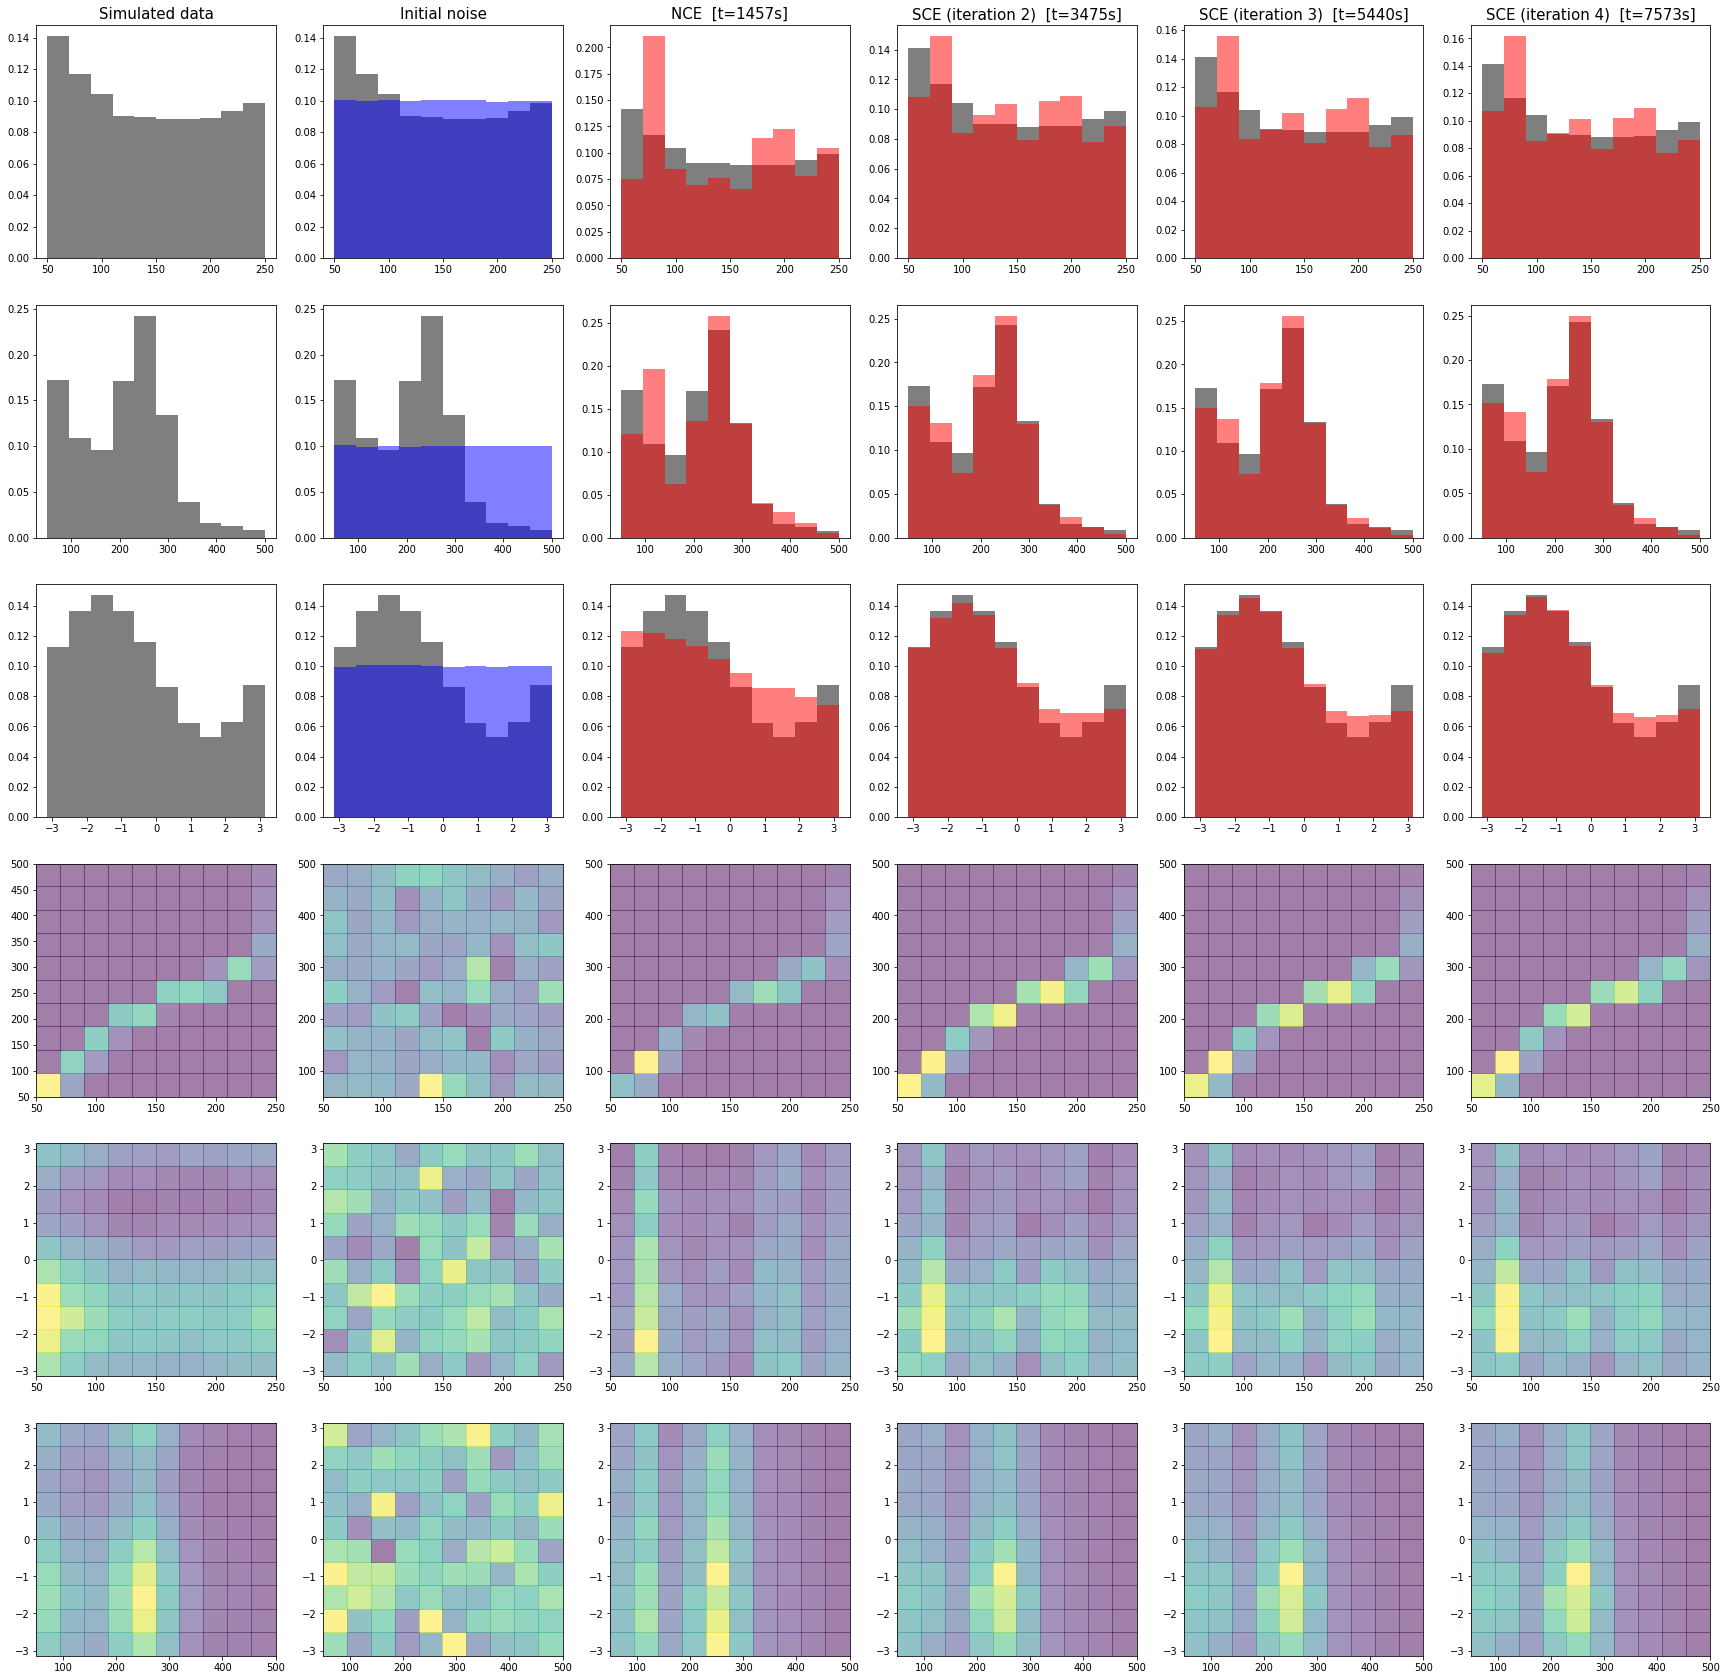

Adding 5.00% of initial noise back in
500000 noise datapoints provided
12.77% are useful (weight is > 1% of the mean)


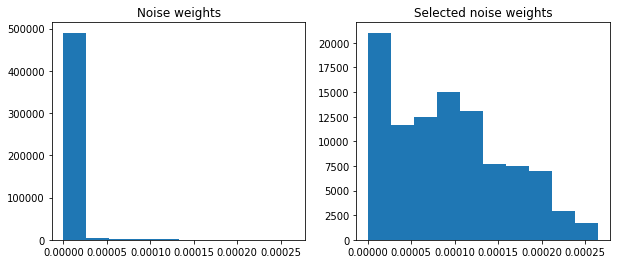

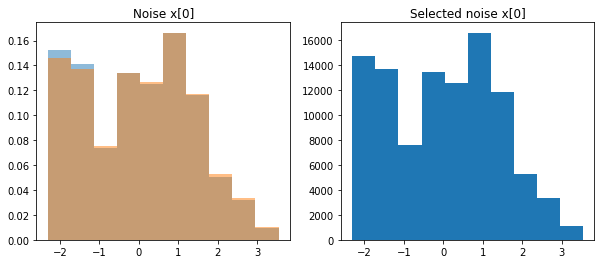

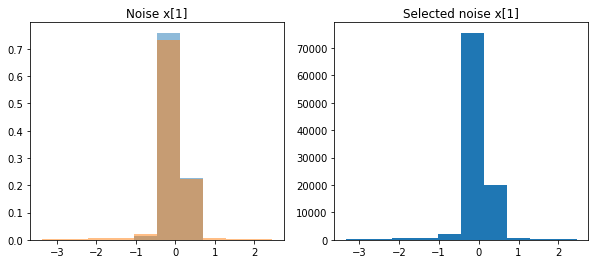

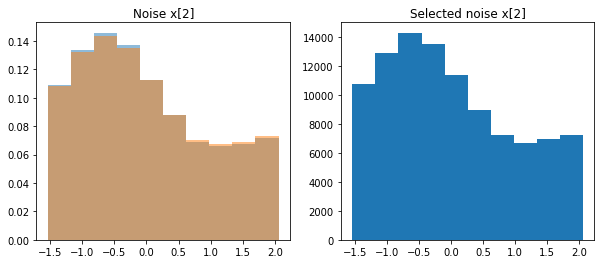

Creating discriminator with 3 observables and None conditions
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                200       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 50)                0         
_________________________________________________________

Epoch 56/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2849e-06 - val_loss: 9.2496e-06
Epoch 57/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2847e-06 - val_loss: 9.2490e-06
Epoch 58/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2823e-06 - val_loss: 9.2484e-06
Epoch 59/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2832e-06 - val_loss: 9.2478e-06
Epoch 60/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2804e-06 - val_loss: 9.2473e-06
Epoch 61/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2761e-06 - val_loss: 9.2467e-06
Epoch 62/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2817e-06 - val_loss: 9.2462e-06
Epoch 63/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2806e-06 - val_loss: 9.2456e-06
Epoch 64/10000
75000/75000 [==============================] - 0s 3us/ste

Epoch 127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2558e-06 - val_loss: 9.2284e-06
Epoch 128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2594e-06 - val_loss: 9.2283e-06
Epoch 129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2567e-06 - val_loss: 9.2282e-06
Epoch 130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2560e-06 - val_loss: 9.2281e-06
Epoch 131/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2566e-06 - val_loss: 9.2280e-06
Epoch 132/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2515e-06 - val_loss: 9.2279e-06
Epoch 133/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2580e-06 - val_loss: 9.2278e-06
Epoch 134/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2527e-06 - val_loss: 9.2277e-06
Epoch 135/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2507e-06 - val_loss: 9.2242e-06
Epoch 198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2489e-06 - val_loss: 9.2241e-06
Epoch 199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2472e-06 - val_loss: 9.2241e-06
Epoch 200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2507e-06 - val_loss: 9.2241e-06
Epoch 201/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2500e-06 - val_loss: 9.2240e-06
Epoch 202/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2503e-06 - val_loss: 9.2240e-06
Epoch 203/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2459e-06 - val_loss: 9.2240e-06
Epoch 204/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2476e-06 - val_loss: 9.2239e-06
Epoch 205/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 268/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2450e-06 - val_loss: 9.2223e-06
Epoch 269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2445e-06 - val_loss: 9.2223e-06
Epoch 270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2457e-06 - val_loss: 9.2222e-06
Epoch 271/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2477e-06 - val_loss: 9.2222e-06
Epoch 272/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2448e-06 - val_loss: 9.2222e-06
Epoch 273/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2447e-06 - val_loss: 9.2222e-06
Epoch 274/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2476e-06 - val_loss: 9.2221e-06
Epoch 275/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2470e-06 - val_loss: 9.2221e-06
Epoch 276/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2449e-06 - val_loss: 9.2206e-06
Epoch 339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2481e-06 - val_loss: 9.2206e-06
Epoch 340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2420e-06 - val_loss: 9.2206e-06
Epoch 341/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.2436e-06 - val_loss: 9.2206e-06
Epoch 342/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2436e-06 - val_loss: 9.2205e-06
Epoch 343/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2453e-06 - val_loss: 9.2205e-06
Epoch 344/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2428e-06 - val_loss: 9.2205e-06
Epoch 345/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2430e-06 - val_loss: 9.2205e-06
Epoch 346/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2417e-06 - val_loss: 9.2188e-06
Epoch 410/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2430e-06 - val_loss: 9.2188e-06
Epoch 411/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2394e-06 - val_loss: 9.2188e-06
Epoch 412/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2400e-06 - val_loss: 9.2187e-06
Epoch 413/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2441e-06 - val_loss: 9.2187e-06
Epoch 414/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2416e-06 - val_loss: 9.2187e-06
Epoch 415/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2417e-06 - val_loss: 9.2186e-06
Epoch 416/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2401e-06 - val_loss: 9.2186e-06
Epoch 417/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2369e-06 - val_loss: 9.2169e-06
Epoch 480/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2408e-06 - val_loss: 9.2168e-06
Epoch 481/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2375e-06 - val_loss: 9.2168e-06
Epoch 482/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2416e-06 - val_loss: 9.2168e-06
Epoch 483/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2386e-06 - val_loss: 9.2167e-06
Epoch 484/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2402e-06 - val_loss: 9.2167e-06
Epoch 485/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2381e-06 - val_loss: 9.2167e-06
Epoch 486/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2383e-06 - val_loss: 9.2167e-06
Epoch 487/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 550/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2346e-06 - val_loss: 9.2149e-06
Epoch 551/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2344e-06 - val_loss: 9.2149e-06
Epoch 552/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2332e-06 - val_loss: 9.2149e-06
Epoch 553/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2385e-06 - val_loss: 9.2148e-06
Epoch 554/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2370e-06 - val_loss: 9.2148e-06
Epoch 555/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2350e-06 - val_loss: 9.2148e-06
Epoch 556/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2378e-06 - val_loss: 9.2147e-06
Epoch 557/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2369e-06 - val_loss: 9.2147e-06
Epoch 558/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2318e-06 - val_loss: 9.2130e-06
Epoch 621/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2347e-06 - val_loss: 9.2130e-06
Epoch 622/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2364e-06 - val_loss: 9.2130e-06
Epoch 623/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2340e-06 - val_loss: 9.2129e-06
Epoch 624/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2343e-06 - val_loss: 9.2129e-06
Epoch 625/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2317e-06 - val_loss: 9.2129e-06
Epoch 626/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2345e-06 - val_loss: 9.2128e-06
Epoch 627/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2330e-06 - val_loss: 9.2128e-06
Epoch 628/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 691/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2327e-06 - val_loss: 9.2110e-06
Epoch 692/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2320e-06 - val_loss: 9.2109e-06
Epoch 693/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2317e-06 - val_loss: 9.2109e-06
Epoch 694/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2326e-06 - val_loss: 9.2109e-06
Epoch 695/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2320e-06 - val_loss: 9.2109e-06
Epoch 696/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2325e-06 - val_loss: 9.2108e-06
Epoch 697/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2355e-06 - val_loss: 9.2108e-06
Epoch 698/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2317e-06 - val_loss: 9.2108e-06
Epoch 699/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2309e-06 - val_loss: 9.2089e-06
Epoch 762/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2301e-06 - val_loss: 9.2089e-06
Epoch 763/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2307e-06 - val_loss: 9.2088e-06
Epoch 764/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2295e-06 - val_loss: 9.2088e-06
Epoch 765/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2290e-06 - val_loss: 9.2088e-06
Epoch 766/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2300e-06 - val_loss: 9.2087e-06
Epoch 767/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2340e-06 - val_loss: 9.2087e-06
Epoch 768/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2280e-06 - val_loss: 9.2087e-06
Epoch 769/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 832/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2269e-06 - val_loss: 9.2067e-06
Epoch 833/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2267e-06 - val_loss: 9.2066e-06
Epoch 834/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2308e-06 - val_loss: 9.2066e-06
Epoch 835/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2269e-06 - val_loss: 9.2066e-06
Epoch 836/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2302e-06 - val_loss: 9.2065e-06
Epoch 837/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2270e-06 - val_loss: 9.2065e-06
Epoch 838/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2278e-06 - val_loss: 9.2065e-06
Epoch 839/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2286e-06 - val_loss: 9.2064e-06
Epoch 840/10000
75000/75000 [==============================] - 0

Epoch 903/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2231e-06 - val_loss: 9.2043e-06
Epoch 904/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2238e-06 - val_loss: 9.2043e-06
Epoch 905/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2264e-06 - val_loss: 9.2043e-06
Epoch 906/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2253e-06 - val_loss: 9.2042e-06
Epoch 907/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2273e-06 - val_loss: 9.2042e-06
Epoch 908/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2280e-06 - val_loss: 9.2042e-06
Epoch 909/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2250e-06 - val_loss: 9.2041e-06
Epoch 910/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2265e-06 - val_loss: 9.2041e-06
Epoch 911/10000
75000/75000 [==============================] - 0

75000/75000 [==============================] - 0s 3us/step - loss: 9.2234e-06 - val_loss: 9.2020e-06
Epoch 974/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2216e-06 - val_loss: 9.2020e-06
Epoch 975/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2249e-06 - val_loss: 9.2020e-06
Epoch 976/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2244e-06 - val_loss: 9.2019e-06
Epoch 977/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2224e-06 - val_loss: 9.2019e-06
Epoch 978/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2261e-06 - val_loss: 9.2019e-06
Epoch 979/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2211e-06 - val_loss: 9.2018e-06
Epoch 980/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2227e-06 - val_loss: 9.2018e-06
Epoch 981/10000
75000/75000 [==============================] - 0s 3us/step - los

Epoch 1043/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2228e-06 - val_loss: 9.1996e-06
Epoch 1044/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2222e-06 - val_loss: 9.1996e-06
Epoch 1045/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2224e-06 - val_loss: 9.1996e-06
Epoch 1046/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2210e-06 - val_loss: 9.1995e-06
Epoch 1047/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2210e-06 - val_loss: 9.1995e-06
Epoch 1048/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2209e-06 - val_loss: 9.1995e-06
Epoch 1049/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2236e-06 - val_loss: 9.1994e-06
Epoch 1050/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2195e-06 - val_loss: 9.1994e-06
Epoch 1051/10000
75000/75000 [==========================

Epoch 1113/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2227e-06 - val_loss: 9.1971e-06
Epoch 1114/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2176e-06 - val_loss: 9.1971e-06
Epoch 1115/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2174e-06 - val_loss: 9.1971e-06
Epoch 1116/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2169e-06 - val_loss: 9.1970e-06
Epoch 1117/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2203e-06 - val_loss: 9.1970e-06
Epoch 1118/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2162e-06 - val_loss: 9.1970e-06
Epoch 1119/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2214e-06 - val_loss: 9.1969e-06
Epoch 1120/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2160e-06 - val_loss: 9.1969e-06
Epoch 1121/10000
75000/75000 [==========================

Epoch 1183/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2156e-06 - val_loss: 9.1947e-06
Epoch 1184/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2171e-06 - val_loss: 9.1946e-06
Epoch 1185/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2158e-06 - val_loss: 9.1946e-06
Epoch 1186/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2152e-06 - val_loss: 9.1946e-06
Epoch 1187/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2174e-06 - val_loss: 9.1945e-06
Epoch 1188/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2162e-06 - val_loss: 9.1945e-06
Epoch 1189/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2139e-06 - val_loss: 9.1945e-06
Epoch 1190/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2187e-06 - val_loss: 9.1944e-06
Epoch 1191/10000
75000/75000 [==========================

Epoch 1253/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2119e-06 - val_loss: 9.1921e-06
Epoch 1254/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2148e-06 - val_loss: 9.1921e-06
Epoch 1255/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2141e-06 - val_loss: 9.1920e-06
Epoch 1256/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2123e-06 - val_loss: 9.1920e-06
Epoch 1257/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2162e-06 - val_loss: 9.1920e-06
Epoch 1258/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2116e-06 - val_loss: 9.1919e-06
Epoch 1259/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2142e-06 - val_loss: 9.1919e-06
Epoch 1260/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2146e-06 - val_loss: 9.1918e-06
Epoch 1261/10000
75000/75000 [==========================

Epoch 1323/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2098e-06 - val_loss: 9.1895e-06
Epoch 1324/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2115e-06 - val_loss: 9.1895e-06
Epoch 1325/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2130e-06 - val_loss: 9.1894e-06
Epoch 1326/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2123e-06 - val_loss: 9.1894e-06
Epoch 1327/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2127e-06 - val_loss: 9.1894e-06
Epoch 1328/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2110e-06 - val_loss: 9.1893e-06
Epoch 1329/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2092e-06 - val_loss: 9.1893e-06
Epoch 1330/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2112e-06 - val_loss: 9.1893e-06
Epoch 1331/10000
75000/75000 [==========================

Epoch 1393/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.2112e-06 - val_loss: 9.1870e-06
Epoch 1394/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2101e-06 - val_loss: 9.1870e-06
Epoch 1395/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2067e-06 - val_loss: 9.1870e-06
Epoch 1396/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2099e-06 - val_loss: 9.1869e-06
Epoch 1397/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2098e-06 - val_loss: 9.1869e-06
Epoch 1398/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2082e-06 - val_loss: 9.1869e-06
Epoch 1399/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2091e-06 - val_loss: 9.1868e-06
Epoch 1400/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2095e-06 - val_loss: 9.1868e-06
Epoch 1401/10000
75000/75000 [==========================

Epoch 1463/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2078e-06 - val_loss: 9.1846e-06
Epoch 1464/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2090e-06 - val_loss: 9.1846e-06
Epoch 1465/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2092e-06 - val_loss: 9.1846e-06
Epoch 1466/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2072e-06 - val_loss: 9.1845e-06
Epoch 1467/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2084e-06 - val_loss: 9.1845e-06
Epoch 1468/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2087e-06 - val_loss: 9.1845e-06
Epoch 1469/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2058e-06 - val_loss: 9.1844e-06
Epoch 1470/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2060e-06 - val_loss: 9.1844e-06
Epoch 1471/10000
75000/75000 [==========================

Epoch 1533/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2053e-06 - val_loss: 9.1822e-06
Epoch 1534/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2073e-06 - val_loss: 9.1822e-06
Epoch 1535/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2042e-06 - val_loss: 9.1821e-06
Epoch 1536/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2071e-06 - val_loss: 9.1821e-06
Epoch 1537/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2016e-06 - val_loss: 9.1821e-06
Epoch 1538/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2045e-06 - val_loss: 9.1820e-06
Epoch 1539/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2068e-06 - val_loss: 9.1820e-06
Epoch 1540/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2057e-06 - val_loss: 9.1820e-06
Epoch 1541/10000
75000/75000 [==========================

Epoch 1603/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2019e-06 - val_loss: 9.1797e-06
Epoch 1604/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2022e-06 - val_loss: 9.1797e-06
Epoch 1605/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2023e-06 - val_loss: 9.1796e-06
Epoch 1606/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2039e-06 - val_loss: 9.1796e-06
Epoch 1607/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2008e-06 - val_loss: 9.1796e-06
Epoch 1608/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2004e-06 - val_loss: 9.1795e-06
Epoch 1609/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2004e-06 - val_loss: 9.1795e-06
Epoch 1610/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2020e-06 - val_loss: 9.1795e-06
Epoch 1611/10000
75000/75000 [==========================

Epoch 1673/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1988e-06 - val_loss: 9.1773e-06
Epoch 1674/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2020e-06 - val_loss: 9.1773e-06
Epoch 1675/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2000e-06 - val_loss: 9.1773e-06
Epoch 1676/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1985e-06 - val_loss: 9.1772e-06
Epoch 1677/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2000e-06 - val_loss: 9.1772e-06
Epoch 1678/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.2049e-06 - val_loss: 9.1771e-06
Epoch 1679/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1998e-06 - val_loss: 9.1771e-06
Epoch 1680/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1996e-06 - val_loss: 9.1771e-06
Epoch 1681/10000
75000/75000 [==========================

Epoch 1743/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1965e-06 - val_loss: 9.1749e-06
Epoch 1744/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1983e-06 - val_loss: 9.1749e-06
Epoch 1745/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1992e-06 - val_loss: 9.1748e-06
Epoch 1746/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1974e-06 - val_loss: 9.1748e-06
Epoch 1747/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1968e-06 - val_loss: 9.1748e-06
Epoch 1748/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1965e-06 - val_loss: 9.1747e-06
Epoch 1749/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1990e-06 - val_loss: 9.1747e-06
Epoch 1750/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1970e-06 - val_loss: 9.1747e-06
Epoch 1751/10000
75000/75000 [==========================

Epoch 1813/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1958e-06 - val_loss: 9.1725e-06
Epoch 1814/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1960e-06 - val_loss: 9.1725e-06
Epoch 1815/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1945e-06 - val_loss: 9.1725e-06
Epoch 1816/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1962e-06 - val_loss: 9.1724e-06
Epoch 1817/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1973e-06 - val_loss: 9.1724e-06
Epoch 1818/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1941e-06 - val_loss: 9.1724e-06
Epoch 1819/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1961e-06 - val_loss: 9.1723e-06
Epoch 1820/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1956e-06 - val_loss: 9.1723e-06
Epoch 1821/10000
75000/75000 [==========================

Epoch 1883/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1955e-06 - val_loss: 9.1702e-06
Epoch 1884/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1942e-06 - val_loss: 9.1702e-06
Epoch 1885/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1934e-06 - val_loss: 9.1702e-06
Epoch 1886/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1944e-06 - val_loss: 9.1702e-06
Epoch 1887/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1914e-06 - val_loss: 9.1701e-06
Epoch 1888/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1923e-06 - val_loss: 9.1701e-06
Epoch 1889/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1965e-06 - val_loss: 9.1701e-06
Epoch 1890/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1927e-06 - val_loss: 9.1700e-06
Epoch 1891/10000
75000/75000 [==========================

Epoch 1953/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1893e-06 - val_loss: 9.1680e-06
Epoch 1954/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1925e-06 - val_loss: 9.1680e-06
Epoch 1955/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1922e-06 - val_loss: 9.1679e-06
Epoch 1956/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1928e-06 - val_loss: 9.1679e-06
Epoch 1957/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1919e-06 - val_loss: 9.1679e-06
Epoch 1958/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1908e-06 - val_loss: 9.1678e-06
Epoch 1959/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1902e-06 - val_loss: 9.1678e-06
Epoch 1960/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1899e-06 - val_loss: 9.1678e-06
Epoch 1961/10000
75000/75000 [==========================

Epoch 2023/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1891e-06 - val_loss: 9.1658e-06
Epoch 2024/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1926e-06 - val_loss: 9.1658e-06
Epoch 2025/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1885e-06 - val_loss: 9.1658e-06
Epoch 2026/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1869e-06 - val_loss: 9.1657e-06
Epoch 2027/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1890e-06 - val_loss: 9.1657e-06
Epoch 2028/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1894e-06 - val_loss: 9.1657e-06
Epoch 2029/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1909e-06 - val_loss: 9.1656e-06
Epoch 2030/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1881e-06 - val_loss: 9.1656e-06
Epoch 2031/10000
75000/75000 [==========================

Epoch 2093/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1876e-06 - val_loss: 9.1637e-06
Epoch 2094/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1849e-06 - val_loss: 9.1636e-06
Epoch 2095/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1861e-06 - val_loss: 9.1636e-06
Epoch 2096/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1849e-06 - val_loss: 9.1636e-06
Epoch 2097/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1896e-06 - val_loss: 9.1636e-06
Epoch 2098/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1866e-06 - val_loss: 9.1635e-06
Epoch 2099/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1855e-06 - val_loss: 9.1635e-06
Epoch 2100/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1871e-06 - val_loss: 9.1635e-06
Epoch 2101/10000
75000/75000 [==========================

Epoch 2163/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1857e-06 - val_loss: 9.1616e-06
Epoch 2164/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1830e-06 - val_loss: 9.1615e-06
Epoch 2165/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1838e-06 - val_loss: 9.1615e-06
Epoch 2166/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1817e-06 - val_loss: 9.1615e-06
Epoch 2167/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1864e-06 - val_loss: 9.1614e-06
Epoch 2168/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1847e-06 - val_loss: 9.1614e-06
Epoch 2169/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1821e-06 - val_loss: 9.1614e-06
Epoch 2170/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1845e-06 - val_loss: 9.1613e-06
Epoch 2171/10000
75000/75000 [==========================

Epoch 2233/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1817e-06 - val_loss: 9.1596e-06
Epoch 2234/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1826e-06 - val_loss: 9.1596e-06
Epoch 2235/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1822e-06 - val_loss: 9.1595e-06
Epoch 2236/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1815e-06 - val_loss: 9.1595e-06
Epoch 2237/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1827e-06 - val_loss: 9.1595e-06
Epoch 2238/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1797e-06 - val_loss: 9.1594e-06
Epoch 2239/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1826e-06 - val_loss: 9.1594e-06
Epoch 2240/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1835e-06 - val_loss: 9.1594e-06
Epoch 2241/10000
75000/75000 [==========================

Epoch 2303/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1822e-06 - val_loss: 9.1576e-06
Epoch 2304/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1828e-06 - val_loss: 9.1576e-06
Epoch 2305/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1836e-06 - val_loss: 9.1575e-06
Epoch 2306/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1790e-06 - val_loss: 9.1575e-06
Epoch 2307/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1827e-06 - val_loss: 9.1575e-06
Epoch 2308/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1839e-06 - val_loss: 9.1575e-06
Epoch 2309/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1792e-06 - val_loss: 9.1574e-06
Epoch 2310/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1796e-06 - val_loss: 9.1574e-06
Epoch 2311/10000
75000/75000 [==========================

Epoch 2373/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1796e-06 - val_loss: 9.1557e-06
Epoch 2374/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1791e-06 - val_loss: 9.1556e-06
Epoch 2375/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1810e-06 - val_loss: 9.1556e-06
Epoch 2376/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1784e-06 - val_loss: 9.1556e-06
Epoch 2377/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1809e-06 - val_loss: 9.1556e-06
Epoch 2378/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1799e-06 - val_loss: 9.1555e-06
Epoch 2379/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1785e-06 - val_loss: 9.1555e-06
Epoch 2380/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1798e-06 - val_loss: 9.1555e-06
Epoch 2381/10000
75000/75000 [==========================

Epoch 2443/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1809e-06 - val_loss: 9.1538e-06
Epoch 2444/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1768e-06 - val_loss: 9.1538e-06
Epoch 2445/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1751e-06 - val_loss: 9.1538e-06
Epoch 2446/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1771e-06 - val_loss: 9.1537e-06
Epoch 2447/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1810e-06 - val_loss: 9.1537e-06
Epoch 2448/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1795e-06 - val_loss: 9.1537e-06
Epoch 2449/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1777e-06 - val_loss: 9.1537e-06
Epoch 2450/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1774e-06 - val_loss: 9.1536e-06
Epoch 2451/10000
75000/75000 [==========================

Epoch 2513/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1761e-06 - val_loss: 9.1521e-06
Epoch 2514/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1752e-06 - val_loss: 9.1520e-06
Epoch 2515/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1756e-06 - val_loss: 9.1520e-06
Epoch 2516/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1776e-06 - val_loss: 9.1520e-06
Epoch 2517/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1761e-06 - val_loss: 9.1520e-06
Epoch 2518/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1758e-06 - val_loss: 9.1519e-06
Epoch 2519/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1749e-06 - val_loss: 9.1519e-06
Epoch 2520/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1782e-06 - val_loss: 9.1519e-06
Epoch 2521/10000
75000/75000 [==========================

Epoch 2583/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1734e-06 - val_loss: 9.1503e-06
Epoch 2584/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1744e-06 - val_loss: 9.1503e-06
Epoch 2585/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1722e-06 - val_loss: 9.1503e-06
Epoch 2586/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1738e-06 - val_loss: 9.1503e-06
Epoch 2587/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1732e-06 - val_loss: 9.1502e-06
Epoch 2588/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1747e-06 - val_loss: 9.1502e-06
Epoch 2589/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1734e-06 - val_loss: 9.1502e-06
Epoch 2590/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1743e-06 - val_loss: 9.1502e-06
Epoch 2591/10000
75000/75000 [==========================

Epoch 2653/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1704e-06 - val_loss: 9.1486e-06
Epoch 2654/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1735e-06 - val_loss: 9.1486e-06
Epoch 2655/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1754e-06 - val_loss: 9.1486e-06
Epoch 2656/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1701e-06 - val_loss: 9.1486e-06
Epoch 2657/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1737e-06 - val_loss: 9.1485e-06
Epoch 2658/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1722e-06 - val_loss: 9.1485e-06
Epoch 2659/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1747e-06 - val_loss: 9.1485e-06
Epoch 2660/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1722e-06 - val_loss: 9.1485e-06
Epoch 2661/10000
75000/75000 [==========================

Epoch 2723/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1710e-06 - val_loss: 9.1470e-06
Epoch 2724/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1688e-06 - val_loss: 9.1470e-06
Epoch 2725/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1700e-06 - val_loss: 9.1470e-06
Epoch 2726/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1704e-06 - val_loss: 9.1469e-06
Epoch 2727/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1690e-06 - val_loss: 9.1469e-06
Epoch 2728/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1718e-06 - val_loss: 9.1469e-06
Epoch 2729/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1695e-06 - val_loss: 9.1468e-06
Epoch 2730/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1664e-06 - val_loss: 9.1468e-06
Epoch 2731/10000
75000/75000 [==========================

Epoch 2793/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1684e-06 - val_loss: 9.1453e-06
Epoch 2794/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1677e-06 - val_loss: 9.1452e-06
Epoch 2795/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1700e-06 - val_loss: 9.1452e-06
Epoch 2796/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1674e-06 - val_loss: 9.1452e-06
Epoch 2797/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1715e-06 - val_loss: 9.1452e-06
Epoch 2798/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1680e-06 - val_loss: 9.1452e-06
Epoch 2799/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1719e-06 - val_loss: 9.1451e-06
Epoch 2800/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1657e-06 - val_loss: 9.1451e-06
Epoch 2801/10000
75000/75000 [==========================

Epoch 2863/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1655e-06 - val_loss: 9.1436e-06
Epoch 2864/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1678e-06 - val_loss: 9.1436e-06
Epoch 2865/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1681e-06 - val_loss: 9.1436e-06
Epoch 2866/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1658e-06 - val_loss: 9.1435e-06
Epoch 2867/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1674e-06 - val_loss: 9.1435e-06
Epoch 2868/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1678e-06 - val_loss: 9.1435e-06
Epoch 2869/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1677e-06 - val_loss: 9.1435e-06
Epoch 2870/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1662e-06 - val_loss: 9.1435e-06
Epoch 2871/10000
75000/75000 [==========================

Epoch 2933/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1638e-06 - val_loss: 9.1419e-06
Epoch 2934/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1626e-06 - val_loss: 9.1419e-06
Epoch 2935/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1657e-06 - val_loss: 9.1419e-06
Epoch 2936/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1647e-06 - val_loss: 9.1419e-06
Epoch 2937/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1676e-06 - val_loss: 9.1418e-06
Epoch 2938/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1661e-06 - val_loss: 9.1418e-06
Epoch 2939/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1655e-06 - val_loss: 9.1418e-06
Epoch 2940/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1668e-06 - val_loss: 9.1418e-06
Epoch 2941/10000
75000/75000 [==========================

Epoch 3003/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1640e-06 - val_loss: 9.1403e-06
Epoch 3004/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1649e-06 - val_loss: 9.1403e-06
Epoch 3005/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1651e-06 - val_loss: 9.1402e-06
Epoch 3006/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1627e-06 - val_loss: 9.1402e-06
Epoch 3007/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1645e-06 - val_loss: 9.1402e-06
Epoch 3008/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1641e-06 - val_loss: 9.1401e-06
Epoch 3009/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1646e-06 - val_loss: 9.1401e-06
Epoch 3010/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1629e-06 - val_loss: 9.1401e-06
Epoch 3011/10000
75000/75000 [==========================

Epoch 3073/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1634e-06 - val_loss: 9.1385e-06
Epoch 3074/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1640e-06 - val_loss: 9.1385e-06
Epoch 3075/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1634e-06 - val_loss: 9.1385e-06
Epoch 3076/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1643e-06 - val_loss: 9.1385e-06
Epoch 3077/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1621e-06 - val_loss: 9.1384e-06
Epoch 3078/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1594e-06 - val_loss: 9.1384e-06
Epoch 3079/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1615e-06 - val_loss: 9.1384e-06
Epoch 3080/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1620e-06 - val_loss: 9.1384e-06
Epoch 3081/10000
75000/75000 [==========================

Epoch 3143/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1607e-06 - val_loss: 9.1369e-06
Epoch 3144/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1574e-06 - val_loss: 9.1369e-06
Epoch 3145/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1648e-06 - val_loss: 9.1368e-06
Epoch 3146/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1627e-06 - val_loss: 9.1368e-06
Epoch 3147/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1598e-06 - val_loss: 9.1368e-06
Epoch 3148/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1588e-06 - val_loss: 9.1368e-06
Epoch 3149/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1620e-06 - val_loss: 9.1367e-06
Epoch 3150/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1599e-06 - val_loss: 9.1367e-06
Epoch 3151/10000
75000/75000 [==========================

Epoch 3213/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1583e-06 - val_loss: 9.1353e-06
Epoch 3214/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1590e-06 - val_loss: 9.1352e-06
Epoch 3215/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1575e-06 - val_loss: 9.1352e-06
Epoch 3216/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1605e-06 - val_loss: 9.1352e-06
Epoch 3217/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1619e-06 - val_loss: 9.1352e-06
Epoch 3218/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1605e-06 - val_loss: 9.1351e-06
Epoch 3219/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1617e-06 - val_loss: 9.1351e-06
Epoch 3220/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1585e-06 - val_loss: 9.1351e-06
Epoch 3221/10000
75000/75000 [==========================

Epoch 3283/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1585e-06 - val_loss: 9.1337e-06
Epoch 3284/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1578e-06 - val_loss: 9.1337e-06
Epoch 3285/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1566e-06 - val_loss: 9.1337e-06
Epoch 3286/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1580e-06 - val_loss: 9.1337e-06
Epoch 3287/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1595e-06 - val_loss: 9.1337e-06
Epoch 3288/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1571e-06 - val_loss: 9.1336e-06
Epoch 3289/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1574e-06 - val_loss: 9.1336e-06
Epoch 3290/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1584e-06 - val_loss: 9.1336e-06
Epoch 3291/10000
75000/75000 [==========================

Epoch 3353/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1570e-06 - val_loss: 9.1320e-06
Epoch 3354/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1542e-06 - val_loss: 9.1320e-06
Epoch 3355/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1551e-06 - val_loss: 9.1320e-06
Epoch 3356/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1524e-06 - val_loss: 9.1320e-06
Epoch 3357/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1557e-06 - val_loss: 9.1319e-06
Epoch 3358/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1552e-06 - val_loss: 9.1319e-06
Epoch 3359/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1550e-06 - val_loss: 9.1319e-06
Epoch 3360/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1560e-06 - val_loss: 9.1319e-06
Epoch 3361/10000
75000/75000 [==========================

Epoch 3423/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1558e-06 - val_loss: 9.1304e-06
Epoch 3424/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1574e-06 - val_loss: 9.1304e-06
Epoch 3425/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1520e-06 - val_loss: 9.1303e-06
Epoch 3426/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1543e-06 - val_loss: 9.1303e-06
Epoch 3427/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1533e-06 - val_loss: 9.1303e-06
Epoch 3428/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1539e-06 - val_loss: 9.1303e-06
Epoch 3429/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1532e-06 - val_loss: 9.1302e-06
Epoch 3430/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1537e-06 - val_loss: 9.1302e-06
Epoch 3431/10000
75000/75000 [==========================

Epoch 3493/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1531e-06 - val_loss: 9.1288e-06
Epoch 3494/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1538e-06 - val_loss: 9.1288e-06
Epoch 3495/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1539e-06 - val_loss: 9.1288e-06
Epoch 3496/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1509e-06 - val_loss: 9.1288e-06
Epoch 3497/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1533e-06 - val_loss: 9.1287e-06
Epoch 3498/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1548e-06 - val_loss: 9.1287e-06
Epoch 3499/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1556e-06 - val_loss: 9.1287e-06
Epoch 3500/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1527e-06 - val_loss: 9.1287e-06
Epoch 3501/10000
75000/75000 [==========================

Epoch 3563/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1496e-06 - val_loss: 9.1273e-06
Epoch 3564/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1549e-06 - val_loss: 9.1272e-06
Epoch 3565/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1525e-06 - val_loss: 9.1272e-06
Epoch 3566/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1502e-06 - val_loss: 9.1272e-06
Epoch 3567/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1530e-06 - val_loss: 9.1272e-06
Epoch 3568/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1487e-06 - val_loss: 9.1271e-06
Epoch 3569/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1513e-06 - val_loss: 9.1271e-06
Epoch 3570/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1548e-06 - val_loss: 9.1271e-06
Epoch 3571/10000
75000/75000 [==========================

Epoch 3633/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1484e-06 - val_loss: 9.1257e-06
Epoch 3634/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1498e-06 - val_loss: 9.1257e-06
Epoch 3635/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1476e-06 - val_loss: 9.1256e-06
Epoch 3636/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1475e-06 - val_loss: 9.1256e-06
Epoch 3637/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1500e-06 - val_loss: 9.1256e-06
Epoch 3638/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1492e-06 - val_loss: 9.1256e-06
Epoch 3639/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1500e-06 - val_loss: 9.1256e-06
Epoch 3640/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1496e-06 - val_loss: 9.1255e-06
Epoch 3641/10000
75000/75000 [==========================

Epoch 3703/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1511e-06 - val_loss: 9.1242e-06
Epoch 3704/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1512e-06 - val_loss: 9.1242e-06
Epoch 3705/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1470e-06 - val_loss: 9.1242e-06
Epoch 3706/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1514e-06 - val_loss: 9.1241e-06
Epoch 3707/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1478e-06 - val_loss: 9.1241e-06
Epoch 3708/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1509e-06 - val_loss: 9.1241e-06
Epoch 3709/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1484e-06 - val_loss: 9.1241e-06
Epoch 3710/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1515e-06 - val_loss: 9.1241e-06
Epoch 3711/10000
75000/75000 [==========================

Epoch 3773/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1450e-06 - val_loss: 9.1226e-06
Epoch 3774/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1479e-06 - val_loss: 9.1226e-06
Epoch 3775/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1474e-06 - val_loss: 9.1226e-06
Epoch 3776/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1487e-06 - val_loss: 9.1226e-06
Epoch 3777/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1480e-06 - val_loss: 9.1225e-06
Epoch 3778/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1474e-06 - val_loss: 9.1225e-06
Epoch 3779/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1486e-06 - val_loss: 9.1225e-06
Epoch 3780/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1508e-06 - val_loss: 9.1225e-06
Epoch 3781/10000
75000/75000 [==========================

Epoch 3843/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1453e-06 - val_loss: 9.1211e-06
Epoch 3844/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1441e-06 - val_loss: 9.1211e-06
Epoch 3845/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1455e-06 - val_loss: 9.1211e-06
Epoch 3846/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1454e-06 - val_loss: 9.1211e-06
Epoch 3847/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1444e-06 - val_loss: 9.1210e-06
Epoch 3848/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1473e-06 - val_loss: 9.1210e-06
Epoch 3849/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1477e-06 - val_loss: 9.1210e-06
Epoch 3850/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1453e-06 - val_loss: 9.1210e-06
Epoch 3851/10000
75000/75000 [==========================

Epoch 3913/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1422e-06 - val_loss: 9.1196e-06
Epoch 3914/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1456e-06 - val_loss: 9.1196e-06
Epoch 3915/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1432e-06 - val_loss: 9.1196e-06
Epoch 3916/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1437e-06 - val_loss: 9.1196e-06
Epoch 3917/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1444e-06 - val_loss: 9.1196e-06
Epoch 3918/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1457e-06 - val_loss: 9.1195e-06
Epoch 3919/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1479e-06 - val_loss: 9.1195e-06
Epoch 3920/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1434e-06 - val_loss: 9.1195e-06
Epoch 3921/10000
75000/75000 [==========================

Epoch 3983/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1404e-06 - val_loss: 9.1182e-06
Epoch 3984/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1363e-06 - val_loss: 9.1181e-06
Epoch 3985/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1389e-06 - val_loss: 9.1181e-06
Epoch 3986/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1390e-06 - val_loss: 9.1181e-06
Epoch 3987/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1427e-06 - val_loss: 9.1181e-06
Epoch 3988/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1410e-06 - val_loss: 9.1180e-06
Epoch 3989/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1402e-06 - val_loss: 9.1180e-06
Epoch 3990/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1394e-06 - val_loss: 9.1180e-06
Epoch 3991/10000
75000/75000 [==========================

Epoch 4053/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1377e-06 - val_loss: 9.1168e-06
Epoch 4054/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1455e-06 - val_loss: 9.1168e-06
Epoch 4055/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1419e-06 - val_loss: 9.1168e-06
Epoch 4056/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1420e-06 - val_loss: 9.1168e-06
Epoch 4057/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1395e-06 - val_loss: 9.1167e-06
Epoch 4058/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1409e-06 - val_loss: 9.1167e-06
Epoch 4059/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1440e-06 - val_loss: 9.1167e-06
Epoch 4060/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1414e-06 - val_loss: 9.1167e-06
Epoch 4061/10000
75000/75000 [==========================

Epoch 4123/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1380e-06 - val_loss: 9.1154e-06
Epoch 4124/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1382e-06 - val_loss: 9.1154e-06
Epoch 4125/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1418e-06 - val_loss: 9.1154e-06
Epoch 4126/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1374e-06 - val_loss: 9.1153e-06
Epoch 4127/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1416e-06 - val_loss: 9.1153e-06
Epoch 4128/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1424e-06 - val_loss: 9.1153e-06
Epoch 4129/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1384e-06 - val_loss: 9.1153e-06
Epoch 4130/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1385e-06 - val_loss: 9.1153e-06
Epoch 4131/10000
75000/75000 [==========================

Epoch 4193/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1397e-06 - val_loss: 9.1140e-06
Epoch 4194/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1390e-06 - val_loss: 9.1140e-06
Epoch 4195/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1395e-06 - val_loss: 9.1140e-06
Epoch 4196/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1407e-06 - val_loss: 9.1140e-06
Epoch 4197/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1382e-06 - val_loss: 9.1139e-06
Epoch 4198/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1381e-06 - val_loss: 9.1139e-06
Epoch 4199/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1354e-06 - val_loss: 9.1139e-06
Epoch 4200/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1416e-06 - val_loss: 9.1139e-06
Epoch 4201/10000
75000/75000 [==========================

Epoch 4263/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1348e-06 - val_loss: 9.1126e-06
Epoch 4264/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1396e-06 - val_loss: 9.1125e-06
Epoch 4265/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1382e-06 - val_loss: 9.1125e-06
Epoch 4266/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1387e-06 - val_loss: 9.1125e-06
Epoch 4267/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1372e-06 - val_loss: 9.1125e-06
Epoch 4268/10000
75000/75000 [==============================] - 0s 5us/step - loss: 9.1391e-06 - val_loss: 9.1125e-06
Epoch 4269/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1345e-06 - val_loss: 9.1124e-06
Epoch 4270/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1372e-06 - val_loss: 9.1124e-06
Epoch 4271/10000
75000/75000 [==========================

Epoch 4333/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1360e-06 - val_loss: 9.1113e-06
Epoch 4334/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1347e-06 - val_loss: 9.1113e-06
Epoch 4335/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1337e-06 - val_loss: 9.1113e-06
Epoch 4336/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1358e-06 - val_loss: 9.1112e-06
Epoch 4337/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1360e-06 - val_loss: 9.1112e-06
Epoch 4338/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1366e-06 - val_loss: 9.1112e-06
Epoch 4339/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1354e-06 - val_loss: 9.1112e-06
Epoch 4340/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1375e-06 - val_loss: 9.1112e-06
Epoch 4341/10000
75000/75000 [==========================

Epoch 4403/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1307e-06 - val_loss: 9.1100e-06
Epoch 4404/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1347e-06 - val_loss: 9.1099e-06
Epoch 4405/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1395e-06 - val_loss: 9.1099e-06
Epoch 4406/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1312e-06 - val_loss: 9.1099e-06
Epoch 4407/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1352e-06 - val_loss: 9.1099e-06
Epoch 4408/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1346e-06 - val_loss: 9.1099e-06
Epoch 4409/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1339e-06 - val_loss: 9.1098e-06
Epoch 4410/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1351e-06 - val_loss: 9.1098e-06
Epoch 4411/10000
75000/75000 [==========================

Epoch 4473/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1314e-06 - val_loss: 9.1086e-06
Epoch 4474/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1337e-06 - val_loss: 9.1085e-06
Epoch 4475/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1344e-06 - val_loss: 9.1085e-06
Epoch 4476/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1324e-06 - val_loss: 9.1085e-06
Epoch 4477/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1305e-06 - val_loss: 9.1085e-06
Epoch 4478/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1318e-06 - val_loss: 9.1085e-06
Epoch 4479/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1310e-06 - val_loss: 9.1084e-06
Epoch 4480/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1311e-06 - val_loss: 9.1084e-06
Epoch 4481/10000
75000/75000 [==========================

Epoch 4543/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1296e-06 - val_loss: 9.1071e-06
Epoch 4544/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1343e-06 - val_loss: 9.1071e-06
Epoch 4545/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1335e-06 - val_loss: 9.1070e-06
Epoch 4546/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1295e-06 - val_loss: 9.1070e-06
Epoch 4547/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1312e-06 - val_loss: 9.1070e-06
Epoch 4548/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1345e-06 - val_loss: 9.1070e-06
Epoch 4549/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1306e-06 - val_loss: 9.1070e-06
Epoch 4550/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1345e-06 - val_loss: 9.1069e-06
Epoch 4551/10000
75000/75000 [==========================

Epoch 4613/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1314e-06 - val_loss: 9.1057e-06
Epoch 4614/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1308e-06 - val_loss: 9.1057e-06
Epoch 4615/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1283e-06 - val_loss: 9.1056e-06
Epoch 4616/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1342e-06 - val_loss: 9.1056e-06
Epoch 4617/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1321e-06 - val_loss: 9.1056e-06
Epoch 4618/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1300e-06 - val_loss: 9.1056e-06
Epoch 4619/10000
75000/75000 [==============================] - 7208s 96ms/step - loss: 9.1306e-06 - val_loss: 9.1055e-06
Epoch 4620/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1274e-06 - val_loss: 9.1055e-06
Epoch 4621/10000
75000/75000 [======================

Epoch 4683/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1303e-06 - val_loss: 9.1041e-06
Epoch 4684/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1251e-06 - val_loss: 9.1040e-06
Epoch 4685/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1236e-06 - val_loss: 9.1040e-06
Epoch 4686/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1301e-06 - val_loss: 9.1040e-06
Epoch 4687/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1302e-06 - val_loss: 9.1040e-06
Epoch 4688/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1278e-06 - val_loss: 9.1039e-06
Epoch 4689/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1310e-06 - val_loss: 9.1039e-06
Epoch 4690/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1302e-06 - val_loss: 9.1039e-06
Epoch 4691/10000
75000/75000 [==========================

Epoch 4753/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1278e-06 - val_loss: 9.1026e-06
Epoch 4754/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1296e-06 - val_loss: 9.1026e-06
Epoch 4755/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1280e-06 - val_loss: 9.1026e-06
Epoch 4756/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1273e-06 - val_loss: 9.1026e-06
Epoch 4757/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1245e-06 - val_loss: 9.1026e-06
Epoch 4758/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1256e-06 - val_loss: 9.1025e-06
Epoch 4759/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1293e-06 - val_loss: 9.1025e-06
Epoch 4760/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1256e-06 - val_loss: 9.1025e-06
Epoch 4761/10000
75000/75000 [==========================

Epoch 4823/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1262e-06 - val_loss: 9.1011e-06
Epoch 4824/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1301e-06 - val_loss: 9.1011e-06
Epoch 4825/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1250e-06 - val_loss: 9.1010e-06
Epoch 4826/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1306e-06 - val_loss: 9.1010e-06
Epoch 4827/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1267e-06 - val_loss: 9.1010e-06
Epoch 4828/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1270e-06 - val_loss: 9.1010e-06
Epoch 4829/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1278e-06 - val_loss: 9.1009e-06
Epoch 4830/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1311e-06 - val_loss: 9.1009e-06
Epoch 4831/10000
75000/75000 [==========================

Epoch 4893/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1229e-06 - val_loss: 9.0995e-06
Epoch 4894/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1248e-06 - val_loss: 9.0995e-06
Epoch 4895/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1282e-06 - val_loss: 9.0995e-06
Epoch 4896/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1251e-06 - val_loss: 9.0995e-06
Epoch 4897/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1255e-06 - val_loss: 9.0995e-06
Epoch 4898/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1267e-06 - val_loss: 9.0994e-06
Epoch 4899/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1255e-06 - val_loss: 9.0994e-06
Epoch 4900/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1265e-06 - val_loss: 9.0994e-06
Epoch 4901/10000
75000/75000 [==========================

Epoch 4963/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1246e-06 - val_loss: 9.0979e-06
Epoch 4964/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1240e-06 - val_loss: 9.0979e-06
Epoch 4965/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1234e-06 - val_loss: 9.0979e-06
Epoch 4966/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1199e-06 - val_loss: 9.0978e-06
Epoch 4967/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1232e-06 - val_loss: 9.0978e-06
Epoch 4968/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1245e-06 - val_loss: 9.0978e-06
Epoch 4969/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1216e-06 - val_loss: 9.0978e-06
Epoch 4970/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1225e-06 - val_loss: 9.0978e-06
Epoch 4971/10000
75000/75000 [==========================

Epoch 5033/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1245e-06 - val_loss: 9.0964e-06
Epoch 5034/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1236e-06 - val_loss: 9.0964e-06
Epoch 5035/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1220e-06 - val_loss: 9.0963e-06
Epoch 5036/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1266e-06 - val_loss: 9.0963e-06
Epoch 5037/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1271e-06 - val_loss: 9.0963e-06
Epoch 5038/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1217e-06 - val_loss: 9.0963e-06
Epoch 5039/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1212e-06 - val_loss: 9.0963e-06
Epoch 5040/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1221e-06 - val_loss: 9.0962e-06
Epoch 5041/10000
75000/75000 [==========================

Epoch 5103/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1174e-06 - val_loss: 9.0949e-06
Epoch 5104/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1210e-06 - val_loss: 9.0949e-06
Epoch 5105/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1186e-06 - val_loss: 9.0948e-06
Epoch 5106/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1185e-06 - val_loss: 9.0948e-06
Epoch 5107/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1213e-06 - val_loss: 9.0947e-06
Epoch 5108/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1226e-06 - val_loss: 9.0947e-06
Epoch 5109/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1191e-06 - val_loss: 9.0947e-06
Epoch 5110/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1251e-06 - val_loss: 9.0947e-06
Epoch 5111/10000
75000/75000 [==========================

Epoch 5173/10000
75000/75000 [==============================] - 0s 5us/step - loss: 9.1210e-06 - val_loss: 9.0934e-06
Epoch 5174/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1216e-06 - val_loss: 9.0934e-06
Epoch 5175/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1188e-06 - val_loss: 9.0934e-06
Epoch 5176/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1213e-06 - val_loss: 9.0933e-06
Epoch 5177/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1198e-06 - val_loss: 9.0933e-06
Epoch 5178/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1155e-06 - val_loss: 9.0933e-06
Epoch 5179/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1253e-06 - val_loss: 9.0933e-06
Epoch 5180/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1198e-06 - val_loss: 9.0932e-06
Epoch 5181/10000
75000/75000 [==========================

Epoch 5243/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1131e-06 - val_loss: 9.0919e-06
Epoch 5244/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1190e-06 - val_loss: 9.0919e-06
Epoch 5245/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1180e-06 - val_loss: 9.0918e-06
Epoch 5246/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1194e-06 - val_loss: 9.0918e-06
Epoch 5247/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1201e-06 - val_loss: 9.0918e-06
Epoch 5248/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1217e-06 - val_loss: 9.0918e-06
Epoch 5249/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1189e-06 - val_loss: 9.0918e-06
Epoch 5250/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1221e-06 - val_loss: 9.0917e-06
Epoch 5251/10000
75000/75000 [==========================

Epoch 5313/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1136e-06 - val_loss: 9.0906e-06
Epoch 5314/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1184e-06 - val_loss: 9.0906e-06
Epoch 5315/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1146e-06 - val_loss: 9.0905e-06
Epoch 5316/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1174e-06 - val_loss: 9.0905e-06
Epoch 5317/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1170e-06 - val_loss: 9.0905e-06
Epoch 5318/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1167e-06 - val_loss: 9.0905e-06
Epoch 5319/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1179e-06 - val_loss: 9.0904e-06
Epoch 5320/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1186e-06 - val_loss: 9.0904e-06
Epoch 5321/10000
75000/75000 [==========================

Epoch 5383/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1165e-06 - val_loss: 9.0891e-06
Epoch 5384/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1148e-06 - val_loss: 9.0891e-06
Epoch 5385/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1184e-06 - val_loss: 9.0891e-06
Epoch 5386/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1123e-06 - val_loss: 9.0890e-06
Epoch 5387/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1172e-06 - val_loss: 9.0890e-06
Epoch 5388/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1093e-06 - val_loss: 9.0890e-06
Epoch 5389/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1172e-06 - val_loss: 9.0890e-06
Epoch 5390/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1170e-06 - val_loss: 9.0890e-06
Epoch 5391/10000
75000/75000 [==========================

Epoch 5453/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1151e-06 - val_loss: 9.0876e-06
Epoch 5454/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1147e-06 - val_loss: 9.0876e-06
Epoch 5455/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1103e-06 - val_loss: 9.0876e-06
Epoch 5456/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1163e-06 - val_loss: 9.0876e-06
Epoch 5457/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1155e-06 - val_loss: 9.0875e-06
Epoch 5458/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1143e-06 - val_loss: 9.0875e-06
Epoch 5459/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1108e-06 - val_loss: 9.0875e-06
Epoch 5460/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1127e-06 - val_loss: 9.0875e-06
Epoch 5461/10000
75000/75000 [==========================

Epoch 5523/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1167e-06 - val_loss: 9.0863e-06
Epoch 5524/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1114e-06 - val_loss: 9.0863e-06
Epoch 5525/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1123e-06 - val_loss: 9.0863e-06
Epoch 5526/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1143e-06 - val_loss: 9.0863e-06
Epoch 5527/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1130e-06 - val_loss: 9.0863e-06
Epoch 5528/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1143e-06 - val_loss: 9.0862e-06
Epoch 5529/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1136e-06 - val_loss: 9.0862e-06
Epoch 5530/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1134e-06 - val_loss: 9.0862e-06
Epoch 5531/10000
75000/75000 [==========================

Epoch 5593/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1127e-06 - val_loss: 9.0848e-06
Epoch 5594/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1111e-06 - val_loss: 9.0847e-06
Epoch 5595/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1134e-06 - val_loss: 9.0847e-06
Epoch 5596/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1097e-06 - val_loss: 9.0847e-06
Epoch 5597/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1057e-06 - val_loss: 9.0847e-06
Epoch 5598/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1141e-06 - val_loss: 9.0846e-06
Epoch 5599/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1126e-06 - val_loss: 9.0846e-06
Epoch 5600/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1141e-06 - val_loss: 9.0846e-06
Epoch 5601/10000
75000/75000 [==========================

Epoch 5663/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1110e-06 - val_loss: 9.0835e-06
Epoch 5664/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1088e-06 - val_loss: 9.0835e-06
Epoch 5665/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1115e-06 - val_loss: 9.0835e-06
Epoch 5666/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1053e-06 - val_loss: 9.0835e-06
Epoch 5667/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1106e-06 - val_loss: 9.0834e-06
Epoch 5668/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1090e-06 - val_loss: 9.0834e-06
Epoch 5669/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1124e-06 - val_loss: 9.0834e-06
Epoch 5670/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1073e-06 - val_loss: 9.0833e-06
Epoch 5671/10000
75000/75000 [==========================

Epoch 5733/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1086e-06 - val_loss: 9.0817e-06
Epoch 5734/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1064e-06 - val_loss: 9.0817e-06
Epoch 5735/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1062e-06 - val_loss: 9.0816e-06
Epoch 5736/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1054e-06 - val_loss: 9.0816e-06
Epoch 5737/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1024e-06 - val_loss: 9.0816e-06
Epoch 5738/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1101e-06 - val_loss: 9.0815e-06
Epoch 5739/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1103e-06 - val_loss: 9.0815e-06
Epoch 5740/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1100e-06 - val_loss: 9.0815e-06
Epoch 5741/10000
75000/75000 [==========================

Epoch 5803/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1064e-06 - val_loss: 9.0798e-06
Epoch 5804/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1104e-06 - val_loss: 9.0798e-06
Epoch 5805/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1044e-06 - val_loss: 9.0798e-06
Epoch 5806/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1080e-06 - val_loss: 9.0798e-06
Epoch 5807/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1069e-06 - val_loss: 9.0797e-06
Epoch 5808/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1064e-06 - val_loss: 9.0797e-06
Epoch 5809/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1101e-06 - val_loss: 9.0797e-06
Epoch 5810/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1075e-06 - val_loss: 9.0797e-06
Epoch 5811/10000
75000/75000 [==========================

Epoch 5873/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1045e-06 - val_loss: 9.0780e-06
Epoch 5874/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1070e-06 - val_loss: 9.0779e-06
Epoch 5875/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1008e-06 - val_loss: 9.0779e-06
Epoch 5876/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1045e-06 - val_loss: 9.0779e-06
Epoch 5877/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1086e-06 - val_loss: 9.0778e-06
Epoch 5878/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1048e-06 - val_loss: 9.0778e-06
Epoch 5879/10000
75000/75000 [==============================] - 0s 2us/step - loss: 9.1075e-06 - val_loss: 9.0778e-06
Epoch 5880/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1023e-06 - val_loss: 9.0777e-06
Epoch 5881/10000
75000/75000 [==========================

Epoch 5943/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1087e-06 - val_loss: 9.0757e-06
Epoch 5944/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1056e-06 - val_loss: 9.0757e-06
Epoch 5945/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1045e-06 - val_loss: 9.0757e-06
Epoch 5946/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1019e-06 - val_loss: 9.0756e-06
Epoch 5947/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1039e-06 - val_loss: 9.0756e-06
Epoch 5948/10000
75000/75000 [==============================] - 0s 4us/step - loss: 9.1034e-06 - val_loss: 9.0756e-06
Epoch 5949/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1023e-06 - val_loss: 9.0755e-06
Epoch 5950/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1066e-06 - val_loss: 9.0755e-06
Epoch 5951/10000
75000/75000 [==========================

Epoch 6013/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1059e-06 - val_loss: 9.0735e-06
Epoch 6014/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0986e-06 - val_loss: 9.0735e-06
Epoch 6015/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1019e-06 - val_loss: 9.0735e-06
Epoch 6016/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1020e-06 - val_loss: 9.0734e-06
Epoch 6017/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.0999e-06 - val_loss: 9.0734e-06
Epoch 6018/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1051e-06 - val_loss: 9.0734e-06
Epoch 6019/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1019e-06 - val_loss: 9.0734e-06
Epoch 6020/10000
75000/75000 [==============================] - 0s 3us/step - loss: 9.1017e-06 - val_loss: 9.0733e-06
Epoch 6021/10000
75000/75000 [==========================

KeyboardInterrupt: 

In [15]:
noise_weights_N = [noise_weights]
times_N         = [0]

prev_noise_weights = noise_weights
prev_f             = np.array([NoiseModel1.evaluate(x) for x in noise_datapoints])
disc = None

start_time = time.time()

plot_learn_datapoints = learn_datapoints
plot_noise_datapoints = noise_datapoints
if do_whiten_data :
    plot_learn_datapoints = unwhiten_data (learn_datapoints, params=whitening_params)
    plot_noise_datapoints = unwhiten_data (noise_datapoints, params=whitening_params)

for iteration in range(num_SCE_iterations) :
    if iterate_same_network is False : disc = None
    prev_f, prev_noise_weights, disc = iterate(prev_f, 
                                               noise_datapoints, 
                                               prev_noise_weights, 
                                               noise_weights,
                                               disc,
                                               initial_noise_fraction=initial_noise_fraction)
    noise_weights_N.append(prev_noise_weights)
    times_N.append(time.time() - start_time)
    
    num_panels = (3+iteration)
    counter    = 0
    
    fig = plt.figure(figsize=(5*num_panels, 5*6))
        
    ax = fig.add_subplot(6, num_panels, counter+1)
    ax.hist(plot_learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="k")
    ax.set_title("Simulated data", fontsize=15)
    
    ax = fig.add_subplot(6, num_panels, counter+2)
    ax.hist(plot_learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(plot_noise_datapoints [:,0], alpha=0.5, weights=noise_weights_N[0], color="b")
    ax.set_title("Initial noise", fontsize=15)
    
    for plot_idx in range(iteration+1) :
        ax = fig.add_subplot(6, num_panels, counter+3+plot_idx)
        ax.hist(plot_learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="k")
        ax.hist(plot_noise_datapoints [:,0], alpha=0.5, weights=noise_weights_N[1+plot_idx], color="r")
        if plot_idx == 0 :
            ax.set_title(f"NCE  [t={times_N[1+plot_idx]:.0f}s]", fontsize=15)
            continue
        ax.set_title(f"SCE (iteration {1+plot_idx})  [t={times_N[1+plot_idx]:.0f}s]", fontsize=15)
    
    counter = counter + 3 + iteration
        
    ax = fig.add_subplot(6, num_panels, counter+1)
    ax.hist(plot_learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
    
    ax = fig.add_subplot(6, num_panels, counter+2)
    ax.hist(plot_learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(plot_noise_datapoints [:,1], alpha=0.5, weights=noise_weights_N[0], color="b")
    
    for plot_idx in range(iteration+1) :
        ax = fig.add_subplot(6, num_panels, counter+3+plot_idx)
        ax.hist(plot_learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
        ax.hist(plot_noise_datapoints [:,1], alpha=0.5, weights=noise_weights_N[1+plot_idx], color="r")
    
    counter = counter + 3 + iteration
                
    ax = fig.add_subplot(6, num_panels, counter+1)
    ax.hist(plot_learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    
    ax = fig.add_subplot(6, num_panels, counter+2)
    ax.hist(plot_learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(plot_noise_datapoints [:,2], alpha=0.5, weights=noise_weights_N[0], color="b")
    
    for plot_idx in range(iteration+1) :
        ax = fig.add_subplot(6, num_panels, counter+3+plot_idx)
        ax.hist(plot_learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
        ax.hist(plot_noise_datapoints [:,2], alpha=0.5, weights=noise_weights_N[1+plot_idx], color="r")
    
    counter = counter + 3 + iteration
                
    ax = fig.add_subplot(6, num_panels, counter+1)
    ax.hist2d(plot_learn_datapoints [:,0], plot_learn_datapoints [:,1], alpha=0.5, weights=learn_weights)
    
    ax = fig.add_subplot(6, num_panels, counter+2)
    ax.hist2d(plot_noise_datapoints [:,0], plot_noise_datapoints [:,1], alpha=0.5, weights=noise_weights_N[0])
    
    for plot_idx in range(iteration+1) :
        ax = fig.add_subplot(6, num_panels, counter+3+plot_idx)
        ax.hist2d(plot_noise_datapoints [:,0], plot_noise_datapoints [:,1], alpha=0.5, weights=noise_weights_N[1+plot_idx])
    
    counter = counter + 3 + iteration
                
    ax = fig.add_subplot(6, num_panels, counter+1)
    ax.hist2d(plot_learn_datapoints [:,0], plot_learn_datapoints [:,2], alpha=0.5, weights=learn_weights)
    
    ax = fig.add_subplot(6, num_panels, counter+2)
    ax.hist2d(plot_noise_datapoints [:,0], plot_noise_datapoints [:,2], alpha=0.5, weights=noise_weights_N[0])
    
    for plot_idx in range(iteration+1) :
        ax = fig.add_subplot(6, num_panels, counter+3+plot_idx)
        ax.hist2d(plot_noise_datapoints [:,0], plot_noise_datapoints [:,2], alpha=0.5, weights=noise_weights_N[1+plot_idx])
    
    counter = counter + 3 + iteration
    
    ax = fig.add_subplot(6, num_panels, counter+1)
    ax.hist2d(plot_learn_datapoints [:,1], plot_learn_datapoints [:,2], alpha=0.5, weights=learn_weights)
    
    ax = fig.add_subplot(6, num_panels, counter+2)
    ax.hist2d(plot_noise_datapoints [:,1], plot_noise_datapoints [:,2], alpha=0.5, weights=noise_weights_N[0])
    
    for plot_idx in range(iteration+1) :
        ax = fig.add_subplot(6, num_panels, counter+3+plot_idx)
        ax.hist2d(plot_noise_datapoints [:,1], plot_noise_datapoints [:,2], alpha=0.5, weights=noise_weights_N[1+plot_idx])
    
    tag = 0
    while os.path.exists(f"figures/test_SCE_layered/history_v{tag}_0.pdf") : tag = tag + 1
    fname = f"figures/test_SCE_layered/history_v{tag}_{iteration}.pdf"
    make_sure_dir_exists_for_filename(fname)
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    